# Multimodal Financial Time Series Forecasting Comparison between LLM-Only and Sentiment  Analysis Approaches

## 1. Stock Price Collection

In [3]:
import time
total_start_time = time.time()

In [4]:
import yfinance as yf
import numpy as np
import pandas as pd

# Load stock data
ticker = 'AAPL'
start_date = '2020-01-01' 
end_date = '2024-12-31'
stock_data = yf.download(ticker, start=start_date, end=end_date)

# Flatten the columns if they are multi-level
if isinstance(stock_data.columns, pd.MultiIndex):
    stock_data.columns = [' '.join(col).strip() for col in stock_data.columns.values]

stock_data.index = pd.to_datetime(stock_data.index)
stock_data.reset_index(inplace=True)
stock_data.rename(columns={'Close AAPL': 'Close', 'High AAPL': 'High', 'Low AAPL': 'Low', 'Open AAPL': 'Open', 'Volume AAPL': 'Volume'}, inplace=True)

stock_data['Close_log_diff'] = np.log(stock_data['Close']).diff()

stock_data.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


,Date,Close,High,Low,Open,Volume,Close_log_diff
0,2020-01-02,72.716064,72.776591,71.466805,71.721011,135480400,NaN
1,2020-01-03,72.009125,72.771752,71.783969,71.941336,146322800,-0.009769
2,2020-01-06,72.582901,72.621639,70.876068,71.127858,118387200,0.007937
3,2020-01-07,72.241554,72.849231,72.021238,72.592601,108872000,-0.004714
4,2020-01-08,73.403648,73.706279,71.943759,71.943759,132079200,0.015958


In [5]:
# Extract the first last value for reversing the closing price predictions in the forthcoming machine learning part
actual_close_2021_03_31 = stock_data.loc[stock_data['Date']=='2021-03-31', 'Close'].values
actual_close_2023_12_29 = stock_data.loc[stock_data['Date']=='2023-12-29', 'Close'].values
print(actual_close_2021_03_31)
print(actual_close_2023_12_29)

[119.49208832]
[191.38096619]


In [6]:
stock_data.describe()

,Date,Close,High,Low,Open,Volume,Close_log_diff
count,1257,1257.000000,1257.000000,1257.000000,1257.000000,1.257000e+03,1256.000000
mean,2022-06-30 22:13:27.637231616,152.099694,153.628459,150.393243,151.942834,9.061449e+07,0.000989
min,2020-01-02 00:00:00,54.449890,55.452156,51.595986,55.350231,2.323470e+07,-0.137708
25%,2021-04-01 00:00:00,126.916954,128.007149,124.891233,126.388701,5.546960e+07,-0.008462
50%,2022-06-30 00:00:00,150.734467,152.492188,148.730065,150.559444,7.629970e+07,0.001209
75%,2023-09-29 00:00:00,176.675110,178.382604,175.237284,176.521197,1.077601e+08,0.011945
max,2024-12-30 00:00:00,258.735504,259.814335,257.347047,257.906429,4.265100e+08,0.113157
std,NaN,41.998935,42.137927,41.773141,41.938210,5.325627e+07,0.019947


## 2. Technical Indicators Calculation

In [8]:
import numpy as np
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands
from ta.trend import MACD
from ta.volatility import AverageTrueRange

# Calculate 50-Day and 200-Day Moving Averages
stock_data['20_MA'] = stock_data['Close'].rolling(window=20).mean().shift(1)
stock_data['50_MA'] = stock_data['Close'].rolling(window=50).mean().shift(1)

# Calculate RSI
rsi = RSIIndicator(close=stock_data['Close'], window=14)
stock_data['RSI'] = rsi.rsi().shift(1)

# Calculate Bollinger Bands
bollinger = BollingerBands(close=stock_data['Close'], window=20, window_dev=2)
stock_data['Bollinger_High'] = bollinger.bollinger_hband().shift(1)
stock_data['Bollinger_Low'] = bollinger.bollinger_lband().shift(1)

# Calculate Average True Range (ATR)
atr = AverageTrueRange(high=stock_data['High'], low=stock_data['Low'], close=stock_data['Close'], window=14)
stock_data['ATR'] = atr.average_true_range().shift(1)

# Calculate MACD
macd = MACD(close=stock_data['Close'], window_slow=26, window_fast=12, window_sign=9)
stock_data['MACD'] = macd.macd().shift(1)
stock_data['MACD_Signal'] = macd.macd_signal().shift(1)

# Identify Support and Resistance Levels
stock_data['Support'] = stock_data['Low'].rolling(window=20).min().shift(1)
stock_data['Resistance'] = stock_data['High'].rolling(window=20).max().shift(1)

In [10]:
stock_data = stock_data[stock_data['Date'] >= '2021-04-01']
stock_data.head()

,Date,Close,High,Low,Open,Volume,Close_log_diff,20_MA,50_MA,RSI,Bollinger_High,Bollinger_Low,ATR,MACD,MACD_Signal,Support,Resistance
314,2021-04-01,120.323601,121.477925,119.824696,120.969243,75089100,0.006935,118.761839,125.309591,47.755556,122.630283,114.893395,3.246011,-1.485947,-1.789714,113.681334,124.451783
315,2021-04-05,123.160507,123.414852,120.392084,121.174680,88651200,0.023304,118.902216,125.136775,49.560662,122.783383,115.021049,3.155999,-1.265295,-1.684830,113.681334,124.451783
316,2021-04-06,123.463737,124.363717,122.915925,123.747428,80171300,0.002459,119.121342,124.926145,55.242504,123.421914,114.820771,3.151374,-0.851695,-1.518203,113.681334,124.451783
317,2021-04-07,125.116974,125.136535,122.417028,123.092016,83466700,0.013302,119.603126,124.678600,55.815435,123.569735,115.636516,3.029689,-0.493754,-1.313313,116.205205,124.451783
318,2021-04-08,127.523453,127.552799,125.723494,126.144130,88844600,0.019051,119.936217,124.388909,58.904177,124.530466,115.341967,3.007533,-0.075806,-1.065812,116.273690,125.136535


In [11]:
stock_data.tail()

,Date,Close,High,Low,Open,Volume,Close_log_diff,20_MA,50_MA,RSI,Bollinger_High,Bollinger_Low,ATR,MACD,MACD_Signal,Support,Resistance
1252,2024-12-23,254.989655,255.369227,253.171646,254.490204,40858800,0.003060,243.489286,234.462741,72.334157,256.992287,229.986285,4.276147,5.594330,5.084744,227.809529,254.719945
1253,2024-12-24,257.916443,257.926411,255.009620,255.209412,23234700,0.011413,244.757892,235.021529,73.085634,257.558681,231.957103,4.127678,5.765470,5.220889,229.487690,255.369227
1254,2024-12-26,258.735504,259.814335,257.347047,257.906429,27237100,0.003171,246.023002,235.564016,75.750267,258.774239,233.271765,4.042612,6.067327,5.390176,233.073738,257.926411
1255,2024-12-27,255.309296,258.415896,252.782075,257.546826,42355300,-0.013331,247.219685,236.071997,76.452855,260.026108,234.413263,3.930089,6.300019,5.572145,233.553217,259.814335
1256,2024-12-30,251.923019,253.221595,250.474615,251.952985,35557500,-0.013352,248.251551,236.552763,67.626289,260.140405,236.362697,4.074613,6.137217,5.685159,233.713041,259.814335


In [12]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 943 entries, 314 to 1256
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            943 non-null    datetime64[ns]
 1   Close           943 non-null    float64       
 2   High            943 non-null    float64       
 3   Low             943 non-null    float64       
 4   Open            943 non-null    float64       
 5   Volume          943 non-null    int64         
 6   Close_log_diff  943 non-null    float64       
 7   20_MA           943 non-null    float64       
 8   50_MA           943 non-null    float64       
 9   RSI             943 non-null    float64       
 10  Bollinger_High  943 non-null    float64       
 11  Bollinger_Low   943 non-null    float64       
 12  ATR             943 non-null    float64       
 13  MACD            943 non-null    float64       
 14  MACD_Signal     943 non-null    float64       
 15  Support 

In [13]:
stock_data.describe()

,Date,Close,High,Low,Open,Volume,Close_log_diff,20_MA,50_MA,RSI,Bollinger_High,Bollinger_Low,ATR,MACD,MACD_Signal,Support,Resistance
count,943,943.000000,943.000000,943.000000,943.000000,9.430000e+02,943.000000,943.000000,943.000000,943.000000,943.000000,943.000000,943.000000,943.000000,943.000000,943.000000,943.000000
mean,2023-02-13 16:21:53.255567104,169.720646,171.306554,167.927670,169.516087,7.138284e+07,0.000791,168.241951,166.466916,54.142802,177.356866,159.127037,3.701192,0.885754,0.853725,158.400811,177.365118
min,2021-04-01 00:00:00,120.302597,121.477925,119.793051,120.684749,2.323470e+07,-0.060472,118.761839,123.564707,22.223727,122.630283,112.729920,1.984368,-6.511137,-5.672586,113.681334,124.451783
25%,2022-03-08 12:00:00,146.094093,147.157769,144.367684,145.883947,5.127550e+07,-0.008056,144.799571,144.643421,44.235752,153.459795,136.480607,2.933496,-1.338999,-1.140613,135.694110,154.330308
50%,2023-02-14 00:00:00,167.017822,168.649226,165.616162,167.461925,6.587450e+07,0.001284,166.135522,163.658788,54.750757,175.838794,155.617760,3.547932,0.976975,0.871481,152.639131,174.132971
75%,2024-01-23 12:00:00,186.262238,187.151373,184.077643,185.848253,8.489835e+07,0.010097,184.722498,182.552068,63.742655,194.126029,175.824027,4.413310,2.950661,2.856815,175.335620,192.804612
max,2024-12-30 00:00:00,258.735504,259.814335,257.347047,257.906429,3.186799e+08,0.085236,248.251551,236.552763,81.320492,260.140405,236.362697,6.897251,8.925401,8.292326,233.713041,259.814335
std,NaN,30.433310,30.481742,30.278819,30.376966,2.867924e+07,0.016451,29.218669,27.841464,12.178221,30.175399,28.664863,0.928430,2.890202,2.695185,28.202981,29.987061


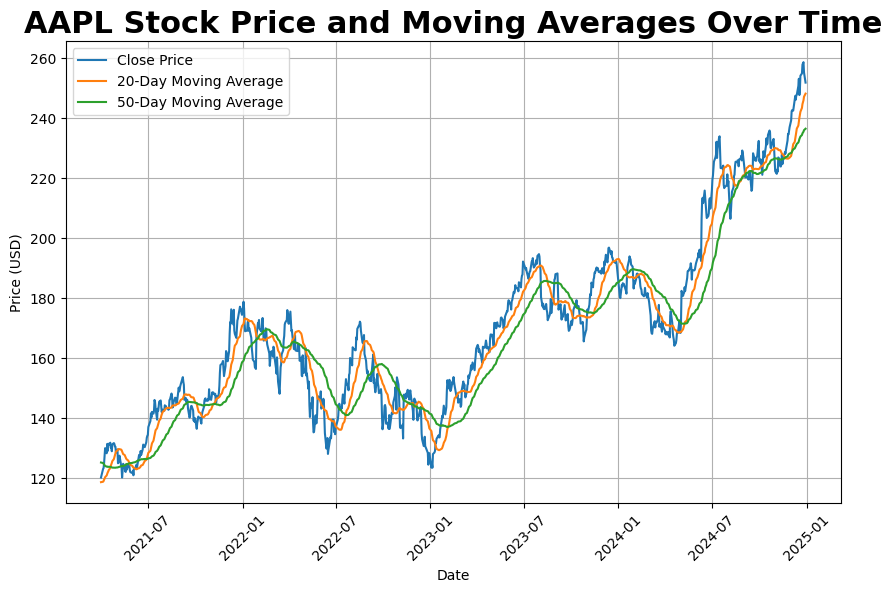

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
plt.plot(stock_data['Date'], stock_data['Close'], label='Close Price')
plt.plot(stock_data['Date'], stock_data['20_MA'], label='20-Day Moving Average')
plt.plot(stock_data['Date'], stock_data['50_MA'], label='50-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.title('AAPL Stock Price and Moving Averages Over Time', fontsize=22, fontweight='bold')
plt.legend(loc='best') 
plt.grid(True)
plt.xticks(rotation=45)
plt.savefig('AAPL_Stock_Price_and_Moving_Averages_over_Time.png', format='png', bbox_inches='tight')
plt.show()

## 3: News Data Collection

In [15]:
news_data = pd.read_csv('NewsData.io_Apple_Apr2021_to_30_Dec2024_9pm_UTC.csv', low_memory=False)
pd.set_option('display.max_columns', None)
news_data.head()

,article_id,title,link,keywords,creator,video_url,description,content,pubDate,pubDateTZ,image_url,source_id,source_priority,source_name,source_url,source_icon,language,country,category,ai_tag,ai_region,ai_org,sentiment,sentiment_stats,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40,Unnamed: 41,Unnamed: 42,Unnamed: 43,Unnamed: 44,Unnamed: 45,Unnamed: 46,Unnamed: 47,Unnamed: 48,Unnamed: 49,Unnamed: 50,Unnamed: 51,Unnamed: 52,Unnamed: 53,Unnamed: 54,Unnamed: 55,Unnamed: 56,Unnamed: 57,Unnamed: 58,Unnamed: 59,Unnamed: 60,Unnamed: 61,Unnamed: 62,Unnamed: 63,Unnamed: 64,Unnamed: 65,Unnamed: 66,Unnamed: 67,Unnamed: 68,Unnamed: 69,Unnamed: 70,Unnamed: 71,Unnamed: 72,Unnamed: 73,Unnamed: 74,Unnamed: 75,Unnamed: 76,Unnamed: 77,Unnamed: 78,Unnamed: 79,Unnamed: 80,Unnamed: 81,Unnamed: 82,Unnamed: 83,Unnamed: 84,Unnamed: 85,Unnamed: 86,Unnamed: 87,Unnamed: 88,Unnamed: 89,Unnamed: 90,Unnamed: 91,Unnamed: 92,Unnamed: 93,Unnamed: 94,Unnamed: 95,Unnamed: 96,Unnamed: 97,Unnamed: 98,Unnamed: 99,Unnamed: 100,Unnamed: 101,Unnamed: 102,Unnamed: 103,Unnamed: 104,Unnamed: 105,Unnamed: 106,Unnamed: 107,Unnamed: 108,Unnamed: 109,Unnamed: 110,Unnamed: 111,Unnamed: 112,Unnamed: 113,Unnamed: 114,Unnamed: 115,Unnamed: 116,Unnamed: 117,Unnamed: 118,Unnamed: 119,Unnamed: 120,Unnamed: 121,Unnamed: 122,Unnamed: 123,Unnamed: 124,Unnamed: 125,Unnamed: 126,Unnamed: 127,Unnamed: 128,Unnamed: 129,Unnamed: 130,Unnamed: 131,Unnamed: 132,Unnamed: 133,Unnamed: 134,Unnamed: 135,Unnamed: 136,Unnamed: 137,Unnamed: 138,Unnamed: 139,Unnamed: 140,Unnamed: 141,Unnamed: 142,Unnamed: 143,Unnamed: 144,Unnamed: 145,Unnamed: 146,Unnamed: 147,Unnamed: 148,Unnamed: 149,Unnamed: 150,Unnamed: 151,Unnamed: 152,Unnamed: 153,Unnamed: 154,Unnamed: 155,Unnamed: 156,Unnamed: 157,Unnamed: 158,Unnamed: 159,Unnamed: 160,Unnamed: 161,Unnamed: 162,Unnamed: 163,Unnamed: 164,Unnamed: 165,Unnamed: 166,Unnamed: 167,Unnamed: 168,Unnamed: 169,Unnamed: 170,Unnamed: 171,Unnamed: 172,Unnamed: 173,Unnamed: 174,Unnamed: 175,Unnamed: 176,Unnamed: 177,Unnamed: 178,Unnamed: 179,Unnamed: 180,Unnamed: 181,Unnamed: 182,Unnamed: 183,Unnamed: 184,Unnamed: 185,Unnamed: 186,Unnamed: 187,Unnamed: 188,Unnamed: 189,Unnamed: 190,Unnamed: 191,Unnamed: 192,Unnamed: 193,Unnamed: 194,Unnamed: 195,Unnamed: 196,Unnamed: 197,Unnamed: 198,Unnamed: 199,Unnamed: 200,Unnamed: 201,Unnamed: 202,Unnamed: 203,Unnamed: 204,Unnamed: 205,Unnamed: 206,Unnamed: 207,Unnamed: 208,Unnamed: 209,Unnamed: 210,Unnamed: 211,Unnamed: 212,Unnamed: 213,Unnamed: 214,Unnamed: 215,Unnamed: 216,Unnamed: 217,Unnamed: 218,Unnamed: 219,Unnamed: 220,Unnamed: 221,Unnamed: 222,Unnamed: 223,Unnamed: 224,Unnamed: 225,Unnamed: 226,Unnamed: 227,Unnamed: 228,Unnamed: 229,Unnamed: 230,Unnamed: 231,Unnamed: 232,Unnamed: 233,Unnamed: 234,Unnamed: 235,Unnamed: 236,Unnamed: 237,Unnamed: 238,Unnamed: 239,Unnamed: 240,Unnamed: 241,Unnamed: 242,Unnamed: 243,Unnamed: 244,Unnamed: 245,Unnamed: 246,Unnamed: 247,Unnamed: 248,Unnamed: 249,Unnamed: 250,Unnamed: 251,Unnamed: 252,Unnamed: 253,Unnamed: 254,Unnamed: 255,Unnamed: 256,Unnamed: 257,Unnamed: 258,Unnamed: 259,Unnamed: 260,Unnamed: 261,Unnamed: 262,Unnamed: 263,Unnamed: 264,Unnamed: 265,Unnamed: 266,Unnamed: 267,Unnamed: 268,Unnamed: 269,Unnamed: 270,Unnamed: 271,Unnamed: 272,Unnamed: 273,Unnamed: 274,Unnamed: 275,Unnamed: 276,Unnamed: 277,Unnamed: 278,Unnamed: 279,Unnamed: 280,Unnamed: 281,Unnamed: 282,Unnamed: 283,Unnamed: 284,Unnamed: 285,Unnamed: 286,Unnamed: 287,Unnamed: 288,Unnamed: 289,Unnamed: 290,Unnamed: 291,Unnamed: 292,Unnamed: 293,Unnamed: 294,Unnamed: 295,Unnamed: 296,Unnamed: 297,Unnamed: 298,Unnamed: 299,Unnamed: 300,Unnamed: 301,Unnamed: 302,Unnamed: 303,Unnamed: 304,Unnamed: 305,Unnamed: 306,Unnamed: 307,Unnamed: 308,Unnamed: 309,Unnamed: 310,Unnamed: 311,Unnamed: 312,Unnamed: 313,Unnamed: 314,Unnamed: 315,Unnamed: 316,Unnamed: 317,Unnamed: 318,Unname

In [16]:
news_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18434 entries, 0 to 18433
Columns: 595 entries, article_id to Unnamed: 594
dtypes: float64(2), object(593)
memory usage: 83.7+ MB


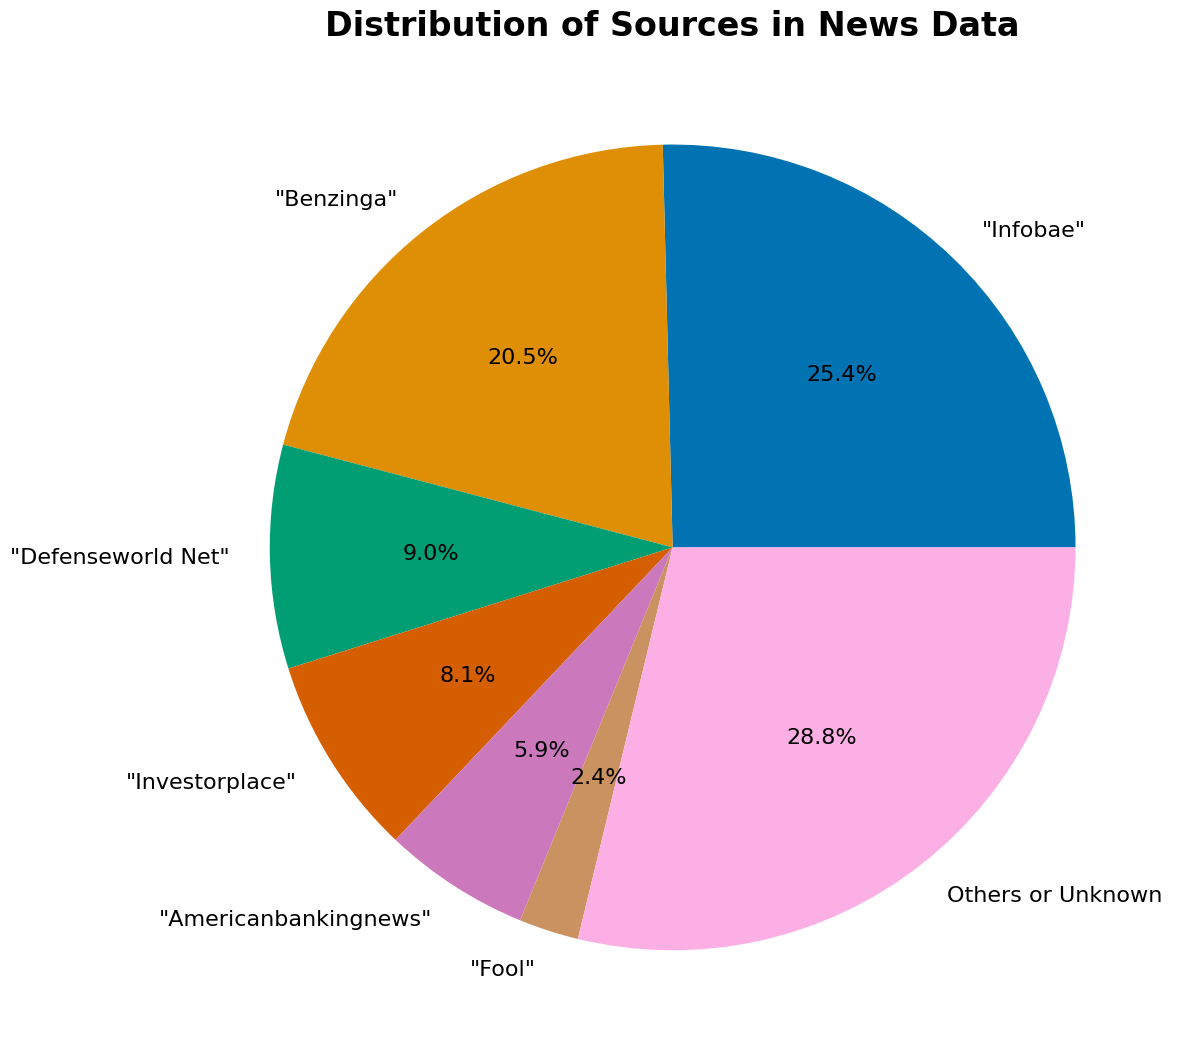

In [17]:
source_counts = news_data['source_name'].value_counts()
threshold = 0.02
source_counts_sum = source_counts.sum()
labels = []
values = []
others_value = 0
for label, count in source_counts.items():
    if count / source_counts_sum > threshold:
        labels.append(label)
        values.append(count)
    else:
        others_value += count
        
if others_value > 0:
    labels.append("Others or Unknown")
    values.append(others_value)

plt.figure(figsize=(12, 12))  
colors = sns.color_palette('colorblind', len(labels))
plt.pie(
    values, 
    labels=labels, 
    autopct=lambda p: f'{p:.1f}%' if p > 0 else '', 
    colors=colors, 
    textprops={'fontsize': 16}
)
plt.title('Distribution of Sources in News Data', fontsize=24, fontweight='bold')
plt.tight_layout()
plt.savefig('Distribution_of_Sources_in_News_Data_Pie_Chart.png', format='png', bbox_inches='tight')
plt.show()

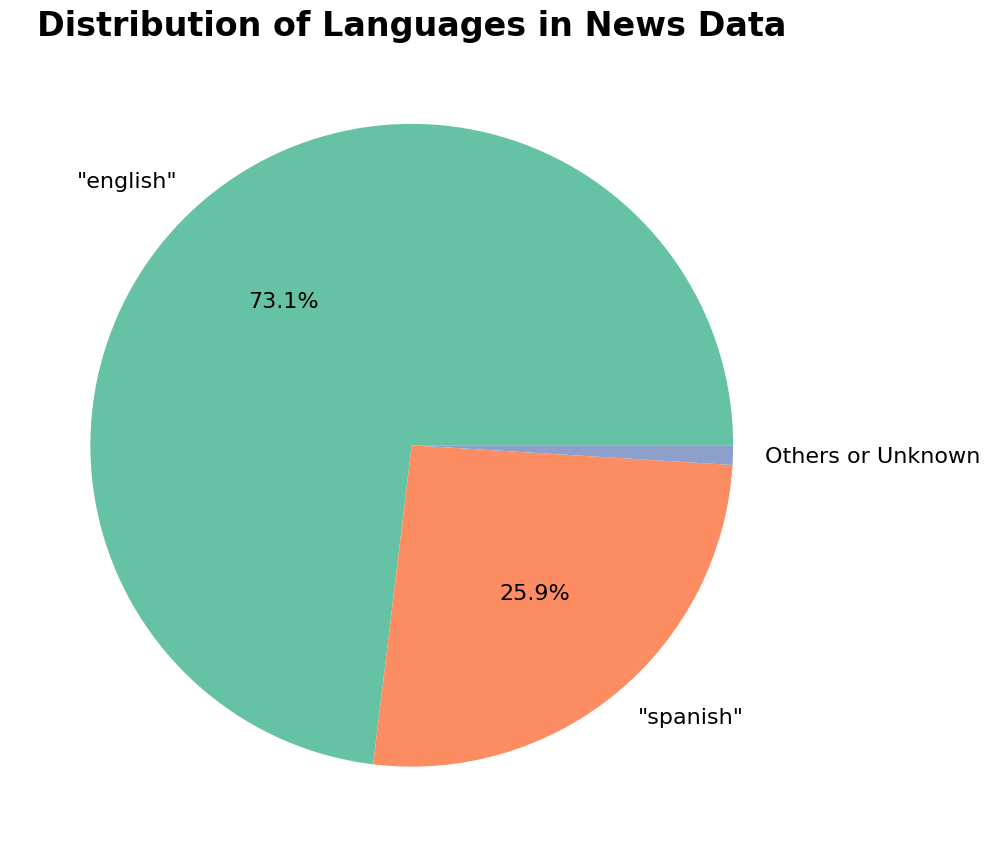

In [18]:
language_counts = news_data['language'].value_counts()
threshold = 0.02
labels = []
values = []
others_value = 0
source_counts_sum = language_counts.sum()

for label, count in language_counts.items():
    if count / source_counts_sum > threshold:
        labels.append(label)
        values.append(count)
    else:
        others_value += count

if others_value > 0:
    labels.append('Others or Unknown')
    values.append(others_value)

plt.figure(figsize=(10, 10)) 
colors = sns.color_palette('Set2', n_colors=len(labels))
plt.pie(
    values,
    colors=colors,
    labels=labels,
    autopct=lambda p: f'{p:.1f}%' if p > threshold * 100 else '',
    textprops={'fontsize': 16}
)
plt.title('Distribution of Languages in News Data', fontsize=24, fontweight='bold')
plt.tight_layout()
plt.savefig('Distribution_of_Languages_in_News_Data_Pie_Chart.png', format='png', bbox_inches='tight')
plt.show()

## 4. News Data Preprocessing

In [20]:
news_data = news_data[['pubDate', 'title']]
news_data['pubDate'] = news_data['pubDate'].str.replace('"', '').str.strip()
news_data['pubDate'] = pd.to_datetime(news_data['pubDate'], errors='coerce')
news_data.head()

,pubDate,title
0,2024-12-30 20:05:00,"""Apple TV+ will be free to stream this weekend"""
1,2024-12-30 19:54:32,"""Veteran fund manager reveals shocking Nvidia ..."
2,2024-12-30 18:29:53,"""Apple Stock Price Prediction 2025: Can AAPL D..."
3,2024-12-30 18:00:58,"""Cierre del principal índice de Lisboa este 3..."
4,2024-12-30 17:52:57,"""TSMC (TSM) Spotlight: The Foundry of 21st Cen..."


In [21]:
news_data.iloc[1]

pubDate                                  2024-12-30 19:54:32
title      "Veteran fund manager reveals shocking Nvidia ...
Name: 1, dtype: object

In [22]:
# Extract date part only and make news published after the close time of NASDAQ to the next date
def transform_pubdate(date):
    if pd.isna(date):  # Check for NaT values
        return date  # Return NaT as is
    if date.time() < pd.Timestamp('21:00:00').time():
        return date.date()  # Retain only the date part
    else:
        return (date + pd.Timedelta(days=1)).date()  # Add one day and retain date part

news_data['pubDate'] = news_data['pubDate'].apply(transform_pubdate)
news_data['pubDate'] = pd.to_datetime(news_data['pubDate'], errors='coerce')
news_data.head()

,pubDate,title
0,2024-12-30,"""Apple TV+ will be free to stream this weekend"""
1,2024-12-30,"""Veteran fund manager reveals shocking Nvidia ..."
2,2024-12-30,"""Apple Stock Price Prediction 2025: Can AAPL D..."
3,2024-12-30,"""Cierre del principal índice de Lisboa este 3..."
4,2024-12-30,"""TSMC (TSM) Spotlight: The Foundry of 21st Cen..."


In [23]:
# If a news publish date is not a stock market opening day, transform to the next opening day.
def find_nearest_date(date):
    if date not in stock_data['Date'].values:
        nearest_date = stock_data['Date'][stock_data['Date'] > date].min()
        return nearest_date if pd.notna(nearest_date) else date  # Handle case where no future date exists
    return date

news_data['pubDate'] = news_data['pubDate'].apply(find_nearest_date)
news_data.head()

,pubDate,title
0,2024-12-30,"""Apple TV+ will be free to stream this weekend"""
1,2024-12-30,"""Veteran fund manager reveals shocking Nvidia ..."
2,2024-12-30,"""Apple Stock Price Prediction 2025: Can AAPL D..."
3,2024-12-30,"""Cierre del principal índice de Lisboa este 3..."
4,2024-12-30,"""TSMC (TSM) Spotlight: The Foundry of 21st Cen..."


In [24]:
news_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18434 entries, 0 to 18433
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   pubDate  18256 non-null  datetime64[ns]
 1   title    18290 non-null  object        
dtypes: datetime64[ns](1), object(1)
memory usage: 288.2+ KB


In [25]:
news_data = news_data.dropna()
news_data = news_data[news_data['title']!='NaN']
news_data = news_data.sort_values('pubDate', ascending=True).reset_index(drop=True)

In [26]:
news_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18256 entries, 0 to 18255
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   pubDate  18256 non-null  datetime64[ns]
 1   title    18256 non-null  object        
dtypes: datetime64[ns](1), object(1)
memory usage: 285.4+ KB


In [27]:
year = news_data['pubDate'].apply(lambda x: x.year)
print(year)

0        2021
1        2021
2        2021
3        2021
4        2021
         ... 
18251    2024
18252    2024
18253    2024
18254    2024
18255    2024
Name: pubDate, Length: 18256, dtype: int64


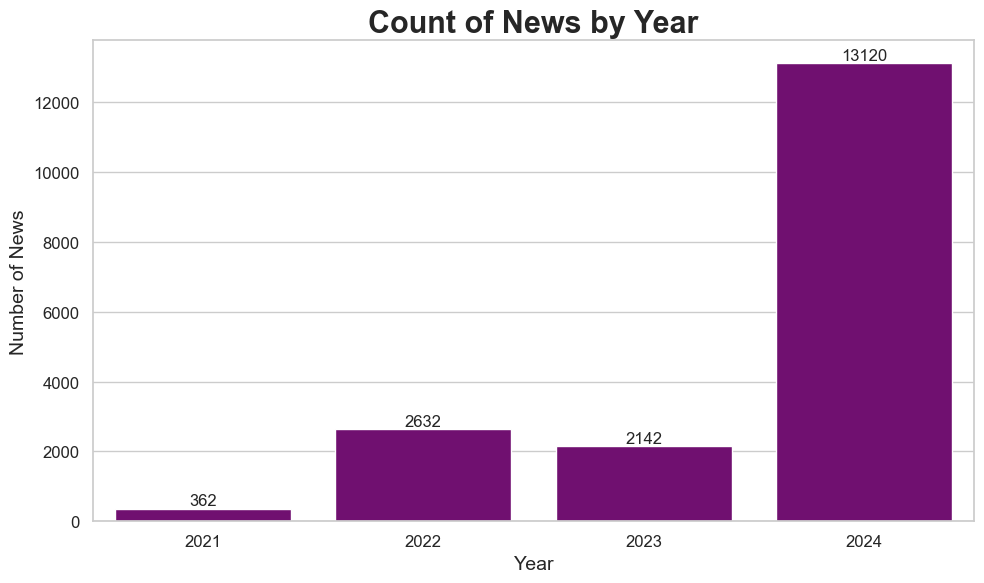

In [28]:
sns.set_theme(style='whitegrid')
plt.figure(figsize=(10, 6))
ax = sns.countplot(x=year, color='purple')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 100, int(height), ha='center', fontsize=12)
plt.title('Count of News by Year', fontsize=22, fontweight='bold')
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of News', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig('Count_of_News_by_Year.png', format='png', bbox_inches='tight')
plt.show()

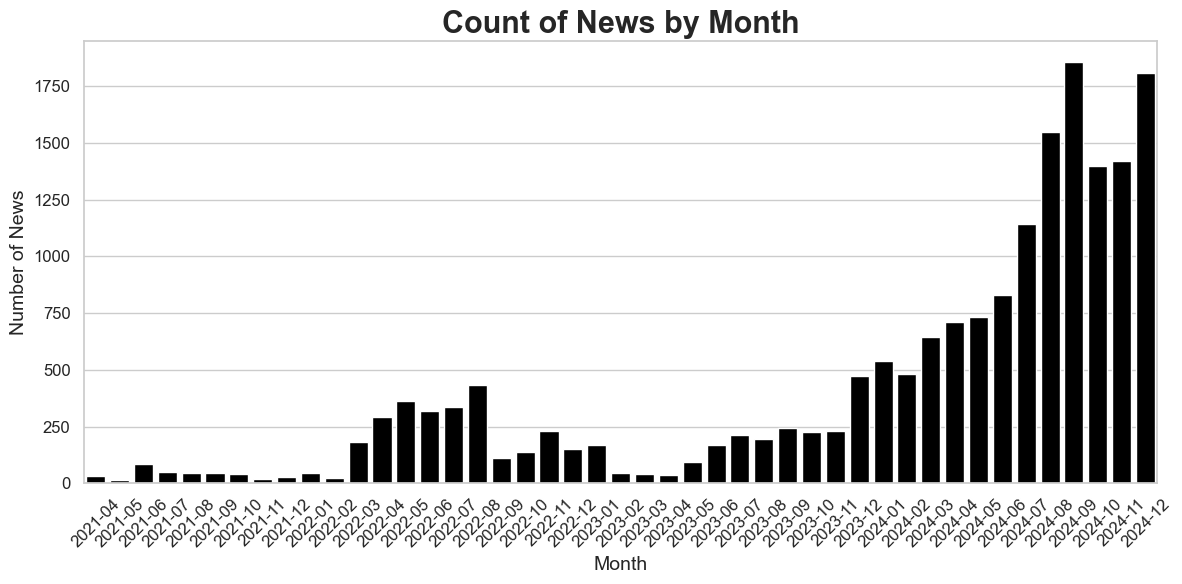

In [29]:
news_data['month'] = news_data['pubDate'].dt.to_period('M')
pub_date_counts = news_data['month'].value_counts().sort_index()
sns.set_theme(style='whitegrid')
plt.figure(figsize=(12, 6))
sns.barplot(x=pub_date_counts.index.astype(str), y=pub_date_counts.values, color='black')
plt.title('Count of News by Month', fontsize=22, fontweight='bold')
plt.xlabel('Month', fontsize=14)
plt.ylabel('Number of News', fontsize=14)
plt.xticks(fontsize=12, rotation=45) 
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig('Count_of_News_by_Month.png', format='png', bbox_inches='tight')
plt.show()

In [30]:
# 'Aggregate' the titles by pubDate
news_group_by_publication_date = news_data.groupby('pubDate')['title'].apply(lambda x: '\n'.join([f'Title {i+1}: {title}' for i, title in enumerate(x)])).reset_index()
news_group_by_publication_date.columns = ['pubDate', 'title']
news_group_by_publication_date.head()

,pubDate,title
0,2021-04-06,"Title 1: ""Apple Services still growing strongl..."
1,2021-04-07,"Title 1: ""Buy AAPL, suggests Wedbush, suggesti..."
2,2021-04-09,"Title 1: ""AAPL: Apple Dividend Analysis""\nTitl..."
3,2021-04-15,"Title 1: ""Chipmaker TSMC says profit up 16.7% ..."
4,2021-04-16,"Title 1: ""Market Implications of the American ..."


In [31]:
news_group_by_publication_date.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 844 entries, 0 to 843
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   pubDate  844 non-null    datetime64[ns]
 1   title    844 non-null    object        
dtypes: datetime64[ns](1), object(1)
memory usage: 13.3+ KB


In [32]:
news_group_by_publication_date['title'][25]

'Title 1: "Apple is finding more ways to keep you glued to the iPhone with iOS 15 (AAPL)"\nTitle 2: "iOS 15, iPadOS 15, and macOS Monterey Introduce System-Wide Translation, Translate App Expands to iPad"\nTitle 3: "HomeKit Secure Video Cameras Can Notify You When a Package Has Arrived Starting With iOS 15"\nTitle 4: "Everything Apple Announced at Today\'s WWDC 2021 Keynote in 9 Minutes"\nTitle 5: "Apple in \'Early-Stage\' Talks With Chinese EV Battery Makers for Apple Car"'

In [33]:
news_group_by_publication_date.head(30)

,pubDate,title
0,2021-04-06,"Title 1: ""Apple Services still growing strongl..."
1,2021-04-07,"Title 1: ""Buy AAPL, suggests Wedbush, suggesti..."
2,2021-04-09,"Title 1: ""AAPL: Apple Dividend Analysis""\nTitl..."
3,2021-04-15,"Title 1: ""Chipmaker TSMC says profit up 16.7% ..."
4,2021-04-16,"Title 1: ""Market Implications of the American ..."
5,2021-04-21,"Title 1: ""Were Hedge Funds Right About Piling ..."
6,2021-04-22,"Title 1: ""Apple to boost ads business as iPhon..."
7,2021-04-23,"Title 1: ""Apple (AAPL) to Report Q2 Earnings: ..."
8,2021-04-27,"Title 1: ""AAPL Q2 2021 earnings: Analysts expe..."
9,2021-04-28,"Title 1: ""Apple to Report Quarterly Results as..."


## Approach 1: Sentiment Analysis

## 5. Sentiment Scores Generation (Just skip this part as it takes about 8 minutes to run and is used to generate sentiment scores only.)

from azure.ai.textanalytics import TextAnalyticsClient
from azure.core.credentials import AzureKeyCredential
endpoint = "https://dwedwe.openai.azure.com/"
key = "BKc0b6fu3cgajt7rmM8sKcZ4c5MHQF0r8cwk4QyoYIS0KFR8uHlMJQQJ99BBACYeBjFXJ3w3AAAAACOGA85h"
client = TextAnalyticsClient(endpoint=endpoint, credential=AzureKeyCredential(key))

def split_text(text, max_length=5120):
    return [text[i:i + max_length] for i in range(0, len(text), max_length)]

import time
from tqdm import tqdm

results = []
start_time = time.time()
for text in tqdm(news_group_by_publication_date['title'].tolist(), desc="Processing texts", unit='text'): # Add a progress bar
    chunks = split_text(text)
    for chunk in chunks:
        response = client.analyze_sentiment(documents=[chunk])[0]
        if not response.is_error:
            sentiment = response.sentiment
            confidence_scores = response.confidence_scores
            results.append({
                'text': chunk,
                'sentiment': sentiment,
                'positive': confidence_scores.positive,
                'negative': confidence_scores.negative,
                'neutral': confidence_scores.neutral
            })
        else:
            print(f"Error processing document: {response.error.message}")
end_time = time.time()

daily_sentiment_scores = pd.DataFrame(results)

import os
file_path = 'daily_titles_sentiment_scores.csv'

if os.path.exists(file_path):
    overwrite_message = f"File '{file_path}' exists and has been overwritten."
else:
    overwrite_message = f"File '{file_path}' does not exist. A new file will be created."
daily_sentiment_scores.to_csv(file_path, index=False)

print(overwrite_message)
print(f"Processing completed in {end_time - start_time:.2f} seconds.")

## 6. Multimodal Dataset Construction

In [41]:
daily_sentiment_scores = pd.read_csv('daily_titles_sentiment_scores.csv')

In [42]:
# Aggregate sentiment scores
daily_sentiment_scores['aggregated_sentiment_score'] = daily_sentiment_scores['positive'] * 1 + daily_sentiment_scores['neutral'] * 0 + daily_sentiment_scores['negative'] * (-1)
daily_sentiment_scores.drop(['sentiment', 'positive', 'negative', 'neutral'], axis=1, inplace=True)                                                                                                                                                                              
daily_sentiment_scores.head(20)

,text,aggregated_sentiment_score
0,"Title 1: ""Apple Services still growing strongl...",0.06
1,"Title 1: ""Buy AAPL, suggests Wedbush, suggesti...",0.06
2,"Title 1: ""AAPL: Apple Dividend Analysis""\nTitl...",0.46
3,"Title 1: ""Chipmaker TSMC says profit up 16.7% ...",0.03
4,"Title 1: ""Market Implications of the American ...",0.00
5,"Title 1: ""Were Hedge Funds Right About Piling ...",-0.17
6,"Title 1: ""Apple to boost ads business as iPhon...",0.09
7,"Title 1: ""Apple (AAPL) to Report Q2 Earnings: ...",0.02
8,"Title 1: ""AAPL Q2 2021 earnings: Analysts expe...",0.08
9,"Title 1: ""Apple to Report Quarterly Results as...",0.78


In [43]:
concatenated_text = []
aggregated_scores = []
current_scores = []

for i, text in enumerate(daily_sentiment_scores['text']):
    if text.startswith('Title 1:'):
        if current_scores:
            # Calculate the average and append if there are scores collected
            aggregated_scores.append(sum(current_scores) / len(current_scores))
        concatenated_text.append(text)
        current_scores = [daily_sentiment_scores['aggregated_sentiment_score'][i]]
    else:
        concatenated_text[-1] += text
        current_scores.append(daily_sentiment_scores['aggregated_sentiment_score'][i])

# Append the last aggregated score
if current_scores:
    aggregated_scores.append(sum(current_scores) / len(current_scores))

# Create a new DataFrame with the concatenated text and aggregated sentiment scores
daily_sentiment_scores = pd.DataFrame({'text': concatenated_text, 'aggregated_sentiment_score': aggregated_scores})

# Display the first few rows of the new DataFrame
print(daily_sentiment_scores.head(20))

                                                 text  \
0   Title 1: "Apple Services still growing strongl...   
1   Title 1: "Buy AAPL, suggests Wedbush, suggesti...   
2   Title 1: "AAPL: Apple Dividend Analysis"\nTitl...   
3   Title 1: "Chipmaker TSMC says profit up 16.7% ...   
4   Title 1: "Market Implications of the American ...   
5   Title 1: "Were Hedge Funds Right About Piling ...   
6   Title 1: "Apple to boost ads business as iPhon...   
7   Title 1: "Apple (AAPL) to Report Q2 Earnings: ...   
8   Title 1: "AAPL Q2 2021 earnings: Analysts expe...   
9   Title 1: "Apple to Report Quarterly Results as...   
10  Title 1: "Everything you need to know about mi...   
11  Title 1: "Apple’s App Store Draws E.U. Antitru...   
12  Title 1: "Warren Buffett says it ‘was probably...   
13  Title 1: "AAPL stock buybacks will help US equ...   
14  Title 1: "Yes, your iPhone is taking 'invisibl...   
15  Title 1: "Report: Chip delays enter ‘danger zo...   
16  Title 1: "Jim Cramer on App

In [44]:
# Check before inner join to see whether the primary key is okay
sum(daily_sentiment_scores['text']== news_group_by_publication_date['title'])==len(news_group_by_publication_date)

True

In [45]:
daily_sentiment_scores = pd.merge(news_group_by_publication_date, daily_sentiment_scores, left_on='title', right_on='text', how='inner')
daily_sentiment_scores = daily_sentiment_scores[['pubDate', 'aggregated_sentiment_score']]
daily_sentiment_scores = daily_sentiment_scores.sort_values('pubDate', ascending=True).reset_index(drop=True)
daily_sentiment_scores.head()

,pubDate,aggregated_sentiment_score
0,2021-04-06,0.06
1,2021-04-07,0.06
2,2021-04-09,0.46
3,2021-04-15,0.03
4,2021-04-16,0.00


In [46]:
daily_sentiment_scores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 844 entries, 0 to 843
Data columns (total 2 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   pubDate                     844 non-null    datetime64[ns]
 1   aggregated_sentiment_score  844 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 13.3 KB


In [47]:
daily_sentiment_scores.describe()

,pubDate,aggregated_sentiment_score
count,844,844.000000
mean,2023-03-29 05:15:38.388625408,-0.019482
min,2021-04-06 00:00:00,-0.980000
25%,2022-05-15 06:00:00,-0.120000
50%,2023-04-12 12:00:00,0.010000
75%,2024-02-28 06:00:00,0.110000
max,2024-12-30 00:00:00,0.940000
std,NaN,0.337307


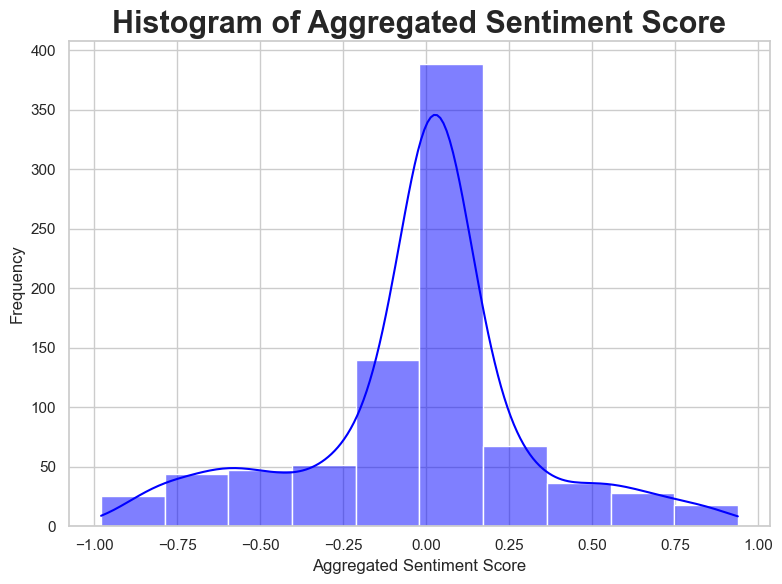

In [48]:
plt.figure(figsize=(8, 6))
sns.histplot(daily_sentiment_scores['aggregated_sentiment_score'], kde=True, color='blue', bins=10)
plt.title('Histogram of Aggregated Sentiment Score', fontsize=22, fontweight='bold')
plt.xlabel('Aggregated Sentiment Score', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.savefig('Aggregated_Sentiment_Score_Histogram.png', format='png', bbox_inches='tight')
plt.show()

In [49]:
multimodal_data = pd.merge(stock_data, daily_sentiment_scores, left_on='Date', right_on='pubDate', how='left')
multimodal_data = multimodal_data.sort_values('Date', ascending=True).reset_index(drop=True)
multimodal_data.drop(['High', 'Low', 'Open', 'pubDate'], axis=1, inplace=True)
multimodal_data.head()

,Date,Close,Volume,Close_log_diff,20_MA,50_MA,RSI,Bollinger_High,Bollinger_Low,ATR,MACD,MACD_Signal,Support,Resistance,aggregated_sentiment_score
0,2021-04-01,120.323601,75089100,0.006934,118.761840,125.309589,47.755592,122.630284,114.893397,3.246014,-1.485948,-1.789714,113.681342,124.451776,NaN
1,2021-04-05,123.160500,88651200,0.023304,118.902218,125.136773,49.560660,122.783384,115.021051,3.156001,-1.265296,-1.684830,113.681342,124.451776,NaN
2,2021-04-06,123.463737,80171300,0.002459,119.121343,124.926143,55.242480,123.421913,114.820774,3.151375,-0.851696,-1.518203,113.681342,124.451776,0.06
3,2021-04-07,125.116989,83466700,0.013302,119.603126,124.678598,55.815425,123.569735,115.636517,3.029691,-0.493755,-1.313314,116.205198,124.451776,0.06
4,2021-04-08,127.523445,88844600,0.019051,119.936218,124.388907,58.904190,124.530470,115.341966,3.007535,-0.075806,-1.065812,116.273667,125.136551,NaN


In [50]:
multimodal_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 943 entries, 0 to 942
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Date                        943 non-null    datetime64[ns]
 1   Close                       943 non-null    float64       
 2   Volume                      943 non-null    int64         
 3   Close_log_diff              943 non-null    float64       
 4   20_MA                       943 non-null    float64       
 5   50_MA                       943 non-null    float64       
 6   RSI                         943 non-null    float64       
 7   Bollinger_High              943 non-null    float64       
 8   Bollinger_Low               943 non-null    float64       
 9   ATR                         943 non-null    float64       
 10  MACD                        943 non-null    float64       
 11  MACD_Signal                 943 non-null    float64       

## 7. Multimodal Dataset Preprocessing

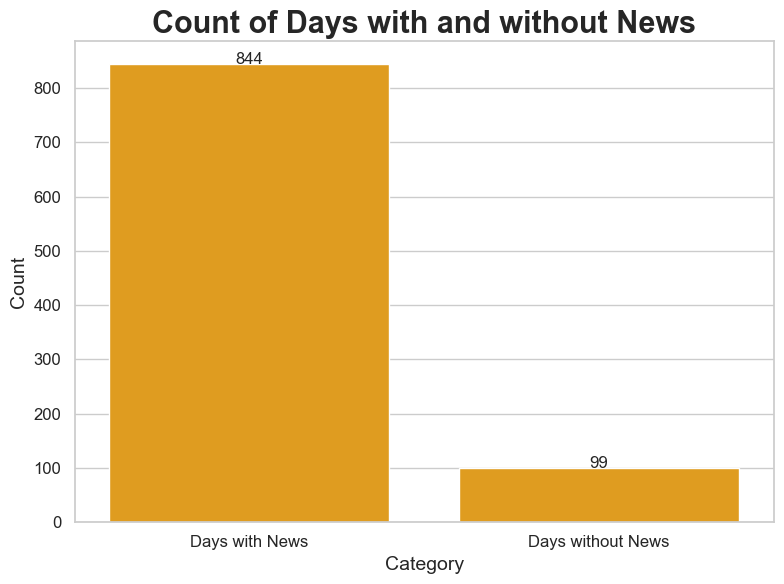

In [52]:
counts = multimodal_data['aggregated_sentiment_score'].notnull().value_counts()
counts.index = ["Days with News", "Days without News"]
sns.set_theme(style='whitegrid')
plt.figure(figsize=(8, 6))
ax = sns.barplot(x=counts.index, y=counts.values, color='orange')
for i, count in enumerate(counts.values):
    ax.text(i, count + 0.1, str(count), ha='center', fontsize=12)
plt.title("Count of Days with and without News", fontsize=22, fontweight='bold')
plt.xlabel('Category', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig('Count_of_Days_with_and_without_News.png', format='png', bbox_inches='tight')
plt.show()

In [53]:
# Apply exponential decay to Aggregated Sentiment Scores to fill in the time gap
multimodal_data.set_index('Date', inplace=True)
decay_factor = 0.03

def fill_missing_sentiment(df):
    # Iterate over the DataFrame to fill missing values
    for i in range(len(df)):
        if pd.isna(df['aggregated_sentiment_score'].iloc[i]):
            # Find the last known sentiment score (S(0)) using .loc
            last_known_index = df['aggregated_sentiment_score'][:df.index[i]].last_valid_index()
            if last_known_index is not None:
                S_0 = df.loc[last_known_index, 'aggregated_sentiment_score']
                # Calculate time (t) as the number of days since the last known sentiment score
                t = (df.index[i] - last_known_index).days
                # Apply the exponential decay formula
                S_t = 3 + (S_0 - 3) * np.exp(-decay_factor * t)
                df.loc[df.index[i], 'aggregated_sentiment_score'] = S_t
    return df

multimodal_data = fill_missing_sentiment(multimodal_data)

In [54]:
# Fill missing values of all columns with their corresponding averages
average_values = multimodal_data['aggregated_sentiment_score'].mean()
multimodal_data['aggregated_sentiment_score'] = multimodal_data['aggregated_sentiment_score'].fillna(average_values)
multimodal_data.head()

,Close,Volume,Close_log_diff,20_MA,50_MA,RSI,Bollinger_High,Bollinger_Low,ATR,MACD,MACD_Signal,Support,Resistance,aggregated_sentiment_score
Date,,,,,,,,,,,,,,
2021-04-01,120.323601,75089100,0.006934,118.761840,125.309589,47.755592,122.630284,114.893397,3.246014,-1.485948,-1.789714,113.681342,124.451776,0.011439
2021-04-05,123.160500,88651200,0.023304,118.902218,125.136773,49.560660,122.783384,115.021051,3.156001,-1.265296,-1.684830,113.681342,124.451776,0.011439
2021-04-06,123.463737,80171300,0.002459,119.121343,124.926143,55.242480,123.421913,114.820774,3.151375,-0.851696,-1.518203,113.681342,124.451776,0.060000
2021-04-07,125.116989,83466700,0.013302,119.603126,124.678598,55.815425,123.569735,115.636517,3.029691,-0.493755,-1.313314,116.205198,124.451776,0.060000
2021-04-08,127.523445,88844600,0.019051,119.936218,124.388907,58.904190,124.530470,115.341966,3.007535,-0.075806,-1.065812,116.273667,125.136551,0.146890


In [55]:
multimodal_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 943 entries, 2021-04-01 to 2024-12-30
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Close                       943 non-null    float64
 1   Volume                      943 non-null    int64  
 2   Close_log_diff              943 non-null    float64
 3   20_MA                       943 non-null    float64
 4   50_MA                       943 non-null    float64
 5   RSI                         943 non-null    float64
 6   Bollinger_High              943 non-null    float64
 7   Bollinger_Low               943 non-null    float64
 8   ATR                         943 non-null    float64
 9   MACD                        943 non-null    float64
 10  MACD_Signal                 943 non-null    float64
 11  Support                     943 non-null    float64
 12  Resistance                  943 non-null    float64
 13  aggregated_senti

In [56]:
multimodal_data.describe()

,Close,Volume,Close_log_diff,20_MA,50_MA,RSI,Bollinger_High,Bollinger_Low,ATR,MACD,MACD_Signal,Support,Resistance,aggregated_sentiment_score
count,943.000000,9.430000e+02,943.000000,943.000000,943.000000,943.000000,943.000000,943.000000,943.000000,943.000000,943.000000,943.000000,943.000000,943.000000
mean,169.720645,7.138284e+07,0.000791,168.241950,166.466915,54.142806,177.356863,159.127037,3.701191,0.885754,0.853725,158.400810,177.365113,0.011439
std,30.433311,2.867924e+07,0.016451,29.218670,27.841464,12.178227,30.175400,28.664863,0.928430,2.890202,2.695184,28.202980,29.987064,0.351402
min,120.302597,2.323470e+07,-0.060472,118.761840,123.564705,22.223715,122.630284,112.729935,1.984369,-6.511138,-5.672587,113.681342,124.451776,-0.980000
25%,146.094070,5.127550e+07,-0.008055,144.799570,144.643419,44.235729,153.459797,136.480599,2.933493,-1.338998,-1.140611,135.694079,154.330293,-0.090000
50%,167.017792,6.587450e+07,0.001284,166.135517,163.658790,54.750762,175.838788,155.617791,3.547930,0.976973,0.871484,152.639131,174.132956,0.030000
75%,186.262230,8.489835e+07,0.010097,184.722496,182.552066,63.742643,194.126035,175.824028,4.413312,2.950660,2.856816,175.335612,192.804612,0.137186
max,258.735504,3.186799e+08,0.085236,248.251551,236.552763,81.320622,260.140405,236.362697,6.897250,8.925401,8.292325,233.713041,259.814335,1.075383


In [57]:
multimodal_data.iloc[30]

Close                         1.248885e+02
Volume                        8.191800e+07
Close_log_diff                1.965051e-02
20_MA                         1.281256e+02
50_MA                         1.241613e+02
RSI                           4.137563e+01
Bollinger_High                1.349836e+02
Bollinger_Low                 1.212676e+02
ATR                           2.982248e+00
MACD                         -8.695427e-01
MACD_Signal                   2.811402e-01
Support                       1.197931e+02
Resistance                    1.340875e+02
aggregated_sentiment_score    8.886681e-01
Name: 2021-05-14 00:00:00, dtype: float64

## 8. Machine Learning

In [59]:
# Train-test split
training_multimodal_data = multimodal_data[multimodal_data.index <= '2023-12-31']
test_multimodal_data = multimodal_data[multimodal_data.index > '2023-12-31']
print(f"Training Set Size: {len(training_multimodal_data)}")
print(f"Test Set Size: {len(test_multimodal_data)}")

Training Set Size: 692
Test Set Size: 251


In [60]:
training_actual_close = training_multimodal_data['Close'].values.reshape(-1, 1)
test_actual_close = test_multimodal_data['Close'].values.reshape(-1, 1)
print(training_actual_close.shape)
print(test_actual_close.shape)

(692, 1)
(251, 1)


In [61]:
X_train = training_multimodal_data.drop(['Close', 'Close_log_diff'], axis=1).values
y_train = training_multimodal_data['Close_log_diff'].to_numpy()
X_test = test_multimodal_data.drop(['Close', 'Close_log_diff'], axis=1).values
y_test = test_multimodal_data['Close_log_diff'].to_numpy()

In [62]:
train_predictions_last_close = np.concatenate((actual_close_2021_03_31, training_multimodal_data[:-1]['Close'].values)).reshape(-1, 1)
test_predictions_last_close = np.concatenate((actual_close_2023_12_29, test_multimodal_data[:-1]['Close'].values)).reshape(-1, 1)
print(train_predictions_last_close.shape)
print(test_predictions_last_close.shape)

(692, 1)
(251, 1)


In [63]:
from sklearn.preprocessing import MinMaxScaler

# Initialize separate scalers for X and y
scaler_X = MinMaxScaler()  # For independent variables
scaler_y = MinMaxScaler()  # For dependent variable

# Fit and transform X_train and y_train
X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))  
X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))  

# Print shapes to verify correctness
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"y_train_scaled shape: {y_train_scaled.shape}")
print(f"X_test_scaled shape: {X_test_scaled.shape}")
print(f"y_test_scaled shape: {y_test_scaled.shape}")

X_train_scaled shape: (692, 12)
y_train_scaled shape: (692, 1)
X_test_scaled shape: (251, 12)
y_test_scaled shape: (251, 1)


In [64]:
results = []

In [65]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score

# Function to define the search space based on hyperparameter choices
def define_search_space_for_supervised_model(hyperparameter_choices_dict):
    """
    Converts a dictionary of hyperparameter choices into a Hyperopt-compatible search space.
    """
    search_space = {}
    for param_name, choices in hyperparameter_choices_dict.items():
        search_space[param_name] = hp.choice(param_name, choices)
    return search_space

In [66]:
# Objective function for hyperparameter optimization
def objective_supervised_model(params, model, X_train, y_train):
    """
    Objective function for Hyperopt to minimize.
    """
    # Update the model with the current set of parameters
    clf = model.set_params(**params)

    # Perform cross-validation and calculate mean score
    cv_score = cross_val_score(clf, X_train, y_train,
                               scoring='neg_mean_squared_error', cv=5, n_jobs=-1).mean()

    # Return the loss as a positive value (Hyperopt minimizes the objective)
    loss = -cv_score  # Negate because cross_val_score returns negative MSE
    return {'loss': loss, 'status': STATUS_OK}

In [67]:
def optimize_supervised_model(model, X_train, y_train, hyperparameter_choices_dict, max_evals=100):
    """
    Optimizes the given model using Hyperopt for the specified hyperparameter choices
    and returns the best model fitted on the training data.

    Parameters:
        model: The machine learning model to optimize (e.g., LinearRegression()).
        X_train: Training features.
        y_train: Training target values.
        hyperparameter_choices_dict: Dictionary of lists containing hyperparameter choices.
        max_evals: Maximum number of evaluations for Hyperopt's fmin().

    Returns:
        best_model: The best model fitted on the training data.
    """
    # Define the search space
    search_space = define_search_space_for_supervised_model(hyperparameter_choices_dict)

    # Define the objective function with fixed arguments
    def wrapped_objective(params):
        return objective_supervised_model(params, model, X_train, y_train)

    # Perform optimization using Hyperopt
    trials = Trials()
    best_indices = fmin(
        fn=wrapped_objective,
        space=search_space,
        algo=tpe.suggest,
        max_evals=max_evals,
        trials=trials,
        rstate=np.random.default_rng(42)
    )

    # Map indices back to actual values from hyperparameter_choices_dict
    best_params = {key: hyperparameter_choices_dict[key][best_indices[key]] for key in best_indices}

    # Update the model with the best parameters
    best_model = model.set_params(**best_params)

    # Fit the best model on the training data
    best_model.fit(X_train, y_train)

    return best_model

In [68]:
def supervised_model_reverse_scaling(train_forecast_scaled, test_forecast_scaled, reverse_min_max_scaling):
    """
    Reverse scaling and compute adjusted close forecasts for training and test data.

    Parameters:
        train_forecast_scaled (numpy.ndarray): Scaled training forecast values.
        test_forecast_scaled (numpy.ndrray): Scaled test forecast values.

    Returns:
        tuple: (train_close_forecast, test_close_forecast), the adjusted close forecasts.
    """
    # Reverse scaling for training data
    if reverse_min_max_scaling==True:
        train_forecast = scaler_y.inverse_transform(train_forecast_scaled.reshape(-1, 1))
    else:
        train_forecast = train_forecast_scaled
    train_close_forecast = np.exp(np.log(train_predictions_last_close) + train_forecast)

    # Reverse scaling for test data
    if reverse_min_max_scaling==True:
        test_forecast = scaler_y.inverse_transform(test_forecast_scaled.reshape(-1, 1))
    else:
        test_forecast = test_forecast_scaled
    test_close_forecast = np.exp(np.log(test_predictions_last_close) + test_forecast)

    return train_close_forecast, test_close_forecast

In [69]:
from sklearn.metrics import mean_squared_error

def supervised_model_evaluation(train_forecast_scaled, test_forecast_scaled, reverse_min_max_scaling):
    """
    Evaluate the supervised model by calculating MSE and percentage loss for training and test data.

    This function reverses the scaling of forecasted values, computes the Mean Squared Error (MSE), 
    and calculates the percentage loss for both training and test datasets.

    Parameters:
        train_forecast (numpy.ndarray): Forecast values for the training data.
        test_forecast (numpy.ndarray): Forecast values for the test data.

    Returns:
        tuple: A tuple containing:
            - training_mse (float): Mean Squared Error for the training data.
            - test_mse (float): Mean Squared Error for the test data.
            - train_percentage_loss (float): Percentage loss for the training data.
            - test_percentage_loss (float): Percentage loss for the test data.
    """
    train_close_forecast, test_close_forecast = supervised_model_reverse_scaling(train_forecast_scaled, test_forecast_scaled, reverse_min_max_scaling)

    # Calculate MSEs
    training_mse = mean_squared_error(training_actual_close, train_close_forecast)
    test_mse = mean_squared_error(test_actual_close, test_close_forecast)

    # Calculate percentage losses
    train_percentage_loss = np.mean(np.abs((training_actual_close - train_close_forecast) / training_actual_close)) * 100
    test_percentage_loss = np.mean(np.abs((test_actual_close - test_close_forecast) / test_actual_close)) * 100

    return training_mse, test_mse, train_percentage_loss, test_percentage_loss

In [70]:
def print_results(training_mse, test_mse, train_percentage_loss, test_percentage_loss, total_time):
    """
    Print the evaluation results of the supervised model.

    This function displays the training and test losses (unscaled), 
    percentage losses, and the total runtime of the model evaluation.

    Parameters:
        training_mse (float): Mean Squared Error for the training data.
        test_mse (float): Mean Squared Error for the test data.
        train_percentage_loss (float): Percentage loss for the training data.
        test_percentage_loss (float): Percentage loss for the test data.
        total_time (float): Total runtime of the evaluation process in seconds.

    Returns:
        None
    """
    print(f"Training Loss (unscaled): {training_mse:.4f}")
    print(f"Test Loss (unscaled): {test_mse:.4f}")
    print(f"Training Percentage Loss: {train_percentage_loss:.2f}%")
    print(f"Test Percentage Loss: {test_percentage_loss:.2f}%")
    print(f"Total runtime: {total_time:.4f} seconds")

In [71]:
import joblib

def save_supervised_model(model, file):
    """
    Save the supervised model to a file.

    This function serializes and saves the given model to the specified file using Joblib.

    Parameters:
        model (object): The supervised model to be saved.
        file (str): The file path where the model will be saved.

    Returns:
        None
    """
    joblib.dump(model, file, protocol=4)
    print("Model saved successfully!")

In [72]:
def supervised_model_train_and_test(model, model_name, file, X_train_scaled, y_train_scaled, X_test_scaled, reverse_min_max_scaling=True):
    """
    Train, test, and evaluate a supervised learning model.

    This function trains the given model on scaled training data, makes predictions on both 
    training and test datasets, evaluates the model's performance using MSE and percentage 
    loss metrics, and saves the trained model to a file. It also records the total runtime 
    and appends the results to a global results list.

    Parameters:
        model (object): The supervised learning model to be trained and tested.
        model_name (str): Name of the model (used for logging results).
        file (str): File path where the trained model will be saved.
        X_train_scaled (numpy.ndarray): Scaled features for training data.
        y_train_scaled (numpy.ndarray): Scaled target values for training data.
        X_test_scaled (numpy.ndarray): Scaled features for test data.

    Returns:
        None
    """
    start_time = time.time()

    model.fit(X_train_scaled, y_train_scaled)
    train_predictions_scaled =  model.predict(X_train_scaled).reshape(-1, 1)
    test_predictions_scaled =  model.predict(X_test_scaled).reshape(-1, 1)

    training_mse, test_mse, train_percentage_loss, test_percentage_loss = supervised_model_evaluation(train_predictions_scaled, test_predictions_scaled, reverse_min_max_scaling)

    end_time = time.time()
    total_time = end_time - start_time

    results.append([model_name, test_mse, test_percentage_loss, training_mse, train_percentage_loss, total_time])

    print_results(training_mse, test_mse, train_percentage_loss, test_percentage_loss, total_time)

    save_supervised_model(model, file)

In [73]:
import torch
import torch.nn as nn
import torch.optim as optim
import optuna

def optimize_deep_learning_model(objective, n_trials=30):
    """
    Optimize a deep learning model's hyperparameters using Optuna.

    This function creates an Optuna study to minimize the objective function 
    (e.g., test MSE) and runs the optimization process for a specified number 
    of trials.

    Parameters:
        objective (callable): The objective function to be minimized during optimization.
        n_trials (int, optional): The number of optimization trials. Defaults to 30.

    Returns:
        dict: The best hyperparameters found during the optimization process.
    """
    # Create a sampler with a fixed random seed for reproducibility
    sampler = optuna.samplers.TPESampler(seed=42)  
    
    # Create an Optuna study
    study = optuna.create_study(direction="minimize", sampler=sampler)  # Minimize test MSE

    # Run optimization
    study.optimize(objective, n_trials=n_trials) 

    return study.best_params # Model with lowest Train MSE

In [74]:
def deep_learning_reverse_scaling(train_forecast_scaled, test_forecast_scaled):
    """
    Reverse scaling and compute adjusted close forecasts for training and test data 
    in a deep learning model.

    This function applies inverse scaling to the scaled training and test forecast data 
    and computes the adjusted close forecasts using exponential transformations.

    Parameters:
        train_forecast_scaled (numpy.ndarray): Scaled forecast values for the training data.
        test_forecast_scaled (numpy.ndarray): Scaled forecast values for the test data.

    Returns:
        tuple: A tuple containing:
            - train_close_forecast (numpy.ndarray): Adjusted close forecasts for the training data.
            - test_close_forecast (numpy.ndarray): Adjusted close forecasts for the test data.
    """
    # Reverse scaling for training data
    train_forecast = scaler_y.inverse_transform(train_forecast_scaled.reshape(-1, 1))
    train_close_forecast = np.exp(np.log(train_predictions_last_close[(len(train_predictions_last_close)-len(X_train_tensor)):]) + train_forecast)

    # Reverse scaling for test data
    test_forecast = scaler_y.inverse_transform(test_forecast_scaled.reshape(-1, 1))
    test_close_forecast = np.exp(np.log(test_predictions_last_close[(len(test_predictions_last_close)-len(X_test_tensor)):]) + test_forecast)

    return train_close_forecast, test_close_forecast

In [75]:
def deep_learning_model_evaluation(train_forecast_scaled, test_forecast_scaled):
    """
    Evaluate a deep learning model by calculating MSE and percentage loss for training 
    and test data.

    This function reverses the scaling of forecasted values, computes the Mean Squared Error (MSE), 
    and calculates the percentage loss for both training and test datasets.

    Parameters:
        train_forecast_scaled (numpy.ndarray): Scaled forecast values for the training data.
        test_forecast_scaled (numpy.ndarray): Scaled forecast values for the test data.

    Returns:
        tuple: A tuple containing:
            - training_mse (float): Mean Squared Error for the training data.
            - test_mse (float): Mean Squared Error for the test data.
            - train_percentage_loss (float): Percentage loss for the training data.
            - test_percentage_loss (float): Percentage loss for the test data.
    """
    # Rescaling
    train_close_forecast, test_close_forecast = deep_learning_reverse_scaling(train_forecast_scaled, test_forecast_scaled)

    # Calculate MSEs
    training_mse = mean_squared_error(training_actual_close[(len(train_predictions_last_close)-len(X_train_tensor)):], train_close_forecast)
    test_mse = mean_squared_error(test_actual_close[(len(test_predictions_last_close)-len(X_test_tensor)):], test_close_forecast)

    # Calculate percentage losses
    train_percentage_loss = np.mean(np.abs((training_actual_close[(len(train_predictions_last_close)-len(X_train_tensor)):] - train_close_forecast) / training_actual_close[(len(train_predictions_last_close)-len(X_train_tensor)):])) * 100
    test_percentage_loss = np.mean(np.abs((test_actual_close[(len(test_predictions_last_close)-len(X_test_tensor)):] - test_close_forecast) / test_actual_close[(len(test_predictions_last_close)-len(X_test_tensor)):])) * 100

    return training_mse, test_mse, train_percentage_loss, test_percentage_loss

In [76]:
def save_deep_learning_model(model, file):
    """
    Save a deep learning model to a file.

    This function saves the given PyTorch model to the specified file using `torch.save`.

    Parameters:
        model (torch.nn.Module): The deep learning model to be saved.
        file (str): The file path where the model will be saved.

    Returns:
        None
    """
    torch.save(model, file)
    print("Model saved successfully!")

In [77]:
def deep_learning_train_and_test(model, model_name, file, X_train_tensor, y_train_tensor, X_test_tensor):
    """
    Train, test, and evaluate a deep learning model.

    This function trains the given PyTorch model on the training data using Mean Squared Error (MSE) 
    as the loss function and Adam as the optimizer. It evaluates the model's performance on both 
    training and test datasets by calculating MSE and percentage loss metrics. The trained model 
    is saved to the specified file, and the evaluation results are logged.

    Parameters:
        model (torch.nn.Module): The deep learning model to be trained and tested.
        model_name (str): Name of the model (used for logging results). Supports "Transformer" for special handling.
        file (str): File path where the trained model will be saved.
        X_train_tensor (torch.Tensor): Input features for the training data as a PyTorch tensor.
        y_train_tensor (torch.Tensor): Target values for the training data as a PyTorch tensor.
        X_test_tensor (torch.Tensor): Input features for the test data as a PyTorch tensor.

    Returns:
        tuple: A tuple containing:
            - training_mse (float): Mean Squared Error for the training data.
            - test_mse (float): Mean Squared Error for the test data.
            - train_percentage_loss (float): Percentage loss for the training data.
            - test_percentage_loss (float): Percentage loss for the test data.
            - total_time (float): Total runtime of training and evaluation in seconds.
    """
    # Define loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    start_time = time.time()
    num_epochs = 100
    for epoch in range(num_epochs):
        model.train()

        if model_name=="Transformer":
            # Prepare input with sequence dimension for Transformer
            src = X_train_tensor.unsqueeze(1)  # Add sequence dimension: (batch_size, seq_len=1, input_size)

            # Forward pass
            outputs = model(src).squeeze(-1)  # Remove last dimension for regression output
        else: 
            outputs = model(X_train_tensor)  # Forward pass
        loss = criterion(outputs, y_train_tensor)  # Compute loss
        optimizer.zero_grad()  # Clear gradients
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

    # Evaluation on train and test data
    model.eval()
    with torch.no_grad():
    
        # Predictions on train and test data
        if model_name=="Transformer":
            train_predictions_scaled = model(X_train_tensor.unsqueeze(1)).detach().numpy()
            train_predictions_scaled_2d = train_predictions_scaled.reshape(-1, train_predictions_scaled.shape[-1]).flatten() # Flatten to 2D
            test_predictions_scaled = model(X_test_tensor.unsqueeze(1)).detach().numpy()
            test_predictions_scaled_2d = test_predictions_scaled.reshape(-1, test_predictions_scaled.shape[-1]).flatten() # Flatten to 2D
        else:
            train_predictions_scaled = model(X_train_tensor).detach().numpy()
            train_predictions_scaled_2d = train_predictions_scaled.reshape(-1, train_predictions_scaled.shape[-1])  # Flatten to 2D
            test_predictions_scaled = model(X_test_tensor).detach().numpy()
            test_predictions_scaled_2d = test_predictions_scaled.reshape(-1, test_predictions_scaled.shape[-1])  # Flatten to 2D

        training_mse, test_mse, train_percentage_loss, test_percentage_loss = deep_learning_model_evaluation(train_predictions_scaled, test_predictions_scaled)

    end_time = time.time()
    total_time = end_time - start_time

    results.append([model_name, test_mse, test_percentage_loss, training_mse, train_percentage_loss, total_time])

    print_results(training_mse, test_mse, train_percentage_loss, test_percentage_loss, total_time)

    save_deep_learning_model(model, file)
    
    return training_mse, test_mse, train_percentage_loss, test_percentage_loss, total_time

### Random Walk

In [79]:
start_time = time.time()

# Random walk forecast for training data (shifted values)
train_forecast_scaled = np.roll(y_train_scaled, 1)
train_forecast_scaled[0] = y_train_scaled[0]  # First value is set to the first actual value

# Random walk forecast for test data (using last training value as starting point)
test_forecast_scaled = np.zeros_like(y_test_scaled)
test_forecast_scaled[0] = y_train_scaled[-1]  # Start with the last training value
test_forecast_scaled[1:] = y_test_scaled[:-1]  # Use lagged values from the test set

training_mse, test_mse, train_percentage_loss, test_percentage_loss = supervised_model_evaluation(train_forecast_scaled, test_forecast_scaled, reverse_min_max_scaling=True)

end_time = time.time()
total_time = end_time - start_time

results.append(["Random Walk", test_mse, test_percentage_loss, training_mse, train_percentage_loss, total_time])

print_results(training_mse, test_mse, train_percentage_loss, test_percentage_loss, total_time)

Training Loss (unscaled): 13.8137
Test Loss (unscaled): 15.7094
Training Percentage Loss: 1.82%
Test Percentage Loss: 1.45%
Total runtime: 0.0056 seconds


### ARIMA

In [81]:
import itertools
from statsmodels.tsa.arima.model import ARIMA
import pickle

def find_best_arima_model(y_train_scaled, p_range, d_range, q_range, scaler_y):
    """
    Find the best ARIMA(p, d, q) model based on the lowest training MSE.

    Parameters:
        y_train_scaled: Scaled training time series data.
        p_range: Range of p values (AR terms).
        d_range: Range of d values (differencing terms).
        q_range: Range of q values (MA terms).
        scaler_y: Scaler used for inverse transformation.

    Returns:
        best_order: Tuple (p, d, q) with the best parameters.
        best_model: Fitted ARIMA model with the best parameters.
    """
    
    pdq = list(itertools.product(p_range, d_range, q_range))  # Generate all combinations of p, d, q
    best_mse = float('inf')
    best_order = None
    best_model = None

    for param in pdq:
        try:
            # Fit ARIMA model with current parameters
            model = ARIMA(y_train_scaled, order=param, enforce_stationarity=False, enforce_invertibility=False).fit()
            
            # Get fitted values (predictions on training data)
            fitted_values_scaled = model.fittedvalues
            
            # Reverse scaling to calculate MSE in original scale
            fitted_values_original = scaler_y.inverse_transform(fitted_values_scaled.reshape(-1, 1))
            y_train_original = scaler_y.inverse_transform(y_train_scaled.reshape(-1, 1))
            
            # Calculate training MSE
            mse = mean_squared_error(y_train_original.reshape(-1), fitted_values_original.reshape(-1))
            
            # Check if this model has a lower MSE than the current best
            if mse < best_mse:
                best_mse = mse
                best_order = param
                best_model = model
        except Exception as e:
            print(f"Error with parameters {param}: {e}")  # Log errors for debugging
            continue
    
    return best_order, best_model, total_time

# Define ranges for p, d, q
p_range = range(0, 3)  # Example range for p
d_range = range(0, 3)  # Example range for d
q_range = range(0, 3)  # Example range for q

# Automatically find the best ARIMA order using grid search (use raw y_train)
best_order, arima_model, total_time_arima = find_best_arima_model(y_train_scaled.reshape(-1), p_range, d_range, q_range, scaler_y)

C:\Users\tonyc\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\tonyc\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [82]:
# Forecast on training data (fitted values) and test data
start_time = time.time()

train_forecast_scaled = arima_model.fittedvalues
test_forecast_scaled = arima_model.forecast(steps=len(y_test_scaled))

training_mse, test_mse, train_percentage_loss, test_percentage_loss = supervised_model_evaluation(train_forecast_scaled, test_forecast_scaled, reverse_min_max_scaling=True)

end_time = time.time()
total_time = end_time - start_time

results.append(["ARIMA" + str(best_order), test_mse, test_percentage_loss, training_mse, train_percentage_loss, total_time])

print_results(training_mse, test_mse, train_percentage_loss, test_percentage_loss, total_time)

# Save the trained ARIMA model to a file
with open('arima_model.pkl', 'wb') as file:
    pickle.dump(arima_model, file)
    
# Save the best_order for reference
with open('best_order.pkl', 'wb') as file:
    pickle.dump(best_order, file)
    
print("Model and best order saved successfully!")

Training Loss (unscaled): 6.7692
Test Loss (unscaled): 8.3951
Training Percentage Loss: 1.27%
Test Percentage Loss: 1.04%
Total runtime: 0.0302 seconds
Model and best order saved successfully!


### Lasso

In [84]:
# Bayesian optimization
from sklearn.linear_model import Lasso

# Define hyperparameter choices
hyperparameter_choices_dict = {
    'fit_intercept': [True, False],  
    'copy_X': [True, False],        
    'alpha': (0.01, 10.0),        
    'max_iter': (1000, 10000),    
}

best_model = optimize_supervised_model(Lasso(), X_train_scaled, y_train_scaled, hyperparameter_choices_dict)
print(f"Best Model: {best_model}")

100%|████████████████████████████████████████| 100/100 [00:07<00:00, 13.38trial/s, best loss: 0.01390904923313098]
Best Model: Lasso(alpha=10.0, max_iter=10000)


In [85]:
# Training and testing
supervised_model_train_and_test(best_model, "Lasso", 'lasso_model.pkl', X_train_scaled, y_train_scaled, X_test_scaled, reverse_min_max_scaling=True)

Training Loss (unscaled): 6.8863
Test Loss (unscaled): 8.3969
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.04%
Total runtime: 0.0064 seconds
Model saved successfully!


### Elastic Net

In [87]:
# Bayesian optimization
from sklearn.linear_model import ElasticNet

# Define hyperparameter choices
hyperparameter_choices_dict = {
    'alpha': [1e-5, 1e-4, 1e-3, 1e-2, 0.01, 0.1, 1.0, 10.0, 100.0],  # Regularization strength
    'l1_ratio': [0.0, 0.1, 0.25, 0.5, 0.75, 0.9, 1.0],              # Balance between Lasso and Ridge
    'max_iter': [5000, 10000],                                 # Maximum number of iterations
    'tol': [1e-3, 1e-4, 1e-5]                                      # Tolerance for convergence
}

best_model = optimize_supervised_model(ElasticNet(), X_train_scaled, y_train_scaled, hyperparameter_choices_dict)
print(f"Best Model: {best_model}")

100%|███████████████████████████████████████| 100/100 [00:11<00:00,  8.87trial/s, best loss: 0.013873889579538178]
Best Model: ElasticNet(l1_ratio=0.0, max_iter=10000, tol=1e-05)


C:\Users\tonyc\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.799e+00, tolerance: 9.614e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


In [88]:
# Training and testing
supervised_model_train_and_test(best_model, "Elastic Net", 'elastic_net_model.pkl', X_train_scaled, y_train_scaled, X_test_scaled, reverse_min_max_scaling=True)

Training Loss (unscaled): 6.8664
Test Loss (unscaled): 8.4801
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.05%
Total runtime: 0.1146 seconds
Model saved successfully!


C:\Users\tonyc\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.799e+00, tolerance: 9.614e-05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


### Support Vector

In [91]:
# Bayesian optimization
from sklearn.svm import SVR

# Define hyperparameter choices
hyperparameter_choices_dict = {
    'C': [0.1, 1, 10, 100, 1000],           # Regularization parameter
    'epsilon': [0.01, 0.1, 0.5, 1.0],       # Epsilon-tube width
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],    # Kernel coefficient
}

best_model = optimize_supervised_model(SVR(), X_train_scaled, y_train_scaled.ravel(), hyperparameter_choices_dict)
print(f"Best Model: {best_model}")

100%|███████████████████████████████████████| 100/100 [00:21<00:00,  4.75trial/s, best loss: 0.013858061207784947]
Best Model: SVR(C=1, epsilon=0.01, gamma=0.001)


In [92]:
# Training and testing
supervised_model_train_and_test(best_model, "Support Vector", 'support_vector_model.pkl', X_train_scaled, y_train_scaled.ravel(), X_test_scaled, reverse_min_max_scaling=True)

Training Loss (unscaled): 6.8343
Test Loss (unscaled): 8.8035
Training Percentage Loss: 1.27%
Test Percentage Loss: 1.09%
Total runtime: 0.2544 seconds
Model saved successfully!


### k-Nearest Neighbors

In [94]:
# Bayesian optimization
from sklearn.neighbors import KNeighborsRegressor

# Define hyperparameter choices
hyperparameter_choices_dict = {
    'n_neighbors': [3, 5, 10, 15, 20],          # Number of neighbors
    'weights': ['uniform', 'distance'],            # Weight function
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  # Algorithm
    'leaf_size': [10, 20, 30, 40, 50],             # Leaf size
    'p': [1, 2],                                   # Power parameter for Minkowski distance
    'metric': ['minkowski', 'euclidean', 'manhattan']  # Distance metric
}

best_model = optimize_supervised_model(KNeighborsRegressor(), X_train_scaled, y_train_scaled, hyperparameter_choices_dict)
print(f"Best Model: {best_model}")

100%|███████████████████████████████████████| 100/100 [00:05<00:00, 17.05trial/s, best loss: 0.014653798737693857]
Best Model: KNeighborsRegressor(algorithm='brute', metric='euclidean', n_neighbors=20)


In [95]:
# Training and testing
supervised_model_train_and_test(best_model, "k-Nearest Neighbors", 'knn_model.pkl', X_train_scaled, y_train_scaled.ravel(), X_test_scaled, reverse_min_max_scaling=True)

Training Loss (unscaled): 6.4270
Test Loss (unscaled): 9.1281
Training Percentage Loss: 1.24%
Test Percentage Loss: 1.08%
Total runtime: 0.5885 seconds
Model saved successfully!


### Random Forest

In [97]:
# Bayesian optimization
from sklearn.ensemble import RandomForestRegressor

# Define hyperparameter choices
hyperparameter_choices_dict = {
    'n_estimators': [10, 50, 100, 200, 500],         # Number of trees
    'max_depth': [10, 20, 30, 50],             # Maximum tree depth
    'min_samples_split': [2, 5, 10],                 # Minimum samples to split a node
    'min_samples_leaf': [1, 2, 4],                   # Minimum samples per leaf
    'max_features': ['sqrt', 'log2'],          # Valid max_features values
    'bootstrap': [True, False],                      # Bootstrap sampling
    'criterion': ['squared_error', 'absolute_error'] # Splitting criterion
}

best_model = optimize_supervised_model(RandomForestRegressor(), X_train, y_train.ravel(), hyperparameter_choices_dict)
print(f"Best Model: {best_model}")

100%|█████████████████████████████████████| 100/100 [22:21<00:00, 13.42s/trial, best loss: 0.00030882947348988824]
Best Model: RandomForestRegressor(criterion='absolute_error', max_depth=10,
                      max_features='log2', min_samples_split=10,
                      n_estimators=500)


In [98]:
# Training and testing
supervised_model_train_and_test(best_model, "Random Forest", 'random_forest_model.pkl', X_train, y_train.ravel(), X_test, reverse_min_max_scaling=False)

Training Loss (unscaled): 3.5832
Test Loss (unscaled): 9.9449
Training Percentage Loss: 0.93%
Test Percentage Loss: 1.17%
Total runtime: 23.2863 seconds
Model saved successfully!


### Adaboost

In [100]:
# Bayesian optimization
from sklearn.ensemble import AdaBoostRegressor

# Define hyperparameter choices
hyperparameter_choices_dict = {
    'n_estimators': [10, 50, 100, 200, 300, 500, 1000],  # Number of boosting rounds
    'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2, 0.5, 1.0],  # Shrinks contribution of each estimator
    'loss': ['linear', 'square', 'exponential'],  # Loss function for AdaBoostRegressor
}

best_model = optimize_supervised_model(AdaBoostRegressor(), X_train, y_train.ravel(), hyperparameter_choices_dict)
print(f"Best Model: {best_model}")

100%|█████████████████████████████████████| 100/100 [04:33<00:00,  2.74s/trial, best loss: 0.00029854944915005385]
Best Model: AdaBoostRegressor(learning_rate=0.05, loss='square')


In [101]:
# Training and testing
supervised_model_train_and_test(best_model, "Adaboost", 'adaboost_model.pkl', X_train, y_train.ravel(), X_test, reverse_min_max_scaling=False)

Training Loss (unscaled): 5.9094
Test Loss (unscaled): 7.8359
Training Percentage Loss: 1.22%
Test Percentage Loss: 1.05%
Total runtime: 0.9253 seconds
Model saved successfully!


### Gradient Boosting

In [103]:
# Bayesian optimization
from sklearn.ensemble import GradientBoostingRegressor

# Define hyperparameter choices
hyperparameter_choices_dict = {
    'n_estimators': [50, 100, 200, 500],              # Number of boosting rounds (trees)
    'learning_rate': [0.01, 0.1, 0.2, 0.5],          # Shrinkage factor for contribution of each tree
    'max_depth': [3, 5, 10, None],                   # Maximum depth of each tree
    'min_samples_split': [2, 5, 10],                 # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],                   # Minimum samples required at a leaf node
    'max_features': ['sqrt', 'log2', None],          # Number of features to consider for the best split
    'subsample': [0.6, 0.8, 1.0],                    # Fraction of samples used for fitting each tree
    'criterion': ['friedman_mse', 'squared_error'],  # Splitting criterion for trees
}

best_model = optimize_supervised_model(GradientBoostingRegressor(), X_train, y_train.ravel(), hyperparameter_choices_dict)
print(f"Best Model: {best_model}")

100%|██████████████████████████████████████| 100/100 [03:50<00:00,  2.30s/trial, best loss: 0.0002937288111754238]
Best Model: GradientBoostingRegressor(criterion='squared_error', learning_rate=0.01,
                          max_features='log2', min_samples_leaf=2,
                          min_samples_split=5, n_estimators=50, subsample=0.6)


In [104]:
# Training and testing
supervised_model_train_and_test(best_model, "Gradient Boosting", 'gradient_boosting_model.pkl', X_train, y_train.ravel(), X_test, reverse_min_max_scaling=False)

Training Loss (unscaled): 6.4814
Test Loss (unscaled): 8.3651
Training Percentage Loss: 1.25%
Test Percentage Loss: 1.05%
Total runtime: 0.3001 seconds
Model saved successfully!


### LightGBM

In [106]:
# Bayesian optimization
from lightgbm import LGBMRegressor

# Define hyperparameter choices
hyperparameter_choices_dict = {
    'n_estimators': [50, 100, 200, 500],              # Number of boosting iterations
    'learning_rate': [0.01, 0.05, 0.1, 0.2],         # Shrinkage rate for each tree
    'max_depth': [-1, 4, 6, 8],                      # Maximum tree depth (-1 means no limit)
    'num_leaves': [31, 50, 70],                      # Number of leaves in one tree
    'min_child_samples': [10, 20, 50],               # Minimum data in one leaf
    'min_child_weight': [1e-3, 1e-2, 1e-1],          # Minimum sum of instance weight (hessian) in a leaf
    'subsample': [0.7, 0.8, 1.0],                    # Subsample ratio of training data (used for bagging)
    'subsample_freq': [0, 1],                        # Frequency of subsampling (0 disables bagging)
    'colsample_bytree': [0.7, 0.8, 1.0],             # Fraction of features used per tree
    'reg_alpha': [0.0, 1e-2, 1e-1],                  # L1 regularization term on weights
    'reg_lambda': [0.0, 1e-2, 1e-1],                 # L2 regularization term on weights
    'scale_pos_weight': [1.0, 2.0],                  # Weight for positive class (useful for imbalanced datasets)
}



best_model = optimize_supervised_model(LGBMRegressor(), X_train, y_train.ravel(), hyperparameter_choices_dict)
print(f"Best Model: {best_model}")

100%|█████████████████████████████████████| 100/100 [01:25<00:00,  1.17trial/s, best loss: 0.00029523237708828956]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000493 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2412
[LightGBM] [Info] Number of data points in the train set: 692, number of used features: 12
[LightGBM] [Info] Start training from score 0.000681
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

In [107]:
# Training and testing
supervised_model_train_and_test(best_model, "LightGBM", 'lightgbm_model.pkl', X_train, y_train.ravel(), X_test, reverse_min_max_scaling=False)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000211 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2412
[LightGBM] [Info] Number of data points in the train set: 692, number of used features: 12
[LightGBM] [Info] Start training from score 0.000681
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

### CatBoost

In [109]:
# Bayesian optimization
from catboost import CatBoostRegressor

# Define hyperparameter choices
hyperparameter_choices_dict = {
    'iterations': [100, 500, 1000],                  # Number of boosting iterations
    'learning_rate': [0.01, 0.05, 0.1],             # Shrinkage rate for each tree
    'depth': [4, 6, 8],                             # Depth of the trees
    'l2_leaf_reg': [3, 5, 7],                       # L2 regularization to prevent overfitting
    'bagging_temperature': [0.0, 1.0],              # Controls randomness in sampling
    'grow_policy': ['SymmetricTree', 'Depthwise'],  # Tree-growing policy
    'eval_metric': ['RMSE', 'MAE'],                 # Metrics for regression tasks
}

best_model = optimize_supervised_model(CatBoostRegressor(), X_train, y_train.ravel(), hyperparameter_choices_dict)
print(f"Best Model: {best_model}")

100%|███████████████████████████████████████| 100/100 [25:25<00:00, 15.26s/trial, best loss: 0.000297419769556145]
0:	learn: 0.0171583	total: 154ms	remaining: 15.2s
1:	learn: 0.0171399	total: 172ms	remaining: 8.44s
2:	learn: 0.0171280	total: 187ms	remaining: 6.05s
3:	learn: 0.0171087	total: 206ms	remaining: 4.95s
4:	learn: 0.0170951	total: 226ms	remaining: 4.3s
5:	learn: 0.0170782	total: 244ms	remaining: 3.82s
6:	learn: 0.0170586	total: 263ms	remaining: 3.49s
7:	learn: 0.0170412	total: 278ms	remaining: 3.19s
8:	learn: 0.0170265	total: 294ms	remaining: 2.97s
9:	learn: 0.0170084	total: 314ms	remaining: 2.82s
10:	learn: 0.0169906	total: 333ms	remaining: 2.69s
11:	learn: 0.0169787	total: 347ms	remaining: 2.54s
12:	learn: 0.0169669	total: 365ms	remaining: 2.44s
13:	learn: 0.0169467	total: 385ms	remaining: 2.37s
14:	learn: 0.0169274	total: 403ms	remaining: 2.28s
15:	learn: 0.0169099	total: 418ms	remaining: 2.19s
16:	learn: 0.0168957	total: 435ms	remaining: 2.12s
17:	learn: 0.0168799	total: 4

In [110]:
# Training and testing
supervised_model_train_and_test(best_model, "CatBoost", 'catboost_model.pkl', X_train, y_train.ravel(), X_test, reverse_min_max_scaling=False)

0:	learn: 0.0171583	total: 18.3ms	remaining: 1.81s
1:	learn: 0.0171399	total: 37.5ms	remaining: 1.84s
2:	learn: 0.0171280	total: 51.4ms	remaining: 1.66s
3:	learn: 0.0171087	total: 69.2ms	remaining: 1.66s
4:	learn: 0.0170951	total: 87.4ms	remaining: 1.66s
5:	learn: 0.0170782	total: 106ms	remaining: 1.65s
6:	learn: 0.0170586	total: 123ms	remaining: 1.64s
7:	learn: 0.0170412	total: 140ms	remaining: 1.61s
8:	learn: 0.0170265	total: 160ms	remaining: 1.61s
9:	learn: 0.0170084	total: 181ms	remaining: 1.63s
10:	learn: 0.0169906	total: 199ms	remaining: 1.61s
11:	learn: 0.0169787	total: 216ms	remaining: 1.58s
12:	learn: 0.0169669	total: 232ms	remaining: 1.55s
13:	learn: 0.0169467	total: 251ms	remaining: 1.54s
14:	learn: 0.0169274	total: 268ms	remaining: 1.52s
15:	learn: 0.0169099	total: 285ms	remaining: 1.5s
16:	learn: 0.0168957	total: 302ms	remaining: 1.47s
17:	learn: 0.0168799	total: 320ms	remaining: 1.46s
18:	learn: 0.0168600	total: 337ms	remaining: 1.44s
19:	learn: 0.0168415	total: 357ms	rem

### XGBoost

In [112]:
# Bayesian optimization
import xgboost as xgb

# Define hyperparameter choices
hyperparameter_choices_dict = {
    'n_estimators': [50, 100, 200, 500],             # Number of boosting rounds (trees)
    'learning_rate': [0.01, 0.05, 0.1, 0.2],         # Shrinkage factor for each tree (eta)
    'max_depth': [3, 5, 7, 10],                     # Maximum depth of a tree
    'min_child_weight': [1, 3, 5],                  # Minimum sum of instance weights in a child node
    'subsample': [0.6, 0.8, 1.0],                   # Fraction of samples used for training each tree
    'colsample_bytree': [0.6, 0.8, 1.0],            # Fraction of features used per tree
    'gamma': [0.0, 0.1, 0.2],                       # Minimum loss reduction required to make a split
    'lambda': [1.0, 2.0, 5.0],                      # L2 regularization term
    'alpha': [0.0, 1.0, 2.0],                       # L1 regularization term
    'scale_pos_weight': [1.0, 2.0],                 # Weight for positive class (useful for imbalanced datasets)
    'tree_method': ['auto', 'exact', 'approx', 'hist'], # Tree construction algorithm
    'objective': ['reg:squarederror'], # Learning task/objective
    'eval_metric': ['logloss', 'rmse', 'auc'],      # Evaluation metric
}

best_model = optimize_supervised_model(xgb.XGBRegressor(), X_train_scaled, y_train.ravel(), hyperparameter_choices_dict)
print(f"Best Model: {best_model}")

100%|██████████████████████████████████████| 100/100 [00:23<00:00,  4.31trial/s, best loss: 0.0002951710612864993]
Best Model: XGBRegressor(alpha=0.0, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='logloss',
             feature_types=None, feature_weights=None, gamma=0.2,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=1.0, learning_rate=0.2,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, ...)


In [113]:
# Training and testing
supervised_model_train_and_test(best_model, "XGBoost", 'xgboost_model.pkl', X_train, y_train.ravel(), X_test, reverse_min_max_scaling=False)

Training Loss (unscaled): 6.8859
Test Loss (unscaled): 8.3991
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.04%
Total runtime: 0.1222 seconds
Model saved successfully!


### N-BEATS

In [115]:
# Convert to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train_scaled).float()
y_train_tensor = torch.from_numpy(y_train_scaled).float()
X_test_tensor = torch.from_numpy(X_test_scaled).float()    
y_test_tensor = torch.from_numpy(y_test_scaled).float().unsqueeze(1)  
print("X_train_tensor shape:", X_train_tensor.shape)
print("y_train_tensor shape:", y_train_tensor.shape)
print("X_test_tensor shape:", X_test_tensor.shape)
print("y_test_tensor shape:", y_test_tensor.shape)

X_train_tensor shape: torch.Size([692, 12])
y_train_tensor shape: torch.Size([692, 1])
X_test_tensor shape: torch.Size([251, 12])
y_test_tensor shape: torch.Size([251, 1, 1])


In [116]:
# Define N-BEATS model
class NBEATS(nn.Module):
    def __init__(self, input_size=X_train_tensor.shape[1], hidden_size=64, num_blocks=3, num_layers=2, dropout=0.1):
        super(NBEATS, self).__init__()
        self.blocks = nn.ModuleList()
        for _ in range(num_blocks):
            self.blocks.append(NBEATSBlock(input_size, hidden_size, num_layers, dropout))
        self.fc_out = nn.Linear(hidden_size, 1)  # Final output layer

    def forward(self, x):
        residual = x
        for block in self.blocks:
            block_output = block(residual)
            # Project block output back to input size for residual connection
            projected_output = block_output[:, :residual.shape[1]]  # Match dimensions
            residual = residual - projected_output  # Residual connection
        return self.fc_out(block_output)

class NBEATSBlock(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout):
        super(NBEATSBlock, self).__init__()
        layers = []
        for _ in range(num_layers):
            layers.append(nn.Linear(input_size if _ == 0 else hidden_size, hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
        self.fc_layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.fc_layers(x)

In [117]:
# Objective for N-BEATS Bayesian optimization
def objective_nbeats(trial):

    # Define hyperparameter space
    hidden_size = trial.suggest_int("hidden_size", 32, 128)
    num_blocks = trial.suggest_int("num_blocks", 1, 10)
    num_layers = trial.suggest_int("num_layers", 1, 10)
    dropout = trial.suggest_float("dropout", 0.0, 0.7)

    # Initialize model
    model = NBEATS(hidden_size=hidden_size, num_blocks=num_blocks, num_layers=num_layers, dropout=dropout)

    # Training and testing
    training_mse, test_mse, train_percentage_loss, test_percentage_loss, total_time = deep_learning_train_and_test(
        model=model,
        model_name="N-BEATS",
        file='temporary.pth',
        X_train_tensor=X_train_tensor,
        y_train_tensor=y_train_tensor,
        X_test_tensor=X_test_tensor
    )
    
    return training_mse

In [118]:
# Perform Bayesian optimization to find the best hyperparameters 
best_params = optimize_deep_learning_model(objective_nbeats, n_trials=30)
print("Best Hyperparameters:", best_params)

[I 2025-03-24 09:37:46,912] A new study created in memory with name: no-name-337f609a-6b64-4711-8edd-1d4ae22852b7


Epoch [10/100], Loss: 0.1093
Epoch [20/100], Loss: 0.0419
Epoch [30/100], Loss: 0.0297
Epoch [40/100], Loss: 0.0242
Epoch [50/100], Loss: 0.0241
Epoch [60/100], Loss: 0.0207
Epoch [70/100], Loss: 0.0216
Epoch [80/100], Loss: 0.0215
Epoch [90/100], Loss: 0.0206


[I 2025-03-24 09:38:10,254] Trial 0 finished with value: 7.2136894738800885 and parameters: {'hidden_size': 68, 'num_blocks': 10, 'num_layers': 8, 'dropout': 0.4190609389379256}. Best is trial 0 with value: 7.2136894738800885.


Epoch [100/100], Loss: 0.0198
Training Loss (unscaled): 7.2137
Test Loss (unscaled): 9.1282
Training Percentage Loss: 1.33%
Test Percentage Loss: 1.10%
Total runtime: 16.1507 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0980
Epoch [20/100], Loss: 0.0664
Epoch [30/100], Loss: 0.0670
Epoch [40/100], Loss: 0.0536
Epoch [50/100], Loss: 0.0468
Epoch [60/100], Loss: 0.0423
Epoch [70/100], Loss: 0.0434
Epoch [80/100], Loss: 0.0388


[I 2025-03-24 09:38:10,973] Trial 1 finished with value: 8.167315010196669 and parameters: {'hidden_size': 47, 'num_blocks': 2, 'num_layers': 1, 'dropout': 0.6063233020424545}. Best is trial 0 with value: 7.2136894738800885.


Epoch [90/100], Loss: 0.0388
Epoch [100/100], Loss: 0.0321
Training Loss (unscaled): 8.1673
Test Loss (unscaled): 14.2428
Training Percentage Loss: 1.47%
Test Percentage Loss: 1.34%
Total runtime: 0.7011 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.3295
Epoch [20/100], Loss: 0.2224
Epoch [30/100], Loss: 0.1400
Epoch [40/100], Loss: 0.1092
Epoch [50/100], Loss: 0.0856
Epoch [60/100], Loss: 0.0847
Epoch [70/100], Loss: 0.0653
Epoch [80/100], Loss: 0.0527
Epoch [90/100], Loss: 0.0529


[I 2025-03-24 09:38:13,205] Trial 2 finished with value: 16.367272371115682 and parameters: {'hidden_size': 90, 'num_blocks': 8, 'num_layers': 1, 'dropout': 0.678936896513396}. Best is trial 0 with value: 7.2136894738800885.


Epoch [100/100], Loss: 0.0532
Training Loss (unscaled): 16.3673
Test Loss (unscaled): 20.2119
Training Percentage Loss: 2.21%
Test Percentage Loss: 1.86%
Total runtime: 2.2036 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0427
Epoch [20/100], Loss: 0.0208
Epoch [30/100], Loss: 0.0182
Epoch [40/100], Loss: 0.0171
Epoch [50/100], Loss: 0.0168
Epoch [60/100], Loss: 0.0164
Epoch [70/100], Loss: 0.0160
Epoch [80/100], Loss: 0.0158
Epoch [90/100], Loss: 0.0150
Epoch [100/100], Loss: 0.0155
Training Loss (unscaled): 6.6571
Test Loss (unscaled): 8.6202
Training Percentage Loss: 1.27%
Test Percentage Loss: 1.04%
Total runtime: 1.8347 seconds


[I 2025-03-24 09:38:15,073] Trial 3 finished with value: 6.657129101942701 and parameters: {'hidden_size': 112, 'num_blocks': 3, 'num_layers': 2, 'dropout': 0.12838315689740368}. Best is trial 3 with value: 6.657129101942701.


Model saved successfully!
Epoch [10/100], Loss: 0.0696
Epoch [20/100], Loss: 0.0302
Epoch [30/100], Loss: 0.0214
Epoch [40/100], Loss: 0.0186
Epoch [50/100], Loss: 0.0184
Epoch [60/100], Loss: 0.0179
Epoch [70/100], Loss: 0.0177
Epoch [80/100], Loss: 0.0158
Epoch [90/100], Loss: 0.0177


[I 2025-03-24 09:38:21,138] Trial 4 finished with value: 6.868647145359747 and parameters: {'hidden_size': 61, 'num_blocks': 6, 'num_layers': 5, 'dropout': 0.20386039813862933}. Best is trial 3 with value: 6.657129101942701.


Epoch [100/100], Loss: 0.0169
Training Loss (unscaled): 6.8686
Test Loss (unscaled): 8.4623
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.03%
Total runtime: 5.9966 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0242
Epoch [20/100], Loss: 0.0208
Epoch [30/100], Loss: 0.0194
Epoch [40/100], Loss: 0.0182
Epoch [50/100], Loss: 0.0169
Epoch [60/100], Loss: 0.0160
Epoch [70/100], Loss: 0.0164
Epoch [80/100], Loss: 0.0167


[I 2025-03-24 09:38:22,830] Trial 5 finished with value: 7.366785091749216 and parameters: {'hidden_size': 91, 'num_blocks': 2, 'num_layers': 3, 'dropout': 0.25645329030558417}. Best is trial 3 with value: 6.657129101942701.


Epoch [90/100], Loss: 0.0167
Epoch [100/100], Loss: 0.0163
Training Loss (unscaled): 7.3668
Test Loss (unscaled): 9.4264
Training Percentage Loss: 1.33%
Test Percentage Loss: 1.10%
Total runtime: 1.6673 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0545
Epoch [20/100], Loss: 0.0278
Epoch [30/100], Loss: 0.0243
Epoch [40/100], Loss: 0.0223
Epoch [50/100], Loss: 0.0214
Epoch [60/100], Loss: 0.0215
Epoch [70/100], Loss: 0.0202
Epoch [80/100], Loss: 0.0196
Epoch [90/100], Loss: 0.0186


[I 2025-03-24 09:38:26,727] Trial 6 finished with value: 7.7063025100989595 and parameters: {'hidden_size': 76, 'num_blocks': 8, 'num_layers': 2, 'dropout': 0.3599641068895281}. Best is trial 3 with value: 6.657129101942701.


Epoch [100/100], Loss: 0.0188
Training Loss (unscaled): 7.7063
Test Loss (unscaled): 8.9539
Training Percentage Loss: 1.38%
Test Percentage Loss: 1.06%
Total runtime: 3.8512 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0472
Epoch [20/100], Loss: 0.0177
Epoch [30/100], Loss: 0.0175
Epoch [40/100], Loss: 0.0160
Epoch [50/100], Loss: 0.0152
Epoch [60/100], Loss: 0.0150
Epoch [70/100], Loss: 0.0151
Epoch [80/100], Loss: 0.0147
Epoch [90/100], Loss: 0.0153
Epoch [100/100], Loss: 0.0145
Training Loss (unscaled): 6.8664
Test Loss (unscaled): 8.4453
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.04%
Total runtime: 1.9064 seconds
Model saved successfully!


[I 2025-03-24 09:38:28,658] Trial 7 finished with value: 6.866435163252291 and parameters: {'hidden_size': 89, 'num_blocks': 1, 'num_layers': 7, 'dropout': 0.11936688658110406}. Best is trial 3 with value: 6.657129101942701.


Epoch [10/100], Loss: 0.0702
Epoch [20/100], Loss: 0.0383
Epoch [30/100], Loss: 0.0332
Epoch [40/100], Loss: 0.0324
Epoch [50/100], Loss: 0.0297
Epoch [60/100], Loss: 0.0267
Epoch [70/100], Loss: 0.0255
Epoch [80/100], Loss: 0.0276
Epoch [90/100], Loss: 0.0246
Epoch [100/100], Loss: 0.0231
Training Loss (unscaled): 7.5242
Test Loss (unscaled): 9.7916
Training Percentage Loss: 1.36%
Test Percentage Loss: 1.15%
Total runtime: 15.8751 seconds
Model saved successfully!


[I 2025-03-24 09:38:44,735] Trial 8 finished with value: 7.524212796714935 and parameters: {'hidden_size': 38, 'num_blocks': 10, 'num_layers': 10, 'dropout': 0.5658781436815228}. Best is trial 3 with value: 6.657129101942701.


Epoch [10/100], Loss: 0.1094
Epoch [20/100], Loss: 0.0439
Epoch [30/100], Loss: 0.0317
Epoch [40/100], Loss: 0.0239
Epoch [50/100], Loss: 0.0246
Epoch [60/100], Loss: 0.0233
Epoch [70/100], Loss: 0.0227
Epoch [80/100], Loss: 0.0215


[I 2025-03-24 09:38:46,333] Trial 9 finished with value: 7.09420333347033 and parameters: {'hidden_size': 61, 'num_blocks': 1, 'num_layers': 7, 'dropout': 0.3081067456177209}. Best is trial 3 with value: 6.657129101942701.


Epoch [90/100], Loss: 0.0189
Epoch [100/100], Loss: 0.0201
Training Loss (unscaled): 7.0942
Test Loss (unscaled): 9.0105
Training Percentage Loss: 1.31%
Test Percentage Loss: 1.09%
Total runtime: 1.5715 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0185
Epoch [20/100], Loss: 0.0180
Epoch [30/100], Loss: 0.0164
Epoch [40/100], Loss: 0.0147
Epoch [50/100], Loss: 0.0142
Epoch [60/100], Loss: 0.0142
Epoch [70/100], Loss: 0.0138
Epoch [80/100], Loss: 0.0140
Epoch [90/100], Loss: 0.0136


[I 2025-03-24 09:38:51,871] Trial 10 finished with value: 6.515746005720647 and parameters: {'hidden_size': 123, 'num_blocks': 4, 'num_layers': 4, 'dropout': 0.012573312930373837}. Best is trial 10 with value: 6.515746005720647.


Epoch [100/100], Loss: 0.0135
Training Loss (unscaled): 6.5157
Test Loss (unscaled): 9.3534
Training Percentage Loss: 1.25%
Test Percentage Loss: 1.09%
Total runtime: 5.4229 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0187
Epoch [20/100], Loss: 0.0177
Epoch [30/100], Loss: 0.0157
Epoch [40/100], Loss: 0.0150
Epoch [50/100], Loss: 0.0144
Epoch [60/100], Loss: 0.0140
Epoch [70/100], Loss: 0.0140
Epoch [80/100], Loss: 0.0138
Epoch [90/100], Loss: 0.0135


[I 2025-03-24 09:38:57,499] Trial 11 finished with value: 6.5451991942073695 and parameters: {'hidden_size': 125, 'num_blocks': 4, 'num_layers': 4, 'dropout': 0.008454094951559313}. Best is trial 10 with value: 6.515746005720647.


Epoch [100/100], Loss: 0.0134
Training Loss (unscaled): 6.5452
Test Loss (unscaled): 8.5001
Training Percentage Loss: 1.25%
Test Percentage Loss: 1.04%
Total runtime: 5.5013 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0193
Epoch [20/100], Loss: 0.0189
Epoch [30/100], Loss: 0.0159
Epoch [40/100], Loss: 0.0147
Epoch [50/100], Loss: 0.0140
Epoch [60/100], Loss: 0.0139
Epoch [70/100], Loss: 0.0137
Epoch [80/100], Loss: 0.0135
Epoch [90/100], Loss: 0.0134


[I 2025-03-24 09:39:03,091] Trial 12 finished with value: 6.5046944638574855 and parameters: {'hidden_size': 126, 'num_blocks': 4, 'num_layers': 4, 'dropout': 0.006080277394752299}. Best is trial 12 with value: 6.5046944638574855.


Epoch [100/100], Loss: 0.0133
Training Loss (unscaled): 6.5047
Test Loss (unscaled): 8.7348
Training Percentage Loss: 1.26%
Test Percentage Loss: 1.05%
Total runtime: 5.4770 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0178
Epoch [20/100], Loss: 0.0205
Epoch [30/100], Loss: 0.0166
Epoch [40/100], Loss: 0.0150
Epoch [50/100], Loss: 0.0143
Epoch [60/100], Loss: 0.0142
Epoch [70/100], Loss: 0.0141
Epoch [80/100], Loss: 0.0140
Epoch [90/100], Loss: 0.0138


[I 2025-03-24 09:39:11,577] Trial 13 finished with value: 6.7610038936234655 and parameters: {'hidden_size': 126, 'num_blocks': 5, 'num_layers': 5, 'dropout': 0.007559215016686709}. Best is trial 12 with value: 6.5046944638574855.


Epoch [100/100], Loss: 0.0139
Training Loss (unscaled): 6.7610
Test Loss (unscaled): 9.0867
Training Percentage Loss: 1.27%
Test Percentage Loss: 1.07%
Total runtime: 8.3455 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0184
Epoch [20/100], Loss: 0.0197
Epoch [30/100], Loss: 0.0169
Epoch [40/100], Loss: 0.0161
Epoch [50/100], Loss: 0.0160
Epoch [60/100], Loss: 0.0152
Epoch [70/100], Loss: 0.0151
Epoch [80/100], Loss: 0.0150
Epoch [90/100], Loss: 0.0149


[I 2025-03-24 09:39:18,326] Trial 14 finished with value: 6.790629939755966 and parameters: {'hidden_size': 111, 'num_blocks': 6, 'num_layers': 4, 'dropout': 0.10086388740511545}. Best is trial 12 with value: 6.5046944638574855.


Epoch [100/100], Loss: 0.0141
Training Loss (unscaled): 6.7906
Test Loss (unscaled): 8.6978
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.04%
Total runtime: 6.5917 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0622
Epoch [20/100], Loss: 0.0357
Epoch [30/100], Loss: 0.0326
Epoch [40/100], Loss: 0.0298
Epoch [50/100], Loss: 0.0270
Epoch [60/100], Loss: 0.0258
Epoch [70/100], Loss: 0.0248
Epoch [80/100], Loss: 0.0234
Epoch [90/100], Loss: 0.0236


[I 2025-03-24 09:39:22,591] Trial 15 finished with value: 10.056704691545677 and parameters: {'hidden_size': 108, 'num_blocks': 4, 'num_layers': 4, 'dropout': 0.4568768401574867}. Best is trial 12 with value: 6.5046944638574855.


Epoch [100/100], Loss: 0.0218
Training Loss (unscaled): 10.0567
Test Loss (unscaled): 12.7264
Training Percentage Loss: 1.63%
Test Percentage Loss: 1.39%
Total runtime: 4.1454 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0345
Epoch [20/100], Loss: 0.0149
Epoch [30/100], Loss: 0.0154
Epoch [40/100], Loss: 0.0153
Epoch [50/100], Loss: 0.0150
Epoch [60/100], Loss: 0.0142
Epoch [70/100], Loss: 0.0144
Epoch [80/100], Loss: 0.0148
Epoch [90/100], Loss: 0.0141


[I 2025-03-24 09:39:30,334] Trial 16 finished with value: 6.795852528954323 and parameters: {'hidden_size': 100, 'num_blocks': 5, 'num_layers': 6, 'dropout': 0.06690560177568894}. Best is trial 12 with value: 6.5046944638574855.


Epoch [100/100], Loss: 0.0144
Training Loss (unscaled): 6.7959
Test Loss (unscaled): 8.4425
Training Percentage Loss: 1.27%
Test Percentage Loss: 1.03%
Total runtime: 7.5993 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0321
Epoch [20/100], Loss: 0.0174
Epoch [30/100], Loss: 0.0171
Epoch [40/100], Loss: 0.0170
Epoch [50/100], Loss: 0.0155
Epoch [60/100], Loss: 0.0153
Epoch [70/100], Loss: 0.0152
Epoch [80/100], Loss: 0.0156
Epoch [90/100], Loss: 0.0149


[I 2025-03-24 09:39:36,909] Trial 17 finished with value: 6.872218201243528 and parameters: {'hidden_size': 128, 'num_blocks': 7, 'num_layers': 3, 'dropout': 0.19599368268921338}. Best is trial 12 with value: 6.5046944638574855.


Epoch [100/100], Loss: 0.0150
Training Loss (unscaled): 6.8722
Test Loss (unscaled): 8.8143
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.06%
Total runtime: 6.4422 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0291
Epoch [20/100], Loss: 0.0220
Epoch [30/100], Loss: 0.0180
Epoch [40/100], Loss: 0.0161
Epoch [50/100], Loss: 0.0159
Epoch [60/100], Loss: 0.0158
Epoch [70/100], Loss: 0.0152
Epoch [80/100], Loss: 0.0164
Epoch [90/100], Loss: 0.0151


[I 2025-03-24 09:39:42,469] Trial 18 finished with value: 6.856229508174794 and parameters: {'hidden_size': 117, 'num_blocks': 3, 'num_layers': 6, 'dropout': 0.16323351105778022}. Best is trial 12 with value: 6.5046944638574855.


Epoch [100/100], Loss: 0.0152
Training Loss (unscaled): 6.8562
Test Loss (unscaled): 8.7523
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.07%
Total runtime: 5.4542 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.1141
Epoch [20/100], Loss: 0.0301
Epoch [30/100], Loss: 0.0176
Epoch [40/100], Loss: 0.0152
Epoch [50/100], Loss: 0.0143
Epoch [60/100], Loss: 0.0140
Epoch [70/100], Loss: 0.0139
Epoch [80/100], Loss: 0.0139
Epoch [90/100], Loss: 0.0138


[I 2025-03-24 09:39:51,618] Trial 19 finished with value: 6.825568895582309 and parameters: {'hidden_size': 102, 'num_blocks': 4, 'num_layers': 9, 'dropout': 0.0011793005433519037}. Best is trial 12 with value: 6.5046944638574855.


Epoch [100/100], Loss: 0.0138
Training Loss (unscaled): 6.8256
Test Loss (unscaled): 8.4528
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.04%
Total runtime: 8.9810 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0325
Epoch [20/100], Loss: 0.0263
Epoch [30/100], Loss: 0.0236
Epoch [40/100], Loss: 0.0217
Epoch [50/100], Loss: 0.0216
Epoch [60/100], Loss: 0.0192
Epoch [70/100], Loss: 0.0186
Epoch [80/100], Loss: 0.0199
Epoch [90/100], Loss: 0.0181


[I 2025-03-24 09:39:56,278] Trial 20 finished with value: 7.165741509576897 and parameters: {'hidden_size': 117, 'num_blocks': 3, 'num_layers': 5, 'dropout': 0.25996618273901384}. Best is trial 12 with value: 6.5046944638574855.


Epoch [100/100], Loss: 0.0175
Training Loss (unscaled): 7.1657
Test Loss (unscaled): 8.7016
Training Percentage Loss: 1.32%
Test Percentage Loss: 1.05%
Total runtime: 4.5376 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0496
Epoch [20/100], Loss: 0.0256
Epoch [30/100], Loss: 0.0184
Epoch [40/100], Loss: 0.0158
Epoch [50/100], Loss: 0.0150
Epoch [60/100], Loss: 0.0154
Epoch [70/100], Loss: 0.0147
Epoch [80/100], Loss: 0.0144
Epoch [90/100], Loss: 0.0143


[I 2025-03-24 09:40:01,682] Trial 21 finished with value: 6.579351341914125 and parameters: {'hidden_size': 123, 'num_blocks': 4, 'num_layers': 4, 'dropout': 0.05175525684474726}. Best is trial 12 with value: 6.5046944638574855.


Epoch [100/100], Loss: 0.0138
Training Loss (unscaled): 6.5794
Test Loss (unscaled): 9.8687
Training Percentage Loss: 1.26%
Test Percentage Loss: 1.10%
Total runtime: 5.2766 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0166
Epoch [20/100], Loss: 0.0166
Epoch [30/100], Loss: 0.0157
Epoch [40/100], Loss: 0.0156
Epoch [50/100], Loss: 0.0151
Epoch [60/100], Loss: 0.0154
Epoch [70/100], Loss: 0.0148
Epoch [80/100], Loss: 0.0142
Epoch [90/100], Loss: 0.0141


[I 2025-03-24 09:40:06,179] Trial 22 finished with value: 6.5505900348341966 and parameters: {'hidden_size': 120, 'num_blocks': 5, 'num_layers': 3, 'dropout': 0.05138579905341875}. Best is trial 12 with value: 6.5046944638574855.


Epoch [100/100], Loss: 0.0142
Training Loss (unscaled): 6.5506
Test Loss (unscaled): 9.1185
Training Percentage Loss: 1.26%
Test Percentage Loss: 1.05%
Total runtime: 4.3928 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0188
Epoch [20/100], Loss: 0.0153
Epoch [30/100], Loss: 0.0143
Epoch [40/100], Loss: 0.0141
Epoch [50/100], Loss: 0.0139
Epoch [60/100], Loss: 0.0139
Epoch [70/100], Loss: 0.0137
Epoch [80/100], Loss: 0.0136
Epoch [90/100], Loss: 0.0133


[I 2025-03-24 09:40:10,647] Trial 23 finished with value: 6.520512012810613 and parameters: {'hidden_size': 103, 'num_blocks': 4, 'num_layers': 4, 'dropout': 0.006142435560390272}. Best is trial 12 with value: 6.5046944638574855.


Epoch [100/100], Loss: 0.0133
Training Loss (unscaled): 6.5205
Test Loss (unscaled): 8.4674
Training Percentage Loss: 1.26%
Test Percentage Loss: 1.03%
Total runtime: 4.3376 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0260
Epoch [20/100], Loss: 0.0162
Epoch [30/100], Loss: 0.0154
Epoch [40/100], Loss: 0.0158
Epoch [50/100], Loss: 0.0149
Epoch [60/100], Loss: 0.0147
Epoch [70/100], Loss: 0.0141
Epoch [80/100], Loss: 0.0144


[I 2025-03-24 09:40:11,982] Trial 24 finished with value: 6.566477295619384 and parameters: {'hidden_size': 101, 'num_blocks': 2, 'num_layers': 2, 'dropout': 0.0829612287609839}. Best is trial 12 with value: 6.5046944638574855.


Epoch [90/100], Loss: 0.0141
Epoch [100/100], Loss: 0.0140
Training Loss (unscaled): 6.5665
Test Loss (unscaled): 9.4956
Training Percentage Loss: 1.25%
Test Percentage Loss: 1.09%
Total runtime: 1.2442 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0321
Epoch [20/100], Loss: 0.0230
Epoch [30/100], Loss: 0.0205
Epoch [40/100], Loss: 0.0190
Epoch [50/100], Loss: 0.0183
Epoch [60/100], Loss: 0.0172
Epoch [70/100], Loss: 0.0178
Epoch [80/100], Loss: 0.0166
Epoch [90/100], Loss: 0.0170


[I 2025-03-24 09:40:17,010] Trial 25 finished with value: 7.009627325445821 and parameters: {'hidden_size': 107, 'num_blocks': 6, 'num_layers': 3, 'dropout': 0.15012425110468866}. Best is trial 12 with value: 6.5046944638574855.


Epoch [100/100], Loss: 0.0169
Training Loss (unscaled): 7.0096
Test Loss (unscaled): 10.1196
Training Percentage Loss: 1.30%
Test Percentage Loss: 1.12%
Total runtime: 4.8792 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.1341
Epoch [20/100], Loss: 0.0352
Epoch [30/100], Loss: 0.0176
Epoch [40/100], Loss: 0.0167
Epoch [50/100], Loss: 0.0158
Epoch [60/100], Loss: 0.0160
Epoch [70/100], Loss: 0.0149
Epoch [80/100], Loss: 0.0150
Epoch [90/100], Loss: 0.0154


[I 2025-03-24 09:40:21,605] Trial 26 finished with value: 6.838177467459125 and parameters: {'hidden_size': 95, 'num_blocks': 3, 'num_layers': 6, 'dropout': 0.049049740914948854}. Best is trial 12 with value: 6.5046944638574855.


Epoch [100/100], Loss: 0.0153
Training Loss (unscaled): 6.8382
Test Loss (unscaled): 8.8643
Training Percentage Loss: 1.29%
Test Percentage Loss: 1.04%
Total runtime: 4.4674 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0294
Epoch [20/100], Loss: 0.0205
Epoch [30/100], Loss: 0.0182
Epoch [40/100], Loss: 0.0165
Epoch [50/100], Loss: 0.0165
Epoch [60/100], Loss: 0.0162
Epoch [70/100], Loss: 0.0153
Epoch [80/100], Loss: 0.0154
Epoch [90/100], Loss: 0.0153


[I 2025-03-24 09:40:32,086] Trial 27 finished with value: 6.8410960928171045 and parameters: {'hidden_size': 116, 'num_blocks': 7, 'num_layers': 5, 'dropout': 0.1930753025728219}. Best is trial 12 with value: 6.5046944638574855.


Epoch [100/100], Loss: 0.0157
Training Loss (unscaled): 6.8411
Test Loss (unscaled): 8.7962
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.07%
Total runtime: 10.3042 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0502
Epoch [20/100], Loss: 0.0243
Epoch [30/100], Loss: 0.0182
Epoch [40/100], Loss: 0.0156
Epoch [50/100], Loss: 0.0145
Epoch [60/100], Loss: 0.0141
Epoch [70/100], Loss: 0.0140
Epoch [80/100], Loss: 0.0138
Epoch [90/100], Loss: 0.0138


[I 2025-03-24 09:40:36,184] Trial 28 finished with value: 6.758668012709975 and parameters: {'hidden_size': 82, 'num_blocks': 4, 'num_layers': 4, 'dropout': 0.0002732174546887789}. Best is trial 12 with value: 6.5046944638574855.


Epoch [100/100], Loss: 0.0136
Training Loss (unscaled): 6.7587
Test Loss (unscaled): 10.0433
Training Percentage Loss: 1.27%
Test Percentage Loss: 1.12%
Total runtime: 3.9806 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.1008
Epoch [20/100], Loss: 0.0342
Epoch [30/100], Loss: 0.0271
Epoch [40/100], Loss: 0.0247
Epoch [50/100], Loss: 0.0229
Epoch [60/100], Loss: 0.0209
Epoch [70/100], Loss: 0.0212
Epoch [80/100], Loss: 0.0197
Epoch [90/100], Loss: 0.0183


[I 2025-03-24 09:40:44,335] Trial 29 finished with value: 7.17536219549803 and parameters: {'hidden_size': 81, 'num_blocks': 5, 'num_layers': 7, 'dropout': 0.43013899438740094}. Best is trial 12 with value: 6.5046944638574855.


Epoch [100/100], Loss: 0.0195
Training Loss (unscaled): 7.1754
Test Loss (unscaled): 9.1450
Training Percentage Loss: 1.32%
Test Percentage Loss: 1.10%
Total runtime: 8.0016 seconds
Model saved successfully!
Best Hyperparameters: {'hidden_size': 126, 'num_blocks': 4, 'num_layers': 4, 'dropout': 0.006080277394752299}


In [119]:
# Initialize the best model with optimal hyperparameters
best_model = NBEATS(
    hidden_size=best_params['hidden_size'],
    num_blocks=best_params['num_blocks'],
    num_layers=best_params['num_layers'],
    dropout=best_params['dropout']
)

# Train, test and save the best model
deep_learning_train_and_test(model=best_model, model_name="N-BEATS", file='nbeats_model.pth', X_train_tensor=X_train_tensor, y_train_tensor=y_train_tensor, X_test_tensor=X_test_tensor)

Epoch [10/100], Loss: 0.0230
Epoch [20/100], Loss: 0.0175
Epoch [30/100], Loss: 0.0149
Epoch [40/100], Loss: 0.0143
Epoch [50/100], Loss: 0.0140
Epoch [60/100], Loss: 0.0137
Epoch [70/100], Loss: 0.0136
Epoch [80/100], Loss: 0.0134
Epoch [90/100], Loss: 0.0132
Epoch [100/100], Loss: 0.0129
Training Loss (unscaled): 6.3771
Test Loss (unscaled): 9.2022
Training Percentage Loss: 1.24%
Test Percentage Loss: 1.11%
Total runtime: 5.6272 seconds
Model saved successfully!


(6.377132028824522,
 9.202177629089377,
 1.237397343987199,
 1.1062002649634004,
 5.627176284790039)

### N-HiTS

In [121]:
# Convert tensors to PyTorch format 
X_train_tensor = torch.from_numpy(X_train_scaled).float()
y_train_tensor = torch.from_numpy(y_train_scaled).float()
X_test_tensor = torch.from_numpy(X_test_scaled).float()
y_test_tensor = torch.from_numpy(y_test_scaled).float().unsqueeze(1)
print("X_train_tensor shape:", X_train_tensor.shape)
print("y_train_tensor shape:", y_train_tensor.shape)
print("X_test_tensor shape:", X_test_tensor.shape)
print("y_test_tensor shape:", y_test_tensor.shape)

X_train_tensor shape: torch.Size([692, 12])
y_train_tensor shape: torch.Size([692, 1])
X_test_tensor shape: torch.Size([251, 12])
y_test_tensor shape: torch.Size([251, 1, 1])


In [122]:
# Define N-HiTS model
class NHiTS(nn.Module):
    def __init__(self, input_size=X_train_tensor.shape[1], hidden_size=64, num_blocks=3, num_layers=2, dropout=0.1, pool_sizes=[4, 2, 1]):
        super(NHiTS, self).__init__()
        
        self.blocks = nn.ModuleList()
        for pool_size in pool_sizes:
            self.blocks.append(NHiTSBlock(input_size, hidden_size, num_layers, dropout, pool_size))
        
        self.fc_out = nn.Linear(hidden_size, 1)  # Final output layer

    def forward(self, x):
        # Add a singleton dimension to make x 3D: (batch_size, sequence_length) -> (batch_size, sequence_length, 1)
        x = x.unsqueeze(-1)  # Shape: (batch_size, sequence_length, 1)
        
        residual = x
        for block in self.blocks:
            backcast, forecast = block(residual)
            # Project backcast back to input feature size for residual connection
            residual = residual - backcast  # Shape: (batch_size, sequence_length, 1)
        
        # Apply final output layer to the forecast from the last block
        # forecast shape: (batch_size, reduced_seq_length, hidden_size)
        output = self.fc_out(forecast)  # Shape: (batch_size, reduced_seq_length, 1)
        
        # Aggregate over the sequence length to get a single prediction per sample
        output = output.mean(dim=1)  # Shape: (batch_size, 1)
        return output  # Shape: (batch_size, 1)

class NHiTSBlock(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout, pool_size):
        super(NHiTSBlock, self).__init__()
        
        layers = []
        for _ in range(num_layers):
            # Input size is 1 for the first layer (since we added a singleton dimension)
            layers.append(nn.Linear(1 if _ == 0 else hidden_size, hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
        
        self.fc_layers = nn.Sequential(*layers)
        
        # Pooling layer to handle multi-rate forecasting
        self.pool = nn.AvgPool1d(kernel_size=pool_size, stride=pool_size)
        
        # Output projection layers
        self.backcast_fc = nn.Linear(hidden_size, 1)  # Backcast for residual (matches feature dim = 1)
        self.forecast_fc = nn.Linear(hidden_size, hidden_size)  # Forecast retains hidden_size for final layer

    def forward(self, x):
        # x shape: (batch_size, sequence_length, 1)
        x = self.fc_layers(x)  # Shape: (batch_size, sequence_length, hidden_size)
        
        # Apply pooling to capture multi-rate patterns
        x_pooled = self.pool(x.permute(0, 2, 1)).permute(0, 2, 1)  # Shape: (batch_size, reduced_seq_length, hidden_size)
        
        # Generate backcast (for residual) and forecast
        backcast = self.backcast_fc(x)  # Shape: (batch_size, sequence_length, 1)
        forecast = self.forecast_fc(x_pooled)  # Shape: (batch_size, reduced_seq_length, hidden_size)
        
        return backcast, forecast

In [123]:
# Objective for N-HiTS Bayesian optimization
def objective_nhits(trial):
    # Define hyperparameter space
    hidden_size = trial.suggest_int("hidden_size", 32, 128)
    num_blocks = trial.suggest_int("num_blocks", 1, 5)
    num_layers = trial.suggest_int("num_layers", 1, 5)
    dropout = trial.suggest_float("dropout", 0.0, 0.5)
    
    # Initialize model
    model = NHiTS(
        hidden_size=hidden_size,
        num_blocks=num_blocks,
        num_layers=num_layers,
        dropout=dropout,
        pool_sizes=[4, 2, 1]  # Adjusted pool sizes for sequence length 12
    )
    
    # Training and testing
    training_mse, test_mse, train_percentage_loss, test_percentage_loss, total_time = deep_learning_train_and_test(
        model=model,
        model_name="N-HiTS",
        file="temporary.pth",
        X_train_tensor=X_train_tensor,
        y_train_tensor=y_train_tensor,
        X_test_tensor=X_test_tensor,
    )
    
    return training_mse

In [124]:
# Perform Bayesian optimization to find the best hyperparameters
best_params = optimize_deep_learning_model(objective_nhits, n_trials=30)
print("Best Hyperparameters:", best_params)

[I 2025-03-24 09:40:50,245] A new study created in memory with name: no-name-c91203f9-a344-4cb8-9965-ff29aadaf496


Epoch [10/100], Loss: 0.0172
Epoch [20/100], Loss: 0.0185
Epoch [30/100], Loss: 0.0149
Epoch [40/100], Loss: 0.0145
Epoch [50/100], Loss: 0.0147
Epoch [60/100], Loss: 0.0142
Epoch [70/100], Loss: 0.0145
Epoch [80/100], Loss: 0.0147
Epoch [90/100], Loss: 0.0143


[I 2025-03-24 09:41:02,485] Trial 0 finished with value: 8.492686982129193 and parameters: {'hidden_size': 68, 'num_blocks': 5, 'num_layers': 4, 'dropout': 0.2993292420985183}. Best is trial 0 with value: 8.492686982129193.


Epoch [100/100], Loss: 0.0144
Training Loss (unscaled): 8.4927
Test Loss (unscaled): 11.3711
Training Percentage Loss: 1.47%
Test Percentage Loss: 1.27%
Total runtime: 12.1892 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0367
Epoch [20/100], Loss: 0.0211
Epoch [30/100], Loss: 0.0157
Epoch [40/100], Loss: 0.0162
Epoch [50/100], Loss: 0.0154
Epoch [60/100], Loss: 0.0147
Epoch [70/100], Loss: 0.0149
Epoch [80/100], Loss: 0.0149
Epoch [90/100], Loss: 0.0151


[I 2025-03-24 09:41:05,415] Trial 1 finished with value: 6.8917534281251385 and parameters: {'hidden_size': 47, 'num_blocks': 1, 'num_layers': 1, 'dropout': 0.4330880728874676}. Best is trial 1 with value: 6.8917534281251385.


Epoch [100/100], Loss: 0.0145
Training Loss (unscaled): 6.8918
Test Loss (unscaled): 9.7373
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.11%
Total runtime: 2.9055 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0175
Epoch [20/100], Loss: 0.0176
Epoch [30/100], Loss: 0.0175
Epoch [40/100], Loss: 0.0165
Epoch [50/100], Loss: 0.0159
Epoch [60/100], Loss: 0.0154
Epoch [70/100], Loss: 0.0156
Epoch [80/100], Loss: 0.0156
Epoch [90/100], Loss: 0.0151


[I 2025-03-24 09:41:09,577] Trial 2 finished with value: 6.885723961585088 and parameters: {'hidden_size': 90, 'num_blocks': 4, 'num_layers': 1, 'dropout': 0.48495492608099716}. Best is trial 2 with value: 6.885723961585088.


Epoch [100/100], Loss: 0.0161
Training Loss (unscaled): 6.8857
Test Loss (unscaled): 8.4764
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.04%
Total runtime: 4.1299 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0180
Epoch [20/100], Loss: 0.0197
Epoch [30/100], Loss: 0.0172
Epoch [40/100], Loss: 0.0151
Epoch [50/100], Loss: 0.0142
Epoch [60/100], Loss: 0.0142
Epoch [70/100], Loss: 0.0139
Epoch [80/100], Loss: 0.0139
Epoch [90/100], Loss: 0.0138


[I 2025-03-24 09:41:14,518] Trial 3 finished with value: 6.831422635526179 and parameters: {'hidden_size': 112, 'num_blocks': 2, 'num_layers': 1, 'dropout': 0.09170225492671691}. Best is trial 3 with value: 6.831422635526179.


Epoch [100/100], Loss: 0.0139
Training Loss (unscaled): 6.8314
Test Loss (unscaled): 8.4958
Training Percentage Loss: 1.27%
Test Percentage Loss: 1.04%
Total runtime: 4.9108 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0213
Epoch [20/100], Loss: 0.0173
Epoch [30/100], Loss: 0.0145
Epoch [40/100], Loss: 0.0146
Epoch [50/100], Loss: 0.0147
Epoch [60/100], Loss: 0.0144
Epoch [70/100], Loss: 0.0145
Epoch [80/100], Loss: 0.0143
Epoch [90/100], Loss: 0.0141


[I 2025-03-24 09:41:23,349] Trial 4 finished with value: 7.013125525757688 and parameters: {'hidden_size': 61, 'num_blocks': 3, 'num_layers': 3, 'dropout': 0.14561457009902096}. Best is trial 3 with value: 6.831422635526179.


Epoch [100/100], Loss: 0.0146
Training Loss (unscaled): 7.0131
Test Loss (unscaled): 8.9393
Training Percentage Loss: 1.29%
Test Percentage Loss: 1.08%
Total runtime: 8.7866 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0322
Epoch [20/100], Loss: 0.0156
Epoch [30/100], Loss: 0.0151
Epoch [40/100], Loss: 0.0139
Epoch [50/100], Loss: 0.0142
Epoch [60/100], Loss: 0.0138
Epoch [70/100], Loss: 0.0142
Epoch [80/100], Loss: 0.0137
Epoch [90/100], Loss: 0.0139


[I 2025-03-24 09:41:32,025] Trial 5 finished with value: 7.121265579252487 and parameters: {'hidden_size': 91, 'num_blocks': 1, 'num_layers': 2, 'dropout': 0.18318092164684585}. Best is trial 3 with value: 6.831422635526179.


Epoch [100/100], Loss: 0.0142
Training Loss (unscaled): 7.1213
Test Loss (unscaled): 9.4212
Training Percentage Loss: 1.31%
Test Percentage Loss: 1.12%
Total runtime: 8.6417 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0186
Epoch [20/100], Loss: 0.0199
Epoch [30/100], Loss: 0.0163
Epoch [40/100], Loss: 0.0148
Epoch [50/100], Loss: 0.0144
Epoch [60/100], Loss: 0.0148
Epoch [70/100], Loss: 0.0146
Epoch [80/100], Loss: 0.0146
Epoch [90/100], Loss: 0.0150


[I 2025-03-24 09:41:35,829] Trial 6 finished with value: 6.873634466213362 and parameters: {'hidden_size': 76, 'num_blocks': 4, 'num_layers': 1, 'dropout': 0.2571172192068058}. Best is trial 3 with value: 6.831422635526179.


Epoch [100/100], Loss: 0.0140
Training Loss (unscaled): 6.8736
Test Loss (unscaled): 8.5624
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.05%
Total runtime: 3.7702 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0351
Epoch [20/100], Loss: 0.0192
Epoch [30/100], Loss: 0.0148
Epoch [40/100], Loss: 0.0143
Epoch [50/100], Loss: 0.0141
Epoch [60/100], Loss: 0.0141
Epoch [70/100], Loss: 0.0139
Epoch [80/100], Loss: 0.0140
Epoch [90/100], Loss: 0.0138


[I 2025-03-24 09:41:52,277] Trial 7 finished with value: 6.855602840421224 and parameters: {'hidden_size': 89, 'num_blocks': 1, 'num_layers': 4, 'dropout': 0.08526206184364576}. Best is trial 3 with value: 6.831422635526179.


Epoch [100/100], Loss: 0.0141
Training Loss (unscaled): 6.8556
Test Loss (unscaled): 8.5291
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.05%
Total runtime: 16.4016 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0539
Epoch [20/100], Loss: 0.0151
Epoch [30/100], Loss: 0.0154
Epoch [40/100], Loss: 0.0145
Epoch [50/100], Loss: 0.0141
Epoch [60/100], Loss: 0.0141
Epoch [70/100], Loss: 0.0142
Epoch [80/100], Loss: 0.0139
Epoch [90/100], Loss: 0.0141


[I 2025-03-24 09:42:01,162] Trial 8 finished with value: 6.930443817507915 and parameters: {'hidden_size': 38, 'num_blocks': 5, 'num_layers': 5, 'dropout': 0.40419867405823057}. Best is trial 3 with value: 6.831422635526179.


Epoch [100/100], Loss: 0.0141
Training Loss (unscaled): 6.9304
Test Loss (unscaled): 8.6131
Training Percentage Loss: 1.29%
Test Percentage Loss: 1.06%
Total runtime: 8.8371 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0141
Epoch [20/100], Loss: 0.0142
Epoch [30/100], Loss: 0.0151
Epoch [40/100], Loss: 0.0145
Epoch [50/100], Loss: 0.0142
Epoch [60/100], Loss: 0.0141
Epoch [70/100], Loss: 0.0141
Epoch [80/100], Loss: 0.0140
Epoch [90/100], Loss: 0.0138


[I 2025-03-24 09:42:12,420] Trial 9 finished with value: 7.126389061463852 and parameters: {'hidden_size': 61, 'num_blocks': 1, 'num_layers': 4, 'dropout': 0.22007624686980065}. Best is trial 3 with value: 6.831422635526179.


Epoch [100/100], Loss: 0.0138
Training Loss (unscaled): 7.1264
Test Loss (unscaled): 9.2873
Training Percentage Loss: 1.31%
Test Percentage Loss: 1.11%
Total runtime: 11.2134 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0231
Epoch [20/100], Loss: 0.0142
Epoch [30/100], Loss: 0.0140
Epoch [40/100], Loss: 0.0142
Epoch [50/100], Loss: 0.0139
Epoch [60/100], Loss: 0.0139
Epoch [70/100], Loss: 0.0139
Epoch [80/100], Loss: 0.0138
Epoch [90/100], Loss: 0.0138


[I 2025-03-24 09:42:25,919] Trial 10 finished with value: 6.834238297759333 and parameters: {'hidden_size': 123, 'num_blocks': 2, 'num_layers': 2, 'dropout': 0.008980937807409883}. Best is trial 3 with value: 6.831422635526179.


Epoch [100/100], Loss: 0.0138
Training Loss (unscaled): 6.8342
Test Loss (unscaled): 8.9215
Training Percentage Loss: 1.27%
Test Percentage Loss: 1.10%
Total runtime: 13.3913 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0229
Epoch [20/100], Loss: 0.0175
Epoch [30/100], Loss: 0.0147
Epoch [40/100], Loss: 0.0139
Epoch [50/100], Loss: 0.0139
Epoch [60/100], Loss: 0.0139
Epoch [70/100], Loss: 0.0139
Epoch [80/100], Loss: 0.0138
Epoch [90/100], Loss: 0.0138


[I 2025-03-24 09:42:39,575] Trial 11 finished with value: 6.846029074225469 and parameters: {'hidden_size': 125, 'num_blocks': 2, 'num_layers': 2, 'dropout': 0.006038639251113781}. Best is trial 3 with value: 6.831422635526179.


Epoch [100/100], Loss: 0.0138
Training Loss (unscaled): 6.8460
Test Loss (unscaled): 9.3255
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.13%
Total runtime: 13.5562 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0192
Epoch [20/100], Loss: 0.0172
Epoch [30/100], Loss: 0.0146
Epoch [40/100], Loss: 0.0140
Epoch [50/100], Loss: 0.0139
Epoch [60/100], Loss: 0.0138
Epoch [70/100], Loss: 0.0139
Epoch [80/100], Loss: 0.0139
Epoch [90/100], Loss: 0.0138


[I 2025-03-24 09:42:53,132] Trial 12 finished with value: 6.8539283175527785 and parameters: {'hidden_size': 125, 'num_blocks': 2, 'num_layers': 2, 'dropout': 0.0047740307753484194}. Best is trial 3 with value: 6.831422635526179.


Epoch [100/100], Loss: 0.0138
Training Loss (unscaled): 6.8539
Test Loss (unscaled): 8.7595
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.08%
Total runtime: 13.4501 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0190
Epoch [20/100], Loss: 0.0140
Epoch [30/100], Loss: 0.0145
Epoch [40/100], Loss: 0.0140
Epoch [50/100], Loss: 0.0141
Epoch [60/100], Loss: 0.0140
Epoch [70/100], Loss: 0.0142
Epoch [80/100], Loss: 0.0142
Epoch [90/100], Loss: 0.0138


[I 2025-03-24 09:43:04,139] Trial 13 finished with value: 6.861012693872267 and parameters: {'hidden_size': 109, 'num_blocks': 2, 'num_layers': 2, 'dropout': 0.09461337118555674}. Best is trial 3 with value: 6.831422635526179.


Epoch [100/100], Loss: 0.0138
Training Loss (unscaled): 6.8610
Test Loss (unscaled): 9.4613
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.14%
Total runtime: 10.9008 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0141
Epoch [20/100], Loss: 0.0152
Epoch [30/100], Loss: 0.0142
Epoch [40/100], Loss: 0.0139
Epoch [50/100], Loss: 0.0138
Epoch [60/100], Loss: 0.0138
Epoch [70/100], Loss: 0.0139
Epoch [80/100], Loss: 0.0138
Epoch [90/100], Loss: 0.0139


[I 2025-03-24 09:43:20,330] Trial 14 finished with value: 6.856165702139622 and parameters: {'hidden_size': 110, 'num_blocks': 3, 'num_layers': 3, 'dropout': 0.07204563386079677}. Best is trial 3 with value: 6.831422635526179.


Epoch [100/100], Loss: 0.0137
Training Loss (unscaled): 6.8562
Test Loss (unscaled): 8.8629
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.09%
Total runtime: 16.0773 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0375
Epoch [20/100], Loss: 0.0224
Epoch [30/100], Loss: 0.0184
Epoch [40/100], Loss: 0.0156
Epoch [50/100], Loss: 0.0150
Epoch [60/100], Loss: 0.0144
Epoch [70/100], Loss: 0.0141
Epoch [80/100], Loss: 0.0140
Epoch [90/100], Loss: 0.0139


[I 2025-03-24 09:43:25,359] Trial 15 finished with value: 6.850432517963795 and parameters: {'hidden_size': 108, 'num_blocks': 2, 'num_layers': 1, 'dropout': 0.13724248664124047}. Best is trial 3 with value: 6.831422635526179.


Epoch [100/100], Loss: 0.0139
Training Loss (unscaled): 6.8504
Test Loss (unscaled): 8.7673
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.08%
Total runtime: 4.9318 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0184
Epoch [20/100], Loss: 0.0141
Epoch [30/100], Loss: 0.0143
Epoch [40/100], Loss: 0.0140
Epoch [50/100], Loss: 0.0139
Epoch [60/100], Loss: 0.0138
Epoch [70/100], Loss: 0.0139
Epoch [80/100], Loss: 0.0139
Epoch [90/100], Loss: 0.0138


[I 2025-03-24 09:43:37,365] Trial 16 finished with value: 6.834443315752019 and parameters: {'hidden_size': 128, 'num_blocks': 3, 'num_layers': 2, 'dropout': 0.043105376577441554}. Best is trial 3 with value: 6.831422635526179.


Epoch [100/100], Loss: 0.0138
Training Loss (unscaled): 6.8344
Test Loss (unscaled): 9.2474
Training Percentage Loss: 1.27%
Test Percentage Loss: 1.12%
Total runtime: 11.9172 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0168
Epoch [20/100], Loss: 0.0167
Epoch [30/100], Loss: 0.0173
Epoch [40/100], Loss: 0.0165
Epoch [50/100], Loss: 0.0154
Epoch [60/100], Loss: 0.0148
Epoch [70/100], Loss: 0.0150
Epoch [80/100], Loss: 0.0143
Epoch [90/100], Loss: 0.0146


[I 2025-03-24 09:43:42,796] Trial 17 finished with value: 6.841316836795792 and parameters: {'hidden_size': 114, 'num_blocks': 2, 'num_layers': 1, 'dropout': 0.31655270172637595}. Best is trial 3 with value: 6.831422635526179.


Epoch [100/100], Loss: 0.0150
Training Loss (unscaled): 6.8413
Test Loss (unscaled): 8.9416
Training Percentage Loss: 1.27%
Test Percentage Loss: 1.10%
Total runtime: 5.3278 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0374
Epoch [20/100], Loss: 0.0171
Epoch [30/100], Loss: 0.0152
Epoch [40/100], Loss: 0.0142
Epoch [50/100], Loss: 0.0144
Epoch [60/100], Loss: 0.0140
Epoch [70/100], Loss: 0.0140
Epoch [80/100], Loss: 0.0138
Epoch [90/100], Loss: 0.0140


[I 2025-03-24 09:43:57,441] Trial 18 finished with value: 6.982250293404532 and parameters: {'hidden_size': 99, 'num_blocks': 3, 'num_layers': 3, 'dropout': 0.1505013336096121}. Best is trial 3 with value: 6.831422635526179.


Epoch [100/100], Loss: 0.0140
Training Loss (unscaled): 6.9823
Test Loss (unscaled): 8.9364
Training Percentage Loss: 1.29%
Test Percentage Loss: 1.08%
Total runtime: 14.5490 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0205
Epoch [20/100], Loss: 0.0176
Epoch [30/100], Loss: 0.0153
Epoch [40/100], Loss: 0.0145
Epoch [50/100], Loss: 0.0139
Epoch [60/100], Loss: 0.0139
Epoch [70/100], Loss: 0.0139
Epoch [80/100], Loss: 0.0138
Epoch [90/100], Loss: 0.0142


[I 2025-03-24 09:44:10,640] Trial 19 finished with value: 6.830701892309552 and parameters: {'hidden_size': 117, 'num_blocks': 4, 'num_layers': 2, 'dropout': 0.06685683266947905}. Best is trial 19 with value: 6.830701892309552.


Epoch [100/100], Loss: 0.0140
Training Loss (unscaled): 6.8307
Test Loss (unscaled): 8.5788
Training Percentage Loss: 1.27%
Test Percentage Loss: 1.06%
Total runtime: 13.0827 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0169
Epoch [20/100], Loss: 0.0148
Epoch [30/100], Loss: 0.0141
Epoch [40/100], Loss: 0.0141
Epoch [50/100], Loss: 0.0140
Epoch [60/100], Loss: 0.0140
Epoch [70/100], Loss: 0.0143
Epoch [80/100], Loss: 0.0140
Epoch [90/100], Loss: 0.0142


[I 2025-03-24 09:44:25,751] Trial 20 finished with value: 7.395681560766044 and parameters: {'hidden_size': 101, 'num_blocks': 4, 'num_layers': 3, 'dropout': 0.19999034969185744}. Best is trial 19 with value: 6.830701892309552.


Epoch [100/100], Loss: 0.0140
Training Loss (unscaled): 7.3957
Test Loss (unscaled): 9.6542
Training Percentage Loss: 1.34%
Test Percentage Loss: 1.13%
Total runtime: 15.0144 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0164
Epoch [20/100], Loss: 0.0147
Epoch [30/100], Loss: 0.0141
Epoch [40/100], Loss: 0.0140
Epoch [50/100], Loss: 0.0139
Epoch [60/100], Loss: 0.0139
Epoch [70/100], Loss: 0.0139
Epoch [80/100], Loss: 0.0138
Epoch [90/100], Loss: 0.0139


[I 2025-03-24 09:44:37,581] Trial 21 finished with value: 6.84209220258545 and parameters: {'hidden_size': 120, 'num_blocks': 4, 'num_layers': 2, 'dropout': 0.04529458047295032}. Best is trial 19 with value: 6.830701892309552.


Epoch [100/100], Loss: 0.0138
Training Loss (unscaled): 6.8421
Test Loss (unscaled): 9.0599
Training Percentage Loss: 1.27%
Test Percentage Loss: 1.11%
Total runtime: 11.7124 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0320
Epoch [20/100], Loss: 0.0157
Epoch [30/100], Loss: 0.0147
Epoch [40/100], Loss: 0.0147
Epoch [50/100], Loss: 0.0141
Epoch [60/100], Loss: 0.0140
Epoch [70/100], Loss: 0.0142
Epoch [80/100], Loss: 0.0142
Epoch [90/100], Loss: 0.0143


[I 2025-03-24 09:44:43,504] Trial 22 finished with value: 6.8427216407634885 and parameters: {'hidden_size': 117, 'num_blocks': 3, 'num_layers': 1, 'dropout': 0.11124411477422333}. Best is trial 19 with value: 6.830701892309552.


Epoch [100/100], Loss: 0.0140
Training Loss (unscaled): 6.8427
Test Loss (unscaled): 8.5598
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.06%
Total runtime: 5.8217 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0144
Epoch [20/100], Loss: 0.0143
Epoch [30/100], Loss: 0.0143
Epoch [40/100], Loss: 0.0141
Epoch [50/100], Loss: 0.0139
Epoch [60/100], Loss: 0.0140
Epoch [70/100], Loss: 0.0139
Epoch [80/100], Loss: 0.0139
Epoch [90/100], Loss: 0.0138


[I 2025-03-24 09:44:53,007] Trial 23 finished with value: 6.838788475270327 and parameters: {'hidden_size': 97, 'num_blocks': 2, 'num_layers': 2, 'dropout': 0.043048533143391625}. Best is trial 19 with value: 6.830701892309552.


Epoch [100/100], Loss: 0.0138
Training Loss (unscaled): 6.8388
Test Loss (unscaled): 8.5007
Training Percentage Loss: 1.27%
Test Percentage Loss: 1.05%
Total runtime: 9.4061 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0138
Epoch [20/100], Loss: 0.0141
Epoch [30/100], Loss: 0.0141
Epoch [40/100], Loss: 0.0140
Epoch [50/100], Loss: 0.0139
Epoch [60/100], Loss: 0.0138
Epoch [70/100], Loss: 0.0138
Epoch [80/100], Loss: 0.0138
Epoch [90/100], Loss: 0.0138


[I 2025-03-24 09:44:58,710] Trial 24 finished with value: 6.8305937253210525 and parameters: {'hidden_size': 120, 'num_blocks': 5, 'num_layers': 1, 'dropout': 0.004848216012916441}. Best is trial 24 with value: 6.8305937253210525.


Epoch [100/100], Loss: 0.0138
Training Loss (unscaled): 6.8306
Test Loss (unscaled): 8.6436
Training Percentage Loss: 1.27%
Test Percentage Loss: 1.07%
Total runtime: 5.5991 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0149
Epoch [20/100], Loss: 0.0148
Epoch [30/100], Loss: 0.0157
Epoch [40/100], Loss: 0.0152
Epoch [50/100], Loss: 0.0143
Epoch [60/100], Loss: 0.0137
Epoch [70/100], Loss: 0.0138
Epoch [80/100], Loss: 0.0140
Epoch [90/100], Loss: 0.0139


[I 2025-03-24 09:45:03,995] Trial 25 finished with value: 6.827507288977309 and parameters: {'hidden_size': 105, 'num_blocks': 5, 'num_layers': 1, 'dropout': 0.06040802682115605}. Best is trial 25 with value: 6.827507288977309.


Epoch [100/100], Loss: 0.0139
Training Loss (unscaled): 6.8275
Test Loss (unscaled): 8.7285
Training Percentage Loss: 1.27%
Test Percentage Loss: 1.08%
Total runtime: 5.1709 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0537
Epoch [20/100], Loss: 0.0195
Epoch [30/100], Loss: 0.0170
Epoch [40/100], Loss: 0.0148
Epoch [50/100], Loss: 0.0140
Epoch [60/100], Loss: 0.0139
Epoch [70/100], Loss: 0.0140
Epoch [80/100], Loss: 0.0139
Epoch [90/100], Loss: 0.0139


[I 2025-03-24 09:45:08,995] Trial 26 finished with value: 6.861620702893016 and parameters: {'hidden_size': 104, 'num_blocks': 5, 'num_layers': 1, 'dropout': 0.052787876527126444}. Best is trial 25 with value: 6.827507288977309.


Epoch [100/100], Loss: 0.0140
Training Loss (unscaled): 6.8616
Test Loss (unscaled): 10.4715
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.21%
Total runtime: 4.8896 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0245
Epoch [20/100], Loss: 0.0225
Epoch [30/100], Loss: 0.0168
Epoch [40/100], Loss: 0.0144
Epoch [50/100], Loss: 0.0145
Epoch [60/100], Loss: 0.0142
Epoch [70/100], Loss: 0.0142
Epoch [80/100], Loss: 0.0142
Epoch [90/100], Loss: 0.0143


[I 2025-03-24 09:45:13,350] Trial 27 finished with value: 6.849529135304684 and parameters: {'hidden_size': 85, 'num_blocks': 5, 'num_layers': 1, 'dropout': 0.1263393439016725}. Best is trial 25 with value: 6.827507288977309.


Epoch [100/100], Loss: 0.0144
Training Loss (unscaled): 6.8495
Test Loss (unscaled): 8.4657
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.04%
Total runtime: 4.2437 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0203
Epoch [20/100], Loss: 0.0218
Epoch [30/100], Loss: 0.0152
Epoch [40/100], Loss: 0.0145
Epoch [50/100], Loss: 0.0146
Epoch [60/100], Loss: 0.0144
Epoch [70/100], Loss: 0.0139
Epoch [80/100], Loss: 0.0141
Epoch [90/100], Loss: 0.0141


[I 2025-03-24 09:45:19,064] Trial 28 finished with value: 6.8452517085776625 and parameters: {'hidden_size': 116, 'num_blocks': 5, 'num_layers': 1, 'dropout': 0.17835198485403553}. Best is trial 25 with value: 6.827507288977309.


Epoch [100/100], Loss: 0.0142
Training Loss (unscaled): 6.8453
Test Loss (unscaled): 8.7786
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.08%
Total runtime: 5.5984 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0242
Epoch [20/100], Loss: 0.0156
Epoch [30/100], Loss: 0.0139
Epoch [40/100], Loss: 0.0139
Epoch [50/100], Loss: 0.0141
Epoch [60/100], Loss: 0.0141
Epoch [70/100], Loss: 0.0140
Epoch [80/100], Loss: 0.0138
Epoch [90/100], Loss: 0.0140


[I 2025-03-24 09:45:37,308] Trial 29 finished with value: 6.9207301610202805 and parameters: {'hidden_size': 77, 'num_blocks': 5, 'num_layers': 5, 'dropout': 0.2813721605282356}. Best is trial 25 with value: 6.827507288977309.


Epoch [100/100], Loss: 0.0140
Training Loss (unscaled): 6.9207
Test Loss (unscaled): 8.6317
Training Percentage Loss: 1.29%
Test Percentage Loss: 1.06%
Total runtime: 18.1143 seconds
Model saved successfully!
Best Hyperparameters: {'hidden_size': 105, 'num_blocks': 5, 'num_layers': 1, 'dropout': 0.06040802682115605}


In [125]:
# Initialize the best model with optimal hyperparameters
best_model = NHiTS(
    hidden_size=best_params['hidden_size'],
    num_blocks=best_params['num_blocks'],
    num_layers=best_params['num_layers'],
    dropout=best_params['dropout']
)

# Train, test and save the best model
deep_learning_train_and_test(model=best_model, model_name="N-HiTS", file='nhits_model.pth', X_train_tensor=X_train_tensor, y_train_tensor=y_train_tensor, X_test_tensor=X_test_tensor)

Epoch [10/100], Loss: 0.0180
Epoch [20/100], Loss: 0.0174
Epoch [30/100], Loss: 0.0140
Epoch [40/100], Loss: 0.0142
Epoch [50/100], Loss: 0.0141
Epoch [60/100], Loss: 0.0138
Epoch [70/100], Loss: 0.0139
Epoch [80/100], Loss: 0.0140
Epoch [90/100], Loss: 0.0139
Epoch [100/100], Loss: 0.0138
Training Loss (unscaled): 6.8382
Test Loss (unscaled): 8.4952
Training Percentage Loss: 1.27%
Test Percentage Loss: 1.04%
Total runtime: 5.0010 seconds
Model saved successfully!


(6.838230829462159,
 8.495180981909922,
 1.2740383570026512,
 1.0405112923134103,
 5.001010179519653)

### LSTM

In [127]:
# Prepare data
sequence_length = 10
num_features = X_train_scaled.shape[1]  # Use scaled X_train

# Reshape X_train_scaled and y_train_scaled to (samples, sequence_length, num_features)
X_train_reshaped = []
y_train_reshaped = []

for i in range(len(X_train_scaled) - sequence_length):
    X_train_reshaped.append(X_train_scaled[i:i+sequence_length])  # Use scaled X
    y_train_reshaped.append(y_train_scaled[i+sequence_length])    # Use scaled y

X_train_reshaped = np.array(X_train_reshaped)
y_train_reshaped = np.array(y_train_reshaped)

# Repeat for test data (scaled)
X_test_reshaped = []
y_test_reshaped = []

for i in range(len(X_test_scaled) - sequence_length):
    X_test_reshaped.append(X_test_scaled[i:i+sequence_length])  # Use scaled X
    y_test_reshaped.append(y_test_scaled[i+sequence_length])   # Use scaled y

X_test_reshaped = np.array(X_test_reshaped)
y_test_reshaped = np.array(y_test_reshaped)

# Convert reshaped data to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train_reshaped).float()
y_train_tensor = torch.from_numpy(y_train_reshaped).float().reshape(-1, 1)  # Ensure correct shape for y
X_test_tensor = torch.from_numpy(X_test_reshaped).float()
y_test_tensor = torch.from_numpy(y_test_reshaped).float().reshape(-1, 1)   # Ensure correct shape for y

# Print shapes for verification
print("X_train_tensor shape:", X_train_tensor.shape)  # Expected: (samples, sequence_length, num_features)
print("y_train_tensor shape:", y_train_tensor.shape)  # Expected: (samples, 1)
print("X_test_tensor shape:", X_test_tensor.shape)    # Expected: (samples, sequence_length, num_features)
print("y_test_tensor shape:", y_test_tensor.shape)    # Expected: (samples, 1)

X_train_tensor shape: torch.Size([682, 10, 12])
y_train_tensor shape: torch.Size([682, 1])
X_test_tensor shape: torch.Size([241, 10, 12])
y_test_tensor shape: torch.Size([241, 1])


In [128]:
# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size=X_train_tensor.shape[2], hidden_size=50, num_layers=2, output_size=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        return self.fc(out[:, -1, :])
        
torch._dynamo.config.suppress_errors = True

In [129]:
# Objective for LSTM Bayesian optimization
def objective_lstm(trial):

    # Define hyperparameter space
    hidden_size = trial.suggest_int("hidden_size", 32, 128)
    num_layers = trial.suggest_int("num_layers", 1, 10)

    # Initialize model
    model = LSTMModel(hidden_size=hidden_size, num_layers=num_layers)

    # Training and testing
    training_mse, test_mse, train_percentage_loss, test_percentage_loss, total_time = deep_learning_train_and_test(
        model=model,
        model_name="LSTM",
        file='temporary.pth',
        X_train_tensor=X_train_tensor,
        y_train_tensor=y_train_tensor,
        X_test_tensor=X_test_tensor
    )
    
    return training_mse

In [130]:
# Perform Bayesian optimization to find the best hyperparameters 
best_params = optimize_deep_learning_model(objective_lstm, n_trials=30)
print("Best Hyperparameters:", best_params)

[I 2025-03-24 09:45:42,526] A new study created in memory with name: no-name-3797bb73-08d2-461f-a683-1027daa42ec5


Epoch [10/100], Loss: 0.0283
Epoch [20/100], Loss: 0.0160
Epoch [30/100], Loss: 0.0141
Epoch [40/100], Loss: 0.0142
Epoch [50/100], Loss: 0.0142
Epoch [60/100], Loss: 0.0140
Epoch [70/100], Loss: 0.0140
Epoch [80/100], Loss: 0.0139
Epoch [90/100], Loss: 0.0139
Epoch [100/100], Loss: 0.0139
Training Loss (unscaled): 6.9203
Test Loss (unscaled): 8.3980
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.03%
Total runtime: 44.1254 seconds


[I 2025-03-24 09:46:26,687] Trial 0 finished with value: 6.920268169593971 and parameters: {'hidden_size': 68, 'num_layers': 10}. Best is trial 0 with value: 6.920268169593971.


Model saved successfully!
Epoch [10/100], Loss: 0.0378
Epoch [20/100], Loss: 0.0182
Epoch [30/100], Loss: 0.0154
Epoch [40/100], Loss: 0.0145
Epoch [50/100], Loss: 0.0141
Epoch [60/100], Loss: 0.0140
Epoch [70/100], Loss: 0.0139
Epoch [80/100], Loss: 0.0139
Epoch [90/100], Loss: 0.0139


[I 2025-03-24 09:54:49,367] Trial 1 finished with value: 6.918684308237501 and parameters: {'hidden_size': 103, 'num_layers': 6}. Best is trial 1 with value: 6.918684308237501.


Epoch [100/100], Loss: 0.0139
Training Loss (unscaled): 6.9187
Test Loss (unscaled): 8.4046
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.03%
Total runtime: 502.6526 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0429
Epoch [20/100], Loss: 0.0261
Epoch [30/100], Loss: 0.0166
Epoch [40/100], Loss: 0.0151
Epoch [50/100], Loss: 0.0149
Epoch [60/100], Loss: 0.0144
Epoch [70/100], Loss: 0.0142
Epoch [80/100], Loss: 0.0142
Epoch [90/100], Loss: 0.0141


[I 2025-03-24 09:54:51,405] Trial 2 finished with value: 6.974821431139461 and parameters: {'hidden_size': 47, 'num_layers': 2}. Best is trial 1 with value: 6.918684308237501.


Epoch [100/100], Loss: 0.0140
Training Loss (unscaled): 6.9748
Test Loss (unscaled): 9.3433
Training Percentage Loss: 1.29%
Test Percentage Loss: 1.12%
Total runtime: 2.0321 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0801
Epoch [20/100], Loss: 0.0296
Epoch [30/100], Loss: 0.0154
Epoch [40/100], Loss: 0.0144
Epoch [50/100], Loss: 0.0144
Epoch [60/100], Loss: 0.0140
Epoch [70/100], Loss: 0.0139
Epoch [80/100], Loss: 0.0139
Epoch [90/100], Loss: 0.0139


[I 2025-03-24 09:54:58,495] Trial 3 finished with value: 6.92043519575693 and parameters: {'hidden_size': 37, 'num_layers': 9}. Best is trial 1 with value: 6.918684308237501.


Epoch [100/100], Loss: 0.0139
Training Loss (unscaled): 6.9204
Test Loss (unscaled): 8.3974
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.03%
Total runtime: 7.0787 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0275
Epoch [20/100], Loss: 0.0167
Epoch [30/100], Loss: 0.0144
Epoch [40/100], Loss: 0.0140
Epoch [50/100], Loss: 0.0139
Epoch [60/100], Loss: 0.0139
Epoch [70/100], Loss: 0.0139
Epoch [80/100], Loss: 0.0139
Epoch [90/100], Loss: 0.0139


[I 2025-03-24 09:55:17,013] Trial 4 finished with value: 6.919005554497754 and parameters: {'hidden_size': 90, 'num_layers': 8}. Best is trial 1 with value: 6.918684308237501.


Epoch [100/100], Loss: 0.0139
Training Loss (unscaled): 6.9190
Test Loss (unscaled): 8.4038
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.03%
Total runtime: 18.5037 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0782
Epoch [20/100], Loss: 0.0308
Epoch [30/100], Loss: 0.0164
Epoch [40/100], Loss: 0.0142
Epoch [50/100], Loss: 0.0145
Epoch [60/100], Loss: 0.0141
Epoch [70/100], Loss: 0.0139
Epoch [80/100], Loss: 0.0139
Epoch [90/100], Loss: 0.0139


[I 2025-03-24 09:55:23,936] Trial 5 finished with value: 6.921688588221083 and parameters: {'hidden_size': 33, 'num_layers': 10}. Best is trial 1 with value: 6.918684308237501.


Epoch [100/100], Loss: 0.0139
Training Loss (unscaled): 6.9217
Test Loss (unscaled): 8.3938
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.03%
Total runtime: 6.9134 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0241
Epoch [20/100], Loss: 0.0170
Epoch [30/100], Loss: 0.0151
Epoch [40/100], Loss: 0.0145
Epoch [50/100], Loss: 0.0141
Epoch [60/100], Loss: 0.0140
Epoch [70/100], Loss: 0.0139
Epoch [80/100], Loss: 0.0139
Epoch [90/100], Loss: 0.0139


[I 2025-03-24 09:55:32,555] Trial 6 finished with value: 6.903043243504854 and parameters: {'hidden_size': 112, 'num_layers': 3}. Best is trial 6 with value: 6.903043243504854.


Epoch [100/100], Loss: 0.0139
Training Loss (unscaled): 6.9030
Test Loss (unscaled): 8.8689
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.08%
Total runtime: 8.6097 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0411
Epoch [20/100], Loss: 0.0216
Epoch [30/100], Loss: 0.0175
Epoch [40/100], Loss: 0.0146
Epoch [50/100], Loss: 0.0145
Epoch [60/100], Loss: 0.0144
Epoch [70/100], Loss: 0.0143
Epoch [80/100], Loss: 0.0142
Epoch [90/100], Loss: 0.0141


[I 2025-03-24 09:55:34,841] Trial 7 finished with value: 7.000710464002112 and parameters: {'hidden_size': 49, 'num_layers': 2}. Best is trial 6 with value: 6.903043243504854.


Epoch [100/100], Loss: 0.0141
Training Loss (unscaled): 7.0007
Test Loss (unscaled): 8.7812
Training Percentage Loss: 1.30%
Test Percentage Loss: 1.06%
Total runtime: 2.2800 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0244
Epoch [20/100], Loss: 0.0162
Epoch [30/100], Loss: 0.0141
Epoch [40/100], Loss: 0.0142
Epoch [50/100], Loss: 0.0142
Epoch [60/100], Loss: 0.0140
Epoch [70/100], Loss: 0.0140
Epoch [80/100], Loss: 0.0139
Epoch [90/100], Loss: 0.0139


[I 2025-03-24 09:55:43,079] Trial 8 finished with value: 6.92046773327506 and parameters: {'hidden_size': 61, 'num_layers': 6}. Best is trial 6 with value: 6.903043243504854.


Epoch [100/100], Loss: 0.0139
Training Loss (unscaled): 6.9205
Test Loss (unscaled): 8.3976
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.03%
Total runtime: 8.2280 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0166
Epoch [20/100], Loss: 0.0174
Epoch [30/100], Loss: 0.0141
Epoch [40/100], Loss: 0.0141
Epoch [50/100], Loss: 0.0141
Epoch [60/100], Loss: 0.0140
Epoch [70/100], Loss: 0.0139
Epoch [80/100], Loss: 0.0139
Epoch [90/100], Loss: 0.0139


[I 2025-03-24 09:55:48,393] Trial 9 finished with value: 6.902393664782049 and parameters: {'hidden_size': 73, 'num_layers': 3}. Best is trial 9 with value: 6.902393664782049.


Epoch [100/100], Loss: 0.0139
Training Loss (unscaled): 6.9024
Test Loss (unscaled): 8.8441
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.08%
Total runtime: 5.3066 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0163
Epoch [20/100], Loss: 0.0223
Epoch [30/100], Loss: 0.0151
Epoch [40/100], Loss: 0.0143
Epoch [50/100], Loss: 0.0140
Epoch [60/100], Loss: 0.0139
Epoch [70/100], Loss: 0.0139
Epoch [80/100], Loss: 0.0139
Epoch [90/100], Loss: 0.0139


[I 2025-03-24 09:55:57,014] Trial 10 finished with value: 6.923248295585815 and parameters: {'hidden_size': 83, 'num_layers': 4}. Best is trial 9 with value: 6.902393664782049.


Epoch [100/100], Loss: 0.0139
Training Loss (unscaled): 6.9232
Test Loss (unscaled): 8.4316
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.03%
Total runtime: 8.5994 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0192
Epoch [20/100], Loss: 0.0149
Epoch [30/100], Loss: 0.0140
Epoch [40/100], Loss: 0.0140
Epoch [50/100], Loss: 0.0139
Epoch [60/100], Loss: 0.0139
Epoch [70/100], Loss: 0.0139
Epoch [80/100], Loss: 0.0139
Epoch [90/100], Loss: 0.0139


[I 2025-03-24 09:56:11,496] Trial 11 finished with value: 6.903613455415261 and parameters: {'hidden_size': 126, 'num_layers': 4}. Best is trial 9 with value: 6.902393664782049.


Epoch [100/100], Loss: 0.0139
Training Loss (unscaled): 6.9036
Test Loss (unscaled): 8.5125
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.05%
Total runtime: 14.4595 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0316
Epoch [20/100], Loss: 0.0195
Epoch [30/100], Loss: 0.0156
Epoch [40/100], Loss: 0.0149
Epoch [50/100], Loss: 0.0147
Epoch [60/100], Loss: 0.0145
Epoch [70/100], Loss: 0.0143
Epoch [80/100], Loss: 0.0142
Epoch [90/100], Loss: 0.0141


[I 2025-03-24 09:56:14,219] Trial 12 finished with value: 6.952889088393942 and parameters: {'hidden_size': 116, 'num_layers': 1}. Best is trial 9 with value: 6.902393664782049.


Epoch [100/100], Loss: 0.0140
Training Loss (unscaled): 6.9529
Test Loss (unscaled): 8.6342
Training Percentage Loss: 1.29%
Test Percentage Loss: 1.05%
Total runtime: 2.7068 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0171
Epoch [20/100], Loss: 0.0197
Epoch [30/100], Loss: 0.0141
Epoch [40/100], Loss: 0.0140
Epoch [50/100], Loss: 0.0141
Epoch [60/100], Loss: 0.0140
Epoch [70/100], Loss: 0.0140
Epoch [80/100], Loss: 0.0139
Epoch [90/100], Loss: 0.0139


[I 2025-03-24 09:56:20,667] Trial 13 finished with value: 6.925665516852098 and parameters: {'hidden_size': 72, 'num_layers': 4}. Best is trial 9 with value: 6.902393664782049.


Epoch [100/100], Loss: 0.0139
Training Loss (unscaled): 6.9257
Test Loss (unscaled): 8.4032
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.03%
Total runtime: 6.4255 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0360
Epoch [20/100], Loss: 0.0193
Epoch [30/100], Loss: 0.0158
Epoch [40/100], Loss: 0.0145
Epoch [50/100], Loss: 0.0141
Epoch [60/100], Loss: 0.0140
Epoch [70/100], Loss: 0.0139
Epoch [80/100], Loss: 0.0139
Epoch [90/100], Loss: 0.0139


[I 2025-03-24 09:56:27,719] Trial 14 finished with value: 6.904039633122027 and parameters: {'hidden_size': 93, 'num_layers': 3}. Best is trial 9 with value: 6.902393664782049.


Epoch [100/100], Loss: 0.0139
Training Loss (unscaled): 6.9040
Test Loss (unscaled): 8.7072
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.07%
Total runtime: 7.0248 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0457
Epoch [20/100], Loss: 0.0192
Epoch [30/100], Loss: 0.0158
Epoch [40/100], Loss: 0.0146
Epoch [50/100], Loss: 0.0142
Epoch [60/100], Loss: 0.0140
Epoch [70/100], Loss: 0.0139
Epoch [80/100], Loss: 0.0139
Epoch [90/100], Loss: 0.0139


[I 2025-03-24 09:56:42,365] Trial 15 finished with value: 6.917740602508742 and parameters: {'hidden_size': 106, 'num_layers': 5}. Best is trial 9 with value: 6.902393664782049.


Epoch [100/100], Loss: 0.0139
Training Loss (unscaled): 6.9177
Test Loss (unscaled): 8.4079
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.03%
Total runtime: 14.6271 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0208
Epoch [20/100], Loss: 0.0186
Epoch [30/100], Loss: 0.0183
Epoch [40/100], Loss: 0.0157
Epoch [50/100], Loss: 0.0150
Epoch [60/100], Loss: 0.0148
Epoch [70/100], Loss: 0.0146
Epoch [80/100], Loss: 0.0145


[I 2025-03-24 09:56:44,029] Trial 16 finished with value: 7.095733187919336 and parameters: {'hidden_size': 79, 'num_layers': 1}. Best is trial 9 with value: 6.902393664782049.


Epoch [90/100], Loss: 0.0144
Epoch [100/100], Loss: 0.0143
Training Loss (unscaled): 7.0957
Test Loss (unscaled): 8.7853
Training Percentage Loss: 1.31%
Test Percentage Loss: 1.03%
Total runtime: 1.6447 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0167
Epoch [20/100], Loss: 0.0141
Epoch [30/100], Loss: 0.0140
Epoch [40/100], Loss: 0.0139
Epoch [50/100], Loss: 0.0139
Epoch [60/100], Loss: 0.0139
Epoch [70/100], Loss: 0.0139
Epoch [80/100], Loss: 0.0139
Epoch [90/100], Loss: 0.0139


[I 2025-03-24 09:57:09,460] Trial 17 finished with value: 6.917793681055894 and parameters: {'hidden_size': 128, 'num_layers': 7}. Best is trial 9 with value: 6.902393664782049.


Epoch [100/100], Loss: 0.0139
Training Loss (unscaled): 6.9178
Test Loss (unscaled): 8.4186
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.03%
Total runtime: 25.3989 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0193
Epoch [20/100], Loss: 0.0155
Epoch [30/100], Loss: 0.0143
Epoch [40/100], Loss: 0.0141
Epoch [50/100], Loss: 0.0140
Epoch [60/100], Loss: 0.0139
Epoch [70/100], Loss: 0.0139
Epoch [80/100], Loss: 0.0139
Epoch [90/100], Loss: 0.0139


[I 2025-03-24 09:57:17,973] Trial 18 finished with value: 6.895930189605044 and parameters: {'hidden_size': 107, 'num_layers': 3}. Best is trial 18 with value: 6.895930189605044.


Epoch [100/100], Loss: 0.0139
Training Loss (unscaled): 6.8959
Test Loss (unscaled): 8.7876
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.08%
Total runtime: 8.4875 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0236
Epoch [20/100], Loss: 0.0167
Epoch [30/100], Loss: 0.0150
Epoch [40/100], Loss: 0.0143
Epoch [50/100], Loss: 0.0140
Epoch [60/100], Loss: 0.0139
Epoch [70/100], Loss: 0.0139
Epoch [80/100], Loss: 0.0139
Epoch [90/100], Loss: 0.0139


[I 2025-03-24 09:57:25,121] Trial 19 finished with value: 6.89837202437758 and parameters: {'hidden_size': 95, 'num_layers': 3}. Best is trial 18 with value: 6.895930189605044.


Epoch [100/100], Loss: 0.0139
Training Loss (unscaled): 6.8984
Test Loss (unscaled): 8.9137
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.09%
Total runtime: 7.1287 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0443
Epoch [20/100], Loss: 0.0195
Epoch [30/100], Loss: 0.0160
Epoch [40/100], Loss: 0.0147
Epoch [50/100], Loss: 0.0142
Epoch [60/100], Loss: 0.0140
Epoch [70/100], Loss: 0.0139
Epoch [80/100], Loss: 0.0139
Epoch [90/100], Loss: 0.0139


[I 2025-03-24 09:57:38,119] Trial 20 finished with value: 6.914537995731777 and parameters: {'hidden_size': 98, 'num_layers': 5}. Best is trial 18 with value: 6.895930189605044.


Epoch [100/100], Loss: 0.0139
Training Loss (unscaled): 6.9145
Test Loss (unscaled): 8.4307
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.04%
Total runtime: 12.9713 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0261
Epoch [20/100], Loss: 0.0169
Epoch [30/100], Loss: 0.0144
Epoch [40/100], Loss: 0.0140
Epoch [50/100], Loss: 0.0139
Epoch [60/100], Loss: 0.0139
Epoch [70/100], Loss: 0.0139
Epoch [80/100], Loss: 0.0139
Epoch [90/100], Loss: 0.0139


[I 2025-03-24 09:57:44,324] Trial 21 finished with value: 6.895894215235828 and parameters: {'hidden_size': 86, 'num_layers': 3}. Best is trial 21 with value: 6.895894215235828.


Epoch [100/100], Loss: 0.0139
Training Loss (unscaled): 6.8959
Test Loss (unscaled): 8.7301
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.07%
Total runtime: 6.1893 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0220
Epoch [20/100], Loss: 0.0223
Epoch [30/100], Loss: 0.0156
Epoch [40/100], Loss: 0.0150
Epoch [50/100], Loss: 0.0147
Epoch [60/100], Loss: 0.0144
Epoch [70/100], Loss: 0.0143
Epoch [80/100], Loss: 0.0142
Epoch [90/100], Loss: 0.0141


[I 2025-03-24 09:57:48,992] Trial 22 finished with value: 6.985801617981494 and parameters: {'hidden_size': 90, 'num_layers': 2}. Best is trial 21 with value: 6.895894215235828.


Epoch [100/100], Loss: 0.0140
Training Loss (unscaled): 6.9858
Test Loss (unscaled): 9.0527
Training Percentage Loss: 1.29%
Test Percentage Loss: 1.09%
Total runtime: 4.6463 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0348
Epoch [20/100], Loss: 0.0181
Epoch [30/100], Loss: 0.0151
Epoch [40/100], Loss: 0.0144
Epoch [50/100], Loss: 0.0141
Epoch [60/100], Loss: 0.0139
Epoch [70/100], Loss: 0.0139
Epoch [80/100], Loss: 0.0139
Epoch [90/100], Loss: 0.0139


[I 2025-03-24 09:57:58,469] Trial 23 finished with value: 6.902596029154811 and parameters: {'hidden_size': 109, 'num_layers': 3}. Best is trial 21 with value: 6.895894215235828.


Epoch [100/100], Loss: 0.0139
Training Loss (unscaled): 6.9026
Test Loss (unscaled): 8.8122
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.08%
Total runtime: 9.4511 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0216
Epoch [20/100], Loss: 0.0150
Epoch [30/100], Loss: 0.0139
Epoch [40/100], Loss: 0.0139
Epoch [50/100], Loss: 0.0139
Epoch [60/100], Loss: 0.0139
Epoch [70/100], Loss: 0.0139
Epoch [80/100], Loss: 0.0139
Epoch [90/100], Loss: 0.0139


[I 2025-03-24 09:58:13,442] Trial 24 finished with value: 6.911029727056173 and parameters: {'hidden_size': 119, 'num_layers': 4}. Best is trial 21 with value: 6.895894215235828.


Epoch [100/100], Loss: 0.0139
Training Loss (unscaled): 6.9110
Test Loss (unscaled): 8.4673
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.04%
Total runtime: 14.9473 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0373
Epoch [20/100], Loss: 0.0258
Epoch [30/100], Loss: 0.0175
Epoch [40/100], Loss: 0.0155
Epoch [50/100], Loss: 0.0146
Epoch [60/100], Loss: 0.0144
Epoch [70/100], Loss: 0.0142
Epoch [80/100], Loss: 0.0141
Epoch [90/100], Loss: 0.0140


[I 2025-03-24 09:58:18,884] Trial 25 finished with value: 6.947512880074188 and parameters: {'hidden_size': 99, 'num_layers': 2}. Best is trial 21 with value: 6.895894215235828.


Epoch [100/100], Loss: 0.0140
Training Loss (unscaled): 6.9475
Test Loss (unscaled): 9.0418
Training Percentage Loss: 1.29%
Test Percentage Loss: 1.10%
Total runtime: 5.4182 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0240
Epoch [20/100], Loss: 0.0219
Epoch [30/100], Loss: 0.0207
Epoch [40/100], Loss: 0.0169
Epoch [50/100], Loss: 0.0163
Epoch [60/100], Loss: 0.0156
Epoch [70/100], Loss: 0.0150
Epoch [80/100], Loss: 0.0147


[I 2025-03-24 09:58:20,675] Trial 26 finished with value: 7.1375166825887 and parameters: {'hidden_size': 80, 'num_layers': 1}. Best is trial 21 with value: 6.895894215235828.


Epoch [90/100], Loss: 0.0145
Epoch [100/100], Loss: 0.0144
Training Loss (unscaled): 7.1375
Test Loss (unscaled): 9.1033
Training Percentage Loss: 1.31%
Test Percentage Loss: 1.08%
Total runtime: 1.7578 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0255
Epoch [20/100], Loss: 0.0167
Epoch [30/100], Loss: 0.0149
Epoch [40/100], Loss: 0.0142
Epoch [50/100], Loss: 0.0139
Epoch [60/100], Loss: 0.0139
Epoch [70/100], Loss: 0.0139
Epoch [80/100], Loss: 0.0139
Epoch [90/100], Loss: 0.0139


[I 2025-03-24 09:58:32,698] Trial 27 finished with value: 6.9139781868312715 and parameters: {'hidden_size': 87, 'num_layers': 5}. Best is trial 21 with value: 6.895894215235828.


Epoch [100/100], Loss: 0.0139
Training Loss (unscaled): 6.9140
Test Loss (unscaled): 8.4350
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.04%
Total runtime: 12.0007 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0299
Epoch [20/100], Loss: 0.0179
Epoch [30/100], Loss: 0.0153
Epoch [40/100], Loss: 0.0143
Epoch [50/100], Loss: 0.0140
Epoch [60/100], Loss: 0.0139
Epoch [70/100], Loss: 0.0139
Epoch [80/100], Loss: 0.0139
Epoch [90/100], Loss: 0.0139


[I 2025-03-24 09:58:40,724] Trial 28 finished with value: 6.888140793604448 and parameters: {'hidden_size': 95, 'num_layers': 3}. Best is trial 28 with value: 6.888140793604448.


Epoch [100/100], Loss: 0.0138
Training Loss (unscaled): 6.8881
Test Loss (unscaled): 9.2383
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.12%
Total runtime: 8.0049 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0318
Epoch [20/100], Loss: 0.0175
Epoch [30/100], Loss: 0.0152
Epoch [40/100], Loss: 0.0144
Epoch [50/100], Loss: 0.0141
Epoch [60/100], Loss: 0.0140
Epoch [70/100], Loss: 0.0139
Epoch [80/100], Loss: 0.0139
Epoch [90/100], Loss: 0.0139


[I 2025-03-24 09:59:02,532] Trial 29 finished with value: 6.918583050262084 and parameters: {'hidden_size': 101, 'num_layers': 7}. Best is trial 28 with value: 6.888140793604448.


Epoch [100/100], Loss: 0.0139
Training Loss (unscaled): 6.9186
Test Loss (unscaled): 8.4066
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.03%
Total runtime: 21.7689 seconds
Model saved successfully!
Best Hyperparameters: {'hidden_size': 95, 'num_layers': 3}


In [131]:
# Initialize the best model with optimal hyperparameters
best_model = LSTMModel(
    hidden_size=best_params['hidden_size'],
    num_layers=best_params['num_layers'],
)

# Train, test and save the best model
deep_learning_train_and_test(model=best_model, model_name="LSTM", file='lstm_model.pth', X_train_tensor=X_train_tensor, y_train_tensor=y_train_tensor, X_test_tensor=X_test_tensor)

Epoch [10/100], Loss: 0.0223
Epoch [20/100], Loss: 0.0254
Epoch [30/100], Loss: 0.0168
Epoch [40/100], Loss: 0.0150
Epoch [50/100], Loss: 0.0142
Epoch [60/100], Loss: 0.0141
Epoch [70/100], Loss: 0.0140
Epoch [80/100], Loss: 0.0140
Epoch [90/100], Loss: 0.0139
Epoch [100/100], Loss: 0.0139
Training Loss (unscaled): 6.9228
Test Loss (unscaled): 8.6601
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.06%
Total runtime: 8.1021 seconds
Model saved successfully!


(6.922791662710297,
 8.660149112511888,
 1.2825818562877167,
 1.059795302533646,
 8.10212516784668)

### Transformer

In [133]:
# Convert to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train_scaled).float()
y_train_tensor = torch.from_numpy(y_train_scaled).float()
X_test_tensor = torch.from_numpy(X_test_scaled).float()
y_test_tensor = torch.from_numpy(y_test_scaled).float()
print("X_train_tensor shape:", X_train_tensor.shape)
print("y_train_tensor shape:", y_train_tensor.shape)
print("X_test_tensor shape:", X_test_tensor.shape)
print("y_test_tensor shape:", y_test_tensor.shape)

X_train_tensor shape: torch.Size([692, 12])
y_train_tensor shape: torch.Size([692, 1])
X_test_tensor shape: torch.Size([251, 12])
y_test_tensor shape: torch.Size([251, 1])


In [134]:
# Define Transformer model
class TransformerModel(nn.Module):
    def __init__(self, input_size=X_train_tensor.shape[1], d_model=64, nhead=4, num_encoder_layers=3, dim_feedforward=256, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.input_projection = nn.Linear(input_size, d_model)  # Project input to d_model dimension
        self.positional_encoding = PositionalEncoding(d_model, dropout)
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_encoder_layers)
        self.fc_out = nn.Linear(d_model, 1)  # Final output layer

    def forward(self, src):
        # Project input and add positional encoding
        src = self.input_projection(src)
        src = self.positional_encoding(src)

        # Pass through Transformer encoder
        encoded_output = self.transformer_encoder(src)

        # Pass through final fully connected layer
        return self.fc_out(encoded_output)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(torch.log(torch.tensor(10000.0)) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)  # Add batch dimension
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

In [135]:
# Objective for Transformer Bayesian optimization
def objective_transformer(trial):

    # Define hyperparameter space
    d_model = trial.suggest_int("d_model", 32, 128, step=4)
    num_encoder_layers = trial.suggest_int("num_encoder_layers", 1, 6)
    dim_feedforward = trial.suggest_int("dim_feedforward", 64, 512)
    dropout = trial.suggest_float("dropout", 0.0, 0.5)

    # Initialize model
    model = TransformerModel(
        d_model=d_model,
        num_encoder_layers=num_encoder_layers,
        dim_feedforward=dim_feedforward,
        dropout=dropout
    )

    # Training and testing
    training_mse, test_mse, train_percentage_loss, test_percentage_loss, total_time = deep_learning_train_and_test(
        model=model,
        model_name="Transformer",
        file='temporary.pth',
        X_train_tensor=X_train_tensor,
        y_train_tensor=y_train_tensor,
        X_test_tensor=X_test_tensor
    )
    
    return training_mse

In [136]:
# Perform Bayesian optimization to find the best hyperparameters 
best_params = optimize_deep_learning_model(objective_transformer, n_trials=50)
print("Best Hyperparameters:", best_params)

[I 2025-03-24 09:59:10,890] A new study created in memory with name: no-name-cddd2d67-47c8-4c04-9fe7-d2d3545d58dd


Epoch [10/100], Loss: 0.1632
Epoch [20/100], Loss: 0.0456
Epoch [30/100], Loss: 0.0306
Epoch [40/100], Loss: 0.0302
Epoch [50/100], Loss: 0.0269
Epoch [60/100], Loss: 0.0245
Epoch [70/100], Loss: 0.0234
Epoch [80/100], Loss: 0.0216
Epoch [90/100], Loss: 0.0221


[I 2025-03-24 09:59:16,679] Trial 0 finished with value: 7.414607131896074 and parameters: {'d_model': 68, 'num_encoder_layers': 6, 'dim_feedforward': 392, 'dropout': 0.2993292420985183}. Best is trial 0 with value: 7.414607131896074.


Epoch [100/100], Loss: 0.0199
Training Loss (unscaled): 7.4146
Test Loss (unscaled): 9.0670
Training Percentage Loss: 1.34%
Test Percentage Loss: 1.08%
Total runtime: 5.3093 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.1253
Epoch [20/100], Loss: 0.0757
Epoch [30/100], Loss: 0.0529
Epoch [40/100], Loss: 0.0422
Epoch [50/100], Loss: 0.0370
Epoch [60/100], Loss: 0.0295
Epoch [70/100], Loss: 0.0289
Epoch [80/100], Loss: 0.0265


[I 2025-03-24 09:59:17,470] Trial 1 finished with value: 11.030837915421847 and parameters: {'d_model': 44, 'num_encoder_layers': 1, 'dim_feedforward': 90, 'dropout': 0.4330880728874676}. Best is trial 0 with value: 7.414607131896074.


Epoch [90/100], Loss: 0.0225
Epoch [100/100], Loss: 0.0248
Training Loss (unscaled): 11.0308
Test Loss (unscaled): 12.9549
Training Percentage Loss: 1.72%
Test Percentage Loss: 1.40%
Total runtime: 0.7791 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.1098
Epoch [20/100], Loss: 0.0796
Epoch [30/100], Loss: 0.0536
Epoch [40/100], Loss: 0.0452
Epoch [50/100], Loss: 0.0363
Epoch [60/100], Loss: 0.0356
Epoch [70/100], Loss: 0.0291
Epoch [80/100], Loss: 0.0251
Epoch [90/100], Loss: 0.0248


[I 2025-03-24 09:59:21,407] Trial 2 finished with value: 8.64564833123894 and parameters: {'d_model': 92, 'num_encoder_layers': 5, 'dim_feedforward': 73, 'dropout': 0.48495492608099716}. Best is trial 0 with value: 7.414607131896074.


Epoch [100/100], Loss: 0.0241
Training Loss (unscaled): 8.6456
Test Loss (unscaled): 10.8087
Training Percentage Loss: 1.47%
Test Percentage Loss: 1.23%
Total runtime: 3.9109 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.1779
Epoch [20/100], Loss: 0.0240
Epoch [30/100], Loss: 0.0241
Epoch [40/100], Loss: 0.0239
Epoch [50/100], Loss: 0.0223
Epoch [60/100], Loss: 0.0198
Epoch [70/100], Loss: 0.0188
Epoch [80/100], Loss: 0.0186
Epoch [90/100], Loss: 0.0169


[I 2025-03-24 09:59:23,294] Trial 3 finished with value: 6.901776185187665 and parameters: {'d_model': 112, 'num_encoder_layers': 2, 'dim_feedforward': 145, 'dropout': 0.09170225492671691}. Best is trial 3 with value: 6.901776185187665.


Epoch [100/100], Loss: 0.0179
Training Loss (unscaled): 6.9018
Test Loss (unscaled): 9.1278
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.11%
Total runtime: 1.8637 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0365
Epoch [20/100], Loss: 0.0387
Epoch [30/100], Loss: 0.0351
Epoch [40/100], Loss: 0.0242
Epoch [50/100], Loss: 0.0211
Epoch [60/100], Loss: 0.0187
Epoch [70/100], Loss: 0.0207
Epoch [80/100], Loss: 0.0202
Epoch [90/100], Loss: 0.0199


[I 2025-03-24 09:59:26,512] Trial 4 finished with value: 6.908971191985224 and parameters: {'d_model': 60, 'num_encoder_layers': 4, 'dim_feedforward': 257, 'dropout': 0.14561457009902096}. Best is trial 3 with value: 6.901776185187665.


Epoch [100/100], Loss: 0.0173
Training Loss (unscaled): 6.9090
Test Loss (unscaled): 8.4945
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.05%
Total runtime: 3.1903 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0965
Epoch [20/100], Loss: 0.0450
Epoch [30/100], Loss: 0.0295
Epoch [40/100], Loss: 0.0261
Epoch [50/100], Loss: 0.0223
Epoch [60/100], Loss: 0.0218
Epoch [70/100], Loss: 0.0211
Epoch [80/100], Loss: 0.0191
Epoch [90/100], Loss: 0.0200


[I 2025-03-24 09:59:27,621] Trial 5 finished with value: 7.612507001378154 and parameters: {'d_model': 92, 'num_encoder_layers': 1, 'dim_feedforward': 195, 'dropout': 0.18318092164684585}. Best is trial 3 with value: 6.901776185187665.


Epoch [100/100], Loss: 0.0190
Training Loss (unscaled): 7.6125
Test Loss (unscaled): 8.4962
Training Percentage Loss: 1.37%
Test Percentage Loss: 1.05%
Total runtime: 1.0896 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.1186
Epoch [20/100], Loss: 0.0389
Epoch [30/100], Loss: 0.0294
Epoch [40/100], Loss: 0.0287
Epoch [50/100], Loss: 0.0246
Epoch [60/100], Loss: 0.0247
Epoch [70/100], Loss: 0.0221
Epoch [80/100], Loss: 0.0223
Epoch [90/100], Loss: 0.0206


[I 2025-03-24 09:59:31,975] Trial 6 finished with value: 7.741462987719424 and parameters: {'d_model': 76, 'num_encoder_layers': 5, 'dim_feedforward': 153, 'dropout': 0.2571172192068058}. Best is trial 3 with value: 6.901776185187665.


Epoch [100/100], Loss: 0.0205
Training Loss (unscaled): 7.7415
Test Loss (unscaled): 9.3234
Training Percentage Loss: 1.38%
Test Percentage Loss: 1.10%
Total runtime: 4.3211 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.1626
Epoch [20/100], Loss: 0.0523
Epoch [30/100], Loss: 0.0272
Epoch [40/100], Loss: 0.0279
Epoch [50/100], Loss: 0.0228
Epoch [60/100], Loss: 0.0209
Epoch [70/100], Loss: 0.0184
Epoch [80/100], Loss: 0.0163
Epoch [90/100], Loss: 0.0161


[I 2025-03-24 09:59:33,233] Trial 7 finished with value: 6.819446416193984 and parameters: {'d_model': 88, 'num_encoder_layers': 1, 'dim_feedforward': 336, 'dropout': 0.08526206184364576}. Best is trial 7 with value: 6.819446416193984.


Epoch [100/100], Loss: 0.0163
Training Loss (unscaled): 6.8194
Test Loss (unscaled): 9.1449
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.12%
Total runtime: 1.2389 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0682
Epoch [20/100], Loss: 0.0503
Epoch [30/100], Loss: 0.0310
Epoch [40/100], Loss: 0.0276
Epoch [50/100], Loss: 0.0243
Epoch [60/100], Loss: 0.0226
Epoch [70/100], Loss: 0.0220
Epoch [80/100], Loss: 0.0211
Epoch [90/100], Loss: 0.0185


[I 2025-03-24 09:59:38,955] Trial 8 finished with value: 9.585448559915775 and parameters: {'d_model': 36, 'num_encoder_layers': 6, 'dim_feedforward': 497, 'dropout': 0.40419867405823057}. Best is trial 7 with value: 6.819446416193984.


Epoch [100/100], Loss: 0.0190
Training Loss (unscaled): 9.5854
Test Loss (unscaled): 12.5478
Training Percentage Loss: 1.57%
Test Percentage Loss: 1.35%
Total runtime: 5.6733 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.1280
Epoch [20/100], Loss: 0.0451
Epoch [30/100], Loss: 0.0434
Epoch [40/100], Loss: 0.0263
Epoch [50/100], Loss: 0.0247
Epoch [60/100], Loss: 0.0221
Epoch [70/100], Loss: 0.0211
Epoch [80/100], Loss: 0.0214
Epoch [90/100], Loss: 0.0193


[I 2025-03-24 09:59:40,290] Trial 9 finished with value: 6.8384004756751375 and parameters: {'d_model': 60, 'num_encoder_layers': 1, 'dim_feedforward': 371, 'dropout': 0.22007624686980065}. Best is trial 7 with value: 6.819446416193984.


Epoch [100/100], Loss: 0.0195
Training Loss (unscaled): 6.8384
Test Loss (unscaled): 8.5189
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.06%
Total runtime: 1.3136 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.2027
Epoch [20/100], Loss: 0.0956
Epoch [30/100], Loss: 0.0257
Epoch [40/100], Loss: 0.0149
Epoch [50/100], Loss: 0.0148
Epoch [60/100], Loss: 0.0150
Epoch [70/100], Loss: 0.0145
Epoch [80/100], Loss: 0.0142
Epoch [90/100], Loss: 0.0148


[I 2025-03-24 09:59:44,890] Trial 10 finished with value: 6.8573909033503035 and parameters: {'d_model': 124, 'num_encoder_layers': 3, 'dim_feedforward': 323, 'dropout': 0.008980937807409883}. Best is trial 7 with value: 6.819446416193984.


Epoch [100/100], Loss: 0.0140
Training Loss (unscaled): 6.8574
Test Loss (unscaled): 8.7040
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.07%
Total runtime: 4.5294 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.1343
Epoch [20/100], Loss: 0.0351
Epoch [30/100], Loss: 0.0171
Epoch [40/100], Loss: 0.0145
Epoch [50/100], Loss: 0.0143
Epoch [60/100], Loss: 0.0144
Epoch [70/100], Loss: 0.0145
Epoch [80/100], Loss: 0.0142
Epoch [90/100], Loss: 0.0141
Epoch [100/100], Loss: 0.0143
Training Loss (unscaled): 6.8037
Test Loss (unscaled): 8.9197
Training Percentage Loss: 1.27%
Test Percentage Loss: 1.09%
Total runtime: 1.8508 seconds


[I 2025-03-24 09:59:46,789] Trial 11 finished with value: 6.803687230158153 and parameters: {'d_model': 52, 'num_encoder_layers': 2, 'dim_feedforward': 397, 'dropout': 0.005461872819498018}. Best is trial 11 with value: 6.803687230158153.


Model saved successfully!
Epoch [10/100], Loss: 0.0191
Epoch [20/100], Loss: 0.0551
Epoch [30/100], Loss: 0.0229
Epoch [40/100], Loss: 0.0140
Epoch [50/100], Loss: 0.0147
Epoch [60/100], Loss: 0.0147
Epoch [70/100], Loss: 0.0141
Epoch [80/100], Loss: 0.0140
Epoch [90/100], Loss: 0.0137


[I 2025-03-24 09:59:49,396] Trial 12 finished with value: 6.8077413458590605 and parameters: {'d_model': 92, 'num_encoder_layers': 2, 'dim_feedforward': 455, 'dropout': 0.0046677631419230516}. Best is trial 11 with value: 6.803687230158153.


Epoch [100/100], Loss: 0.0140
Training Loss (unscaled): 6.8077
Test Loss (unscaled): 9.0808
Training Percentage Loss: 1.27%
Test Percentage Loss: 1.12%
Total runtime: 2.5509 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0158
Epoch [20/100], Loss: 0.0635
Epoch [30/100], Loss: 0.0201
Epoch [40/100], Loss: 0.0143
Epoch [50/100], Loss: 0.0161
Epoch [60/100], Loss: 0.0144
Epoch [70/100], Loss: 0.0142
Epoch [80/100], Loss: 0.0142
Epoch [90/100], Loss: 0.0139


[I 2025-03-24 09:59:53,517] Trial 13 finished with value: 6.863676534312806 and parameters: {'d_model': 108, 'num_encoder_layers': 3, 'dim_feedforward': 463, 'dropout': 0.005410518988951423}. Best is trial 11 with value: 6.803687230158153.


Epoch [100/100], Loss: 0.0140
Training Loss (unscaled): 6.8637
Test Loss (unscaled): 8.4356
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.05%
Total runtime: 4.0528 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.1162
Epoch [20/100], Loss: 0.0537
Epoch [30/100], Loss: 0.0248
Epoch [40/100], Loss: 0.0181
Epoch [50/100], Loss: 0.0161
Epoch [60/100], Loss: 0.0156
Epoch [70/100], Loss: 0.0159
Epoch [80/100], Loss: 0.0161


[I 2025-03-24 09:59:55,332] Trial 14 finished with value: 6.877851159579118 and parameters: {'d_model': 48, 'num_encoder_layers': 2, 'dim_feedforward': 433, 'dropout': 0.07204563386079677}. Best is trial 11 with value: 6.803687230158153.


Epoch [90/100], Loss: 0.0170
Epoch [100/100], Loss: 0.0151
Training Loss (unscaled): 6.8779
Test Loss (unscaled): 8.4743
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.04%
Total runtime: 1.7608 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.1154
Epoch [20/100], Loss: 0.0812
Epoch [30/100], Loss: 0.0323
Epoch [40/100], Loss: 0.0247
Epoch [50/100], Loss: 0.0240
Epoch [60/100], Loss: 0.0238
Epoch [70/100], Loss: 0.0210
Epoch [80/100], Loss: 0.0199
Epoch [90/100], Loss: 0.0202


[I 2025-03-24 09:59:58,068] Trial 15 finished with value: 8.224275531941295 and parameters: {'d_model': 104, 'num_encoder_layers': 2, 'dim_feedforward': 511, 'dropout': 0.3272791467709955}. Best is trial 11 with value: 6.803687230158153.


Epoch [100/100], Loss: 0.0202
Training Loss (unscaled): 8.2243
Test Loss (unscaled): 9.3510
Training Percentage Loss: 1.43%
Test Percentage Loss: 1.11%
Total runtime: 2.6883 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0545
Epoch [20/100], Loss: 0.0716
Epoch [30/100], Loss: 0.0244
Epoch [40/100], Loss: 0.0187
Epoch [50/100], Loss: 0.0181
Epoch [60/100], Loss: 0.0175
Epoch [70/100], Loss: 0.0167
Epoch [80/100], Loss: 0.0167
Epoch [90/100], Loss: 0.0161


[I 2025-03-24 10:00:01,379] Trial 16 finished with value: 6.820426666129384 and parameters: {'d_model': 68, 'num_encoder_layers': 3, 'dim_feedforward': 419, 'dropout': 0.047871648492367136}. Best is trial 11 with value: 6.803687230158153.


Epoch [100/100], Loss: 0.0157
Training Loss (unscaled): 6.8204
Test Loss (unscaled): 8.9506
Training Percentage Loss: 1.27%
Test Percentage Loss: 1.10%
Total runtime: 3.2473 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.1680
Epoch [20/100], Loss: 0.0389
Epoch [30/100], Loss: 0.0235
Epoch [40/100], Loss: 0.0210
Epoch [50/100], Loss: 0.0204
Epoch [60/100], Loss: 0.0204
Epoch [70/100], Loss: 0.0193
Epoch [80/100], Loss: 0.0185
Epoch [90/100], Loss: 0.0177


[I 2025-03-24 10:00:03,416] Trial 17 finished with value: 6.9384560545292535 and parameters: {'d_model': 80, 'num_encoder_layers': 2, 'dim_feedforward': 260, 'dropout': 0.13999548763515243}. Best is trial 11 with value: 6.803687230158153.


Epoch [100/100], Loss: 0.0182
Training Loss (unscaled): 6.9385
Test Loss (unscaled): 8.5685
Training Percentage Loss: 1.29%
Test Percentage Loss: 1.07%
Total runtime: 1.9848 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0641
Epoch [20/100], Loss: 0.0492
Epoch [30/100], Loss: 0.0287
Epoch [40/100], Loss: 0.0217
Epoch [50/100], Loss: 0.0183
Epoch [60/100], Loss: 0.0174
Epoch [70/100], Loss: 0.0186
Epoch [80/100], Loss: 0.0175
Epoch [90/100], Loss: 0.0174


[I 2025-03-24 10:00:06,445] Trial 18 finished with value: 7.010535659814808 and parameters: {'d_model': 32, 'num_encoder_layers': 4, 'dim_feedforward': 455, 'dropout': 0.1167456277832892}. Best is trial 11 with value: 6.803687230158153.


Epoch [100/100], Loss: 0.0157
Training Loss (unscaled): 7.0105
Test Loss (unscaled): 8.4723
Training Percentage Loss: 1.29%
Test Percentage Loss: 1.04%
Total runtime: 2.9761 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0432
Epoch [20/100], Loss: 0.0278
Epoch [30/100], Loss: 0.0146
Epoch [40/100], Loss: 0.0167
Epoch [50/100], Loss: 0.0141
Epoch [60/100], Loss: 0.0142
Epoch [70/100], Loss: 0.0140
Epoch [80/100], Loss: 0.0139


[I 2025-03-24 10:00:08,086] Trial 19 finished with value: 6.769132722089643 and parameters: {'d_model': 48, 'num_encoder_layers': 2, 'dim_feedforward': 350, 'dropout': 0.000844126151528189}. Best is trial 19 with value: 6.769132722089643.


Epoch [90/100], Loss: 0.0137
Epoch [100/100], Loss: 0.0137
Training Loss (unscaled): 6.7691
Test Loss (unscaled): 9.2194
Training Percentage Loss: 1.26%
Test Percentage Loss: 1.11%
Total runtime: 1.5843 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.1295
Epoch [20/100], Loss: 0.0477
Epoch [30/100], Loss: 0.0281
Epoch [40/100], Loss: 0.0234
Epoch [50/100], Loss: 0.0203
Epoch [60/100], Loss: 0.0192
Epoch [70/100], Loss: 0.0192
Epoch [80/100], Loss: 0.0190
Epoch [90/100], Loss: 0.0179
Epoch [100/100], Loss: 0.0188


[I 2025-03-24 10:00:10,321] Trial 20 finished with value: 7.0123721387030775 and parameters: {'d_model': 48, 'num_encoder_layers': 3, 'dim_feedforward': 314, 'dropout': 0.1836375039484371}. Best is trial 19 with value: 6.769132722089643.


Training Loss (unscaled): 7.0124
Test Loss (unscaled): 8.5220
Training Percentage Loss: 1.30%
Test Percentage Loss: 1.04%
Total runtime: 2.1736 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0679
Epoch [20/100], Loss: 0.0202
Epoch [30/100], Loss: 0.0183
Epoch [40/100], Loss: 0.0183
Epoch [50/100], Loss: 0.0157
Epoch [60/100], Loss: 0.0163
Epoch [70/100], Loss: 0.0147
Epoch [80/100], Loss: 0.0146


[I 2025-03-24 10:00:12,179] Trial 21 finished with value: 6.8024223137093145 and parameters: {'d_model': 56, 'num_encoder_layers': 2, 'dim_feedforward': 372, 'dropout': 0.03613436727210528}. Best is trial 19 with value: 6.769132722089643.


Epoch [90/100], Loss: 0.0151
Epoch [100/100], Loss: 0.0153
Training Loss (unscaled): 6.8024
Test Loss (unscaled): 8.7655
Training Percentage Loss: 1.27%
Test Percentage Loss: 1.08%
Total runtime: 1.8086 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0377
Epoch [20/100], Loss: 0.0426
Epoch [30/100], Loss: 0.0178
Epoch [40/100], Loss: 0.0196
Epoch [50/100], Loss: 0.0179
Epoch [60/100], Loss: 0.0165
Epoch [70/100], Loss: 0.0156
Epoch [80/100], Loss: 0.0167


[I 2025-03-24 10:00:13,957] Trial 22 finished with value: 6.799574105342901 and parameters: {'d_model': 60, 'num_encoder_layers': 2, 'dim_feedforward': 369, 'dropout': 0.05057712568013616}. Best is trial 19 with value: 6.769132722089643.


Epoch [90/100], Loss: 0.0157
Epoch [100/100], Loss: 0.0155
Training Loss (unscaled): 6.7996
Test Loss (unscaled): 8.8718
Training Percentage Loss: 1.27%
Test Percentage Loss: 1.09%
Total runtime: 1.7316 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0708
Epoch [20/100], Loss: 0.0532
Epoch [30/100], Loss: 0.0233
Epoch [40/100], Loss: 0.0163
Epoch [50/100], Loss: 0.0164
Epoch [60/100], Loss: 0.0169
Epoch [70/100], Loss: 0.0164
Epoch [80/100], Loss: 0.0164
Epoch [90/100], Loss: 0.0156


[I 2025-03-24 10:00:16,714] Trial 23 finished with value: 6.864026768640842 and parameters: {'d_model': 60, 'num_encoder_layers': 3, 'dim_feedforward': 351, 'dropout': 0.0515515054151449}. Best is trial 19 with value: 6.769132722089643.


Epoch [100/100], Loss: 0.0150
Training Loss (unscaled): 6.8640
Test Loss (unscaled): 8.6216
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.07%
Total runtime: 2.7101 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0395
Epoch [20/100], Loss: 0.0308
Epoch [30/100], Loss: 0.0263
Epoch [40/100], Loss: 0.0207
Epoch [50/100], Loss: 0.0186
Epoch [60/100], Loss: 0.0185
Epoch [70/100], Loss: 0.0177


[I 2025-03-24 10:00:17,591] Trial 24 finished with value: 6.780078059644159 and parameters: {'d_model': 40, 'num_encoder_layers': 1, 'dim_feedforward': 280, 'dropout': 0.05524762250147484}. Best is trial 19 with value: 6.769132722089643.


Epoch [80/100], Loss: 0.0159
Epoch [90/100], Loss: 0.0155
Epoch [100/100], Loss: 0.0164
Training Loss (unscaled): 6.7801
Test Loss (unscaled): 8.8446
Training Percentage Loss: 1.27%
Test Percentage Loss: 1.09%
Total runtime: 0.8291 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0944
Epoch [20/100], Loss: 0.0590
Epoch [30/100], Loss: 0.0389
Epoch [40/100], Loss: 0.0259
Epoch [50/100], Loss: 0.0217
Epoch [60/100], Loss: 0.0222
Epoch [70/100], Loss: 0.0195
Epoch [80/100], Loss: 0.0173
Epoch [90/100], Loss: 0.0180


[I 2025-03-24 10:00:18,490] Trial 25 finished with value: 6.908363360928628 and parameters: {'d_model': 40, 'num_encoder_layers': 1, 'dim_feedforward': 236, 'dropout': 0.11171977789259985}. Best is trial 19 with value: 6.769132722089643.


Epoch [100/100], Loss: 0.0172
Training Loss (unscaled): 6.9084
Test Loss (unscaled): 8.3831
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.04%
Total runtime: 0.8553 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0444
Epoch [20/100], Loss: 0.0247
Epoch [30/100], Loss: 0.0211
Epoch [40/100], Loss: 0.0195
Epoch [50/100], Loss: 0.0163
Epoch [60/100], Loss: 0.0169
Epoch [70/100], Loss: 0.0158
Epoch [80/100], Loss: 0.0169


[I 2025-03-24 10:00:19,345] Trial 26 finished with value: 6.879973377316287 and parameters: {'d_model': 32, 'num_encoder_layers': 1, 'dim_feedforward': 292, 'dropout': 0.1648051651627618}. Best is trial 19 with value: 6.769132722089643.


Epoch [90/100], Loss: 0.0159
Epoch [100/100], Loss: 0.0151
Training Loss (unscaled): 6.8800
Test Loss (unscaled): 8.4598
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.05%
Total runtime: 0.8020 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0390
Epoch [20/100], Loss: 0.0234
Epoch [30/100], Loss: 0.0253
Epoch [40/100], Loss: 0.0200
Epoch [50/100], Loss: 0.0184
Epoch [60/100], Loss: 0.0166
Epoch [70/100], Loss: 0.0155
Epoch [80/100], Loss: 0.0158
Epoch [90/100], Loss: 0.0160


[I 2025-03-24 10:00:20,484] Trial 27 finished with value: 6.899745229380984 and parameters: {'d_model': 68, 'num_encoder_layers': 1, 'dim_feedforward': 219, 'dropout': 0.05891116079216981}. Best is trial 19 with value: 6.769132722089643.


Epoch [100/100], Loss: 0.0157
Training Loss (unscaled): 6.8997
Test Loss (unscaled): 8.5395
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.07%
Total runtime: 1.0924 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0590
Epoch [20/100], Loss: 0.0434
Epoch [30/100], Loss: 0.0271
Epoch [40/100], Loss: 0.0255
Epoch [50/100], Loss: 0.0227
Epoch [60/100], Loss: 0.0204
Epoch [70/100], Loss: 0.0194
Epoch [80/100], Loss: 0.0192
Epoch [90/100], Loss: 0.0186


[I 2025-03-24 10:00:22,116] Trial 28 finished with value: 7.06785442402498 and parameters: {'d_model': 40, 'num_encoder_layers': 2, 'dim_feedforward': 279, 'dropout': 0.2163728055902458}. Best is trial 19 with value: 6.769132722089643.


Epoch [100/100], Loss: 0.0174
Training Loss (unscaled): 7.0679
Test Loss (unscaled): 8.4259
Training Percentage Loss: 1.30%
Test Percentage Loss: 1.04%
Total runtime: 1.5907 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.1635
Epoch [20/100], Loss: 0.0429
Epoch [30/100], Loss: 0.0300
Epoch [40/100], Loss: 0.0300
Epoch [50/100], Loss: 0.0270
Epoch [60/100], Loss: 0.0234
Epoch [70/100], Loss: 0.0238
Epoch [80/100], Loss: 0.0222
Epoch [90/100], Loss: 0.0199


[I 2025-03-24 10:00:25,904] Trial 29 finished with value: 7.426024196312436 and parameters: {'d_model': 76, 'num_encoder_layers': 4, 'dim_feedforward': 298, 'dropout': 0.2868792535703134}. Best is trial 19 with value: 6.769132722089643.


Epoch [100/100], Loss: 0.0196
Training Loss (unscaled): 7.4260
Test Loss (unscaled): 8.8349
Training Percentage Loss: 1.34%
Test Percentage Loss: 1.06%
Total runtime: 3.7371 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0739
Epoch [20/100], Loss: 0.0418
Epoch [30/100], Loss: 0.0331
Epoch [40/100], Loss: 0.0283
Epoch [50/100], Loss: 0.0252
Epoch [60/100], Loss: 0.0244
Epoch [70/100], Loss: 0.0213
Epoch [80/100], Loss: 0.0210
Epoch [90/100], Loss: 0.0204


[I 2025-03-24 10:00:26,921] Trial 30 finished with value: 7.141739265389568 and parameters: {'d_model': 52, 'num_encoder_layers': 1, 'dim_feedforward': 393, 'dropout': 0.3366733523272176}. Best is trial 19 with value: 6.769132722089643.


Epoch [100/100], Loss: 0.0187
Training Loss (unscaled): 7.1417
Test Loss (unscaled): 8.4783
Training Percentage Loss: 1.31%
Test Percentage Loss: 1.04%
Total runtime: 0.9608 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0343
Epoch [20/100], Loss: 0.0434
Epoch [30/100], Loss: 0.0192
Epoch [40/100], Loss: 0.0169
Epoch [50/100], Loss: 0.0168
Epoch [60/100], Loss: 0.0162
Epoch [70/100], Loss: 0.0161
Epoch [80/100], Loss: 0.0157
Epoch [90/100], Loss: 0.0149


[I 2025-03-24 10:00:28,880] Trial 31 finished with value: 6.8235193012949305 and parameters: {'d_model': 56, 'num_encoder_layers': 2, 'dim_feedforward': 361, 'dropout': 0.033199116421004746}. Best is trial 19 with value: 6.769132722089643.


Epoch [100/100], Loss: 0.0148
Training Loss (unscaled): 6.8235
Test Loss (unscaled): 8.6673
Training Percentage Loss: 1.27%
Test Percentage Loss: 1.06%
Total runtime: 1.8978 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0250
Epoch [20/100], Loss: 0.0361
Epoch [30/100], Loss: 0.0183
Epoch [40/100], Loss: 0.0180
Epoch [50/100], Loss: 0.0164
Epoch [60/100], Loss: 0.0172
Epoch [70/100], Loss: 0.0161
Epoch [80/100], Loss: 0.0160
Epoch [90/100], Loss: 0.0150
Epoch [100/100], Loss: 0.0157
Training Loss (unscaled): 6.7653
Test Loss (unscaled): 9.6453
Training Percentage Loss: 1.27%
Test Percentage Loss: 1.15%
Total runtime: 1.9169 seconds


[I 2025-03-24 10:00:30,849] Trial 32 finished with value: 6.765340631847771 and parameters: {'d_model': 44, 'num_encoder_layers': 2, 'dim_feedforward': 376, 'dropout': 0.04094057746246271}. Best is trial 32 with value: 6.765340631847771.


Model saved successfully!
Epoch [10/100], Loss: 0.0937
Epoch [20/100], Loss: 0.0445
Epoch [30/100], Loss: 0.0230
Epoch [40/100], Loss: 0.0203
Epoch [50/100], Loss: 0.0193
Epoch [60/100], Loss: 0.0179
Epoch [70/100], Loss: 0.0168
Epoch [80/100], Loss: 0.0173
Epoch [90/100], Loss: 0.0163
Epoch [100/100], Loss: 0.0168
Training Loss (unscaled): 6.8127
Test Loss (unscaled): 8.8730
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.08%
Total runtime: 0.9639 seconds


[I 2025-03-24 10:00:31,863] Trial 33 finished with value: 6.812714249888003 and parameters: {'d_model': 44, 'num_encoder_layers': 1, 'dim_feedforward': 335, 'dropout': 0.10749073798796628}. Best is trial 32 with value: 6.765340631847771.


Model saved successfully!
Epoch [10/100], Loss: 0.0534
Epoch [20/100], Loss: 0.0322
Epoch [30/100], Loss: 0.0161
Epoch [40/100], Loss: 0.0164
Epoch [50/100], Loss: 0.0160
Epoch [60/100], Loss: 0.0145
Epoch [70/100], Loss: 0.0157
Epoch [80/100], Loss: 0.0151
Epoch [90/100], Loss: 0.0154


[I 2025-03-24 10:00:33,684] Trial 34 finished with value: 6.807075872116878 and parameters: {'d_model': 40, 'num_encoder_layers': 2, 'dim_feedforward': 410, 'dropout': 0.03210013294309825}. Best is trial 32 with value: 6.765340631847771.


Epoch [100/100], Loss: 0.0146
Training Loss (unscaled): 6.8071
Test Loss (unscaled): 8.6777
Training Percentage Loss: 1.27%
Test Percentage Loss: 1.07%
Total runtime: 1.7747 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0266
Epoch [20/100], Loss: 0.0352
Epoch [30/100], Loss: 0.0238
Epoch [40/100], Loss: 0.0181
Epoch [50/100], Loss: 0.0180
Epoch [60/100], Loss: 0.0179
Epoch [70/100], Loss: 0.0165
Epoch [80/100], Loss: 0.0157
Epoch [90/100], Loss: 0.0168


[I 2025-03-24 10:00:36,066] Trial 35 finished with value: 6.858831259593978 and parameters: {'d_model': 48, 'num_encoder_layers': 3, 'dim_feedforward': 380, 'dropout': 0.080455027273967}. Best is trial 32 with value: 6.765340631847771.


Epoch [100/100], Loss: 0.0162
Training Loss (unscaled): 6.8588
Test Loss (unscaled): 8.5610
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.06%
Total runtime: 2.3179 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0557
Epoch [20/100], Loss: 0.0392
Epoch [30/100], Loss: 0.0236
Epoch [40/100], Loss: 0.0224
Epoch [50/100], Loss: 0.0190
Epoch [60/100], Loss: 0.0176
Epoch [70/100], Loss: 0.0189


[I 2025-03-24 10:00:37,077] Trial 36 finished with value: 6.829765633742011 and parameters: {'d_model': 44, 'num_encoder_layers': 1, 'dim_feedforward': 307, 'dropout': 0.13997942840057023}. Best is trial 32 with value: 6.765340631847771.


Epoch [80/100], Loss: 0.0167
Epoch [90/100], Loss: 0.0166
Epoch [100/100], Loss: 0.0162
Training Loss (unscaled): 6.8298
Test Loss (unscaled): 8.5767
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.06%
Total runtime: 0.9640 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.1295
Epoch [20/100], Loss: 0.0743
Epoch [30/100], Loss: 0.0467
Epoch [40/100], Loss: 0.0388
Epoch [50/100], Loss: 0.0325
Epoch [60/100], Loss: 0.0284
Epoch [70/100], Loss: 0.0271
Epoch [80/100], Loss: 0.0247


[I 2025-03-24 10:00:39,028] Trial 37 finished with value: 10.230798976432942 and parameters: {'d_model': 68, 'num_encoder_layers': 2, 'dim_feedforward': 271, 'dropout': 0.4947306277660576}. Best is trial 32 with value: 6.765340631847771.


Epoch [90/100], Loss: 0.0239
Epoch [100/100], Loss: 0.0201
Training Loss (unscaled): 10.2308
Test Loss (unscaled): 13.3874
Training Percentage Loss: 1.63%
Test Percentage Loss: 1.40%
Total runtime: 1.9071 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.1402
Epoch [20/100], Loss: 0.0574
Epoch [30/100], Loss: 0.0281
Epoch [40/100], Loss: 0.0258
Epoch [50/100], Loss: 0.0230
Epoch [60/100], Loss: 0.0213
Epoch [70/100], Loss: 0.0197
Epoch [80/100], Loss: 0.0191
Epoch [90/100], Loss: 0.0194


[I 2025-03-24 10:00:39,986] Trial 38 finished with value: 6.9078550853921925 and parameters: {'d_model': 64, 'num_encoder_layers': 1, 'dim_feedforward': 190, 'dropout': 0.09824264212412506}. Best is trial 32 with value: 6.765340631847771.


Epoch [100/100], Loss: 0.0174
Training Loss (unscaled): 6.9079
Test Loss (unscaled): 10.3296
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.21%
Total runtime: 0.9073 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.1481
Epoch [20/100], Loss: 0.0692
Epoch [30/100], Loss: 0.0335
Epoch [40/100], Loss: 0.0267
Epoch [50/100], Loss: 0.0219
Epoch [60/100], Loss: 0.0202
Epoch [70/100], Loss: 0.0186
Epoch [80/100], Loss: 0.0186
Epoch [90/100], Loss: 0.0197


[I 2025-03-24 10:00:43,013] Trial 39 finished with value: 6.851823079113706 and parameters: {'d_model': 36, 'num_encoder_layers': 4, 'dim_feedforward': 349, 'dropout': 0.06486164732276349}. Best is trial 32 with value: 6.765340631847771.


Epoch [100/100], Loss: 0.0178
Training Loss (unscaled): 6.8518
Test Loss (unscaled): 8.4284
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.05%
Total runtime: 2.9746 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0181
Epoch [20/100], Loss: 0.0274
Epoch [30/100], Loss: 0.0221
Epoch [40/100], Loss: 0.0165
Epoch [50/100], Loss: 0.0149
Epoch [60/100], Loss: 0.0152
Epoch [70/100], Loss: 0.0153
Epoch [80/100], Loss: 0.0148
Epoch [90/100], Loss: 0.0152


[I 2025-03-24 10:00:48,367] Trial 40 finished with value: 6.861683734186205 and parameters: {'d_model': 52, 'num_encoder_layers': 6, 'dim_feedforward': 432, 'dropout': 0.030212368122652006}. Best is trial 32 with value: 6.765340631847771.


Epoch [100/100], Loss: 0.0153
Training Loss (unscaled): 6.8617
Test Loss (unscaled): 8.4608
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.04%
Total runtime: 5.2456 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0814
Epoch [20/100], Loss: 0.0615
Epoch [30/100], Loss: 0.0301
Epoch [40/100], Loss: 0.0216
Epoch [50/100], Loss: 0.0168
Epoch [60/100], Loss: 0.0162
Epoch [70/100], Loss: 0.0166
Epoch [80/100], Loss: 0.0164
Epoch [90/100], Loss: 0.0156
Epoch [100/100], Loss: 0.0153


[I 2025-03-24 10:00:50,300] Trial 41 finished with value: 6.895664436832282 and parameters: {'d_model': 56, 'num_encoder_layers': 2, 'dim_feedforward': 375, 'dropout': 0.03683274372968645}. Best is trial 32 with value: 6.765340631847771.


Training Loss (unscaled): 6.8957
Test Loss (unscaled): 8.5360
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.07%
Total runtime: 1.8806 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0345
Epoch [20/100], Loss: 0.0198
Epoch [30/100], Loss: 0.0182
Epoch [40/100], Loss: 0.0184
Epoch [50/100], Loss: 0.0177
Epoch [60/100], Loss: 0.0161
Epoch [70/100], Loss: 0.0160
Epoch [80/100], Loss: 0.0158
Epoch [90/100], Loss: 0.0158


[I 2025-03-24 10:00:52,987] Trial 42 finished with value: 6.891018483937171 and parameters: {'d_model': 44, 'num_encoder_layers': 3, 'dim_feedforward': 327, 'dropout': 0.074988817886462}. Best is trial 32 with value: 6.765340631847771.


Epoch [100/100], Loss: 0.0155
Training Loss (unscaled): 6.8910
Test Loss (unscaled): 8.6007
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.06%
Total runtime: 2.6244 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.1707
Epoch [20/100], Loss: 0.0300
Epoch [30/100], Loss: 0.0162
Epoch [40/100], Loss: 0.0166
Epoch [50/100], Loss: 0.0168
Epoch [60/100], Loss: 0.0157
Epoch [70/100], Loss: 0.0152
Epoch [80/100], Loss: 0.0149


[I 2025-03-24 10:00:54,834] Trial 43 finished with value: 6.787731451639157 and parameters: {'d_model': 56, 'num_encoder_layers': 2, 'dim_feedforward': 356, 'dropout': 0.025464497479947473}. Best is trial 32 with value: 6.765340631847771.


Epoch [90/100], Loss: 0.0152
Epoch [100/100], Loss: 0.0144
Training Loss (unscaled): 6.7877
Test Loss (unscaled): 10.5198
Training Percentage Loss: 1.27%
Test Percentage Loss: 1.22%
Total runtime: 1.7980 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0683
Epoch [20/100], Loss: 0.0393
Epoch [30/100], Loss: 0.0325
Epoch [40/100], Loss: 0.0243
Epoch [50/100], Loss: 0.0221
Epoch [60/100], Loss: 0.0235
Epoch [70/100], Loss: 0.0212
Epoch [80/100], Loss: 0.0218


[I 2025-03-24 10:00:56,488] Trial 44 finished with value: 12.42743863220974 and parameters: {'d_model': 36, 'num_encoder_layers': 2, 'dim_feedforward': 345, 'dropout': 0.46256323387047105}. Best is trial 32 with value: 6.765340631847771.


Epoch [90/100], Loss: 0.0190
Epoch [100/100], Loss: 0.0193
Training Loss (unscaled): 12.4274
Test Loss (unscaled): 16.8489
Training Percentage Loss: 1.83%
Test Percentage Loss: 1.64%
Total runtime: 1.6020 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0210
Epoch [20/100], Loss: 0.0351
Epoch [30/100], Loss: 0.0148
Epoch [40/100], Loss: 0.0156
Epoch [50/100], Loss: 0.0148
Epoch [60/100], Loss: 0.0141
Epoch [70/100], Loss: 0.0143
Epoch [80/100], Loss: 0.0139
Epoch [90/100], Loss: 0.0139


[I 2025-03-24 10:01:00,056] Trial 45 finished with value: 6.871243403057077 and parameters: {'d_model': 64, 'num_encoder_layers': 5, 'dim_feedforward': 101, 'dropout': 0.0011149035594226753}. Best is trial 32 with value: 6.765340631847771.


Epoch [100/100], Loss: 0.0139
Training Loss (unscaled): 6.8712
Test Loss (unscaled): 8.5514
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.06%
Total runtime: 3.4884 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0254
Epoch [20/100], Loss: 0.0210
Epoch [30/100], Loss: 0.0197
Epoch [40/100], Loss: 0.0183
Epoch [50/100], Loss: 0.0166
Epoch [60/100], Loss: 0.0156
Epoch [70/100], Loss: 0.0156
Epoch [80/100], Loss: 0.0155
Epoch [90/100], Loss: 0.0154


[I 2025-03-24 10:01:01,189] Trial 46 finished with value: 6.833537202132224 and parameters: {'d_model': 52, 'num_encoder_layers': 1, 'dim_feedforward': 388, 'dropout': 0.02035665212055283}. Best is trial 32 with value: 6.765340631847771.


Epoch [100/100], Loss: 0.0143
Training Loss (unscaled): 6.8335
Test Loss (unscaled): 9.2449
Training Percentage Loss: 1.27%
Test Percentage Loss: 1.13%
Total runtime: 1.0798 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.1420
Epoch [20/100], Loss: 0.0194
Epoch [30/100], Loss: 0.0307
Epoch [40/100], Loss: 0.0202
Epoch [50/100], Loss: 0.0184
Epoch [60/100], Loss: 0.0179
Epoch [70/100], Loss: 0.0170
Epoch [80/100], Loss: 0.0164
Epoch [90/100], Loss: 0.0172


[I 2025-03-24 10:01:04,005] Trial 47 finished with value: 6.8571309760413595 and parameters: {'d_model': 72, 'num_encoder_layers': 3, 'dim_feedforward': 253, 'dropout': 0.05675908742265281}. Best is trial 32 with value: 6.765340631847771.


Epoch [100/100], Loss: 0.0170
Training Loss (unscaled): 6.8571
Test Loss (unscaled): 8.6284
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.07%
Total runtime: 2.7545 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0794
Epoch [20/100], Loss: 0.0772
Epoch [30/100], Loss: 0.0337
Epoch [40/100], Loss: 0.0206
Epoch [50/100], Loss: 0.0181
Epoch [60/100], Loss: 0.0183
Epoch [70/100], Loss: 0.0175
Epoch [80/100], Loss: 0.0178
Epoch [90/100], Loss: 0.0160


[I 2025-03-24 10:01:06,349] Trial 48 finished with value: 6.792672527211212 and parameters: {'d_model': 84, 'num_encoder_layers': 2, 'dim_feedforward': 317, 'dropout': 0.08905278512601308}. Best is trial 32 with value: 6.765340631847771.


Epoch [100/100], Loss: 0.0168
Training Loss (unscaled): 6.7927
Test Loss (unscaled): 9.0463
Training Percentage Loss: 1.27%
Test Percentage Loss: 1.10%
Total runtime: 2.2862 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.2025
Epoch [20/100], Loss: 0.0516
Epoch [30/100], Loss: 0.0485
Epoch [40/100], Loss: 0.0408
Epoch [50/100], Loss: 0.0289
Epoch [60/100], Loss: 0.0289
Epoch [70/100], Loss: 0.0257
Epoch [80/100], Loss: 0.0256
Epoch [90/100], Loss: 0.0231


[I 2025-03-24 10:01:08,800] Trial 49 finished with value: 6.914347725911115 and parameters: {'d_model': 88, 'num_encoder_layers': 2, 'dim_feedforward': 319, 'dropout': 0.39125254486139616}. Best is trial 32 with value: 6.765340631847771.


Epoch [100/100], Loss: 0.0263
Training Loss (unscaled): 6.9143
Test Loss (unscaled): 8.4058
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.04%
Total runtime: 2.3894 seconds
Model saved successfully!
Best Hyperparameters: {'d_model': 44, 'num_encoder_layers': 2, 'dim_feedforward': 376, 'dropout': 0.04094057746246271}


In [137]:
# Initialize the best model with optimal hyperparameters
best_model = TransformerModel(
    d_model=best_params['d_model'],
    num_encoder_layers=best_params['num_encoder_layers'],
    dim_feedforward=best_params['dim_feedforward'],
    dropout=best_params['dropout'],
)

# Train, test and save the best model
deep_learning_train_and_test(model=best_model, model_name="Transformer", file='transformer_model.pth', X_train_tensor=X_train_tensor, y_train_tensor=y_train_tensor, X_test_tensor=X_test_tensor)

Epoch [10/100], Loss: 0.0207
Epoch [20/100], Loss: 0.0351
Epoch [30/100], Loss: 0.0172
Epoch [40/100], Loss: 0.0180
Epoch [50/100], Loss: 0.0156
Epoch [60/100], Loss: 0.0157
Epoch [70/100], Loss: 0.0152
Epoch [80/100], Loss: 0.0142
Epoch [90/100], Loss: 0.0155
Epoch [100/100], Loss: 0.0149
Training Loss (unscaled): 6.7965
Test Loss (unscaled): 8.7040
Training Percentage Loss: 1.27%
Test Percentage Loss: 1.08%
Total runtime: 2.3421 seconds
Model saved successfully!


(6.796454682734135,
 8.704042982109465,
 1.273253015125796,
 1.0766306624699777,
 2.342054843902588)

### Patch TST

In [139]:
# Convert to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train_scaled).float()
y_train_tensor = torch.from_numpy(y_train_scaled).float()
X_test_tensor = torch.from_numpy(X_test_scaled).float()    
y_test_tensor = torch.from_numpy(y_test_scaled).float().unsqueeze(1)  
print("X_train_tensor shape:", X_train_tensor.shape)
print("y_train_tensor shape:", y_train_tensor.shape)
print("X_test_tensor shape:", X_test_tensor.shape)
print("y_test_tensor shape:", y_test_tensor.shape)

X_train_tensor shape: torch.Size([692, 12])
y_train_tensor shape: torch.Size([692, 1])
X_test_tensor shape: torch.Size([251, 12])
y_test_tensor shape: torch.Size([251, 1, 1])


In [140]:
# Define PatchTST model
class PatchTST(nn.Module):
    def __init__(self, input_size=X_train_tensor.shape[1], hidden_size=64, n_heads=4, n_layers=2, dropout=0.1):
        super(PatchTST, self).__init__()
        self.embedding = nn.Linear(input_size, hidden_size)  # No patching required
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_size, nhead=n_heads, dropout=dropout, batch_first=True 
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        self.fc_out = nn.Linear(hidden_size, 1)  # Output a single value for regression

    def forward(self, x):
        # Embedding and encoding
        x = self.embedding(x)  # Shape: (batch_size, hidden_size)
        x = self.encoder(x.unsqueeze(1)).squeeze(1)  # Add seq_len dimension for Transformer
        x = self.fc_out(x)     # Output layer
        return x

In [141]:
# Objective for PatchTST Bayesian optimization
def objective_patchtst(trial):
    # Define hyperparameter space
    n_heads = trial.suggest_int("n_heads", 1, 8)  
    hidden_size = trial.suggest_int("hidden_size", n_heads * 4, 128, step=n_heads * 4) 
    n_layers = trial.suggest_int("n_layers", 1, 6)     
    dropout = trial.suggest_float("dropout", 0.0, 0.5) 

    # Initialize model with suggested hyperparameters
    model = PatchTST(
        hidden_size=hidden_size,
        n_heads=n_heads,
        n_layers=n_layers,
        dropout=dropout
    )

    # Training and testing
    training_mse, test_mse, train_percentage_loss, test_percentage_loss, total_time = deep_learning_train_and_test(
        model=model,
        model_name="PatchTST",
        file='temporary.pth',
        X_train_tensor=X_train_tensor,
        y_train_tensor=y_train_tensor,
        X_test_tensor=X_test_tensor
    )
    
    return training_mse

In [142]:
# Perform Bayesian optimization to find the best hyperparameters 
best_params = optimize_deep_learning_model(objective_patchtst, n_trials=50)
print("Best Hyperparameters:", best_params)

[I 2025-03-24 10:01:11,313] A new study created in memory with name: no-name-ffbc404a-97ba-4cd6-b0ab-e541a7c8cfad
C:\Users\tonyc\anaconda3\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [12, 128] and step=12, but the range is not divisible by `step`. It will be replaced by [12, 120].
  warnings.warn(
C:\Users\tonyc\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Epoch [10/100], Loss: 0.1062
Epoch [20/100], Loss: 0.0901
Epoch [30/100], Loss: 0.0426
Epoch [40/100], Loss: 0.0308
Epoch [50/100], Loss: 0.0301
Epoch [60/100], Loss: 0.0280
Epoch [70/100], Loss: 0.0238
Epoch [80/100], Loss: 0.0258
Epoch [90/100], Loss: 0.0227


[I 2025-03-24 10:01:28,382] Trial 0 finished with value: 8.679441010174173 and parameters: {'n_heads': 3, 'hidden_size': 120, 'n_layers': 5, 'dropout': 0.2993292420985183}. Best is trial 0 with value: 8.679441010174173.


Epoch [100/100], Loss: 0.0252
Training Loss (unscaled): 8.6794
Test Loss (unscaled): 11.0637
Training Percentage Loss: 1.48%
Test Percentage Loss: 1.24%
Total runtime: 16.9995 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.1389
Epoch [20/100], Loss: 0.0593
Epoch [30/100], Loss: 0.0423
Epoch [40/100], Loss: 0.0339
Epoch [50/100], Loss: 0.0289
Epoch [60/100], Loss: 0.0260
Epoch [70/100], Loss: 0.0233
Epoch [80/100], Loss: 0.0201
Epoch [90/100], Loss: 0.0225
Epoch [100/100], Loss: 0.0192
Training Loss (unscaled): 10.4567
Test Loss (unscaled): 12.4797
Training Percentage Loss: 1.68%
Test Percentage Loss: 1.36%
Total runtime: 1.7342 seconds


[I 2025-03-24 10:01:30,136] Trial 1 finished with value: 10.456694578205143 and parameters: {'n_heads': 2, 'hidden_size': 24, 'n_layers': 1, 'dropout': 0.4330880728874676}. Best is trial 0 with value: 8.679441010174173.


Model saved successfully!


C:\Users\tonyc\anaconda3\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [20, 128] and step=20, but the range is not divisible by `step`. It will be replaced by [20, 120].
  warnings.warn(
C:\Users\tonyc\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Epoch [10/100], Loss: 0.1060
Epoch [20/100], Loss: 0.0756
Epoch [30/100], Loss: 0.0482
Epoch [40/100], Loss: 0.0268
Epoch [50/100], Loss: 0.0250
Epoch [60/100], Loss: 0.0251
Epoch [70/100], Loss: 0.0224
Epoch [80/100], Loss: 0.0212
Epoch [90/100], Loss: 0.0203


[I 2025-03-24 10:01:33,492] Trial 2 finished with value: 17.664812943753628 and parameters: {'n_heads': 5, 'hidden_size': 100, 'n_layers': 1, 'dropout': 0.48495492608099716}. Best is trial 0 with value: 8.679441010174173.


Epoch [100/100], Loss: 0.0189
Training Loss (unscaled): 17.6648
Test Loss (unscaled): 23.2965
Training Percentage Loss: 2.30%
Test Percentage Loss: 2.02%
Total runtime: 3.3343 seconds
Model saved successfully!


C:\Users\tonyc\anaconda3\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [28, 128] and step=28, but the range is not divisible by `step`. It will be replaced by [28, 112].
  warnings.warn(
C:\Users\tonyc\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Epoch [10/100], Loss: 0.1212
Epoch [20/100], Loss: 0.0408
Epoch [30/100], Loss: 0.0177
Epoch [40/100], Loss: 0.0188
Epoch [50/100], Loss: 0.0186
Epoch [60/100], Loss: 0.0162
Epoch [70/100], Loss: 0.0159
Epoch [80/100], Loss: 0.0165
Epoch [90/100], Loss: 0.0162


[I 2025-03-24 10:01:37,119] Trial 3 finished with value: 6.892506942278986 and parameters: {'n_heads': 7, 'hidden_size': 28, 'n_layers': 2, 'dropout': 0.09170225492671691}. Best is trial 3 with value: 6.892506942278986.


Epoch [100/100], Loss: 0.0155
Training Loss (unscaled): 6.8925
Test Loss (unscaled): 8.3929
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.04%
Total runtime: 3.6064 seconds
Model saved successfully!


C:\Users\tonyc\anaconda3\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [12, 128] and step=12, but the range is not divisible by `step`. It will be replaced by [12, 120].
  warnings.warn(
C:\Users\tonyc\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Epoch [10/100], Loss: 0.0466
Epoch [20/100], Loss: 0.0754
Epoch [30/100], Loss: 0.0380
Epoch [40/100], Loss: 0.0273
Epoch [50/100], Loss: 0.0255
Epoch [60/100], Loss: 0.0234
Epoch [70/100], Loss: 0.0243
Epoch [80/100], Loss: 0.0225
Epoch [90/100], Loss: 0.0240


[I 2025-03-24 10:01:44,863] Trial 4 finished with value: 7.529704483603489 and parameters: {'n_heads': 3, 'hidden_size': 72, 'n_layers': 3, 'dropout': 0.14561457009902096}. Best is trial 3 with value: 6.892506942278986.


Epoch [100/100], Loss: 0.0220
Training Loss (unscaled): 7.5297
Test Loss (unscaled): 9.1957
Training Percentage Loss: 1.35%
Test Percentage Loss: 1.09%
Total runtime: 7.7145 seconds
Model saved successfully!


C:\Users\tonyc\anaconda3\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [20, 128] and step=20, but the range is not divisible by `step`. It will be replaced by [20, 120].
  warnings.warn(
C:\Users\tonyc\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Epoch [10/100], Loss: 0.1598
Epoch [20/100], Loss: 0.0691
Epoch [30/100], Loss: 0.0366
Epoch [40/100], Loss: 0.0292
Epoch [50/100], Loss: 0.0302
Epoch [60/100], Loss: 0.0273
Epoch [70/100], Loss: 0.0254
Epoch [80/100], Loss: 0.0242
Epoch [90/100], Loss: 0.0242


[I 2025-03-24 10:01:48,146] Trial 5 finished with value: 7.0774565222603485 and parameters: {'n_heads': 5, 'hidden_size': 20, 'n_layers': 2, 'dropout': 0.18318092164684585}. Best is trial 3 with value: 6.892506942278986.


Epoch [100/100], Loss: 0.0235
Training Loss (unscaled): 7.0775
Test Loss (unscaled): 8.5239
Training Percentage Loss: 1.30%
Test Percentage Loss: 1.04%
Total runtime: 3.2596 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.4316
Epoch [20/100], Loss: 0.1282
Epoch [30/100], Loss: 0.0611
Epoch [40/100], Loss: 0.0386
Epoch [50/100], Loss: 0.0330
Epoch [60/100], Loss: 0.0269
Epoch [70/100], Loss: 0.0269
Epoch [80/100], Loss: 0.0261
Epoch [90/100], Loss: 0.0248


[I 2025-03-24 10:01:55,191] Trial 6 finished with value: 7.5762049370126245 and parameters: {'n_heads': 4, 'hidden_size': 112, 'n_layers': 2, 'dropout': 0.2571172192068058}. Best is trial 3 with value: 6.892506942278986.


Epoch [100/100], Loss: 0.0225
Training Loss (unscaled): 7.5762
Test Loss (unscaled): 9.2526
Training Percentage Loss: 1.36%
Test Percentage Loss: 1.10%
Total runtime: 6.9372 seconds
Model saved successfully!


C:\Users\tonyc\anaconda3\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [20, 128] and step=20, but the range is not divisible by `step`. It will be replaced by [20, 120].
  warnings.warn(
C:\Users\tonyc\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Epoch [10/100], Loss: 0.0860
Epoch [20/100], Loss: 0.0312
Epoch [30/100], Loss: 0.0238
Epoch [40/100], Loss: 0.0220
Epoch [50/100], Loss: 0.0185
Epoch [60/100], Loss: 0.0195
Epoch [70/100], Loss: 0.0191
Epoch [80/100], Loss: 0.0173
Epoch [90/100], Loss: 0.0174


[I 2025-03-24 10:02:01,967] Trial 7 finished with value: 6.937503504400742 and parameters: {'n_heads': 5, 'hidden_size': 20, 'n_layers': 4, 'dropout': 0.08526206184364576}. Best is trial 3 with value: 6.892506942278986.


Epoch [100/100], Loss: 0.0177
Training Loss (unscaled): 6.9375
Test Loss (unscaled): 8.4153
Training Percentage Loss: 1.29%
Test Percentage Loss: 1.03%
Total runtime: 6.7413 seconds
Model saved successfully!


C:\Users\tonyc\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Epoch [10/100], Loss: 0.3212
Epoch [20/100], Loss: 0.1188
Epoch [30/100], Loss: 0.0705
Epoch [40/100], Loss: 0.0483
Epoch [50/100], Loss: 0.0376
Epoch [60/100], Loss: 0.0371
Epoch [70/100], Loss: 0.0340
Epoch [80/100], Loss: 0.0356
Epoch [90/100], Loss: 0.0317


[I 2025-03-24 10:02:25,628] Trial 8 finished with value: 11.55958402853873 and parameters: {'n_heads': 1, 'hidden_size': 124, 'n_layers': 6, 'dropout': 0.40419867405823057}. Best is trial 3 with value: 6.892506942278986.


Epoch [100/100], Loss: 0.0261
Training Loss (unscaled): 11.5596
Test Loss (unscaled): 15.7897
Training Percentage Loss: 1.75%
Test Percentage Loss: 1.56%
Total runtime: 23.5782 seconds
Model saved successfully!


C:\Users\tonyc\anaconda3\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [12, 128] and step=12, but the range is not divisible by `step`. It will be replaced by [12, 120].
  warnings.warn(
C:\Users\tonyc\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Epoch [10/100], Loss: 0.0222
Epoch [20/100], Loss: 0.0198
Epoch [30/100], Loss: 0.0184
Epoch [40/100], Loss: 0.0198
Epoch [50/100], Loss: 0.0183
Epoch [60/100], Loss: 0.0182
Epoch [70/100], Loss: 0.0166
Epoch [80/100], Loss: 0.0170
Epoch [90/100], Loss: 0.0158


[I 2025-03-24 10:02:33,637] Trial 9 finished with value: 7.267869663235581 and parameters: {'n_heads': 3, 'hidden_size': 12, 'n_layers': 5, 'dropout': 0.22007624686980065}. Best is trial 3 with value: 6.892506942278986.


Epoch [100/100], Loss: 0.0155
Training Loss (unscaled): 7.2679
Test Loss (unscaled): 8.8574
Training Percentage Loss: 1.32%
Test Percentage Loss: 1.07%
Total runtime: 7.9644 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0148
Epoch [20/100], Loss: 0.0534
Epoch [30/100], Loss: 0.0263
Epoch [40/100], Loss: 0.0175
Epoch [50/100], Loss: 0.0156
Epoch [60/100], Loss: 0.0146
Epoch [70/100], Loss: 0.0145
Epoch [80/100], Loss: 0.0143
Epoch [90/100], Loss: 0.0146


[I 2025-03-24 10:02:41,847] Trial 10 finished with value: 6.87440907233484 and parameters: {'n_heads': 8, 'hidden_size': 64, 'n_layers': 3, 'dropout': 0.008980937807409883}. Best is trial 10 with value: 6.87440907233484.


Epoch [100/100], Loss: 0.0144
Training Loss (unscaled): 6.8744
Test Loss (unscaled): 8.4255
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.04%
Total runtime: 8.1482 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0696
Epoch [20/100], Loss: 0.0210
Epoch [30/100], Loss: 0.0143
Epoch [40/100], Loss: 0.0147
Epoch [50/100], Loss: 0.0150
Epoch [60/100], Loss: 0.0145
Epoch [70/100], Loss: 0.0143
Epoch [80/100], Loss: 0.0141
Epoch [90/100], Loss: 0.0141


[I 2025-03-24 10:02:50,436] Trial 11 finished with value: 6.866040715361008 and parameters: {'n_heads': 8, 'hidden_size': 64, 'n_layers': 3, 'dropout': 0.006038639251113781}. Best is trial 11 with value: 6.866040715361008.


Epoch [100/100], Loss: 0.0144
Training Loss (unscaled): 6.8660
Test Loss (unscaled): 8.4176
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.04%
Total runtime: 8.5120 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0141
Epoch [20/100], Loss: 0.0478
Epoch [30/100], Loss: 0.0244
Epoch [40/100], Loss: 0.0168
Epoch [50/100], Loss: 0.0148
Epoch [60/100], Loss: 0.0144
Epoch [70/100], Loss: 0.0142
Epoch [80/100], Loss: 0.0140
Epoch [90/100], Loss: 0.0145


[I 2025-03-24 10:02:59,286] Trial 12 finished with value: 6.871436193840364 and parameters: {'n_heads': 8, 'hidden_size': 64, 'n_layers': 3, 'dropout': 0.004343055281965927}. Best is trial 11 with value: 6.866040715361008.


Epoch [100/100], Loss: 0.0141
Training Loss (unscaled): 6.8714
Test Loss (unscaled): 8.4344
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.04%
Total runtime: 8.7764 seconds
Model saved successfully!


C:\Users\tonyc\anaconda3\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [28, 128] and step=28, but the range is not divisible by `step`. It will be replaced by [28, 112].
  warnings.warn(
C:\Users\tonyc\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Epoch [10/100], Loss: 0.0752
Epoch [20/100], Loss: 0.0468
Epoch [30/100], Loss: 0.0243
Epoch [40/100], Loss: 0.0176
Epoch [50/100], Loss: 0.0154
Epoch [60/100], Loss: 0.0145
Epoch [70/100], Loss: 0.0143
Epoch [80/100], Loss: 0.0141
Epoch [90/100], Loss: 0.0141


[I 2025-03-24 10:03:11,189] Trial 13 finished with value: 6.898503474934976 and parameters: {'n_heads': 7, 'hidden_size': 56, 'n_layers': 4, 'dropout': 0.005399439297633363}. Best is trial 11 with value: 6.866040715361008.


Epoch [100/100], Loss: 0.0141
Training Loss (unscaled): 6.8985
Test Loss (unscaled): 8.3882
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.03%
Total runtime: 11.8038 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0191
Epoch [20/100], Loss: 0.0523
Epoch [30/100], Loss: 0.0259
Epoch [40/100], Loss: 0.0196
Epoch [50/100], Loss: 0.0175
Epoch [60/100], Loss: 0.0186
Epoch [70/100], Loss: 0.0182
Epoch [80/100], Loss: 0.0181
Epoch [90/100], Loss: 0.0174


[I 2025-03-24 10:03:22,272] Trial 14 finished with value: 6.99479793536133 and parameters: {'n_heads': 8, 'hidden_size': 96, 'n_layers': 3, 'dropout': 0.07204563386079677}. Best is trial 11 with value: 6.866040715361008.


Epoch [100/100], Loss: 0.0177
Training Loss (unscaled): 6.9948
Test Loss (unscaled): 8.4829
Training Percentage Loss: 1.29%
Test Percentage Loss: 1.04%
Total runtime: 10.9838 seconds
Model saved successfully!


C:\Users\tonyc\anaconda3\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [28, 128] and step=28, but the range is not divisible by `step`. It will be replaced by [28, 112].
  warnings.warn(
C:\Users\tonyc\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Epoch [10/100], Loss: 0.0687
Epoch [20/100], Loss: 0.0477
Epoch [30/100], Loss: 0.0305
Epoch [40/100], Loss: 0.0259
Epoch [50/100], Loss: 0.0237
Epoch [60/100], Loss: 0.0239
Epoch [70/100], Loss: 0.0227
Epoch [80/100], Loss: 0.0230
Epoch [90/100], Loss: 0.0205


[I 2025-03-24 10:03:33,942] Trial 15 finished with value: 7.059312963125331 and parameters: {'n_heads': 7, 'hidden_size': 56, 'n_layers': 4, 'dropout': 0.32704238059753465}. Best is trial 11 with value: 6.866040715361008.


Epoch [100/100], Loss: 0.0222
Training Loss (unscaled): 7.0593
Test Loss (unscaled): 8.5619
Training Percentage Loss: 1.30%
Test Percentage Loss: 1.04%
Total runtime: 11.5822 seconds
Model saved successfully!


C:\Users\tonyc\anaconda3\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [24, 128] and step=24, but the range is not divisible by `step`. It will be replaced by [24, 120].
  warnings.warn(


Epoch [10/100], Loss: 0.1197
Epoch [20/100], Loss: 0.0464
Epoch [30/100], Loss: 0.0240
Epoch [40/100], Loss: 0.0167
Epoch [50/100], Loss: 0.0153
Epoch [60/100], Loss: 0.0148
Epoch [70/100], Loss: 0.0150
Epoch [80/100], Loss: 0.0146
Epoch [90/100], Loss: 0.0148


[I 2025-03-24 10:03:39,356] Trial 16 finished with value: 6.822079060161752 and parameters: {'n_heads': 6, 'hidden_size': 48, 'n_layers': 2, 'dropout': 0.047857856379079314}. Best is trial 16 with value: 6.822079060161752.


Epoch [100/100], Loss: 0.0151
Training Loss (unscaled): 6.8221
Test Loss (unscaled): 8.4999
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.05%
Total runtime: 5.3341 seconds
Model saved successfully!


C:\Users\tonyc\anaconda3\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [24, 128] and step=24, but the range is not divisible by `step`. It will be replaced by [24, 120].
  warnings.warn(


Epoch [10/100], Loss: 0.0232
Epoch [20/100], Loss: 0.0196
Epoch [30/100], Loss: 0.0261
Epoch [40/100], Loss: 0.0200
Epoch [50/100], Loss: 0.0170
Epoch [60/100], Loss: 0.0172
Epoch [70/100], Loss: 0.0158
Epoch [80/100], Loss: 0.0161
Epoch [90/100], Loss: 0.0156


[I 2025-03-24 10:03:44,747] Trial 17 finished with value: 7.566599668599283 and parameters: {'n_heads': 6, 'hidden_size': 48, 'n_layers': 2, 'dropout': 0.13999548763515243}. Best is trial 16 with value: 6.822079060161752.


Epoch [100/100], Loss: 0.0156
Training Loss (unscaled): 7.5666
Test Loss (unscaled): 9.2214
Training Percentage Loss: 1.36%
Test Percentage Loss: 1.10%
Total runtime: 5.3240 seconds
Model saved successfully!


C:\Users\tonyc\anaconda3\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [24, 128] and step=24, but the range is not divisible by `step`. It will be replaced by [24, 120].
  warnings.warn(


Epoch [10/100], Loss: 0.0329
Epoch [20/100], Loss: 0.0290
Epoch [30/100], Loss: 0.0293
Epoch [40/100], Loss: 0.0222
Epoch [50/100], Loss: 0.0171
Epoch [60/100], Loss: 0.0157
Epoch [70/100], Loss: 0.0159
Epoch [80/100], Loss: 0.0159
Epoch [90/100], Loss: 0.0151


[I 2025-03-24 10:03:47,605] Trial 18 finished with value: 6.755875204032746 and parameters: {'n_heads': 6, 'hidden_size': 48, 'n_layers': 1, 'dropout': 0.055988058499072235}. Best is trial 18 with value: 6.755875204032746.


Epoch [100/100], Loss: 0.0152
Training Loss (unscaled): 6.7559
Test Loss (unscaled): 8.3370
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.03%
Total runtime: 2.8001 seconds
Model saved successfully!


C:\Users\tonyc\anaconda3\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [24, 128] and step=24, but the range is not divisible by `step`. It will be replaced by [24, 120].
  warnings.warn(


Epoch [10/100], Loss: 0.2260
Epoch [20/100], Loss: 0.0732
Epoch [30/100], Loss: 0.0275
Epoch [40/100], Loss: 0.0179
Epoch [50/100], Loss: 0.0189
Epoch [60/100], Loss: 0.0187
Epoch [70/100], Loss: 0.0171
Epoch [80/100], Loss: 0.0155
Epoch [90/100], Loss: 0.0169


[I 2025-03-24 10:03:50,437] Trial 19 finished with value: 6.715884195396799 and parameters: {'n_heads': 6, 'hidden_size': 48, 'n_layers': 1, 'dropout': 0.06770248268768789}. Best is trial 19 with value: 6.715884195396799.


Epoch [100/100], Loss: 0.0166
Training Loss (unscaled): 6.7159
Test Loss (unscaled): 8.4793
Training Percentage Loss: 1.27%
Test Percentage Loss: 1.03%
Total runtime: 2.7689 seconds
Model saved successfully!


C:\Users\tonyc\anaconda3\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [24, 128] and step=24, but the range is not divisible by `step`. It will be replaced by [24, 120].
  warnings.warn(


Epoch [10/100], Loss: 0.0305
Epoch [20/100], Loss: 0.0206
Epoch [30/100], Loss: 0.0304
Epoch [40/100], Loss: 0.0275
Epoch [50/100], Loss: 0.0211
Epoch [60/100], Loss: 0.0186
Epoch [70/100], Loss: 0.0181
Epoch [80/100], Loss: 0.0181
Epoch [90/100], Loss: 0.0167


[I 2025-03-24 10:03:54,487] Trial 20 finished with value: 6.973939315238381 and parameters: {'n_heads': 6, 'hidden_size': 96, 'n_layers': 1, 'dropout': 0.12723648481414307}. Best is trial 19 with value: 6.715884195396799.


Epoch [100/100], Loss: 0.0172
Training Loss (unscaled): 6.9739
Test Loss (unscaled): 8.3928
Training Percentage Loss: 1.30%
Test Percentage Loss: 1.04%
Total runtime: 3.9667 seconds
Model saved successfully!


C:\Users\tonyc\anaconda3\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [24, 128] and step=24, but the range is not divisible by `step`. It will be replaced by [24, 120].
  warnings.warn(


Epoch [10/100], Loss: 0.0243
Epoch [20/100], Loss: 0.0157
Epoch [30/100], Loss: 0.0227
Epoch [40/100], Loss: 0.0227
Epoch [50/100], Loss: 0.0178
Epoch [60/100], Loss: 0.0158
Epoch [70/100], Loss: 0.0162
Epoch [80/100], Loss: 0.0155
Epoch [90/100], Loss: 0.0157


[I 2025-03-24 10:03:57,363] Trial 21 finished with value: 6.639382820980655 and parameters: {'n_heads': 6, 'hidden_size': 48, 'n_layers': 1, 'dropout': 0.05850771559712371}. Best is trial 21 with value: 6.639382820980655.


Epoch [100/100], Loss: 0.0154
Training Loss (unscaled): 6.6394
Test Loss (unscaled): 8.5032
Training Percentage Loss: 1.27%
Test Percentage Loss: 1.04%
Total runtime: 2.8012 seconds
Model saved successfully!


C:\Users\tonyc\anaconda3\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [24, 128] and step=24, but the range is not divisible by `step`. It will be replaced by [24, 120].
  warnings.warn(


Epoch [10/100], Loss: 0.0704
Epoch [20/100], Loss: 0.0387
Epoch [30/100], Loss: 0.0357
Epoch [40/100], Loss: 0.0269
Epoch [50/100], Loss: 0.0217
Epoch [60/100], Loss: 0.0203
Epoch [70/100], Loss: 0.0210
Epoch [80/100], Loss: 0.0189
Epoch [90/100], Loss: 0.0182


[I 2025-03-24 10:04:00,008] Trial 22 finished with value: 7.104384434085955 and parameters: {'n_heads': 6, 'hidden_size': 48, 'n_layers': 1, 'dropout': 0.1876071784928875}. Best is trial 21 with value: 6.639382820980655.


Epoch [100/100], Loss: 0.0180
Training Loss (unscaled): 7.1044
Test Loss (unscaled): 8.6570
Training Percentage Loss: 1.33%
Test Percentage Loss: 1.07%
Total runtime: 2.5921 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0649
Epoch [20/100], Loss: 0.0357
Epoch [30/100], Loss: 0.0343
Epoch [40/100], Loss: 0.0265
Epoch [50/100], Loss: 0.0199
Epoch [60/100], Loss: 0.0180
Epoch [70/100], Loss: 0.0162
Epoch [80/100], Loss: 0.0167
Epoch [90/100], Loss: 0.0164


[I 2025-03-24 10:04:03,513] Trial 23 finished with value: 6.859679527114932 and parameters: {'n_heads': 4, 'hidden_size': 80, 'n_layers': 1, 'dropout': 0.05551144771743557}. Best is trial 21 with value: 6.639382820980655.


Epoch [100/100], Loss: 0.0163
Training Loss (unscaled): 6.8597
Test Loss (unscaled): 8.4811
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.05%
Total runtime: 3.4338 seconds
Model saved successfully!


C:\Users\tonyc\anaconda3\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [28, 128] and step=28, but the range is not divisible by `step`. It will be replaced by [28, 112].
  warnings.warn(
C:\Users\tonyc\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Epoch [10/100], Loss: 0.0211
Epoch [20/100], Loss: 0.0180
Epoch [30/100], Loss: 0.0238
Epoch [40/100], Loss: 0.0209
Epoch [50/100], Loss: 0.0171
Epoch [60/100], Loss: 0.0164
Epoch [70/100], Loss: 0.0160
Epoch [80/100], Loss: 0.0164
Epoch [90/100], Loss: 0.0149


[I 2025-03-24 10:04:05,948] Trial 24 finished with value: 6.613566780637292 and parameters: {'n_heads': 7, 'hidden_size': 28, 'n_layers': 1, 'dropout': 0.11097407319525404}. Best is trial 24 with value: 6.613566780637292.


Epoch [100/100], Loss: 0.0151
Training Loss (unscaled): 6.6136
Test Loss (unscaled): 8.5301
Training Percentage Loss: 1.26%
Test Percentage Loss: 1.03%
Total runtime: 2.3632 seconds
Model saved successfully!


C:\Users\tonyc\anaconda3\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [28, 128] and step=28, but the range is not divisible by `step`. It will be replaced by [28, 112].
  warnings.warn(
C:\Users\tonyc\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Epoch [10/100], Loss: 0.0980
Epoch [20/100], Loss: 0.0469
Epoch [30/100], Loss: 0.0267
Epoch [40/100], Loss: 0.0182
Epoch [50/100], Loss: 0.0163
Epoch [60/100], Loss: 0.0168
Epoch [70/100], Loss: 0.0170
Epoch [80/100], Loss: 0.0153
Epoch [90/100], Loss: 0.0168


[I 2025-03-24 10:04:10,405] Trial 25 finished with value: 7.025555660015644 and parameters: {'n_heads': 7, 'hidden_size': 28, 'n_layers': 2, 'dropout': 0.11646805626640296}. Best is trial 24 with value: 6.613566780637292.


Epoch [100/100], Loss: 0.0162
Training Loss (unscaled): 7.0256
Test Loss (unscaled): 8.4382
Training Percentage Loss: 1.30%
Test Percentage Loss: 1.04%
Total runtime: 4.3880 seconds
Model saved successfully!


C:\Users\tonyc\anaconda3\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [28, 128] and step=28, but the range is not divisible by `step`. It will be replaced by [28, 112].
  warnings.warn(
C:\Users\tonyc\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Epoch [10/100], Loss: 0.0765
Epoch [20/100], Loss: 0.0220
Epoch [30/100], Loss: 0.0238
Epoch [40/100], Loss: 0.0216
Epoch [50/100], Loss: 0.0193
Epoch [60/100], Loss: 0.0195
Epoch [70/100], Loss: 0.0182
Epoch [80/100], Loss: 0.0192
Epoch [90/100], Loss: 0.0167


[I 2025-03-24 10:04:12,759] Trial 26 finished with value: 6.773360701648827 and parameters: {'n_heads': 7, 'hidden_size': 28, 'n_layers': 1, 'dropout': 0.15970078587687678}. Best is trial 24 with value: 6.613566780637292.


Epoch [100/100], Loss: 0.0163
Training Loss (unscaled): 6.7734
Test Loss (unscaled): 8.4111
Training Percentage Loss: 1.27%
Test Percentage Loss: 1.04%
Total runtime: 2.2889 seconds
Model saved successfully!


C:\Users\tonyc\anaconda3\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [20, 128] and step=20, but the range is not divisible by `step`. It will be replaced by [20, 120].
  warnings.warn(
C:\Users\tonyc\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Epoch [10/100], Loss: 0.1045
Epoch [20/100], Loss: 0.0398
Epoch [30/100], Loss: 0.0255
Epoch [40/100], Loss: 0.0184
Epoch [50/100], Loss: 0.0159
Epoch [60/100], Loss: 0.0158
Epoch [70/100], Loss: 0.0162
Epoch [80/100], Loss: 0.0150
Epoch [90/100], Loss: 0.0152


[I 2025-03-24 10:04:15,469] Trial 27 finished with value: 6.678843707388329 and parameters: {'n_heads': 5, 'hidden_size': 40, 'n_layers': 1, 'dropout': 0.11281893798629272}. Best is trial 24 with value: 6.613566780637292.


Epoch [100/100], Loss: 0.0159
Training Loss (unscaled): 6.6788
Test Loss (unscaled): 8.7022
Training Percentage Loss: 1.27%
Test Percentage Loss: 1.07%
Total runtime: 2.6486 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.1918
Epoch [20/100], Loss: 0.0654
Epoch [30/100], Loss: 0.0284
Epoch [40/100], Loss: 0.0236
Epoch [50/100], Loss: 0.0252
Epoch [60/100], Loss: 0.0222
Epoch [70/100], Loss: 0.0210
Epoch [80/100], Loss: 0.0217
Epoch [90/100], Loss: 0.0201


[I 2025-03-24 10:04:19,914] Trial 28 finished with value: 8.60202442829445 and parameters: {'n_heads': 4, 'hidden_size': 32, 'n_layers': 2, 'dropout': 0.22999310443725934}. Best is trial 24 with value: 6.613566780637292.


Epoch [100/100], Loss: 0.0207
Training Loss (unscaled): 8.6020
Test Loss (unscaled): 10.7040
Training Percentage Loss: 1.47%
Test Percentage Loss: 1.22%
Total runtime: 4.3758 seconds
Model saved successfully!


C:\Users\tonyc\anaconda3\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [20, 128] and step=20, but the range is not divisible by `step`. It will be replaced by [20, 120].
  warnings.warn(
C:\Users\tonyc\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Epoch [10/100], Loss: 0.0288
Epoch [20/100], Loss: 0.0216
Epoch [30/100], Loss: 0.0264
Epoch [40/100], Loss: 0.0230
Epoch [50/100], Loss: 0.0199
Epoch [60/100], Loss: 0.0196
Epoch [70/100], Loss: 0.0181
Epoch [80/100], Loss: 0.0178
Epoch [90/100], Loss: 0.0180


[I 2025-03-24 10:04:35,426] Trial 29 finished with value: 8.280212526442304 and parameters: {'n_heads': 5, 'hidden_size': 40, 'n_layers': 6, 'dropout': 0.26862937312525215}. Best is trial 24 with value: 6.613566780637292.


Epoch [100/100], Loss: 0.0171
Training Loss (unscaled): 8.2802
Test Loss (unscaled): 10.4236
Training Percentage Loss: 1.43%
Test Percentage Loss: 1.19%
Total runtime: 15.3901 seconds
Model saved successfully!


C:\Users\tonyc\anaconda3\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [20, 128] and step=20, but the range is not divisible by `step`. It will be replaced by [20, 120].
  warnings.warn(
C:\Users\tonyc\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Epoch [10/100], Loss: 0.1823
Epoch [20/100], Loss: 0.0727
Epoch [30/100], Loss: 0.0466
Epoch [40/100], Loss: 0.0375
Epoch [50/100], Loss: 0.0322
Epoch [60/100], Loss: 0.0297
Epoch [70/100], Loss: 0.0291
Epoch [80/100], Loss: 0.0303
Epoch [90/100], Loss: 0.0257


[I 2025-03-24 10:04:54,886] Trial 30 finished with value: 9.361351580816097 and parameters: {'n_heads': 5, 'hidden_size': 80, 'n_layers': 5, 'dropout': 0.3366733523272176}. Best is trial 24 with value: 6.613566780637292.


Epoch [100/100], Loss: 0.0230
Training Loss (unscaled): 9.3614
Test Loss (unscaled): 12.1712
Training Percentage Loss: 1.55%
Test Percentage Loss: 1.32%
Total runtime: 19.3302 seconds
Model saved successfully!


C:\Users\tonyc\anaconda3\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [24, 128] and step=24, but the range is not divisible by `step`. It will be replaced by [24, 120].
  warnings.warn(


Epoch [10/100], Loss: 0.0424
Epoch [20/100], Loss: 0.0324
Epoch [30/100], Loss: 0.0311
Epoch [40/100], Loss: 0.0247
Epoch [50/100], Loss: 0.0197
Epoch [60/100], Loss: 0.0182
Epoch [70/100], Loss: 0.0172
Epoch [80/100], Loss: 0.0172
Epoch [90/100], Loss: 0.0175


[I 2025-03-24 10:04:57,644] Trial 31 finished with value: 6.79664869450662 and parameters: {'n_heads': 6, 'hidden_size': 48, 'n_layers': 1, 'dropout': 0.10386331250042932}. Best is trial 24 with value: 6.613566780637292.


Epoch [100/100], Loss: 0.0159
Training Loss (unscaled): 6.7966
Test Loss (unscaled): 8.6037
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.05%
Total runtime: 2.6819 seconds
Model saved successfully!


C:\Users\tonyc\anaconda3\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [28, 128] and step=28, but the range is not divisible by `step`. It will be replaced by [28, 112].
  warnings.warn(
C:\Users\tonyc\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Epoch [10/100], Loss: 0.0183
Epoch [20/100], Loss: 0.0220
Epoch [30/100], Loss: 0.0170
Epoch [40/100], Loss: 0.0168
Epoch [50/100], Loss: 0.0148
Epoch [60/100], Loss: 0.0155
Epoch [70/100], Loss: 0.0157
Epoch [80/100], Loss: 0.0162
Epoch [90/100], Loss: 0.0147


[I 2025-03-24 10:04:59,941] Trial 32 finished with value: 6.395513695357818 and parameters: {'n_heads': 7, 'hidden_size': 28, 'n_layers': 1, 'dropout': 0.04094057746246271}. Best is trial 32 with value: 6.395513695357818.


Epoch [100/100], Loss: 0.0142
Training Loss (unscaled): 6.3955
Test Loss (unscaled): 10.5286
Training Percentage Loss: 1.25%
Test Percentage Loss: 1.20%
Total runtime: 2.2265 seconds
Model saved successfully!


C:\Users\tonyc\anaconda3\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [28, 128] and step=28, but the range is not divisible by `step`. It will be replaced by [28, 112].
  warnings.warn(
C:\Users\tonyc\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Epoch [10/100], Loss: 0.0181
Epoch [20/100], Loss: 0.0154
Epoch [30/100], Loss: 0.0179
Epoch [40/100], Loss: 0.0178
Epoch [50/100], Loss: 0.0163
Epoch [60/100], Loss: 0.0150
Epoch [70/100], Loss: 0.0148
Epoch [80/100], Loss: 0.0148
Epoch [90/100], Loss: 0.0152


[I 2025-03-24 10:05:02,160] Trial 33 finished with value: 6.546115090006854 and parameters: {'n_heads': 7, 'hidden_size': 28, 'n_layers': 1, 'dropout': 0.03497650409612287}. Best is trial 32 with value: 6.395513695357818.


Epoch [100/100], Loss: 0.0142
Training Loss (unscaled): 6.5461
Test Loss (unscaled): 9.2841
Training Percentage Loss: 1.25%
Test Percentage Loss: 1.11%
Total runtime: 2.1546 seconds
Model saved successfully!


C:\Users\tonyc\anaconda3\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [28, 128] and step=28, but the range is not divisible by `step`. It will be replaced by [28, 112].
  warnings.warn(
C:\Users\tonyc\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Epoch [10/100], Loss: 0.1141
Epoch [20/100], Loss: 0.0434
Epoch [30/100], Loss: 0.0196
Epoch [40/100], Loss: 0.0143
Epoch [50/100], Loss: 0.0156
Epoch [60/100], Loss: 0.0151
Epoch [70/100], Loss: 0.0151
Epoch [80/100], Loss: 0.0144
Epoch [90/100], Loss: 0.0148


[I 2025-03-24 10:05:06,506] Trial 34 finished with value: 6.824318916045349 and parameters: {'n_heads': 7, 'hidden_size': 28, 'n_layers': 2, 'dropout': 0.041461311853613805}. Best is trial 32 with value: 6.395513695357818.


Epoch [100/100], Loss: 0.0149
Training Loss (unscaled): 6.8243
Test Loss (unscaled): 8.6036
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.06%
Total runtime: 4.2666 seconds
Model saved successfully!


C:\Users\tonyc\anaconda3\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [28, 128] and step=28, but the range is not divisible by `step`. It will be replaced by [28, 112].
  warnings.warn(
C:\Users\tonyc\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Epoch [10/100], Loss: 0.1319
Epoch [20/100], Loss: 0.0420
Epoch [30/100], Loss: 0.0181
Epoch [40/100], Loss: 0.0163
Epoch [50/100], Loss: 0.0177
Epoch [60/100], Loss: 0.0169
Epoch [70/100], Loss: 0.0154
Epoch [80/100], Loss: 0.0164
Epoch [90/100], Loss: 0.0153


[I 2025-03-24 10:05:08,729] Trial 35 finished with value: 6.666662807934979 and parameters: {'n_heads': 7, 'hidden_size': 28, 'n_layers': 1, 'dropout': 0.034546705207599095}. Best is trial 32 with value: 6.395513695357818.


Epoch [100/100], Loss: 0.0157
Training Loss (unscaled): 6.6667
Test Loss (unscaled): 8.6068
Training Percentage Loss: 1.26%
Test Percentage Loss: 1.06%
Total runtime: 2.1548 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0387
Epoch [20/100], Loss: 0.0197
Epoch [30/100], Loss: 0.0221
Epoch [40/100], Loss: 0.0239
Epoch [50/100], Loss: 0.0200
Epoch [60/100], Loss: 0.0175
Epoch [70/100], Loss: 0.0188
Epoch [80/100], Loss: 0.0184
Epoch [90/100], Loss: 0.0176


[I 2025-03-24 10:05:11,115] Trial 36 finished with value: 6.820980197637102 and parameters: {'n_heads': 8, 'hidden_size': 32, 'n_layers': 1, 'dropout': 0.09012718231506292}. Best is trial 32 with value: 6.395513695357818.


Epoch [100/100], Loss: 0.0163
Training Loss (unscaled): 6.8210
Test Loss (unscaled): 8.4261
Training Percentage Loss: 1.29%
Test Percentage Loss: 1.05%
Total runtime: 2.3165 seconds
Model saved successfully!


C:\Users\tonyc\anaconda3\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [28, 128] and step=28, but the range is not divisible by `step`. It will be replaced by [28, 112].
  warnings.warn(
C:\Users\tonyc\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Epoch [10/100], Loss: 0.1740
Epoch [20/100], Loss: 0.0612
Epoch [30/100], Loss: 0.0422
Epoch [40/100], Loss: 0.0306
Epoch [50/100], Loss: 0.0235
Epoch [60/100], Loss: 0.0264
Epoch [70/100], Loss: 0.0236
Epoch [80/100], Loss: 0.0234
Epoch [90/100], Loss: 0.0223


[I 2025-03-24 10:05:15,376] Trial 37 finished with value: 7.96382062003274 and parameters: {'n_heads': 7, 'hidden_size': 28, 'n_layers': 2, 'dropout': 0.17832028519849902}. Best is trial 32 with value: 6.395513695357818.


Epoch [100/100], Loss: 0.0208
Training Loss (unscaled): 7.9638
Test Loss (unscaled): 9.3133
Training Percentage Loss: 1.40%
Test Percentage Loss: 1.10%
Total runtime: 4.1923 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0785
Epoch [20/100], Loss: 0.0374
Epoch [30/100], Loss: 0.0316
Epoch [40/100], Loss: 0.0298
Epoch [50/100], Loss: 0.0270
Epoch [60/100], Loss: 0.0243
Epoch [70/100], Loss: 0.0222
Epoch [80/100], Loss: 0.0210
Epoch [90/100], Loss: 0.0194


[I 2025-03-24 10:05:17,650] Trial 38 finished with value: 9.678886715325419 and parameters: {'n_heads': 8, 'hidden_size': 32, 'n_layers': 1, 'dropout': 0.4987349142404869}. Best is trial 32 with value: 6.395513695357818.


Epoch [100/100], Loss: 0.0186
Training Loss (unscaled): 9.6789
Test Loss (unscaled): 11.1622
Training Percentage Loss: 1.59%
Test Percentage Loss: 1.26%
Total runtime: 2.2187 seconds
Model saved successfully!


C:\Users\tonyc\anaconda3\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [28, 128] and step=28, but the range is not divisible by `step`. It will be replaced by [28, 112].
  warnings.warn(
C:\Users\tonyc\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Epoch [10/100], Loss: 0.0461
Epoch [20/100], Loss: 0.0206
Epoch [30/100], Loss: 0.0160
Epoch [40/100], Loss: 0.0174
Epoch [50/100], Loss: 0.0163
Epoch [60/100], Loss: 0.0164
Epoch [70/100], Loss: 0.0155
Epoch [80/100], Loss: 0.0148
Epoch [90/100], Loss: 0.0154


[I 2025-03-24 10:05:21,970] Trial 39 finished with value: 6.864422278227227 and parameters: {'n_heads': 7, 'hidden_size': 28, 'n_layers': 2, 'dropout': 0.029845796202690802}. Best is trial 32 with value: 6.395513695357818.


Epoch [100/100], Loss: 0.0156
Training Loss (unscaled): 6.8644
Test Loss (unscaled): 8.5151
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.05%
Total runtime: 4.2461 seconds
Model saved successfully!


C:\Users\tonyc\anaconda3\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [24, 128] and step=24, but the range is not divisible by `step`. It will be replaced by [24, 120].
  warnings.warn(


Epoch [10/100], Loss: 0.0788
Epoch [20/100], Loss: 0.0343
Epoch [30/100], Loss: 0.0244
Epoch [40/100], Loss: 0.0195
Epoch [50/100], Loss: 0.0181
Epoch [60/100], Loss: 0.0171
Epoch [70/100], Loss: 0.0154
Epoch [80/100], Loss: 0.0161
Epoch [90/100], Loss: 0.0159


[I 2025-03-24 10:05:24,186] Trial 40 finished with value: 6.614547862135534 and parameters: {'n_heads': 6, 'hidden_size': 24, 'n_layers': 1, 'dropout': 0.07836968569109541}. Best is trial 32 with value: 6.395513695357818.


Epoch [100/100], Loss: 0.0155
Training Loss (unscaled): 6.6145
Test Loss (unscaled): 9.4369
Training Percentage Loss: 1.26%
Test Percentage Loss: 1.13%
Total runtime: 2.1519 seconds
Model saved successfully!


C:\Users\tonyc\anaconda3\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [24, 128] and step=24, but the range is not divisible by `step`. It will be replaced by [24, 120].
  warnings.warn(


Epoch [10/100], Loss: 0.0384
Epoch [20/100], Loss: 0.0181
Epoch [30/100], Loss: 0.0206
Epoch [40/100], Loss: 0.0213
Epoch [50/100], Loss: 0.0171
Epoch [60/100], Loss: 0.0166
Epoch [70/100], Loss: 0.0169
Epoch [80/100], Loss: 0.0170
Epoch [90/100], Loss: 0.0162


[I 2025-03-24 10:05:26,411] Trial 41 finished with value: 6.733512277210772 and parameters: {'n_heads': 6, 'hidden_size': 24, 'n_layers': 1, 'dropout': 0.08852385468819948}. Best is trial 32 with value: 6.395513695357818.


Epoch [100/100], Loss: 0.0167
Training Loss (unscaled): 6.7335
Test Loss (unscaled): 8.4773
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.04%
Total runtime: 2.1507 seconds
Model saved successfully!


C:\Users\tonyc\anaconda3\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [24, 128] and step=24, but the range is not divisible by `step`. It will be replaced by [24, 120].
  warnings.warn(


Epoch [10/100], Loss: 0.0156
Epoch [20/100], Loss: 0.0149
Epoch [30/100], Loss: 0.0182
Epoch [40/100], Loss: 0.0186
Epoch [50/100], Loss: 0.0168
Epoch [60/100], Loss: 0.0152
Epoch [70/100], Loss: 0.0152
Epoch [80/100], Loss: 0.0148
Epoch [90/100], Loss: 0.0149


[I 2025-03-24 10:05:28,598] Trial 42 finished with value: 6.592096275074028 and parameters: {'n_heads': 6, 'hidden_size': 24, 'n_layers': 1, 'dropout': 0.02685538163422157}. Best is trial 32 with value: 6.395513695357818.


Epoch [100/100], Loss: 0.0144
Training Loss (unscaled): 6.5921
Test Loss (unscaled): 9.4517
Training Percentage Loss: 1.25%
Test Percentage Loss: 1.13%
Total runtime: 2.1134 seconds
Model saved successfully!


C:\Users\tonyc\anaconda3\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [28, 128] and step=28, but the range is not divisible by `step`. It will be replaced by [28, 112].
  warnings.warn(
C:\Users\tonyc\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Epoch [10/100], Loss: 0.0202
Epoch [20/100], Loss: 0.0392
Epoch [30/100], Loss: 0.0201
Epoch [40/100], Loss: 0.0161
Epoch [50/100], Loss: 0.0169
Epoch [60/100], Loss: 0.0156
Epoch [70/100], Loss: 0.0154
Epoch [80/100], Loss: 0.0152
Epoch [90/100], Loss: 0.0159


[I 2025-03-24 10:05:33,102] Trial 43 finished with value: 6.819000257928586 and parameters: {'n_heads': 7, 'hidden_size': 28, 'n_layers': 2, 'dropout': 0.028077179707623745}. Best is trial 32 with value: 6.395513695357818.


Epoch [100/100], Loss: 0.0157
Training Loss (unscaled): 6.8190
Test Loss (unscaled): 8.5472
Training Percentage Loss: 1.27%
Test Percentage Loss: 1.05%
Total runtime: 4.4239 seconds
Model saved successfully!


C:\Users\tonyc\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Epoch [10/100], Loss: 0.0479
Epoch [20/100], Loss: 0.0337
Epoch [30/100], Loss: 0.0365
Epoch [40/100], Loss: 0.0354
Epoch [50/100], Loss: 0.0409
Epoch [60/100], Loss: 0.0435
Epoch [70/100], Loss: 0.0300
Epoch [80/100], Loss: 0.0310


[I 2025-03-24 10:05:34,760] Trial 44 finished with value: 6.877452920455472 and parameters: {'n_heads': 1, 'hidden_size': 4, 'n_layers': 1, 'dropout': 0.08228429922717032}. Best is trial 32 with value: 6.395513695357818.


Epoch [90/100], Loss: 0.0299
Epoch [100/100], Loss: 0.0298
Training Loss (unscaled): 6.8775
Test Loss (unscaled): 8.4815
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.05%
Total runtime: 1.6035 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0154
Epoch [20/100], Loss: 0.0157
Epoch [30/100], Loss: 0.0189
Epoch [40/100], Loss: 0.0183
Epoch [50/100], Loss: 0.0156
Epoch [60/100], Loss: 0.0146
Epoch [70/100], Loss: 0.0148
Epoch [80/100], Loss: 0.0145
Epoch [90/100], Loss: 0.0146


[I 2025-03-24 10:05:38,130] Trial 45 finished with value: 6.847083655221046 and parameters: {'n_heads': 2, 'hidden_size': 16, 'n_layers': 2, 'dropout': 0.027669971662935562}. Best is trial 32 with value: 6.395513695357818.


Epoch [100/100], Loss: 0.0145
Training Loss (unscaled): 6.8471
Test Loss (unscaled): 8.4385
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.04%
Total runtime: 3.3012 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0983
Epoch [20/100], Loss: 0.0266
Epoch [30/100], Loss: 0.0318
Epoch [40/100], Loss: 0.0305
Epoch [50/100], Loss: 0.0254
Epoch [60/100], Loss: 0.0234
Epoch [70/100], Loss: 0.0233
Epoch [80/100], Loss: 0.0215
Epoch [90/100], Loss: 0.0213


[I 2025-03-24 10:05:42,787] Trial 46 finished with value: 6.846763747428775 and parameters: {'n_heads': 8, 'hidden_size': 128, 'n_layers': 1, 'dropout': 0.154890368285889}. Best is trial 32 with value: 6.395513695357818.


Epoch [100/100], Loss: 0.0198
Training Loss (unscaled): 6.8468
Test Loss (unscaled): 8.7223
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.07%
Total runtime: 4.5801 seconds
Model saved successfully!


C:\Users\tonyc\anaconda3\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [28, 128] and step=28, but the range is not divisible by `step`. It will be replaced by [28, 112].
  warnings.warn(
C:\Users\tonyc\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Epoch [10/100], Loss: 0.0907
Epoch [20/100], Loss: 0.0433
Epoch [30/100], Loss: 0.0322
Epoch [40/100], Loss: 0.0289
Epoch [50/100], Loss: 0.0247
Epoch [60/100], Loss: 0.0215
Epoch [70/100], Loss: 0.0190
Epoch [80/100], Loss: 0.0196
Epoch [90/100], Loss: 0.0179


[I 2025-03-24 10:05:45,326] Trial 47 finished with value: 15.630750320962722 and parameters: {'n_heads': 7, 'hidden_size': 28, 'n_layers': 1, 'dropout': 0.43404934651532506}. Best is trial 32 with value: 6.395513695357818.


Epoch [100/100], Loss: 0.0186
Training Loss (unscaled): 15.6308
Test Loss (unscaled): 19.8945
Training Percentage Loss: 2.15%
Test Percentage Loss: 1.84%
Total runtime: 2.4683 seconds
Model saved successfully!


C:\Users\tonyc\anaconda3\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [20, 128] and step=20, but the range is not divisible by `step`. It will be replaced by [20, 120].
  warnings.warn(
C:\Users\tonyc\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Epoch [10/100], Loss: 0.0165
Epoch [20/100], Loss: 0.0171
Epoch [30/100], Loss: 0.0152
Epoch [40/100], Loss: 0.0153
Epoch [50/100], Loss: 0.0153
Epoch [60/100], Loss: 0.0147
Epoch [70/100], Loss: 0.0151
Epoch [80/100], Loss: 0.0149
Epoch [90/100], Loss: 0.0148


[I 2025-03-24 10:05:49,463] Trial 48 finished with value: 6.796100494139349 and parameters: {'n_heads': 5, 'hidden_size': 20, 'n_layers': 2, 'dropout': 0.018221448401354985}. Best is trial 32 with value: 6.395513695357818.


Epoch [100/100], Loss: 0.0145
Training Loss (unscaled): 6.7961
Test Loss (unscaled): 8.4325
Training Percentage Loss: 1.27%
Test Percentage Loss: 1.04%
Total runtime: 4.0578 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0822
Epoch [20/100], Loss: 0.0360
Epoch [30/100], Loss: 0.0236
Epoch [40/100], Loss: 0.0173
Epoch [50/100], Loss: 0.0159
Epoch [60/100], Loss: 0.0156
Epoch [70/100], Loss: 0.0156
Epoch [80/100], Loss: 0.0153
Epoch [90/100], Loss: 0.0154


[I 2025-03-24 10:05:51,834] Trial 49 finished with value: 6.602327750898768 and parameters: {'n_heads': 8, 'hidden_size': 32, 'n_layers': 1, 'dropout': 0.10021364987901935}. Best is trial 32 with value: 6.395513695357818.


Epoch [100/100], Loss: 0.0149
Training Loss (unscaled): 6.6023
Test Loss (unscaled): 8.6737
Training Percentage Loss: 1.27%
Test Percentage Loss: 1.06%
Total runtime: 2.2917 seconds
Model saved successfully!
Best Hyperparameters: {'n_heads': 7, 'hidden_size': 28, 'n_layers': 1, 'dropout': 0.04094057746246271}


In [143]:
# Initialize the best model with optimal hyperparameters
best_model = PatchTST(
    hidden_size=best_params['hidden_size'],
    n_heads=best_params['n_heads'],
    n_layers=best_params['n_layers'],
    dropout=best_params['dropout']
)

# Train, test, and save the best model
deep_learning_train_and_test(
    model=best_model,
    model_name="PatchTST",
    file='patchtst_model.pth',
    X_train_tensor=X_train_tensor,
    y_train_tensor=y_train_tensor,
    X_test_tensor=X_test_tensor
)

C:\Users\tonyc\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Epoch [10/100], Loss: 0.0250
Epoch [20/100], Loss: 0.0282
Epoch [30/100], Loss: 0.0254
Epoch [40/100], Loss: 0.0177
Epoch [50/100], Loss: 0.0161
Epoch [60/100], Loss: 0.0153
Epoch [70/100], Loss: 0.0158
Epoch [80/100], Loss: 0.0157
Epoch [90/100], Loss: 0.0150
Epoch [100/100], Loss: 0.0154
Training Loss (unscaled): 6.7180
Test Loss (unscaled): 8.5757
Training Percentage Loss: 1.27%
Test Percentage Loss: 1.05%
Total runtime: 2.4030 seconds
Model saved successfully!


(6.718021092342048,
 8.575717739170454,
 1.2686920009055238,
 1.0474056798828646,
 2.403026580810547)

### Autoformer

In [145]:
# Convert to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train_scaled).float().unsqueeze(-1)  
y_train_tensor = torch.from_numpy(y_train_scaled).float() 
X_test_tensor = torch.from_numpy(X_test_scaled).float().unsqueeze(-1)  
y_test_tensor = torch.from_numpy(y_test_scaled).float()
print("X_train_tensor shape:", X_train_tensor.shape)
print("y_train_tensor shape:", y_train_tensor.shape)
print("X_test_tensor shape:", X_test_tensor.shape)
print("y_test_tensor shape:", y_test_tensor.shape)

X_train_tensor shape: torch.Size([692, 12, 1])
y_train_tensor shape: torch.Size([692, 1])
X_test_tensor shape: torch.Size([251, 12, 1])
y_test_tensor shape: torch.Size([251, 1])


In [146]:
# Define Autoformer model
class DecompositionBlock(nn.Module):
    def __init__(self, kernel_size):
        super(DecompositionBlock, self).__init__()
        self.moving_avg = nn.AvgPool1d(kernel_size=kernel_size, stride=1, padding=kernel_size // 2)

    def forward(self, x):
        # Ensure input has 3 dimensions: (batch_size, seq_len, input_dim)
        if x.dim() != 3:
            raise ValueError(f"Expected input with 3 dimensions (batch_size, seq_len, input_dim), but got {x.shape}")
        
        # Apply moving average for trend extraction
        trend = self.moving_avg(x.transpose(1, 2)).transpose(1, 2)
        seasonal = x - trend
        return seasonal, trend


class Autoformer(nn.Module):
    def __init__(self, input_dim=X_train_tensor.shape[2], nhead=4, hidden_dim=64, seq_len=X_train_tensor.shape[1], pred_len=y_train_tensor.shape[1], kernel_size=3):
        super(Autoformer, self).__init__()
        self.decomposition = DecompositionBlock(kernel_size)
        self.embedding = nn.Linear(input_dim, hidden_dim)
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=nhead, batch_first=True), num_layers=2,
        )
        self.decoder = nn.Linear(hidden_dim, pred_len)

    def forward(self, x):
        # Decompose input into seasonal and trend components
        seasonal, trend = self.decomposition(x)
        
        # Encode seasonal component
        x = self.embedding(seasonal)  # Shape: (batch_size, seq_len, hidden_dim)
        x = self.encoder(x)          # Shape: (batch_size, seq_len, hidden_dim)
        
        # Decode to prediction
        x = self.decoder(x[:, -1])   # Use only the last time step for prediction
        return x + trend[:, -1]      # Add back the trend component

In [147]:
# Objective for Autoformer Bayesian optimization
def objective_autoformer(trial):
    # Define hyperparameter space
    nhead = trial.suggest_int("nhead", 1, 8) 
    hidden_dim = trial.suggest_int("hidden_dim", nhead * 2, 128, step=nhead * 2)  
    kernel_size = trial.suggest_int("kernel_size", 3, 15, step=2)  

    # Initialize model with suggested hyperparameters
    model = Autoformer(
        nhead=nhead,
        hidden_dim=hidden_dim,
        kernel_size=kernel_size,
    )

    # Training and testing
    training_mse, test_mse, train_percentage_loss, test_percentage_loss, total_time = deep_learning_train_and_test(
        model=model,
        model_name="Autoformer",
        file='temporary.pth',
        X_train_tensor=X_train_tensor,
        y_train_tensor=y_train_tensor,
        X_test_tensor=X_test_tensor
    )
    
    return training_mse  

In [148]:
# Perform Bayesian optimization to find the best hyperparameters
best_params = optimize_deep_learning_model(objective_autoformer, n_trials=30)
print("Best Hyperparameters:", best_params)

[I 2025-03-24 10:05:54,389] A new study created in memory with name: no-name-4c224da6-ed7b-45d3-ba8d-f84c03808bb0
C:\Users\tonyc\anaconda3\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [6, 128] and step=6, but the range is not divisible by `step`. It will be replaced by [6, 126].
  warnings.warn(
C:\Users\tonyc\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Epoch [10/100], Loss: 0.1936
Epoch [20/100], Loss: 0.1050
Epoch [30/100], Loss: 0.0482
Epoch [40/100], Loss: 0.0334
Epoch [50/100], Loss: 0.0291
Epoch [60/100], Loss: 0.0256
Epoch [70/100], Loss: 0.0267
Epoch [80/100], Loss: 0.0244
Epoch [90/100], Loss: 0.0245
Epoch [100/100], Loss: 0.0255


[I 2025-03-24 10:07:20,827] Trial 0 finished with value: 9.790193026069279 and parameters: {'nhead': 3, 'hidden_dim': 120, 'kernel_size': 13}. Best is trial 0 with value: 9.790193026069279.


Training Loss (unscaled): 9.7902
Test Loss (unscaled): 45.1395
Training Percentage Loss: 1.62%
Test Percentage Loss: 2.53%
Total runtime: 86.3996 seconds
Model saved successfully!


C:\Users\tonyc\anaconda3\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [10, 128] and step=10, but the range is not divisible by `step`. It will be replaced by [10, 120].
  warnings.warn(
C:\Users\tonyc\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Epoch [10/100], Loss: 0.1262
Epoch [20/100], Loss: 0.0591
Epoch [30/100], Loss: 0.0417
Epoch [40/100], Loss: 0.0358
Epoch [50/100], Loss: 0.0310
Epoch [60/100], Loss: 0.0308
Epoch [70/100], Loss: 0.0310
Epoch [80/100], Loss: 0.0303
Epoch [90/100], Loss: 0.0300


[I 2025-03-24 10:07:56,063] Trial 1 finished with value: 12.59749348895029 and parameters: {'nhead': 5, 'hidden_dim': 20, 'kernel_size': 5}. Best is trial 0 with value: 9.790193026069279.


Epoch [100/100], Loss: 0.0299
Training Loss (unscaled): 12.5975
Test Loss (unscaled): 73.7993
Training Percentage Loss: 1.83%
Test Percentage Loss: 3.35%
Total runtime: 35.2052 seconds
Model saved successfully!


C:\Users\tonyc\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Epoch [10/100], Loss: 0.4952
Epoch [20/100], Loss: 0.1055
Epoch [30/100], Loss: 0.0486
Epoch [40/100], Loss: 0.0344
Epoch [50/100], Loss: 0.0292
Epoch [60/100], Loss: 0.0277
Epoch [70/100], Loss: 0.0250
Epoch [80/100], Loss: 0.0245
Epoch [90/100], Loss: 0.0247
Epoch [100/100], Loss: 0.0244


[I 2025-03-24 10:09:10,575] Trial 2 finished with value: 9.378304434305747 and parameters: {'nhead': 1, 'hidden_dim': 112, 'kernel_size': 11}. Best is trial 2 with value: 9.378304434305747.


Training Loss (unscaled): 9.3783
Test Loss (unscaled): 38.4546
Training Percentage Loss: 1.59%
Test Percentage Loss: 2.30%
Total runtime: 74.4625 seconds
Model saved successfully!


C:\Users\tonyc\anaconda3\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [12, 128] and step=12, but the range is not divisible by `step`. It will be replaced by [12, 120].
  warnings.warn(


Epoch [10/100], Loss: 0.0392
Epoch [20/100], Loss: 0.0258
Epoch [30/100], Loss: 0.0225
Epoch [40/100], Loss: 0.0226
Epoch [50/100], Loss: 0.0226
Epoch [60/100], Loss: 0.0213
Epoch [70/100], Loss: 0.0213
Epoch [80/100], Loss: 0.0203
Epoch [90/100], Loss: 0.0200


[I 2025-03-24 10:09:43,818] Trial 3 finished with value: 9.369199011635528 and parameters: {'nhead': 6, 'hidden_dim': 12, 'kernel_size': 15}. Best is trial 3 with value: 9.369199011635528.


Epoch [100/100], Loss: 0.0203
Training Loss (unscaled): 9.3692
Test Loss (unscaled): 35.1876
Training Percentage Loss: 1.59%
Test Percentage Loss: 2.23%
Total runtime: 33.2045 seconds
Model saved successfully!


C:\Users\tonyc\anaconda3\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [14, 128] and step=14, but the range is not divisible by `step`. It will be replaced by [14, 126].
  warnings.warn(
C:\Users\tonyc\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Epoch [10/100], Loss: 0.0387
Epoch [20/100], Loss: 0.0272
Epoch [30/100], Loss: 0.0299
Epoch [40/100], Loss: 0.0322
Epoch [50/100], Loss: 0.0295
Epoch [60/100], Loss: 0.0308
Epoch [70/100], Loss: 0.0273
Epoch [80/100], Loss: 0.0276
Epoch [90/100], Loss: 0.0287


[I 2025-03-24 10:10:25,828] Trial 4 finished with value: 12.187513471941926 and parameters: {'nhead': 7, 'hidden_dim': 28, 'kernel_size': 5}. Best is trial 3 with value: 9.369199011635528.


Epoch [100/100], Loss: 0.0280
Training Loss (unscaled): 12.1875
Test Loss (unscaled): 59.9479
Training Percentage Loss: 1.81%
Test Percentage Loss: 2.97%
Total runtime: 41.9726 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0300
Epoch [20/100], Loss: 0.0288
Epoch [30/100], Loss: 0.0273
Epoch [40/100], Loss: 0.0288
Epoch [50/100], Loss: 0.0260
Epoch [60/100], Loss: 0.0252
Epoch [70/100], Loss: 0.0254
Epoch [80/100], Loss: 0.0251
Epoch [90/100], Loss: 0.0241


[I 2025-03-24 10:11:10,531] Trial 5 finished with value: 10.453724451584096 and parameters: {'nhead': 2, 'hidden_dim': 40, 'kernel_size': 9}. Best is trial 3 with value: 9.369199011635528.


Epoch [100/100], Loss: 0.0258
Training Loss (unscaled): 10.4537
Test Loss (unscaled): 37.3372
Training Percentage Loss: 1.68%
Test Percentage Loss: 2.26%
Total runtime: 44.6638 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.1519
Epoch [20/100], Loss: 0.0529
Epoch [30/100], Loss: 0.0439
Epoch [40/100], Loss: 0.0308
Epoch [50/100], Loss: 0.0299
Epoch [60/100], Loss: 0.0266
Epoch [70/100], Loss: 0.0262
Epoch [80/100], Loss: 0.0258
Epoch [90/100], Loss: 0.0249


[I 2025-03-24 10:11:57,131] Trial 6 finished with value: 9.4699353566915 and parameters: {'nhead': 4, 'hidden_dim': 40, 'kernel_size': 11}. Best is trial 3 with value: 9.369199011635528.


Epoch [100/100], Loss: 0.0257
Training Loss (unscaled): 9.4699
Test Loss (unscaled): 39.5488
Training Percentage Loss: 1.59%
Test Percentage Loss: 2.35%
Total runtime: 46.5628 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.1085
Epoch [20/100], Loss: 0.0340
Epoch [30/100], Loss: 0.0358
Epoch [40/100], Loss: 0.0308
Epoch [50/100], Loss: 0.0270
Epoch [60/100], Loss: 0.0257
Epoch [70/100], Loss: 0.0267
Epoch [80/100], Loss: 0.0253
Epoch [90/100], Loss: 0.0260
Epoch [100/100], Loss: 0.0257
Training Loss (unscaled): 11.0392
Test Loss (unscaled): 50.5357
Training Percentage Loss: 1.72%
Test Percentage Loss: 2.70%
Total runtime: 46.2825 seconds


[I 2025-03-24 10:12:43,458] Trial 7 finished with value: 11.039210035455364 and parameters: {'nhead': 2, 'hidden_dim': 40, 'kernel_size': 7}. Best is trial 3 with value: 9.369199011635528.


Model saved successfully!
Epoch [10/100], Loss: 0.0717
Epoch [20/100], Loss: 0.1241
Epoch [30/100], Loss: 0.0604
Epoch [40/100], Loss: 0.0465
Epoch [50/100], Loss: 0.0352
Epoch [60/100], Loss: 0.0372
Epoch [70/100], Loss: 0.0352
Epoch [80/100], Loss: 0.0329
Epoch [90/100], Loss: 0.0339
Epoch [100/100], Loss: 0.0331


[I 2025-03-24 10:13:59,090] Trial 8 finished with value: 13.181415237944073 and parameters: {'nhead': 4, 'hidden_dim': 104, 'kernel_size': 5}. Best is trial 3 with value: 9.369199011635528.


Training Loss (unscaled): 13.1814
Test Loss (unscaled): 89.4132
Training Percentage Loss: 1.87%
Test Percentage Loss: 3.72%
Total runtime: 75.5853 seconds
Model saved successfully!


C:\Users\tonyc\anaconda3\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [10, 128] and step=10, but the range is not divisible by `step`. It will be replaced by [10, 120].
  warnings.warn(
C:\Users\tonyc\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Epoch [10/100], Loss: 0.0408
Epoch [20/100], Loss: 0.0618
Epoch [30/100], Loss: 0.0327
Epoch [40/100], Loss: 0.0281
Epoch [50/100], Loss: 0.0285
Epoch [60/100], Loss: 0.0282
Epoch [70/100], Loss: 0.0293
Epoch [80/100], Loss: 0.0279
Epoch [90/100], Loss: 0.0268
Epoch [100/100], Loss: 0.0278


[I 2025-03-24 10:15:00,320] Trial 9 finished with value: 12.231978972254396 and parameters: {'nhead': 5, 'hidden_dim': 80, 'kernel_size': 3}. Best is trial 3 with value: 9.369199011635528.


Training Loss (unscaled): 12.2320
Test Loss (unscaled): 68.1083
Training Percentage Loss: 1.84%
Test Percentage Loss: 3.18%
Total runtime: 61.1926 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.2015
Epoch [20/100], Loss: 0.0985
Epoch [30/100], Loss: 0.0477
Epoch [40/100], Loss: 0.0319
Epoch [50/100], Loss: 0.0281
Epoch [60/100], Loss: 0.0268
Epoch [70/100], Loss: 0.0243
Epoch [80/100], Loss: 0.0245
Epoch [90/100], Loss: 0.0245
Epoch [100/100], Loss: 0.0247


[I 2025-03-24 10:16:04,835] Trial 10 finished with value: 9.728236539656029 and parameters: {'nhead': 8, 'hidden_dim': 64, 'kernel_size': 15}. Best is trial 3 with value: 9.369199011635528.


Training Loss (unscaled): 9.7282
Test Loss (unscaled): 42.9821
Training Percentage Loss: 1.63%
Test Percentage Loss: 2.47%
Total runtime: 64.4488 seconds
Model saved successfully!


C:\Users\tonyc\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Epoch [10/100], Loss: 0.0329
Epoch [20/100], Loss: 0.0773
Epoch [30/100], Loss: 0.0363
Epoch [40/100], Loss: 0.0292
Epoch [50/100], Loss: 0.0264
Epoch [60/100], Loss: 0.0272
Epoch [70/100], Loss: 0.0248
Epoch [80/100], Loss: 0.0260
Epoch [90/100], Loss: 0.0253
Epoch [100/100], Loss: 0.0247


[I 2025-03-24 10:17:33,579] Trial 11 finished with value: 10.364310572727014 and parameters: {'nhead': 1, 'hidden_dim': 82, 'kernel_size': 15}. Best is trial 3 with value: 9.369199011635528.


Training Loss (unscaled): 10.3643
Test Loss (unscaled): 55.4920
Training Percentage Loss: 1.66%
Test Percentage Loss: 2.85%
Total runtime: 88.6388 seconds
Model saved successfully!


C:\Users\tonyc\anaconda3\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [12, 128] and step=12, but the range is not divisible by `step`. It will be replaced by [12, 120].
  warnings.warn(


Epoch [10/100], Loss: 0.0325
Epoch [20/100], Loss: 0.1146
Epoch [30/100], Loss: 0.0522
Epoch [40/100], Loss: 0.0329
Epoch [50/100], Loss: 0.0276
Epoch [60/100], Loss: 0.0267
Epoch [70/100], Loss: 0.0248
Epoch [80/100], Loss: 0.0253
Epoch [90/100], Loss: 0.0228
Epoch [100/100], Loss: 0.0234


[I 2025-03-24 10:19:11,886] Trial 12 finished with value: 9.2955272783467 and parameters: {'nhead': 6, 'hidden_dim': 120, 'kernel_size': 11}. Best is trial 12 with value: 9.2955272783467.


Training Loss (unscaled): 9.2955
Test Loss (unscaled): 36.3001
Training Percentage Loss: 1.59%
Test Percentage Loss: 2.23%
Total runtime: 98.1875 seconds
Model saved successfully!


C:\Users\tonyc\anaconda3\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [12, 128] and step=12, but the range is not divisible by `step`. It will be replaced by [12, 120].
  warnings.warn(


Epoch [10/100], Loss: 0.0395
Epoch [20/100], Loss: 0.0989
Epoch [30/100], Loss: 0.0455
Epoch [40/100], Loss: 0.0330
Epoch [50/100], Loss: 0.0304
Epoch [60/100], Loss: 0.0289
Epoch [70/100], Loss: 0.0297
Epoch [80/100], Loss: 0.0284
Epoch [90/100], Loss: 0.0272
Epoch [100/100], Loss: 0.0282


[I 2025-03-24 10:20:16,699] Trial 13 finished with value: 9.555678370558171 and parameters: {'nhead': 6, 'hidden_dim': 72, 'kernel_size': 13}. Best is trial 12 with value: 9.2955272783467.


Training Loss (unscaled): 9.5557
Test Loss (unscaled): 40.4347
Training Percentage Loss: 1.61%
Test Percentage Loss: 2.39%
Total runtime: 64.7272 seconds
Model saved successfully!


C:\Users\tonyc\anaconda3\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [14, 128] and step=14, but the range is not divisible by `step`. It will be replaced by [14, 126].
  warnings.warn(
C:\Users\tonyc\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Epoch [10/100], Loss: 0.0404
Epoch [20/100], Loss: 0.0700
Epoch [30/100], Loss: 0.0351
Epoch [40/100], Loss: 0.0278
Epoch [50/100], Loss: 0.0243
Epoch [60/100], Loss: 0.0231
Epoch [70/100], Loss: 0.0235
Epoch [80/100], Loss: 0.0230
Epoch [90/100], Loss: 0.0217
Epoch [100/100], Loss: 0.0224


[I 2025-03-24 10:21:35,836] Trial 14 finished with value: 9.338785174899616 and parameters: {'nhead': 7, 'hidden_dim': 98, 'kernel_size': 11}. Best is trial 12 with value: 9.2955272783467.


Training Loss (unscaled): 9.3388
Test Loss (unscaled): 36.8946
Training Percentage Loss: 1.58%
Test Percentage Loss: 2.26%
Total runtime: 79.0561 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.3665
Epoch [20/100], Loss: 0.1201
Epoch [30/100], Loss: 0.0531
Epoch [40/100], Loss: 0.0358
Epoch [50/100], Loss: 0.0312
Epoch [60/100], Loss: 0.0274
Epoch [70/100], Loss: 0.0269
Epoch [80/100], Loss: 0.0276
Epoch [90/100], Loss: 0.0283
Epoch [100/100], Loss: 0.0263


[I 2025-03-24 10:23:02,932] Trial 15 finished with value: 11.337267342246186 and parameters: {'nhead': 8, 'hidden_dim': 128, 'kernel_size': 9}. Best is trial 12 with value: 9.2955272783467.


Training Loss (unscaled): 11.3373
Test Loss (unscaled): 51.8035
Training Percentage Loss: 1.73%
Test Percentage Loss: 2.72%
Total runtime: 87.0089 seconds
Model saved successfully!


C:\Users\tonyc\anaconda3\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [14, 128] and step=14, but the range is not divisible by `step`. It will be replaced by [14, 126].
  warnings.warn(
C:\Users\tonyc\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Epoch [10/100], Loss: 0.0597
Epoch [20/100], Loss: 0.1054
Epoch [30/100], Loss: 0.0492
Epoch [40/100], Loss: 0.0302
Epoch [50/100], Loss: 0.0282
Epoch [60/100], Loss: 0.0265
Epoch [70/100], Loss: 0.0257
Epoch [80/100], Loss: 0.0260
Epoch [90/100], Loss: 0.0254
Epoch [100/100], Loss: 0.0261


[I 2025-03-24 10:24:27,528] Trial 16 finished with value: 9.713325415138032 and parameters: {'nhead': 7, 'hidden_dim': 98, 'kernel_size': 11}. Best is trial 12 with value: 9.2955272783467.


Training Loss (unscaled): 9.7133
Test Loss (unscaled): 43.1522
Training Percentage Loss: 1.60%
Test Percentage Loss: 2.47%
Total runtime: 84.5165 seconds
Model saved successfully!


C:\Users\tonyc\anaconda3\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [12, 128] and step=12, but the range is not divisible by `step`. It will be replaced by [12, 120].
  warnings.warn(


Epoch [10/100], Loss: 0.0513
Epoch [20/100], Loss: 0.0697
Epoch [30/100], Loss: 0.0366
Epoch [40/100], Loss: 0.0275
Epoch [50/100], Loss: 0.0258
Epoch [60/100], Loss: 0.0246
Epoch [70/100], Loss: 0.0254
Epoch [80/100], Loss: 0.0257
Epoch [90/100], Loss: 0.0240
Epoch [100/100], Loss: 0.0243


[I 2025-03-24 10:25:38,749] Trial 17 finished with value: 9.902052656903884 and parameters: {'nhead': 6, 'hidden_dim': 96, 'kernel_size': 13}. Best is trial 12 with value: 9.2955272783467.


Training Loss (unscaled): 9.9021
Test Loss (unscaled): 46.4697
Training Percentage Loss: 1.62%
Test Percentage Loss: 2.58%
Total runtime: 71.1456 seconds
Model saved successfully!


C:\Users\tonyc\anaconda3\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [14, 128] and step=14, but the range is not divisible by `step`. It will be replaced by [14, 126].
  warnings.warn(
C:\Users\tonyc\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Epoch [10/100], Loss: 0.1015
Epoch [20/100], Loss: 0.1274
Epoch [30/100], Loss: 0.0546
Epoch [40/100], Loss: 0.0363
Epoch [50/100], Loss: 0.0300
Epoch [60/100], Loss: 0.0270
Epoch [70/100], Loss: 0.0250
Epoch [80/100], Loss: 0.0277
Epoch [90/100], Loss: 0.0268
Epoch [100/100], Loss: 0.0257


[I 2025-03-24 10:27:12,137] Trial 18 finished with value: 10.654250652430536 and parameters: {'nhead': 7, 'hidden_dim': 126, 'kernel_size': 9}. Best is trial 12 with value: 9.2955272783467.


Training Loss (unscaled): 10.6543
Test Loss (unscaled): 42.3289
Training Percentage Loss: 1.69%
Test Percentage Loss: 2.42%
Total runtime: 93.2986 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.2983
Epoch [20/100], Loss: 0.1254
Epoch [30/100], Loss: 0.0598
Epoch [40/100], Loss: 0.0383
Epoch [50/100], Loss: 0.0322
Epoch [60/100], Loss: 0.0317
Epoch [70/100], Loss: 0.0282
Epoch [80/100], Loss: 0.0290
Epoch [90/100], Loss: 0.0292
Epoch [100/100], Loss: 0.0287


[I 2025-03-24 10:28:32,126] Trial 19 finished with value: 11.243061772149536 and parameters: {'nhead': 8, 'hidden_dim': 112, 'kernel_size': 7}. Best is trial 12 with value: 9.2955272783467.


Training Loss (unscaled): 11.2431
Test Loss (unscaled): 56.5055
Training Percentage Loss: 1.74%
Test Percentage Loss: 2.85%
Total runtime: 79.9061 seconds
Model saved successfully!


C:\Users\tonyc\anaconda3\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [10, 128] and step=10, but the range is not divisible by `step`. It will be replaced by [10, 120].
  warnings.warn(
C:\Users\tonyc\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Epoch [10/100], Loss: 0.0830
Epoch [20/100], Loss: 0.0463
Epoch [30/100], Loss: 0.0284
Epoch [40/100], Loss: 0.0237
Epoch [50/100], Loss: 0.0249
Epoch [60/100], Loss: 0.0237
Epoch [70/100], Loss: 0.0235
Epoch [80/100], Loss: 0.0229
Epoch [90/100], Loss: 0.0228
Epoch [100/100], Loss: 0.0226


[I 2025-03-24 10:29:42,390] Trial 20 finished with value: 9.425445877268476 and parameters: {'nhead': 5, 'hidden_dim': 90, 'kernel_size': 11}. Best is trial 12 with value: 9.2955272783467.


Training Loss (unscaled): 9.4254
Test Loss (unscaled): 38.9651
Training Percentage Loss: 1.59%
Test Percentage Loss: 2.33%
Total runtime: 70.1874 seconds
Model saved successfully!


C:\Users\tonyc\anaconda3\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [12, 128] and step=12, but the range is not divisible by `step`. It will be replaced by [12, 120].
  warnings.warn(


Epoch [10/100], Loss: 0.1002
Epoch [20/100], Loss: 0.0736
Epoch [30/100], Loss: 0.0339
Epoch [40/100], Loss: 0.0294
Epoch [50/100], Loss: 0.0293
Epoch [60/100], Loss: 0.0295
Epoch [70/100], Loss: 0.0271
Epoch [80/100], Loss: 0.0281
Epoch [90/100], Loss: 0.0275
Epoch [100/100], Loss: 0.0268


[I 2025-03-24 10:30:39,648] Trial 21 finished with value: 9.9595416995615 and parameters: {'nhead': 6, 'hidden_dim': 60, 'kernel_size': 15}. Best is trial 12 with value: 9.2955272783467.


Training Loss (unscaled): 9.9595
Test Loss (unscaled): 48.6235
Training Percentage Loss: 1.64%
Test Percentage Loss: 2.63%
Total runtime: 57.1796 seconds
Model saved successfully!


C:\Users\tonyc\anaconda3\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [12, 128] and step=12, but the range is not divisible by `step`. It will be replaced by [12, 120].
  warnings.warn(


Epoch [10/100], Loss: 0.0596
Epoch [20/100], Loss: 0.0301
Epoch [30/100], Loss: 0.0237
Epoch [40/100], Loss: 0.0224
Epoch [50/100], Loss: 0.0228
Epoch [60/100], Loss: 0.0215
Epoch [70/100], Loss: 0.0216
Epoch [80/100], Loss: 0.0207
Epoch [90/100], Loss: 0.0210


[I 2025-03-24 10:31:12,605] Trial 22 finished with value: 9.460986828509949 and parameters: {'nhead': 6, 'hidden_dim': 12, 'kernel_size': 13}. Best is trial 12 with value: 9.2955272783467.


Epoch [100/100], Loss: 0.0208
Training Loss (unscaled): 9.4610
Test Loss (unscaled): 35.3047
Training Percentage Loss: 1.58%
Test Percentage Loss: 2.24%
Total runtime: 32.8950 seconds
Model saved successfully!


C:\Users\tonyc\anaconda3\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [14, 128] and step=14, but the range is not divisible by `step`. It will be replaced by [14, 126].
  warnings.warn(
C:\Users\tonyc\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Epoch [10/100], Loss: 0.2947
Epoch [20/100], Loss: 0.1195
Epoch [30/100], Loss: 0.0543
Epoch [40/100], Loss: 0.0358
Epoch [50/100], Loss: 0.0272
Epoch [60/100], Loss: 0.0262
Epoch [70/100], Loss: 0.0255
Epoch [80/100], Loss: 0.0259
Epoch [90/100], Loss: 0.0255
Epoch [100/100], Loss: 0.0239


[I 2025-03-24 10:32:32,830] Trial 23 finished with value: 9.75342583774399 and parameters: {'nhead': 7, 'hidden_dim': 112, 'kernel_size': 13}. Best is trial 12 with value: 9.2955272783467.


Training Loss (unscaled): 9.7534
Test Loss (unscaled): 44.3929
Training Percentage Loss: 1.63%
Test Percentage Loss: 2.50%
Total runtime: 80.1294 seconds
Model saved successfully!


C:\Users\tonyc\anaconda3\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [12, 128] and step=12, but the range is not divisible by `step`. It will be replaced by [12, 120].
  warnings.warn(


Epoch [10/100], Loss: 0.0997
Epoch [20/100], Loss: 0.0607
Epoch [30/100], Loss: 0.0292
Epoch [40/100], Loss: 0.0230
Epoch [50/100], Loss: 0.0232
Epoch [60/100], Loss: 0.0221
Epoch [70/100], Loss: 0.0232
Epoch [80/100], Loss: 0.0219
Epoch [90/100], Loss: 0.0215


[I 2025-03-24 10:33:22,103] Trial 24 finished with value: 9.263124677261708 and parameters: {'nhead': 6, 'hidden_dim': 48, 'kernel_size': 11}. Best is trial 24 with value: 9.263124677261708.


Epoch [100/100], Loss: 0.0205
Training Loss (unscaled): 9.2631
Test Loss (unscaled): 35.2460
Training Percentage Loss: 1.58%
Test Percentage Loss: 2.21%
Total runtime: 49.1970 seconds
Model saved successfully!


C:\Users\tonyc\anaconda3\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [14, 128] and step=14, but the range is not divisible by `step`. It will be replaced by [14, 126].
  warnings.warn(
C:\Users\tonyc\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Epoch [10/100], Loss: 0.0252
Epoch [20/100], Loss: 0.0390
Epoch [30/100], Loss: 0.0232
Epoch [40/100], Loss: 0.0241
Epoch [50/100], Loss: 0.0231
Epoch [60/100], Loss: 0.0236
Epoch [70/100], Loss: 0.0260
Epoch [80/100], Loss: 0.0231
Epoch [90/100], Loss: 0.0238
Epoch [100/100], Loss: 0.0223


[I 2025-03-24 10:34:15,510] Trial 25 finished with value: 9.45228246831217 and parameters: {'nhead': 7, 'hidden_dim': 56, 'kernel_size': 11}. Best is trial 24 with value: 9.263124677261708.


Training Loss (unscaled): 9.4523
Test Loss (unscaled): 39.0828
Training Percentage Loss: 1.59%
Test Percentage Loss: 2.34%
Total runtime: 53.3218 seconds
Model saved successfully!


C:\Users\tonyc\anaconda3\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [10, 128] and step=10, but the range is not divisible by `step`. It will be replaced by [10, 120].
  warnings.warn(
C:\Users\tonyc\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Epoch [10/100], Loss: 0.0436
Epoch [20/100], Loss: 0.0529
Epoch [30/100], Loss: 0.0289
Epoch [40/100], Loss: 0.0263
Epoch [50/100], Loss: 0.0258
Epoch [60/100], Loss: 0.0290
Epoch [70/100], Loss: 0.0261
Epoch [80/100], Loss: 0.0256
Epoch [90/100], Loss: 0.0238
Epoch [100/100], Loss: 0.0239


[I 2025-03-24 10:35:05,780] Trial 26 finished with value: 10.852027676272098 and parameters: {'nhead': 5, 'hidden_dim': 50, 'kernel_size': 9}. Best is trial 24 with value: 9.263124677261708.


Training Loss (unscaled): 10.8520
Test Loss (unscaled): 39.6477
Training Percentage Loss: 1.69%
Test Percentage Loss: 2.37%
Total runtime: 50.1878 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.1067
Epoch [20/100], Loss: 0.0405
Epoch [30/100], Loss: 0.0265
Epoch [40/100], Loss: 0.0277
Epoch [50/100], Loss: 0.0274
Epoch [60/100], Loss: 0.0284
Epoch [70/100], Loss: 0.0270
Epoch [80/100], Loss: 0.0281
Epoch [90/100], Loss: 0.0267
Epoch [100/100], Loss: 0.0265


[I 2025-03-24 10:36:08,218] Trial 27 finished with value: 11.905451940895727 and parameters: {'nhead': 4, 'hidden_dim': 80, 'kernel_size': 7}. Best is trial 24 with value: 9.263124677261708.


Training Loss (unscaled): 11.9055
Test Loss (unscaled): 64.3009
Training Percentage Loss: 1.77%
Test Percentage Loss: 3.10%
Total runtime: 62.3453 seconds
Model saved successfully!


C:\Users\tonyc\anaconda3\Lib\site-packages\optuna\distributions.py:708: UserWarning: The distribution is specified by [12, 128] and step=12, but the range is not divisible by `step`. It will be replaced by [12, 120].
  warnings.warn(


Epoch [10/100], Loss: 0.2177
Epoch [20/100], Loss: 0.1059
Epoch [30/100], Loss: 0.0539
Epoch [40/100], Loss: 0.0360
Epoch [50/100], Loss: 0.0316
Epoch [60/100], Loss: 0.0292
Epoch [70/100], Loss: 0.0277
Epoch [80/100], Loss: 0.0284
Epoch [90/100], Loss: 0.0290
Epoch [100/100], Loss: 0.0268


[I 2025-03-24 10:37:16,090] Trial 28 finished with value: 11.067140109154836 and parameters: {'nhead': 6, 'hidden_dim': 96, 'kernel_size': 9}. Best is trial 24 with value: 9.263124677261708.


Training Loss (unscaled): 11.0671
Test Loss (unscaled): 48.1447
Training Percentage Loss: 1.71%
Test Percentage Loss: 2.61%
Total runtime: 67.7849 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0245
Epoch [20/100], Loss: 0.0689
Epoch [30/100], Loss: 0.0325
Epoch [40/100], Loss: 0.0243
Epoch [50/100], Loss: 0.0218
Epoch [60/100], Loss: 0.0224
Epoch [70/100], Loss: 0.0220
Epoch [80/100], Loss: 0.0215
Epoch [90/100], Loss: 0.0224
Epoch [100/100], Loss: 0.0232


[I 2025-03-24 10:38:39,859] Trial 29 finished with value: 9.621020455661995 and parameters: {'nhead': 8, 'hidden_dim': 128, 'kernel_size': 11}. Best is trial 24 with value: 9.263124677261708.


Training Loss (unscaled): 9.6210
Test Loss (unscaled): 41.7718
Training Percentage Loss: 1.60%
Test Percentage Loss: 2.42%
Total runtime: 83.6961 seconds
Model saved successfully!
Best Hyperparameters: {'nhead': 6, 'hidden_dim': 48, 'kernel_size': 11}


In [149]:
# Initialize the best model with optimal hyperparameters
best_model = Autoformer(
    nhead=best_params['nhead'],
    hidden_dim=best_params['hidden_dim'],
    kernel_size=best_params['kernel_size']
)

# Train, test, and save the best model
deep_learning_train_and_test(
    model=best_model,
    model_name="Autoformer",
    file='autoformer_model.pth',
    X_train_tensor=X_train_tensor,
    y_train_tensor=y_train_tensor,
    X_test_tensor=X_test_tensor
)

Epoch [10/100], Loss: 0.0279
Epoch [20/100], Loss: 0.0476
Epoch [30/100], Loss: 0.0262
Epoch [40/100], Loss: 0.0271
Epoch [50/100], Loss: 0.0268
Epoch [60/100], Loss: 0.0262
Epoch [70/100], Loss: 0.0241
Epoch [80/100], Loss: 0.0226
Epoch [90/100], Loss: 0.0255
Epoch [100/100], Loss: 0.0238
Training Loss (unscaled): 9.5440
Test Loss (unscaled): 38.3909
Training Percentage Loss: 1.59%
Test Percentage Loss: 2.32%
Total runtime: 45.8816 seconds
Model saved successfully!


(9.543959429446591,
 38.39091477463992,
 1.5911841138314953,
 2.3248328163668632,
 45.881633281707764)

### LightTS

In [151]:
# Convert to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train_scaled).float()
y_train_tensor = torch.from_numpy(y_train_scaled).float()
X_test_tensor = torch.from_numpy(X_test_scaled).float()    
y_test_tensor = torch.from_numpy(y_test_scaled).float().unsqueeze(1)  
print("X_train_tensor shape:", X_train_tensor.shape)
print("y_train_tensor shape:", y_train_tensor.shape)
print("X_test_tensor shape:", X_test_tensor.shape)
print("y_test_tensor shape:", y_test_tensor.shape)

X_train_tensor shape: torch.Size([692, 12])
y_train_tensor shape: torch.Size([692, 1])
X_test_tensor shape: torch.Size([251, 12])
y_test_tensor shape: torch.Size([251, 1, 1])


In [152]:
# Define LightTS model
class LightTS(nn.Module):
    def __init__(self, input_dim=X_train_tensor.shape[1], hidden_dim=64, output_dim=1, num_layers=2, dropout=0.1):
        super(LightTS, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers

        # Define a simple feedforward network with dropout
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_dim, hidden_dim))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.Dropout(dropout))

        for _ in range(num_layers - 1):
            self.layers.append(nn.Linear(hidden_dim, hidden_dim))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.Dropout(dropout))

        self.output_layer = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = self.output_layer(x)
        return x

In [153]:
# Objective for LightTS Bayesian optimization
def objective_lightts(trial):
    # Define hyperparameter space
    hidden_dim = trial.suggest_int("hidden_dim", 32, 128)      
    num_layers = trial.suggest_int("num_layers", 1, 6)         
    dropout = trial.suggest_float("dropout", 0.0, 0.5)       

    # Initialize model with suggested hyperparameters
    model = LightTS(
        hidden_dim=hidden_dim,
        num_layers=num_layers,
        dropout=dropout
    )

    # Training and testing
    training_mse, test_mse, train_percentage_loss, test_percentage_loss, total_time = deep_learning_train_and_test(
        model=model,
        model_name="LightTS",
        file='temporary.pth',
        X_train_tensor=X_train_tensor,
        y_train_tensor=y_train_tensor,
        X_test_tensor=X_test_tensor
    )
    
    return training_mse

In [154]:
# Perform Bayesian optimization to find the best hyperparameters
best_params = optimize_deep_learning_model(objective_lightts, n_trials=50)
print("Best Hyperparameters:", best_params)

[I 2025-03-24 10:39:25,931] A new study created in memory with name: no-name-c5982dae-0ddf-4e33-8079-5db966d88499


Epoch [10/100], Loss: 0.0881
Epoch [20/100], Loss: 0.0416
Epoch [30/100], Loss: 0.0322
Epoch [40/100], Loss: 0.0258
Epoch [50/100], Loss: 0.0248
Epoch [60/100], Loss: 0.0240
Epoch [70/100], Loss: 0.0241
Epoch [80/100], Loss: 0.0247
Epoch [90/100], Loss: 0.0227
Epoch [100/100], Loss: 0.0220


[I 2025-03-24 10:39:26,754] Trial 0 finished with value: 7.263260653738311 and parameters: {'hidden_dim': 68, 'num_layers': 6, 'dropout': 0.36599697090570255}. Best is trial 0 with value: 7.263260653738311.


Training Loss (unscaled): 7.2633
Test Loss (unscaled): 9.2824
Training Percentage Loss: 1.33%
Test Percentage Loss: 1.11%
Total runtime: 0.8056 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0326
Epoch [20/100], Loss: 0.0245
Epoch [30/100], Loss: 0.0203
Epoch [40/100], Loss: 0.0176
Epoch [50/100], Loss: 0.0171
Epoch [60/100], Loss: 0.0169
Epoch [70/100], Loss: 0.0167


[I 2025-03-24 10:39:27,032] Trial 1 finished with value: 7.136398588096456 and parameters: {'hidden_dim': 90, 'num_layers': 1, 'dropout': 0.07799726016810132}. Best is trial 1 with value: 7.136398588096456.


Epoch [80/100], Loss: 0.0163
Epoch [90/100], Loss: 0.0168
Epoch [100/100], Loss: 0.0162
Training Loss (unscaled): 7.1364
Test Loss (unscaled): 18.7593
Training Percentage Loss: 1.33%
Test Percentage Loss: 1.55%
Total runtime: 0.2686 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.1097
Epoch [20/100], Loss: 0.0423
Epoch [30/100], Loss: 0.0304
Epoch [40/100], Loss: 0.0269
Epoch [50/100], Loss: 0.0267
Epoch [60/100], Loss: 0.0251
Epoch [70/100], Loss: 0.0239


[I 2025-03-24 10:39:27,786] Trial 2 finished with value: 7.191156435614879 and parameters: {'hidden_dim': 37, 'num_layers': 6, 'dropout': 0.3005575058716044}. Best is trial 1 with value: 7.136398588096456.


Epoch [80/100], Loss: 0.0217
Epoch [90/100], Loss: 0.0217
Epoch [100/100], Loss: 0.0223
Training Loss (unscaled): 7.1912
Test Loss (unscaled): 8.9827
Training Percentage Loss: 1.32%
Test Percentage Loss: 1.09%
Total runtime: 0.7402 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.1324
Epoch [20/100], Loss: 0.0480
Epoch [30/100], Loss: 0.0560


[I 2025-03-24 10:39:27,965] Trial 3 finished with value: 8.09256362798752 and parameters: {'hidden_dim': 100, 'num_layers': 1, 'dropout': 0.48495492608099716}. Best is trial 1 with value: 7.136398588096456.


Epoch [40/100], Loss: 0.0467
Epoch [50/100], Loss: 0.0388
Epoch [60/100], Loss: 0.0357
Epoch [70/100], Loss: 0.0360
Epoch [80/100], Loss: 0.0335
Epoch [90/100], Loss: 0.0327
Epoch [100/100], Loss: 0.0302
Training Loss (unscaled): 8.0926
Test Loss (unscaled): 14.5733
Training Percentage Loss: 1.46%
Test Percentage Loss: 1.37%
Total runtime: 0.1716 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0321
Epoch [20/100], Loss: 0.0198
Epoch [30/100], Loss: 0.0181
Epoch [40/100], Loss: 0.0164
Epoch [50/100], Loss: 0.0159
Epoch [60/100], Loss: 0.0165
Epoch [70/100], Loss: 0.0159
Epoch [80/100], Loss: 0.0155
Epoch [90/100], Loss: 0.0151
Epoch [100/100], Loss: 0.0151
Training Loss (unscaled): 6.7851
Test Loss (unscaled): 11.1073
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.18%
Total runtime: 0.3418 seconds


[I 2025-03-24 10:39:28,315] Trial 4 finished with value: 6.785102816323846 and parameters: {'hidden_dim': 112, 'num_layers': 2, 'dropout': 0.09091248360355031}. Best is trial 4 with value: 6.785102816323846.


Model saved successfully!
Epoch [10/100], Loss: 0.0319
Epoch [20/100], Loss: 0.0284
Epoch [30/100], Loss: 0.0220
Epoch [40/100], Loss: 0.0203
Epoch [50/100], Loss: 0.0198
Epoch [60/100], Loss: 0.0180
Epoch [70/100], Loss: 0.0184
Epoch [80/100], Loss: 0.0169


[I 2025-03-24 10:39:28,592] Trial 5 finished with value: 7.005735370970058 and parameters: {'hidden_dim': 49, 'num_layers': 2, 'dropout': 0.2623782158161189}. Best is trial 4 with value: 6.785102816323846.


Epoch [90/100], Loss: 0.0166
Epoch [100/100], Loss: 0.0170
Training Loss (unscaled): 7.0057
Test Loss (unscaled): 9.8727
Training Percentage Loss: 1.29%
Test Percentage Loss: 1.12%
Total runtime: 0.2671 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0511
Epoch [20/100], Loss: 0.0461
Epoch [30/100], Loss: 0.0290
Epoch [40/100], Loss: 0.0274
Epoch [50/100], Loss: 0.0282
Epoch [60/100], Loss: 0.0222


[I 2025-03-24 10:39:28,886] Trial 6 finished with value: 7.350237439083348 and parameters: {'hidden_dim': 73, 'num_layers': 2, 'dropout': 0.30592644736118974}. Best is trial 4 with value: 6.785102816323846.


Epoch [70/100], Loss: 0.0240
Epoch [80/100], Loss: 0.0233
Epoch [90/100], Loss: 0.0234
Epoch [100/100], Loss: 0.0215
Training Loss (unscaled): 7.3502
Test Loss (unscaled): 11.5623
Training Percentage Loss: 1.35%
Test Percentage Loss: 1.20%
Total runtime: 0.2850 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.1482
Epoch [20/100], Loss: 0.0426
Epoch [30/100], Loss: 0.0303


[I 2025-03-24 10:39:29,176] Trial 7 finished with value: 7.364294047589908 and parameters: {'hidden_dim': 45, 'num_layers': 2, 'dropout': 0.18318092164684585}. Best is trial 4 with value: 6.785102816323846.


Epoch [40/100], Loss: 0.0272
Epoch [50/100], Loss: 0.0234
Epoch [60/100], Loss: 0.0215
Epoch [70/100], Loss: 0.0223
Epoch [80/100], Loss: 0.0220
Epoch [90/100], Loss: 0.0200
Epoch [100/100], Loss: 0.0219
Training Loss (unscaled): 7.3643
Test Loss (unscaled): 12.8080
Training Percentage Loss: 1.36%
Test Percentage Loss: 1.26%
Total runtime: 0.2831 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0933
Epoch [20/100], Loss: 0.0353
Epoch [30/100], Loss: 0.0197
Epoch [40/100], Loss: 0.0167
Epoch [50/100], Loss: 0.0164
Epoch [60/100], Loss: 0.0162
Epoch [70/100], Loss: 0.0163
Epoch [80/100], Loss: 0.0161


[I 2025-03-24 10:39:29,826] Trial 8 finished with value: 6.875591833400441 and parameters: {'hidden_dim': 76, 'num_layers': 5, 'dropout': 0.09983689107917987}. Best is trial 4 with value: 6.785102816323846.


Epoch [90/100], Loss: 0.0158
Epoch [100/100], Loss: 0.0158
Training Loss (unscaled): 6.8756
Test Loss (unscaled): 8.5316
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.04%
Total runtime: 0.6360 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0406
Epoch [20/100], Loss: 0.0236
Epoch [30/100], Loss: 0.0178
Epoch [40/100], Loss: 0.0155
Epoch [50/100], Loss: 0.0145
Epoch [60/100], Loss: 0.0141


[I 2025-03-24 10:39:30,454] Trial 9 finished with value: 6.792331947907848 and parameters: {'hidden_dim': 81, 'num_layers': 4, 'dropout': 0.023225206359998862}. Best is trial 4 with value: 6.785102816323846.


Epoch [70/100], Loss: 0.0144
Epoch [80/100], Loss: 0.0142
Epoch [90/100], Loss: 0.0141
Epoch [100/100], Loss: 0.0142
Training Loss (unscaled): 6.7923
Test Loss (unscaled): 8.3947
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.03%
Total runtime: 0.6142 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0264
Epoch [20/100], Loss: 0.0192
Epoch [30/100], Loss: 0.0164
Epoch [40/100], Loss: 0.0157
Epoch [50/100], Loss: 0.0153
Epoch [60/100], Loss: 0.0149
Epoch [70/100], Loss: 0.0146
Epoch [80/100], Loss: 0.0146


[I 2025-03-24 10:39:31,159] Trial 10 finished with value: 6.747216128107252 and parameters: {'hidden_dim': 126, 'num_layers': 3, 'dropout': 0.1552925895296956}. Best is trial 10 with value: 6.747216128107252.


Epoch [90/100], Loss: 0.0143
Epoch [100/100], Loss: 0.0147
Training Loss (unscaled): 6.7472
Test Loss (unscaled): 9.0558
Training Percentage Loss: 1.27%
Test Percentage Loss: 1.07%
Total runtime: 0.6594 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0430
Epoch [20/100], Loss: 0.0243
Epoch [30/100], Loss: 0.0189
Epoch [40/100], Loss: 0.0183
Epoch [50/100], Loss: 0.0167
Epoch [60/100], Loss: 0.0162
Epoch [70/100], Loss: 0.0159
Epoch [80/100], Loss: 0.0154
Epoch [90/100], Loss: 0.0161


[I 2025-03-24 10:39:31,792] Trial 11 finished with value: 7.0932178439026 and parameters: {'hidden_dim': 124, 'num_layers': 3, 'dropout': 0.16802835953898776}. Best is trial 10 with value: 6.747216128107252.


Epoch [100/100], Loss: 0.0156
Training Loss (unscaled): 7.0932
Test Loss (unscaled): 9.3942
Training Percentage Loss: 1.30%
Test Percentage Loss: 1.07%
Total runtime: 0.5971 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0343
Epoch [20/100], Loss: 0.0212
Epoch [30/100], Loss: 0.0170
Epoch [40/100], Loss: 0.0171
Epoch [50/100], Loss: 0.0163
Epoch [60/100], Loss: 0.0152


[I 2025-03-24 10:39:32,468] Trial 12 finished with value: 6.797910918150232 and parameters: {'hidden_dim': 127, 'num_layers': 3, 'dropout': 0.1673975881116182}. Best is trial 10 with value: 6.747216128107252.


Epoch [70/100], Loss: 0.0149
Epoch [80/100], Loss: 0.0148
Epoch [90/100], Loss: 0.0154
Epoch [100/100], Loss: 0.0152
Training Loss (unscaled): 6.7979
Test Loss (unscaled): 8.8290
Training Percentage Loss: 1.27%
Test Percentage Loss: 1.05%
Total runtime: 0.6242 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0280
Epoch [20/100], Loss: 0.0175
Epoch [30/100], Loss: 0.0166
Epoch [40/100], Loss: 0.0150
Epoch [50/100], Loss: 0.0145
Epoch [60/100], Loss: 0.0143
Epoch [70/100], Loss: 0.0141


[I 2025-03-24 10:39:33,151] Trial 13 finished with value: 6.779500347038377 and parameters: {'hidden_dim': 112, 'num_layers': 4, 'dropout': 0.004489261961596325}. Best is trial 10 with value: 6.747216128107252.


Epoch [80/100], Loss: 0.0139
Epoch [90/100], Loss: 0.0140
Epoch [100/100], Loss: 0.0137
Training Loss (unscaled): 6.7795
Test Loss (unscaled): 10.0066
Training Percentage Loss: 1.29%
Test Percentage Loss: 1.10%
Total runtime: 0.6453 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0175
Epoch [20/100], Loss: 0.0167
Epoch [30/100], Loss: 0.0151
Epoch [40/100], Loss: 0.0144
Epoch [50/100], Loss: 0.0142
Epoch [60/100], Loss: 0.0142
Epoch [70/100], Loss: 0.0142
Epoch [80/100], Loss: 0.0139


[I 2025-03-24 10:39:33,870] Trial 14 finished with value: 6.764087496118237 and parameters: {'hidden_dim': 109, 'num_layers': 4, 'dropout': 0.010019409611705641}. Best is trial 10 with value: 6.747216128107252.


Epoch [90/100], Loss: 0.0139
Epoch [100/100], Loss: 0.0138
Training Loss (unscaled): 6.7641
Test Loss (unscaled): 9.3778
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.08%
Total runtime: 0.6829 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0226
Epoch [20/100], Loss: 0.0227
Epoch [30/100], Loss: 0.0171
Epoch [40/100], Loss: 0.0180
Epoch [50/100], Loss: 0.0169
Epoch [60/100], Loss: 0.0172
Epoch [70/100], Loss: 0.0170


[I 2025-03-24 10:39:34,760] Trial 15 finished with value: 6.969096065684617 and parameters: {'hidden_dim': 108, 'num_layers': 5, 'dropout': 0.1442599896511969}. Best is trial 10 with value: 6.747216128107252.


Epoch [80/100], Loss: 0.0160
Epoch [90/100], Loss: 0.0161
Epoch [100/100], Loss: 0.0166
Training Loss (unscaled): 6.9691
Test Loss (unscaled): 8.7906
Training Percentage Loss: 1.30%
Test Percentage Loss: 1.05%
Total runtime: 0.8446 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0390
Epoch [20/100], Loss: 0.0248
Epoch [30/100], Loss: 0.0242
Epoch [40/100], Loss: 0.0218
Epoch [50/100], Loss: 0.0205
Epoch [60/100], Loss: 0.0199
Epoch [70/100], Loss: 0.0193
Epoch [80/100], Loss: 0.0197


[I 2025-03-24 10:39:35,431] Trial 16 finished with value: 7.511209810087353 and parameters: {'hidden_dim': 96, 'num_layers': 4, 'dropout': 0.2273279053721869}. Best is trial 10 with value: 6.747216128107252.


Epoch [90/100], Loss: 0.0173
Epoch [100/100], Loss: 0.0176
Training Loss (unscaled): 7.5112
Test Loss (unscaled): 9.0844
Training Percentage Loss: 1.35%
Test Percentage Loss: 1.07%
Total runtime: 0.6243 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0198
Epoch [20/100], Loss: 0.0195
Epoch [30/100], Loss: 0.0153
Epoch [40/100], Loss: 0.0152
Epoch [50/100], Loss: 0.0147
Epoch [60/100], Loss: 0.0143
Epoch [70/100], Loss: 0.0144
Epoch [80/100], Loss: 0.0143


[I 2025-03-24 10:39:36,505] Trial 17 finished with value: 6.824630846356222 and parameters: {'hidden_dim': 119, 'num_layers': 5, 'dropout': 0.04318446090963529}. Best is trial 10 with value: 6.747216128107252.


Epoch [90/100], Loss: 0.0143
Epoch [100/100], Loss: 0.0144
Training Loss (unscaled): 6.8246
Test Loss (unscaled): 9.0927
Training Percentage Loss: 1.29%
Test Percentage Loss: 1.08%
Total runtime: 1.0205 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0291
Epoch [20/100], Loss: 0.0229
Epoch [30/100], Loss: 0.0188
Epoch [40/100], Loss: 0.0168
Epoch [50/100], Loss: 0.0178
Epoch [60/100], Loss: 0.0172


[I 2025-03-24 10:39:37,048] Trial 18 finished with value: 8.006093884694847 and parameters: {'hidden_dim': 104, 'num_layers': 3, 'dropout': 0.39632105495391395}. Best is trial 10 with value: 6.747216128107252.


Epoch [70/100], Loss: 0.0169
Epoch [80/100], Loss: 0.0175
Epoch [90/100], Loss: 0.0157
Epoch [100/100], Loss: 0.0166
Training Loss (unscaled): 8.0061
Test Loss (unscaled): 10.5368
Training Percentage Loss: 1.40%
Test Percentage Loss: 1.20%
Total runtime: 0.5013 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0345
Epoch [20/100], Loss: 0.0219
Epoch [30/100], Loss: 0.0171
Epoch [40/100], Loss: 0.0157
Epoch [50/100], Loss: 0.0163
Epoch [60/100], Loss: 0.0148
Epoch [70/100], Loss: 0.0154


[I 2025-03-24 10:39:37,852] Trial 19 finished with value: 6.7869161886582505 and parameters: {'hidden_dim': 119, 'num_layers': 4, 'dropout': 0.11993801840599284}. Best is trial 10 with value: 6.747216128107252.


Epoch [80/100], Loss: 0.0144
Epoch [90/100], Loss: 0.0150
Epoch [100/100], Loss: 0.0145
Training Loss (unscaled): 6.7869
Test Loss (unscaled): 8.5666
Training Percentage Loss: 1.27%
Test Percentage Loss: 1.03%
Total runtime: 0.7562 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0362
Epoch [20/100], Loss: 0.0269
Epoch [30/100], Loss: 0.0248
Epoch [40/100], Loss: 0.0202
Epoch [50/100], Loss: 0.0197


[I 2025-03-24 10:39:38,337] Trial 20 finished with value: 7.281929566672684 and parameters: {'hidden_dim': 89, 'num_layers': 3, 'dropout': 0.22153900494232368}. Best is trial 10 with value: 6.747216128107252.


Epoch [60/100], Loss: 0.0200
Epoch [70/100], Loss: 0.0191
Epoch [80/100], Loss: 0.0174
Epoch [90/100], Loss: 0.0173
Epoch [100/100], Loss: 0.0179
Training Loss (unscaled): 7.2819
Test Loss (unscaled): 9.3376
Training Percentage Loss: 1.33%
Test Percentage Loss: 1.08%
Total runtime: 0.4437 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0270
Epoch [20/100], Loss: 0.0218
Epoch [30/100], Loss: 0.0157
Epoch [40/100], Loss: 0.0149
Epoch [50/100], Loss: 0.0146
Epoch [60/100], Loss: 0.0144
Epoch [70/100], Loss: 0.0144
Epoch [80/100], Loss: 0.0140
Epoch [90/100], Loss: 0.0139


[I 2025-03-24 10:39:39,182] Trial 21 finished with value: 6.771342406944445 and parameters: {'hidden_dim': 113, 'num_layers': 4, 'dropout': 0.0075029827226311034}. Best is trial 10 with value: 6.747216128107252.


Epoch [100/100], Loss: 0.0138
Training Loss (unscaled): 6.7713
Test Loss (unscaled): 11.5003
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.20%
Total runtime: 0.7994 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0174
Epoch [20/100], Loss: 0.0172
Epoch [30/100], Loss: 0.0149
Epoch [40/100], Loss: 0.0146
Epoch [50/100], Loss: 0.0146
Epoch [60/100], Loss: 0.0143
Epoch [70/100], Loss: 0.0142


[I 2025-03-24 10:39:40,140] Trial 22 finished with value: 6.749225013129612 and parameters: {'hidden_dim': 117, 'num_layers': 5, 'dropout': 0.06405419290714709}. Best is trial 10 with value: 6.747216128107252.


Epoch [80/100], Loss: 0.0142
Epoch [90/100], Loss: 0.0137
Epoch [100/100], Loss: 0.0142
Training Loss (unscaled): 6.7492
Test Loss (unscaled): 8.3592
Training Percentage Loss: 1.27%
Test Percentage Loss: 1.03%
Total runtime: 0.9156 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0262
Epoch [20/100], Loss: 0.0251
Epoch [30/100], Loss: 0.0181
Epoch [40/100], Loss: 0.0169
Epoch [50/100], Loss: 0.0162
Epoch [60/100], Loss: 0.0155
Epoch [70/100], Loss: 0.0150
Epoch [80/100], Loss: 0.0157
Epoch [90/100], Loss: 0.0145


[I 2025-03-24 10:39:41,132] Trial 23 finished with value: 6.733795819944697 and parameters: {'hidden_dim': 128, 'num_layers': 5, 'dropout': 0.0632987321533692}. Best is trial 23 with value: 6.733795819944697.


Epoch [100/100], Loss: 0.0152
Training Loss (unscaled): 6.7338
Test Loss (unscaled): 9.1897
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.07%
Total runtime: 0.9354 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0293
Epoch [20/100], Loss: 0.0196
Epoch [30/100], Loss: 0.0159
Epoch [40/100], Loss: 0.0156
Epoch [50/100], Loss: 0.0147
Epoch [60/100], Loss: 0.0146
Epoch [70/100], Loss: 0.0142
Epoch [80/100], Loss: 0.0143
Epoch [90/100], Loss: 0.0137


[I 2025-03-24 10:39:42,354] Trial 24 finished with value: 6.749734641208717 and parameters: {'hidden_dim': 127, 'num_layers': 5, 'dropout': 0.06587904878653439}. Best is trial 23 with value: 6.733795819944697.


Epoch [100/100], Loss: 0.0142
Training Loss (unscaled): 6.7497
Test Loss (unscaled): 8.4187
Training Percentage Loss: 1.27%
Test Percentage Loss: 1.03%
Total runtime: 1.1755 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0771
Epoch [20/100], Loss: 0.0211
Epoch [30/100], Loss: 0.0188
Epoch [40/100], Loss: 0.0171
Epoch [50/100], Loss: 0.0182
Epoch [60/100], Loss: 0.0173
Epoch [70/100], Loss: 0.0168
Epoch [80/100], Loss: 0.0169
Epoch [90/100], Loss: 0.0158
Epoch [100/100], Loss: 0.0158


[I 2025-03-24 10:39:43,594] Trial 25 finished with value: 6.893637499433751 and parameters: {'hidden_dim': 120, 'num_layers': 6, 'dropout': 0.11959958192694113}. Best is trial 23 with value: 6.733795819944697.


Training Loss (unscaled): 6.8936
Test Loss (unscaled): 8.8028
Training Percentage Loss: 1.29%
Test Percentage Loss: 1.04%
Total runtime: 1.1847 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0617
Epoch [20/100], Loss: 0.0253
Epoch [30/100], Loss: 0.0166
Epoch [40/100], Loss: 0.0156
Epoch [50/100], Loss: 0.0149
Epoch [60/100], Loss: 0.0153


[I 2025-03-24 10:39:44,225] Trial 26 finished with value: 6.854601864122003 and parameters: {'hidden_dim': 59, 'num_layers': 5, 'dropout': 0.05754887147117249}. Best is trial 23 with value: 6.733795819944697.


Epoch [70/100], Loss: 0.0149
Epoch [80/100], Loss: 0.0147
Epoch [90/100], Loss: 0.0153
Epoch [100/100], Loss: 0.0144
Training Loss (unscaled): 6.8546
Test Loss (unscaled): 8.6423
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.04%
Total runtime: 0.5879 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0196
Epoch [20/100], Loss: 0.0188
Epoch [30/100], Loss: 0.0169
Epoch [40/100], Loss: 0.0153
Epoch [50/100], Loss: 0.0159
Epoch [60/100], Loss: 0.0158
Epoch [70/100], Loss: 0.0149
Epoch [80/100], Loss: 0.0151
Epoch [90/100], Loss: 0.0146


[I 2025-03-24 10:39:45,368] Trial 27 finished with value: 6.837028865449227 and parameters: {'hidden_dim': 118, 'num_layers': 6, 'dropout': 0.19707038072620758}. Best is trial 23 with value: 6.733795819944697.


Epoch [100/100], Loss: 0.0147
Training Loss (unscaled): 6.8370
Test Loss (unscaled): 8.5004
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.05%
Total runtime: 1.0950 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0201
Epoch [20/100], Loss: 0.0187
Epoch [30/100], Loss: 0.0158
Epoch [40/100], Loss: 0.0153
Epoch [50/100], Loss: 0.0147
Epoch [60/100], Loss: 0.0147
Epoch [70/100], Loss: 0.0149


[I 2025-03-24 10:39:46,367] Trial 28 finished with value: 6.775539860485284 and parameters: {'hidden_dim': 128, 'num_layers': 5, 'dropout': 0.12716418363275359}. Best is trial 23 with value: 6.733795819944697.


Epoch [80/100], Loss: 0.0148
Epoch [90/100], Loss: 0.0144
Epoch [100/100], Loss: 0.0140
Training Loss (unscaled): 6.7755
Test Loss (unscaled): 8.5745
Training Percentage Loss: 1.27%
Test Percentage Loss: 1.05%
Total runtime: 0.9444 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0266
Epoch [20/100], Loss: 0.0165
Epoch [30/100], Loss: 0.0167
Epoch [40/100], Loss: 0.0147
Epoch [50/100], Loss: 0.0144
Epoch [60/100], Loss: 0.0144
Epoch [70/100], Loss: 0.0147
Epoch [80/100], Loss: 0.0142


[I 2025-03-24 10:39:47,423] Trial 29 finished with value: 6.838463051147024 and parameters: {'hidden_dim': 97, 'num_layers': 6, 'dropout': 0.05613970410042143}. Best is trial 23 with value: 6.733795819944697.


Epoch [90/100], Loss: 0.0146
Epoch [100/100], Loss: 0.0145
Training Loss (unscaled): 6.8385
Test Loss (unscaled): 8.4440
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.03%
Total runtime: 1.0070 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.1158
Epoch [20/100], Loss: 0.0515
Epoch [30/100], Loss: 0.0262
Epoch [40/100], Loss: 0.0223
Epoch [50/100], Loss: 0.0207
Epoch [60/100], Loss: 0.0184
Epoch [70/100], Loss: 0.0202


[I 2025-03-24 10:39:47,852] Trial 30 finished with value: 7.187872401931704 and parameters: {'hidden_dim': 62, 'num_layers': 3, 'dropout': 0.14857110811095536}. Best is trial 23 with value: 6.733795819944697.


Epoch [80/100], Loss: 0.0193
Epoch [90/100], Loss: 0.0181
Epoch [100/100], Loss: 0.0188
Training Loss (unscaled): 7.1879
Test Loss (unscaled): 10.8047
Training Percentage Loss: 1.33%
Test Percentage Loss: 1.16%
Total runtime: 0.3821 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0219
Epoch [20/100], Loss: 0.0259
Epoch [30/100], Loss: 0.0179
Epoch [40/100], Loss: 0.0166
Epoch [50/100], Loss: 0.0154
Epoch [60/100], Loss: 0.0152
Epoch [70/100], Loss: 0.0150
Epoch [80/100], Loss: 0.0151


[I 2025-03-24 10:39:48,892] Trial 31 finished with value: 6.762348144364058 and parameters: {'hidden_dim': 128, 'num_layers': 5, 'dropout': 0.0821424140408424}. Best is trial 23 with value: 6.733795819944697.


Epoch [90/100], Loss: 0.0149
Epoch [100/100], Loss: 0.0146
Training Loss (unscaled): 6.7623
Test Loss (unscaled): 8.5680
Training Percentage Loss: 1.27%
Test Percentage Loss: 1.03%
Total runtime: 0.9857 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0346
Epoch [20/100], Loss: 0.0161
Epoch [30/100], Loss: 0.0152
Epoch [40/100], Loss: 0.0147
Epoch [50/100], Loss: 0.0147
Epoch [60/100], Loss: 0.0144
Epoch [70/100], Loss: 0.0143
Epoch [80/100], Loss: 0.0142


[I 2025-03-24 10:39:49,906] Trial 32 finished with value: 6.76990473632783 and parameters: {'hidden_dim': 122, 'num_layers': 5, 'dropout': 0.06088265425009691}. Best is trial 23 with value: 6.733795819944697.


Epoch [90/100], Loss: 0.0146
Epoch [100/100], Loss: 0.0141
Training Loss (unscaled): 6.7699
Test Loss (unscaled): 8.4323
Training Percentage Loss: 1.27%
Test Percentage Loss: 1.04%
Total runtime: 0.9657 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0191
Epoch [20/100], Loss: 0.0212
Epoch [30/100], Loss: 0.0160
Epoch [40/100], Loss: 0.0148
Epoch [50/100], Loss: 0.0150
Epoch [60/100], Loss: 0.0152
Epoch [70/100], Loss: 0.0148
Epoch [80/100], Loss: 0.0146


[I 2025-03-24 10:39:51,154] Trial 33 finished with value: 6.827913183833511 and parameters: {'hidden_dim': 115, 'num_layers': 6, 'dropout': 0.09712037608566274}. Best is trial 23 with value: 6.733795819944697.


Epoch [90/100], Loss: 0.0150
Epoch [100/100], Loss: 0.0148
Training Loss (unscaled): 6.8279
Test Loss (unscaled): 8.4195
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.03%
Total runtime: 1.2069 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0715
Epoch [20/100], Loss: 0.0178
Epoch [30/100], Loss: 0.0188
Epoch [40/100], Loss: 0.0168
Epoch [50/100], Loss: 0.0157
Epoch [60/100], Loss: 0.0150
Epoch [70/100], Loss: 0.0150
Epoch [80/100], Loss: 0.0140
Epoch [90/100], Loss: 0.0150
Epoch [100/100], Loss: 0.0146
Training Loss (unscaled): 6.8302
Test Loss (unscaled): 9.2807
Training Percentage Loss: 1.29%
Test Percentage Loss: 1.06%
Total runtime: 0.7413 seconds
Model saved successfully!


[I 2025-03-24 10:39:51,933] Trial 34 finished with value: 6.830187740352374 and parameters: {'hidden_dim': 104, 'num_layers': 5, 'dropout': 0.038974383336114866}. Best is trial 23 with value: 6.733795819944697.


Epoch [10/100], Loss: 0.0369
Epoch [20/100], Loss: 0.0184
Epoch [30/100], Loss: 0.0151
Epoch [40/100], Loss: 0.0156
Epoch [50/100], Loss: 0.0151
Epoch [60/100], Loss: 0.0152
Epoch [70/100], Loss: 0.0147
Epoch [80/100], Loss: 0.0145


[I 2025-03-24 10:39:53,183] Trial 35 finished with value: 6.78246923330479 and parameters: {'hidden_dim': 123, 'num_layers': 6, 'dropout': 0.07854385052217094}. Best is trial 23 with value: 6.733795819944697.


Epoch [90/100], Loss: 0.0147
Epoch [100/100], Loss: 0.0147
Training Loss (unscaled): 6.7825
Test Loss (unscaled): 8.4203
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.02%
Total runtime: 1.2018 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0824


[I 2025-03-24 10:39:53,397] Trial 36 finished with value: 7.996527388150432 and parameters: {'hidden_dim': 87, 'num_layers': 1, 'dropout': 0.11163898926548384}. Best is trial 23 with value: 6.733795819944697.


Epoch [20/100], Loss: 0.0254
Epoch [30/100], Loss: 0.0332
Epoch [40/100], Loss: 0.0220
Epoch [50/100], Loss: 0.0223
Epoch [60/100], Loss: 0.0207
Epoch [70/100], Loss: 0.0198
Epoch [80/100], Loss: 0.0188
Epoch [90/100], Loss: 0.0196
Epoch [100/100], Loss: 0.0193
Training Loss (unscaled): 7.9965
Test Loss (unscaled): 23.8264
Training Percentage Loss: 1.44%
Test Percentage Loss: 1.77%
Total runtime: 0.1761 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0382
Epoch [20/100], Loss: 0.0243
Epoch [30/100], Loss: 0.0190
Epoch [40/100], Loss: 0.0179
Epoch [50/100], Loss: 0.0171
Epoch [60/100], Loss: 0.0162
Epoch [70/100], Loss: 0.0155
Epoch [80/100], Loss: 0.0157


[I 2025-03-24 10:39:54,388] Trial 37 finished with value: 7.044385172828939 and parameters: {'hidden_dim': 128, 'num_layers': 5, 'dropout': 0.27711906556207855}. Best is trial 23 with value: 6.733795819944697.


Epoch [90/100], Loss: 0.0152
Epoch [100/100], Loss: 0.0151
Training Loss (unscaled): 7.0444
Test Loss (unscaled): 9.3098
Training Percentage Loss: 1.30%
Test Percentage Loss: 1.11%
Total runtime: 0.9485 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0379
Epoch [20/100], Loss: 0.0389
Epoch [30/100], Loss: 0.0324
Epoch [40/100], Loss: 0.0259
Epoch [50/100], Loss: 0.0251
Epoch [60/100], Loss: 0.0243
Epoch [70/100], Loss: 0.0220
Epoch [80/100], Loss: 0.0228
Epoch [90/100], Loss: 0.0207


[I 2025-03-24 10:39:55,254] Trial 38 finished with value: 10.36657560606297 and parameters: {'hidden_dim': 115, 'num_layers': 4, 'dropout': 0.40382070504429424}. Best is trial 23 with value: 6.733795819944697.


Epoch [100/100], Loss: 0.0206
Training Loss (unscaled): 10.3666
Test Loss (unscaled): 14.8966
Training Percentage Loss: 1.65%
Test Percentage Loss: 1.54%
Total runtime: 0.8140 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0367
Epoch [20/100], Loss: 0.0220
Epoch [30/100], Loss: 0.0189
Epoch [40/100], Loss: 0.0171


[I 2025-03-24 10:39:55,670] Trial 39 finished with value: 6.869587738773943 and parameters: {'hidden_dim': 106, 'num_layers': 2, 'dropout': 0.20380404471256167}. Best is trial 23 with value: 6.733795819944697.


Epoch [50/100], Loss: 0.0167
Epoch [60/100], Loss: 0.0168
Epoch [70/100], Loss: 0.0165
Epoch [80/100], Loss: 0.0159
Epoch [90/100], Loss: 0.0158
Epoch [100/100], Loss: 0.0157
Training Loss (unscaled): 6.8696
Test Loss (unscaled): 8.7796
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.07%
Total runtime: 0.3828 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0317
Epoch [20/100], Loss: 0.0279
Epoch [30/100], Loss: 0.0238
Epoch [40/100], Loss: 0.0226
Epoch [50/100], Loss: 0.0221
Epoch [60/100], Loss: 0.0218
Epoch [70/100], Loss: 0.0208
Epoch [80/100], Loss: 0.0183
Epoch [90/100], Loss: 0.0192


[I 2025-03-24 10:39:56,661] Trial 40 finished with value: 7.169256533370356 and parameters: {'hidden_dim': 101, 'num_layers': 6, 'dropout': 0.49811269220262266}. Best is trial 23 with value: 6.733795819944697.


Epoch [100/100], Loss: 0.0190
Training Loss (unscaled): 7.1693
Test Loss (unscaled): 9.2129
Training Percentage Loss: 1.32%
Test Percentage Loss: 1.11%
Total runtime: 0.9397 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0335
Epoch [20/100], Loss: 0.0193
Epoch [30/100], Loss: 0.0157
Epoch [40/100], Loss: 0.0147
Epoch [50/100], Loss: 0.0146
Epoch [60/100], Loss: 0.0142
Epoch [70/100], Loss: 0.0142
Epoch [80/100], Loss: 0.0143
Epoch [90/100], Loss: 0.0148


[I 2025-03-24 10:39:57,660] Trial 41 finished with value: 6.725731380179533 and parameters: {'hidden_dim': 125, 'num_layers': 5, 'dropout': 0.07903710311765581}. Best is trial 41 with value: 6.725731380179533.


Epoch [100/100], Loss: 0.0141
Training Loss (unscaled): 6.7257
Test Loss (unscaled): 8.3398
Training Percentage Loss: 1.27%
Test Percentage Loss: 1.03%
Total runtime: 0.9676 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0227
Epoch [20/100], Loss: 0.0183
Epoch [30/100], Loss: 0.0152
Epoch [40/100], Loss: 0.0150
Epoch [50/100], Loss: 0.0143
Epoch [60/100], Loss: 0.0147
Epoch [70/100], Loss: 0.0144
Epoch [80/100], Loss: 0.0144
Epoch [90/100], Loss: 0.0143


[I 2025-03-24 10:39:58,767] Trial 42 finished with value: 6.71824192727372 and parameters: {'hidden_dim': 123, 'num_layers': 5, 'dropout': 0.034531454477528215}. Best is trial 42 with value: 6.71824192727372.


Epoch [100/100], Loss: 0.0142
Training Loss (unscaled): 6.7182
Test Loss (unscaled): 8.5660
Training Percentage Loss: 1.27%
Test Percentage Loss: 1.04%
Total runtime: 1.0649 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0182
Epoch [20/100], Loss: 0.0200
Epoch [30/100], Loss: 0.0159
Epoch [40/100], Loss: 0.0152
Epoch [50/100], Loss: 0.0145
Epoch [60/100], Loss: 0.0144
Epoch [70/100], Loss: 0.0146
Epoch [80/100], Loss: 0.0141
Epoch [90/100], Loss: 0.0139


[I 2025-03-24 10:39:59,871] Trial 43 finished with value: 6.7250814349066115 and parameters: {'hidden_dim': 123, 'num_layers': 5, 'dropout': 0.030857388094419878}. Best is trial 42 with value: 6.71824192727372.


Epoch [100/100], Loss: 0.0141
Training Loss (unscaled): 6.7251
Test Loss (unscaled): 8.6453
Training Percentage Loss: 1.27%
Test Percentage Loss: 1.04%
Total runtime: 1.0402 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0317
Epoch [20/100], Loss: 0.0198
Epoch [30/100], Loss: 0.0160
Epoch [40/100], Loss: 0.0153
Epoch [50/100], Loss: 0.0148
Epoch [60/100], Loss: 0.0143
Epoch [70/100], Loss: 0.0142
Epoch [80/100], Loss: 0.0143


[I 2025-03-24 10:40:00,718] Trial 44 finished with value: 6.731398810334588 and parameters: {'hidden_dim': 123, 'num_layers': 4, 'dropout': 0.03710685550931035}. Best is trial 42 with value: 6.71824192727372.


Epoch [90/100], Loss: 0.0141
Epoch [100/100], Loss: 0.0141
Training Loss (unscaled): 6.7314
Test Loss (unscaled): 9.1225
Training Percentage Loss: 1.27%
Test Percentage Loss: 1.08%
Total runtime: 0.7954 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0280
Epoch [20/100], Loss: 0.0179
Epoch [30/100], Loss: 0.0153
Epoch [40/100], Loss: 0.0146
Epoch [50/100], Loss: 0.0143
Epoch [60/100], Loss: 0.0141
Epoch [70/100], Loss: 0.0142


[I 2025-03-24 10:40:01,610] Trial 45 finished with value: 6.694977013077948 and parameters: {'hidden_dim': 122, 'num_layers': 4, 'dropout': 0.02626565905711966}. Best is trial 45 with value: 6.694977013077948.


Epoch [80/100], Loss: 0.0141
Epoch [90/100], Loss: 0.0139
Epoch [100/100], Loss: 0.0138
Training Loss (unscaled): 6.6950
Test Loss (unscaled): 8.5300
Training Percentage Loss: 1.26%
Test Percentage Loss: 1.04%
Total runtime: 0.8468 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0465
Epoch [20/100], Loss: 0.0153
Epoch [30/100], Loss: 0.0171
Epoch [40/100], Loss: 0.0148
Epoch [50/100], Loss: 0.0148
Epoch [60/100], Loss: 0.0147
Epoch [70/100], Loss: 0.0143
Epoch [80/100], Loss: 0.0141
Epoch [90/100], Loss: 0.0143


[I 2025-03-24 10:40:02,198] Trial 46 finished with value: 6.824289576618985 and parameters: {'hidden_dim': 37, 'num_layers': 4, 'dropout': 0.03468493750368746}. Best is trial 45 with value: 6.694977013077948.


Epoch [100/100], Loss: 0.0145
Training Loss (unscaled): 6.8243
Test Loss (unscaled): 8.4898
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.04%
Total runtime: 0.5432 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0278
Epoch [20/100], Loss: 0.0208
Epoch [30/100], Loss: 0.0159
Epoch [40/100], Loss: 0.0149
Epoch [50/100], Loss: 0.0147
Epoch [60/100], Loss: 0.0146
Epoch [70/100], Loss: 0.0146
Epoch [80/100], Loss: 0.0144
Epoch [90/100], Loss: 0.0142


[I 2025-03-24 10:40:02,972] Trial 47 finished with value: 6.768640575124351 and parameters: {'hidden_dim': 111, 'num_layers': 4, 'dropout': 0.025181914087503695}. Best is trial 45 with value: 6.694977013077948.


Epoch [100/100], Loss: 0.0143
Training Loss (unscaled): 6.7686
Test Loss (unscaled): 9.7979
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.10%
Total runtime: 0.7315 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0184
Epoch [20/100], Loss: 0.0173
Epoch [30/100], Loss: 0.0148
Epoch [40/100], Loss: 0.0143
Epoch [50/100], Loss: 0.0143
Epoch [60/100], Loss: 0.0141
Epoch [70/100], Loss: 0.0138
Epoch [80/100], Loss: 0.0138


[I 2025-03-24 10:40:03,786] Trial 48 finished with value: 6.644337989459035 and parameters: {'hidden_dim': 122, 'num_layers': 4, 'dropout': 0.00982728686673465}. Best is trial 48 with value: 6.644337989459035.


Epoch [90/100], Loss: 0.0136
Epoch [100/100], Loss: 0.0134
Training Loss (unscaled): 6.6443
Test Loss (unscaled): 9.2560
Training Percentage Loss: 1.27%
Test Percentage Loss: 1.07%
Total runtime: 0.7673 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0316
Epoch [20/100], Loss: 0.0166
Epoch [30/100], Loss: 0.0167
Epoch [40/100], Loss: 0.0156
Epoch [50/100], Loss: 0.0147
Epoch [60/100], Loss: 0.0144
Epoch [70/100], Loss: 0.0143
Epoch [80/100], Loss: 0.0141


[I 2025-03-24 10:40:04,551] Trial 49 finished with value: 6.801509568814043 and parameters: {'hidden_dim': 122, 'num_layers': 4, 'dropout': 0.0038981848183000517}. Best is trial 48 with value: 6.644337989459035.


Epoch [90/100], Loss: 0.0140
Epoch [100/100], Loss: 0.0138
Training Loss (unscaled): 6.8015
Test Loss (unscaled): 10.3103
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.13%
Total runtime: 0.7245 seconds
Model saved successfully!
Best Hyperparameters: {'hidden_dim': 122, 'num_layers': 4, 'dropout': 0.00982728686673465}


In [155]:
# Initialize the best model with optimal hyperparameters
best_model = LightTS(
    hidden_dim=best_params['hidden_dim'],
    num_layers=best_params['num_layers'],
    dropout=best_params['dropout']
)

# Train, test, and save the best model
deep_learning_train_and_test(
    model=best_model,
    model_name="LightTS",
    file='lightts_model.pth',
    X_train_tensor=X_train_tensor,
    y_train_tensor=y_train_tensor,
    X_test_tensor=X_test_tensor
)

Epoch [10/100], Loss: 0.0204
Epoch [20/100], Loss: 0.0180
Epoch [30/100], Loss: 0.0152
Epoch [40/100], Loss: 0.0148
Epoch [50/100], Loss: 0.0145
Epoch [60/100], Loss: 0.0145
Epoch [70/100], Loss: 0.0143
Epoch [80/100], Loss: 0.0143
Epoch [90/100], Loss: 0.0142
Epoch [100/100], Loss: 0.0140
Training Loss (unscaled): 6.8245
Test Loss (unscaled): 10.3128
Training Percentage Loss: 1.29%
Test Percentage Loss: 1.13%
Total runtime: 0.9665 seconds
Model saved successfully!


(6.8244603271302875,
 10.312814993499888,
 1.2909591727796648,
 1.1295213264037365,
 0.966517448425293)

### TiDE

In [157]:
# Convert to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train_scaled).float()
y_train_tensor = torch.from_numpy(y_train_scaled).float()
X_test_tensor = torch.from_numpy(X_test_scaled).float()    
y_test_tensor = torch.from_numpy(y_test_scaled).float().unsqueeze(1)  
print("X_train_tensor shape:", X_train_tensor.shape)
print("y_train_tensor shape:", y_train_tensor.shape)
print("X_test_tensor shape:", X_test_tensor.shape)
print("y_test_tensor shape:", y_test_tensor.shape)

X_train_tensor shape: torch.Size([692, 12])
y_train_tensor shape: torch.Size([692, 1])
X_test_tensor shape: torch.Size([251, 12])
y_test_tensor shape: torch.Size([251, 1, 1])


In [158]:
# Define TiDE model
class TiDE(nn.Module):
    def __init__(self, input_dim=X_train_tensor.shape[1], hidden_dim=64, output_dim=1, num_layers=2, dropout=0.1):
        super(TiDE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            *[nn.Sequential(nn.Linear(hidden_dim, hidden_dim), nn.ReLU(), nn.Dropout(dropout)) for _ in range(num_layers - 1)]
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [159]:
# Objective for TiDE Bayesian optimization
def objective_tide(trial):
    # Define hyperparameter space
    hidden_dim = trial.suggest_int("hidden_dim", 32, 128)      
    num_layers = trial.suggest_int("num_layers", 2, 6)         
    dropout = trial.suggest_float("dropout", 0.0, 0.5)         

    # Initialize model with suggested hyperparameters
    model = TiDE(
        hidden_dim=hidden_dim,
        num_layers=num_layers,
        dropout=dropout
    )

    # Training and testing
    training_mse, test_mse, train_percentage_loss, test_percentage_loss, total_time = deep_learning_train_and_test(
        model=model,
        model_name="TiDE",
        file='temporary.pth',
        X_train_tensor=X_train_tensor,
        y_train_tensor=y_train_tensor,
        X_test_tensor=X_test_tensor
    )
    
    return training_mse

In [160]:
# Perform Bayesian optimization to find the best hyperparameters
best_params = optimize_deep_learning_model(objective_tide, n_trials=50)
print("Best Hyperparameters:", best_params)

[I 2025-03-24 10:40:05,668] A new study created in memory with name: no-name-1c6ff109-db7d-490c-ae0b-5c153dab06de


Epoch [10/100], Loss: 0.0539
Epoch [20/100], Loss: 0.0243
Epoch [30/100], Loss: 0.0179
Epoch [40/100], Loss: 0.0158
Epoch [50/100], Loss: 0.0154
Epoch [60/100], Loss: 0.0155
Epoch [70/100], Loss: 0.0150
Epoch [80/100], Loss: 0.0148
Epoch [90/100], Loss: 0.0146


[I 2025-03-24 10:40:06,588] Trial 0 finished with value: 6.97064453723997 and parameters: {'hidden_dim': 68, 'num_layers': 6, 'dropout': 0.36599697090570255}. Best is trial 0 with value: 6.97064453723997.


Epoch [100/100], Loss: 0.0147
Training Loss (unscaled): 6.9706
Test Loss (unscaled): 8.6702
Training Percentage Loss: 1.29%
Test Percentage Loss: 1.07%
Total runtime: 0.9020 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0214
Epoch [20/100], Loss: 0.0162
Epoch [30/100], Loss: 0.0169
Epoch [40/100], Loss: 0.0165
Epoch [50/100], Loss: 0.0152
Epoch [60/100], Loss: 0.0148
Epoch [70/100], Loss: 0.0147
Epoch [80/100], Loss: 0.0147


[I 2025-03-24 10:40:07,105] Trial 1 finished with value: 6.768182396846652 and parameters: {'hidden_dim': 90, 'num_layers': 2, 'dropout': 0.07799726016810132}. Best is trial 1 with value: 6.768182396846652.


Epoch [90/100], Loss: 0.0138
Epoch [100/100], Loss: 0.0144
Training Loss (unscaled): 6.7682
Test Loss (unscaled): 9.3498
Training Percentage Loss: 1.29%
Test Percentage Loss: 1.08%
Total runtime: 0.5075 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0256
Epoch [20/100], Loss: 0.0153
Epoch [30/100], Loss: 0.0163
Epoch [40/100], Loss: 0.0148
Epoch [50/100], Loss: 0.0149
Epoch [60/100], Loss: 0.0147
Epoch [70/100], Loss: 0.0146
Epoch [80/100], Loss: 0.0143
Epoch [90/100], Loss: 0.0142


[I 2025-03-24 10:40:07,984] Trial 2 finished with value: 6.885290342755036 and parameters: {'hidden_dim': 37, 'num_layers': 6, 'dropout': 0.3005575058716044}. Best is trial 1 with value: 6.768182396846652.


Epoch [100/100], Loss: 0.0144
Training Loss (unscaled): 6.8853
Test Loss (unscaled): 8.4090
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.04%
Total runtime: 0.8617 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0393
Epoch [20/100], Loss: 0.0276
Epoch [30/100], Loss: 0.0254
Epoch [40/100], Loss: 0.0236
Epoch [50/100], Loss: 0.0206
Epoch [60/100], Loss: 0.0200
Epoch [70/100], Loss: 0.0194
Epoch [80/100], Loss: 0.0191
Epoch [90/100], Loss: 0.0181


[I 2025-03-24 10:40:08,481] Trial 3 finished with value: 8.933285615871421 and parameters: {'hidden_dim': 100, 'num_layers': 2, 'dropout': 0.48495492608099716}. Best is trial 1 with value: 6.768182396846652.


Epoch [100/100], Loss: 0.0163
Training Loss (unscaled): 8.9333
Test Loss (unscaled): 11.3302
Training Percentage Loss: 1.50%
Test Percentage Loss: 1.26%
Total runtime: 0.4863 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0206
Epoch [20/100], Loss: 0.0196
Epoch [30/100], Loss: 0.0154
Epoch [40/100], Loss: 0.0153
Epoch [50/100], Loss: 0.0151
Epoch [60/100], Loss: 0.0148


[I 2025-03-24 10:40:09,168] Trial 4 finished with value: 6.773141679706097 and parameters: {'hidden_dim': 112, 'num_layers': 3, 'dropout': 0.09091248360355031}. Best is trial 1 with value: 6.768182396846652.


Epoch [70/100], Loss: 0.0148
Epoch [80/100], Loss: 0.0146
Epoch [90/100], Loss: 0.0152
Epoch [100/100], Loss: 0.0140
Training Loss (unscaled): 6.7731
Test Loss (unscaled): 9.4019
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.10%
Total runtime: 0.6751 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0799
Epoch [20/100], Loss: 0.0207
Epoch [30/100], Loss: 0.0223
Epoch [40/100], Loss: 0.0186
Epoch [50/100], Loss: 0.0172


[I 2025-03-24 10:40:09,619] Trial 5 finished with value: 7.269803974649864 and parameters: {'hidden_dim': 49, 'num_layers': 3, 'dropout': 0.2623782158161189}. Best is trial 1 with value: 6.768182396846652.


Epoch [60/100], Loss: 0.0163
Epoch [70/100], Loss: 0.0167
Epoch [80/100], Loss: 0.0160
Epoch [90/100], Loss: 0.0156
Epoch [100/100], Loss: 0.0159
Training Loss (unscaled): 7.2698
Test Loss (unscaled): 9.2162
Training Percentage Loss: 1.33%
Test Percentage Loss: 1.09%
Total runtime: 0.4392 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0452
Epoch [20/100], Loss: 0.0285
Epoch [30/100], Loss: 0.0239
Epoch [40/100], Loss: 0.0201
Epoch [50/100], Loss: 0.0183
Epoch [60/100], Loss: 0.0170
Epoch [70/100], Loss: 0.0167
Epoch [80/100], Loss: 0.0165


[I 2025-03-24 10:40:10,186] Trial 6 finished with value: 7.797929027304172 and parameters: {'hidden_dim': 73, 'num_layers': 3, 'dropout': 0.30592644736118974}. Best is trial 1 with value: 6.768182396846652.


Epoch [90/100], Loss: 0.0166
Epoch [100/100], Loss: 0.0164
Training Loss (unscaled): 7.7979
Test Loss (unscaled): 9.9910
Training Percentage Loss: 1.38%
Test Percentage Loss: 1.16%
Total runtime: 0.5522 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0714
Epoch [20/100], Loss: 0.0221
Epoch [30/100], Loss: 0.0204
Epoch [40/100], Loss: 0.0172
Epoch [50/100], Loss: 0.0159
Epoch [60/100], Loss: 0.0161
Epoch [70/100], Loss: 0.0156
Epoch [80/100], Loss: 0.0154
Epoch [90/100], Loss: 0.0147


[I 2025-03-24 10:40:10,633] Trial 7 finished with value: 7.003780883254745 and parameters: {'hidden_dim': 45, 'num_layers': 3, 'dropout': 0.18318092164684585}. Best is trial 1 with value: 6.768182396846652.


Epoch [100/100], Loss: 0.0146
Training Loss (unscaled): 7.0038
Test Loss (unscaled): 8.7211
Training Percentage Loss: 1.30%
Test Percentage Loss: 1.04%
Total runtime: 0.4352 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0346
Epoch [20/100], Loss: 0.0169
Epoch [30/100], Loss: 0.0163
Epoch [40/100], Loss: 0.0148
Epoch [50/100], Loss: 0.0143
Epoch [60/100], Loss: 0.0143
Epoch [70/100], Loss: 0.0141
Epoch [80/100], Loss: 0.0142


[I 2025-03-24 10:40:11,463] Trial 8 finished with value: 6.854713278350746 and parameters: {'hidden_dim': 76, 'num_layers': 5, 'dropout': 0.09983689107917987}. Best is trial 1 with value: 6.768182396846652.


Epoch [90/100], Loss: 0.0141
Epoch [100/100], Loss: 0.0142
Training Loss (unscaled): 6.8547
Test Loss (unscaled): 8.5291
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.04%
Total runtime: 0.8174 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0519
Epoch [20/100], Loss: 0.0204
Epoch [30/100], Loss: 0.0181
Epoch [40/100], Loss: 0.0157
Epoch [50/100], Loss: 0.0146
Epoch [60/100], Loss: 0.0140
Epoch [70/100], Loss: 0.0138
Epoch [80/100], Loss: 0.0140
Epoch [90/100], Loss: 0.0138


[I 2025-03-24 10:40:12,140] Trial 9 finished with value: 6.7607766904692195 and parameters: {'hidden_dim': 81, 'num_layers': 4, 'dropout': 0.023225206359998862}. Best is trial 9 with value: 6.7607766904692195.


Epoch [100/100], Loss: 0.0138
Training Loss (unscaled): 6.7608
Test Loss (unscaled): 8.5253
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.02%
Total runtime: 0.6636 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0181
Epoch [20/100], Loss: 0.0174
Epoch [30/100], Loss: 0.0146
Epoch [40/100], Loss: 0.0141
Epoch [50/100], Loss: 0.0139
Epoch [60/100], Loss: 0.0139
Epoch [70/100], Loss: 0.0138
Epoch [80/100], Loss: 0.0138
Epoch [90/100], Loss: 0.0137


[I 2025-03-24 10:40:13,342] Trial 10 finished with value: 6.758574033094441 and parameters: {'hidden_dim': 123, 'num_layers': 5, 'dropout': 0.003773659658146633}. Best is trial 10 with value: 6.758574033094441.


Epoch [100/100], Loss: 0.0137
Training Loss (unscaled): 6.7586
Test Loss (unscaled): 8.4418
Training Percentage Loss: 1.27%
Test Percentage Loss: 1.04%
Total runtime: 1.1614 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0700
Epoch [20/100], Loss: 0.0185
Epoch [30/100], Loss: 0.0152
Epoch [40/100], Loss: 0.0148
Epoch [50/100], Loss: 0.0144
Epoch [60/100], Loss: 0.0143
Epoch [70/100], Loss: 0.0141
Epoch [80/100], Loss: 0.0139
Epoch [90/100], Loss: 0.0140


[I 2025-03-24 10:40:14,593] Trial 11 finished with value: 6.717286153159514 and parameters: {'hidden_dim': 122, 'num_layers': 5, 'dropout': 0.019362599980591477}. Best is trial 11 with value: 6.717286153159514.


Epoch [100/100], Loss: 0.0138
Training Loss (unscaled): 6.7173
Test Loss (unscaled): 8.9779
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.06%
Total runtime: 1.1959 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0152
Epoch [20/100], Loss: 0.0175
Epoch [30/100], Loss: 0.0146
Epoch [40/100], Loss: 0.0142
Epoch [50/100], Loss: 0.0141
Epoch [60/100], Loss: 0.0139
Epoch [70/100], Loss: 0.0139
Epoch [80/100], Loss: 0.0138


[I 2025-03-24 10:40:16,056] Trial 12 finished with value: 6.772217372108555 and parameters: {'hidden_dim': 127, 'num_layers': 5, 'dropout': 0.009236237845290077}. Best is trial 11 with value: 6.717286153159514.


Epoch [90/100], Loss: 0.0137
Epoch [100/100], Loss: 0.0136
Training Loss (unscaled): 6.7722
Test Loss (unscaled): 8.3895
Training Percentage Loss: 1.27%
Test Percentage Loss: 1.03%
Total runtime: 1.4046 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0194
Epoch [20/100], Loss: 0.0210
Epoch [30/100], Loss: 0.0164
Epoch [40/100], Loss: 0.0156
Epoch [50/100], Loss: 0.0148
Epoch [60/100], Loss: 0.0148
Epoch [70/100], Loss: 0.0144
Epoch [80/100], Loss: 0.0145


[I 2025-03-24 10:40:17,175] Trial 13 finished with value: 6.82605418584165 and parameters: {'hidden_dim': 128, 'num_layers': 5, 'dropout': 0.17804561166749686}. Best is trial 11 with value: 6.717286153159514.


Epoch [90/100], Loss: 0.0142
Epoch [100/100], Loss: 0.0142
Training Loss (unscaled): 6.8261
Test Loss (unscaled): 8.5143
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.04%
Total runtime: 1.0797 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0193
Epoch [20/100], Loss: 0.0173
Epoch [30/100], Loss: 0.0148
Epoch [40/100], Loss: 0.0149
Epoch [50/100], Loss: 0.0147
Epoch [60/100], Loss: 0.0141
Epoch [70/100], Loss: 0.0142


[I 2025-03-24 10:40:18,014] Trial 14 finished with value: 6.833968861013178 and parameters: {'hidden_dim': 109, 'num_layers': 4, 'dropout': 0.17125799686887835}. Best is trial 11 with value: 6.717286153159514.


Epoch [80/100], Loss: 0.0145
Epoch [90/100], Loss: 0.0142
Epoch [100/100], Loss: 0.0141
Training Loss (unscaled): 6.8340
Test Loss (unscaled): 8.5710
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.06%
Total runtime: 0.7888 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0194
Epoch [20/100], Loss: 0.0144
Epoch [30/100], Loss: 0.0143
Epoch [40/100], Loss: 0.0142
Epoch [50/100], Loss: 0.0140
Epoch [60/100], Loss: 0.0139
Epoch [70/100], Loss: 0.0139
Epoch [80/100], Loss: 0.0137


[I 2025-03-24 10:40:19,241] Trial 15 finished with value: 6.743905712636027 and parameters: {'hidden_dim': 115, 'num_layers': 5, 'dropout': 0.003908837092021816}. Best is trial 11 with value: 6.717286153159514.


Epoch [90/100], Loss: 0.0137
Epoch [100/100], Loss: 0.0137
Training Loss (unscaled): 6.7439
Test Loss (unscaled): 8.4648
Training Percentage Loss: 1.27%
Test Percentage Loss: 1.05%
Total runtime: 1.1857 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0553
Epoch [20/100], Loss: 0.0163
Epoch [30/100], Loss: 0.0151
Epoch [40/100], Loss: 0.0152
Epoch [50/100], Loss: 0.0147
Epoch [60/100], Loss: 0.0148
Epoch [70/100], Loss: 0.0142
Epoch [80/100], Loss: 0.0144


[I 2025-03-24 10:40:20,393] Trial 16 finished with value: 6.869806142145768 and parameters: {'hidden_dim': 111, 'num_layers': 6, 'dropout': 0.13778380921150768}. Best is trial 11 with value: 6.717286153159514.


Epoch [90/100], Loss: 0.0142
Epoch [100/100], Loss: 0.0140
Training Loss (unscaled): 6.8698
Test Loss (unscaled): 8.5800
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.05%
Total runtime: 1.1015 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0194
Epoch [20/100], Loss: 0.0163
Epoch [30/100], Loss: 0.0156
Epoch [40/100], Loss: 0.0145
Epoch [50/100], Loss: 0.0147
Epoch [60/100], Loss: 0.0143


[I 2025-03-24 10:40:21,172] Trial 17 finished with value: 6.702947743415501 and parameters: {'hidden_dim': 96, 'num_layers': 4, 'dropout': 0.0658754271283998}. Best is trial 17 with value: 6.702947743415501.


Epoch [70/100], Loss: 0.0143
Epoch [80/100], Loss: 0.0140
Epoch [90/100], Loss: 0.0140
Epoch [100/100], Loss: 0.0138
Training Loss (unscaled): 6.7029
Test Loss (unscaled): 8.6962
Training Percentage Loss: 1.27%
Test Percentage Loss: 1.04%
Total runtime: 0.7349 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0175
Epoch [20/100], Loss: 0.0162
Epoch [30/100], Loss: 0.0147
Epoch [40/100], Loss: 0.0147
Epoch [50/100], Loss: 0.0142
Epoch [60/100], Loss: 0.0141
Epoch [70/100], Loss: 0.0142


[I 2025-03-24 10:40:21,960] Trial 18 finished with value: 6.7461473354536405 and parameters: {'hidden_dim': 98, 'num_layers': 4, 'dropout': 0.058124104908154964}. Best is trial 17 with value: 6.702947743415501.


Epoch [80/100], Loss: 0.0141
Epoch [90/100], Loss: 0.0137
Epoch [100/100], Loss: 0.0138
Training Loss (unscaled): 6.7461
Test Loss (unscaled): 8.3589
Training Percentage Loss: 1.27%
Test Percentage Loss: 1.03%
Total runtime: 0.7450 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0296
Epoch [20/100], Loss: 0.0173
Epoch [30/100], Loss: 0.0177
Epoch [40/100], Loss: 0.0151
Epoch [50/100], Loss: 0.0153
Epoch [60/100], Loss: 0.0152
Epoch [70/100], Loss: 0.0149
Epoch [80/100], Loss: 0.0147
Epoch [90/100], Loss: 0.0143
Epoch [100/100], Loss: 0.0143
Training Loss (unscaled): 6.9771
Test Loss (unscaled): 8.8111
Training Percentage Loss: 1.30%
Test Percentage Loss: 1.07%
Total runtime: 0.7623 seconds


[I 2025-03-24 10:40:22,766] Trial 19 finished with value: 6.977104852122208 and parameters: {'hidden_dim': 90, 'num_layers': 4, 'dropout': 0.22827167832548148}. Best is trial 17 with value: 6.702947743415501.


Model saved successfully!
Epoch [10/100], Loss: 0.0330
Epoch [20/100], Loss: 0.0210
Epoch [30/100], Loss: 0.0182
Epoch [40/100], Loss: 0.0153
Epoch [50/100], Loss: 0.0160
Epoch [60/100], Loss: 0.0149
Epoch [70/100], Loss: 0.0149


[I 2025-03-24 10:40:23,632] Trial 20 finished with value: 7.023504922842592 and parameters: {'hidden_dim': 102, 'num_layers': 4, 'dropout': 0.40739185950244894}. Best is trial 17 with value: 6.702947743415501.


Epoch [80/100], Loss: 0.0145
Epoch [90/100], Loss: 0.0146
Epoch [100/100], Loss: 0.0148
Training Loss (unscaled): 7.0235
Test Loss (unscaled): 9.0336
Training Percentage Loss: 1.30%
Test Percentage Loss: 1.10%
Total runtime: 0.8169 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.1206
Epoch [20/100], Loss: 0.0176
Epoch [30/100], Loss: 0.0174
Epoch [40/100], Loss: 0.0159
Epoch [50/100], Loss: 0.0154
Epoch [60/100], Loss: 0.0150
Epoch [70/100], Loss: 0.0145


[I 2025-03-24 10:40:24,720] Trial 21 finished with value: 6.80894593220386 and parameters: {'hidden_dim': 118, 'num_layers': 5, 'dropout': 0.055988058499072235}. Best is trial 17 with value: 6.702947743415501.


Epoch [80/100], Loss: 0.0143
Epoch [90/100], Loss: 0.0148
Epoch [100/100], Loss: 0.0139
Training Loss (unscaled): 6.8089
Test Loss (unscaled): 9.9516
Training Percentage Loss: 1.29%
Test Percentage Loss: 1.12%
Total runtime: 1.0373 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0167
Epoch [20/100], Loss: 0.0183
Epoch [30/100], Loss: 0.0157
Epoch [40/100], Loss: 0.0144
Epoch [50/100], Loss: 0.0142
Epoch [60/100], Loss: 0.0142
Epoch [70/100], Loss: 0.0142
Epoch [80/100], Loss: 0.0141


[I 2025-03-24 10:40:25,904] Trial 22 finished with value: 6.817303710164036 and parameters: {'hidden_dim': 117, 'num_layers': 5, 'dropout': 0.1196147359072742}. Best is trial 17 with value: 6.702947743415501.


Epoch [90/100], Loss: 0.0140
Epoch [100/100], Loss: 0.0139
Training Loss (unscaled): 6.8173
Test Loss (unscaled): 8.6202
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.06%
Total runtime: 1.1382 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0495
Epoch [20/100], Loss: 0.0177
Epoch [30/100], Loss: 0.0149
Epoch [40/100], Loss: 0.0144
Epoch [50/100], Loss: 0.0143
Epoch [60/100], Loss: 0.0142
Epoch [70/100], Loss: 0.0139
Epoch [80/100], Loss: 0.0140


[I 2025-03-24 10:40:27,237] Trial 23 finished with value: 6.733377747741961 and parameters: {'hidden_dim': 105, 'num_layers': 6, 'dropout': 0.04183385151641357}. Best is trial 17 with value: 6.702947743415501.


Epoch [90/100], Loss: 0.0139
Epoch [100/100], Loss: 0.0140
Training Loss (unscaled): 6.7334
Test Loss (unscaled): 8.4215
Training Percentage Loss: 1.27%
Test Percentage Loss: 1.03%
Total runtime: 1.2617 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0667
Epoch [20/100], Loss: 0.0180
Epoch [30/100], Loss: 0.0179
Epoch [40/100], Loss: 0.0155
Epoch [50/100], Loss: 0.0145
Epoch [60/100], Loss: 0.0144
Epoch [70/100], Loss: 0.0141
Epoch [80/100], Loss: 0.0142
Epoch [90/100], Loss: 0.0141
Epoch [100/100], Loss: 0.0143


[I 2025-03-24 10:40:28,328] Trial 24 finished with value: 6.8167226600944035 and parameters: {'hidden_dim': 88, 'num_layers': 6, 'dropout': 0.0568818712835692}. Best is trial 17 with value: 6.702947743415501.


Training Loss (unscaled): 6.8167
Test Loss (unscaled): 8.4283
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.02%
Total runtime: 1.0384 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0301
Epoch [20/100], Loss: 0.0157
Epoch [30/100], Loss: 0.0149
Epoch [40/100], Loss: 0.0149
Epoch [50/100], Loss: 0.0143
Epoch [60/100], Loss: 0.0143
Epoch [70/100], Loss: 0.0142
Epoch [80/100], Loss: 0.0142
Epoch [90/100], Loss: 0.0140
Epoch [100/100], Loss: 0.0139


[I 2025-03-24 10:40:29,509] Trial 25 finished with value: 6.858359374285729 and parameters: {'hidden_dim': 104, 'num_layers': 6, 'dropout': 0.1409099473627336}. Best is trial 17 with value: 6.702947743415501.


Training Loss (unscaled): 6.8584
Test Loss (unscaled): 8.4139
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.03%
Total runtime: 1.1303 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0727
Epoch [20/100], Loss: 0.0150
Epoch [30/100], Loss: 0.0144
Epoch [40/100], Loss: 0.0151
Epoch [50/100], Loss: 0.0145
Epoch [60/100], Loss: 0.0142
Epoch [70/100], Loss: 0.0142
Epoch [80/100], Loss: 0.0140


[I 2025-03-24 10:40:30,420] Trial 26 finished with value: 6.8616470917780195 and parameters: {'hidden_dim': 64, 'num_layers': 6, 'dropout': 0.04407905597178302}. Best is trial 17 with value: 6.702947743415501.


Epoch [90/100], Loss: 0.0140
Epoch [100/100], Loss: 0.0140
Training Loss (unscaled): 6.8616
Test Loss (unscaled): 8.4058
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.04%
Total runtime: 0.8668 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0386
Epoch [20/100], Loss: 0.0162
Epoch [30/100], Loss: 0.0158
Epoch [40/100], Loss: 0.0152
Epoch [50/100], Loss: 0.0148
Epoch [60/100], Loss: 0.0145
Epoch [70/100], Loss: 0.0144
Epoch [80/100], Loss: 0.0150
Epoch [90/100], Loss: 0.0141


[I 2025-03-24 10:40:31,310] Trial 27 finished with value: 6.857013936471681 and parameters: {'hidden_dim': 96, 'num_layers': 5, 'dropout': 0.22781632635462157}. Best is trial 17 with value: 6.702947743415501.


Epoch [100/100], Loss: 0.0145
Training Loss (unscaled): 6.8570
Test Loss (unscaled): 8.5054
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.05%
Total runtime: 0.8359 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0740
Epoch [20/100], Loss: 0.0166
Epoch [30/100], Loss: 0.0167
Epoch [40/100], Loss: 0.0159
Epoch [50/100], Loss: 0.0151
Epoch [60/100], Loss: 0.0150
Epoch [70/100], Loss: 0.0143
Epoch [80/100], Loss: 0.0149
Epoch [90/100], Loss: 0.0144


[I 2025-03-24 10:40:32,400] Trial 28 finished with value: 6.8709089214305 and parameters: {'hidden_dim': 105, 'num_layers': 6, 'dropout': 0.10293019066873393}. Best is trial 17 with value: 6.702947743415501.


Epoch [100/100], Loss: 0.0142
Training Loss (unscaled): 6.8709
Test Loss (unscaled): 8.3676
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.03%
Total runtime: 1.0459 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0724
Epoch [20/100], Loss: 0.0381
Epoch [30/100], Loss: 0.0286
Epoch [40/100], Loss: 0.0226
Epoch [50/100], Loss: 0.0213
Epoch [60/100], Loss: 0.0184


[I 2025-03-24 10:40:33,024] Trial 29 finished with value: 7.2553703558069165 and parameters: {'hidden_dim': 63, 'num_layers': 4, 'dropout': 0.38208835875082126}. Best is trial 17 with value: 6.702947743415501.


Epoch [70/100], Loss: 0.0170
Epoch [80/100], Loss: 0.0160
Epoch [90/100], Loss: 0.0163
Epoch [100/100], Loss: 0.0157
Training Loss (unscaled): 7.2554
Test Loss (unscaled): 9.4724
Training Percentage Loss: 1.33%
Test Percentage Loss: 1.12%
Total runtime: 0.5846 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0317
Epoch [20/100], Loss: 0.0141
Epoch [30/100], Loss: 0.0146
Epoch [40/100], Loss: 0.0143
Epoch [50/100], Loss: 0.0141
Epoch [60/100], Loss: 0.0141
Epoch [70/100], Loss: 0.0141
Epoch [80/100], Loss: 0.0141


[I 2025-03-24 10:40:34,429] Trial 30 finished with value: 6.850026719080674 and parameters: {'hidden_dim': 122, 'num_layers': 6, 'dropout': 0.04161570045156132}. Best is trial 17 with value: 6.702947743415501.


Epoch [90/100], Loss: 0.0139
Epoch [100/100], Loss: 0.0138
Training Loss (unscaled): 6.8500
Test Loss (unscaled): 8.5193
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.05%
Total runtime: 1.3439 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0212
Epoch [20/100], Loss: 0.0144
Epoch [30/100], Loss: 0.0143
Epoch [40/100], Loss: 0.0141
Epoch [50/100], Loss: 0.0140
Epoch [60/100], Loss: 0.0139
Epoch [70/100], Loss: 0.0137
Epoch [80/100], Loss: 0.0137


[I 2025-03-24 10:40:35,603] Trial 31 finished with value: 6.694375974585882 and parameters: {'hidden_dim': 114, 'num_layers': 5, 'dropout': 0.0035565101895231876}. Best is trial 31 with value: 6.694375974585882.


Epoch [90/100], Loss: 0.0136
Epoch [100/100], Loss: 0.0134
Training Loss (unscaled): 6.6944
Test Loss (unscaled): 8.4893
Training Percentage Loss: 1.26%
Test Percentage Loss: 1.05%
Total runtime: 1.1302 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.1241
Epoch [20/100], Loss: 0.0286
Epoch [30/100], Loss: 0.0212
Epoch [40/100], Loss: 0.0173
Epoch [50/100], Loss: 0.0158
Epoch [60/100], Loss: 0.0154
Epoch [70/100], Loss: 0.0150
Epoch [80/100], Loss: 0.0145
Epoch [90/100], Loss: 0.0146


[I 2025-03-24 10:40:36,536] Trial 32 finished with value: 6.811487442520867 and parameters: {'hidden_dim': 108, 'num_layers': 5, 'dropout': 0.07925856381895646}. Best is trial 31 with value: 6.694375974585882.


Epoch [100/100], Loss: 0.0149
Training Loss (unscaled): 6.8115
Test Loss (unscaled): 9.0564
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.06%
Total runtime: 0.8971 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0360
Epoch [20/100], Loss: 0.0183
Epoch [30/100], Loss: 0.0166
Epoch [40/100], Loss: 0.0147
Epoch [50/100], Loss: 0.0142
Epoch [60/100], Loss: 0.0139
Epoch [70/100], Loss: 0.0141
Epoch [80/100], Loss: 0.0136


[I 2025-03-24 10:40:37,304] Trial 33 finished with value: 6.728317415282988 and parameters: {'hidden_dim': 92, 'num_layers': 4, 'dropout': 0.028487495673777844}. Best is trial 31 with value: 6.694375974585882.


Epoch [90/100], Loss: 0.0137
Epoch [100/100], Loss: 0.0136
Training Loss (unscaled): 6.7283
Test Loss (unscaled): 8.6414
Training Percentage Loss: 1.27%
Test Percentage Loss: 1.04%
Total runtime: 0.7323 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0167
Epoch [20/100], Loss: 0.0144
Epoch [30/100], Loss: 0.0148
Epoch [40/100], Loss: 0.0144
Epoch [50/100], Loss: 0.0142
Epoch [60/100], Loss: 0.0139
Epoch [70/100], Loss: 0.0138
Epoch [80/100], Loss: 0.0138


[I 2025-03-24 10:40:38,061] Trial 34 finished with value: 6.772691846548638 and parameters: {'hidden_dim': 93, 'num_layers': 4, 'dropout': 0.026548054924836487}. Best is trial 31 with value: 6.694375974585882.


Epoch [90/100], Loss: 0.0138
Epoch [100/100], Loss: 0.0138
Training Loss (unscaled): 6.7727
Test Loss (unscaled): 8.4435
Training Percentage Loss: 1.27%
Test Percentage Loss: 1.03%
Total runtime: 0.7116 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0388
Epoch [20/100], Loss: 0.0186
Epoch [30/100], Loss: 0.0183
Epoch [40/100], Loss: 0.0160
Epoch [50/100], Loss: 0.0148
Epoch [60/100], Loss: 0.0144
Epoch [70/100], Loss: 0.0144
Epoch [80/100], Loss: 0.0146
Epoch [90/100], Loss: 0.0143


[I 2025-03-24 10:40:38,700] Trial 35 finished with value: 6.809482553089505 and parameters: {'hidden_dim': 86, 'num_layers': 3, 'dropout': 0.08523063926605656}. Best is trial 31 with value: 6.694375974585882.


Epoch [100/100], Loss: 0.0142
Training Loss (unscaled): 6.8095
Test Loss (unscaled): 8.6374
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.04%
Total runtime: 0.5940 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0378
Epoch [20/100], Loss: 0.0182
Epoch [30/100], Loss: 0.0174
Epoch [40/100], Loss: 0.0154
Epoch [50/100], Loss: 0.0151
Epoch [60/100], Loss: 0.0142
Epoch [70/100], Loss: 0.0145


[I 2025-03-24 10:40:39,508] Trial 36 finished with value: 6.792265552684165 and parameters: {'hidden_dim': 85, 'num_layers': 4, 'dropout': 0.1251155464953294}. Best is trial 31 with value: 6.694375974585882.


Epoch [80/100], Loss: 0.0144
Epoch [90/100], Loss: 0.0138
Epoch [100/100], Loss: 0.0138
Training Loss (unscaled): 6.7923
Test Loss (unscaled): 8.4608
Training Percentage Loss: 1.27%
Test Percentage Loss: 1.04%
Total runtime: 0.7567 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0231
Epoch [20/100], Loss: 0.0175
Epoch [30/100], Loss: 0.0168
Epoch [40/100], Loss: 0.0151
Epoch [50/100], Loss: 0.0144


[I 2025-03-24 10:40:39,982] Trial 37 finished with value: 6.69254677781797 and parameters: {'hidden_dim': 97, 'num_layers': 2, 'dropout': 0.07137912255375313}. Best is trial 37 with value: 6.69254677781797.


Epoch [60/100], Loss: 0.0143
Epoch [70/100], Loss: 0.0143
Epoch [80/100], Loss: 0.0140
Epoch [90/100], Loss: 0.0142
Epoch [100/100], Loss: 0.0140
Training Loss (unscaled): 6.6925
Test Loss (unscaled): 10.0732
Training Percentage Loss: 1.27%
Test Percentage Loss: 1.12%
Total runtime: 0.4398 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0217
Epoch [20/100], Loss: 0.0173
Epoch [30/100], Loss: 0.0158
Epoch [40/100], Loss: 0.0148
Epoch [50/100], Loss: 0.0145
Epoch [60/100], Loss: 0.0148
Epoch [70/100], Loss: 0.0144
Epoch [80/100], Loss: 0.0138
Epoch [90/100], Loss: 0.0141


[I 2025-03-24 10:40:40,569] Trial 38 finished with value: 6.68489405929967 and parameters: {'hidden_dim': 122, 'num_layers': 2, 'dropout': 0.07374223589359308}. Best is trial 38 with value: 6.68489405929967.


Epoch [100/100], Loss: 0.0135
Training Loss (unscaled): 6.6849
Test Loss (unscaled): 10.4576
Training Percentage Loss: 1.26%
Test Percentage Loss: 1.14%
Total runtime: 0.5412 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0309
Epoch [20/100], Loss: 0.0193
Epoch [30/100], Loss: 0.0161
Epoch [40/100], Loss: 0.0149
Epoch [50/100], Loss: 0.0144
Epoch [60/100], Loss: 0.0143
Epoch [70/100], Loss: 0.0145


[I 2025-03-24 10:40:41,139] Trial 39 finished with value: 6.736959738408731 and parameters: {'hidden_dim': 114, 'num_layers': 2, 'dropout': 0.15789657665375983}. Best is trial 38 with value: 6.68489405929967.


Epoch [80/100], Loss: 0.0140
Epoch [90/100], Loss: 0.0138
Epoch [100/100], Loss: 0.0134
Training Loss (unscaled): 6.7370
Test Loss (unscaled): 8.5063
Training Percentage Loss: 1.27%
Test Percentage Loss: 1.02%
Total runtime: 0.5278 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0384
Epoch [20/100], Loss: 0.0281
Epoch [30/100], Loss: 0.0264
Epoch [40/100], Loss: 0.0230
Epoch [50/100], Loss: 0.0210
Epoch [60/100], Loss: 0.0187


[I 2025-03-24 10:40:41,645] Trial 40 finished with value: 11.064047522620191 and parameters: {'hidden_dim': 99, 'num_layers': 2, 'dropout': 0.49811269220262266}. Best is trial 38 with value: 6.68489405929967.


Epoch [70/100], Loss: 0.0183
Epoch [80/100], Loss: 0.0185
Epoch [90/100], Loss: 0.0186
Epoch [100/100], Loss: 0.0177
Training Loss (unscaled): 11.0640
Test Loss (unscaled): 14.7552
Training Percentage Loss: 1.72%
Test Percentage Loss: 1.52%
Total runtime: 0.4588 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0297
Epoch [20/100], Loss: 0.0207
Epoch [30/100], Loss: 0.0161
Epoch [40/100], Loss: 0.0153
Epoch [50/100], Loss: 0.0152
Epoch [60/100], Loss: 0.0146
Epoch [70/100], Loss: 0.0145
Epoch [80/100], Loss: 0.0145


[I 2025-03-24 10:40:42,288] Trial 41 finished with value: 6.745962420513056 and parameters: {'hidden_dim': 121, 'num_layers': 2, 'dropout': 0.07467434270562537}. Best is trial 38 with value: 6.68489405929967.


Epoch [90/100], Loss: 0.0142
Epoch [100/100], Loss: 0.0139
Training Loss (unscaled): 6.7460
Test Loss (unscaled): 11.0382
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.18%
Total runtime: 0.6072 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0341
Epoch [20/100], Loss: 0.0191
Epoch [30/100], Loss: 0.0165
Epoch [40/100], Loss: 0.0152
Epoch [50/100], Loss: 0.0151
Epoch [60/100], Loss: 0.0145
Epoch [70/100], Loss: 0.0145
Epoch [80/100], Loss: 0.0145


[I 2025-03-24 10:40:42,977] Trial 42 finished with value: 6.730916496310148 and parameters: {'hidden_dim': 123, 'num_layers': 2, 'dropout': 0.1033226269847816}. Best is trial 38 with value: 6.68489405929967.


Epoch [90/100], Loss: 0.0140
Epoch [100/100], Loss: 0.0139
Training Loss (unscaled): 6.7309
Test Loss (unscaled): 9.1113
Training Percentage Loss: 1.27%
Test Percentage Loss: 1.05%
Total runtime: 0.6394 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0350
Epoch [20/100], Loss: 0.0257
Epoch [30/100], Loss: 0.0176
Epoch [40/100], Loss: 0.0178
Epoch [50/100], Loss: 0.0162
Epoch [60/100], Loss: 0.0158
Epoch [70/100], Loss: 0.0166
Epoch [80/100], Loss: 0.0152


[I 2025-03-24 10:40:43,664] Trial 43 finished with value: 7.403407305550248 and parameters: {'hidden_dim': 112, 'num_layers': 3, 'dropout': 0.31684603208570794}. Best is trial 38 with value: 6.68489405929967.


Epoch [90/100], Loss: 0.0151
Epoch [100/100], Loss: 0.0145
Training Loss (unscaled): 7.4034
Test Loss (unscaled): 9.5235
Training Percentage Loss: 1.34%
Test Percentage Loss: 1.12%
Total runtime: 0.6332 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0336
Epoch [20/100], Loss: 0.0195
Epoch [30/100], Loss: 0.0157
Epoch [40/100], Loss: 0.0149
Epoch [50/100], Loss: 0.0141
Epoch [60/100], Loss: 0.0144


[I 2025-03-24 10:40:44,238] Trial 44 finished with value: 6.633437479015627 and parameters: {'hidden_dim': 128, 'num_layers': 2, 'dropout': 0.07233112902708648}. Best is trial 44 with value: 6.633437479015627.


Epoch [70/100], Loss: 0.0140
Epoch [80/100], Loss: 0.0141
Epoch [90/100], Loss: 0.0137
Epoch [100/100], Loss: 0.0136
Training Loss (unscaled): 6.6334
Test Loss (unscaled): 8.9129
Training Percentage Loss: 1.26%
Test Percentage Loss: 1.06%
Total runtime: 0.5305 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0384
Epoch [20/100], Loss: 0.0227
Epoch [30/100], Loss: 0.0169
Epoch [40/100], Loss: 0.0171
Epoch [50/100], Loss: 0.0161
Epoch [60/100], Loss: 0.0178
Epoch [70/100], Loss: 0.0161
Epoch [80/100], Loss: 0.0156


[I 2025-03-24 10:40:44,852] Trial 45 finished with value: 8.854741015714298 and parameters: {'hidden_dim': 127, 'num_layers': 2, 'dropout': 0.43931350329151664}. Best is trial 44 with value: 6.633437479015627.


Epoch [90/100], Loss: 0.0160
Epoch [100/100], Loss: 0.0149
Training Loss (unscaled): 8.8547
Test Loss (unscaled): 11.6825
Training Percentage Loss: 1.49%
Test Percentage Loss: 1.29%
Total runtime: 0.5756 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0184
Epoch [20/100], Loss: 0.0175
Epoch [30/100], Loss: 0.0174
Epoch [40/100], Loss: 0.0150
Epoch [50/100], Loss: 0.0155
Epoch [60/100], Loss: 0.0147
Epoch [70/100], Loss: 0.0150
Epoch [80/100], Loss: 0.0145


[I 2025-03-24 10:40:45,286] Trial 46 finished with value: 7.035842792775227 and parameters: {'hidden_dim': 80, 'num_layers': 2, 'dropout': 0.20459273058985317}. Best is trial 44 with value: 6.633437479015627.


Epoch [90/100], Loss: 0.0145
Epoch [100/100], Loss: 0.0140
Training Loss (unscaled): 7.0358
Test Loss (unscaled): 9.0501
Training Percentage Loss: 1.31%
Test Percentage Loss: 1.06%
Total runtime: 0.3859 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0342
Epoch [20/100], Loss: 0.0192
Epoch [30/100], Loss: 0.0162
Epoch [40/100], Loss: 0.0149
Epoch [50/100], Loss: 0.0145
Epoch [60/100], Loss: 0.0145
Epoch [70/100], Loss: 0.0142


[I 2025-03-24 10:40:46,096] Trial 47 finished with value: 6.788485496054504 and parameters: {'hidden_dim': 119, 'num_layers': 3, 'dropout': 0.0728289372725952}. Best is trial 44 with value: 6.633437479015627.


Epoch [80/100], Loss: 0.0142
Epoch [90/100], Loss: 0.0138
Epoch [100/100], Loss: 0.0141
Training Loss (unscaled): 6.7885
Test Loss (unscaled): 8.9423
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.06%
Total runtime: 0.7585 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0454
Epoch [20/100], Loss: 0.0247
Epoch [30/100], Loss: 0.0184
Epoch [40/100], Loss: 0.0179
Epoch [50/100], Loss: 0.0167
Epoch [60/100], Loss: 0.0160
Epoch [70/100], Loss: 0.0162
Epoch [80/100], Loss: 0.0157
Epoch [90/100], Loss: 0.0153


[I 2025-03-24 10:40:46,685] Trial 48 finished with value: 7.600268032742836 and parameters: {'hidden_dim': 109, 'num_layers': 2, 'dropout': 0.2869093378354005}. Best is trial 44 with value: 6.633437479015627.


Epoch [100/100], Loss: 0.0152
Training Loss (unscaled): 7.6003
Test Loss (unscaled): 9.7552
Training Percentage Loss: 1.36%
Test Percentage Loss: 1.12%
Total runtime: 0.5311 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0176
Epoch [20/100], Loss: 0.0173
Epoch [30/100], Loss: 0.0155
Epoch [40/100], Loss: 0.0147
Epoch [50/100], Loss: 0.0146
Epoch [60/100], Loss: 0.0145
Epoch [70/100], Loss: 0.0144


[I 2025-03-24 10:40:47,626] Trial 49 finished with value: 6.70639432998497 and parameters: {'hidden_dim': 127, 'num_layers': 3, 'dropout': 0.11502379718272765}. Best is trial 44 with value: 6.633437479015627.


Epoch [80/100], Loss: 0.0141
Epoch [90/100], Loss: 0.0142
Epoch [100/100], Loss: 0.0139
Training Loss (unscaled): 6.7064
Test Loss (unscaled): 8.4138
Training Percentage Loss: 1.27%
Test Percentage Loss: 1.03%
Total runtime: 0.8865 seconds
Model saved successfully!
Best Hyperparameters: {'hidden_dim': 128, 'num_layers': 2, 'dropout': 0.07233112902708648}


In [161]:
# Initialize the best model with optimal hyperparameters
best_model = TiDE(
    hidden_dim=best_params['hidden_dim'],
    num_layers=best_params['num_layers'],
    dropout=best_params['dropout']
)

# Train, test, and save the best model
deep_learning_train_and_test(
    model=best_model,
    model_name="TiDE",
    file='tide_model.pth',
    X_train_tensor=X_train_tensor,
    y_train_tensor=y_train_tensor,
    X_test_tensor=X_test_tensor
)

Epoch [10/100], Loss: 0.0364
Epoch [20/100], Loss: 0.0200
Epoch [30/100], Loss: 0.0167
Epoch [40/100], Loss: 0.0153
Epoch [50/100], Loss: 0.0147
Epoch [60/100], Loss: 0.0147
Epoch [70/100], Loss: 0.0147
Epoch [80/100], Loss: 0.0141
Epoch [90/100], Loss: 0.0140
Epoch [100/100], Loss: 0.0138
Training Loss (unscaled): 6.7058
Test Loss (unscaled): 10.5674
Training Percentage Loss: 1.27%
Test Percentage Loss: 1.16%
Total runtime: 0.6654 seconds
Model saved successfully!


(6.705788866206888,
 10.56742037340436,
 1.2666314535222771,
 1.1601655856710056,
 0.6654067039489746)

### DLinear

In [163]:
# Convert to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train_scaled).float()
y_train_tensor = torch.from_numpy(y_train_scaled).float()
X_test_tensor = torch.from_numpy(X_test_scaled).float()    
y_test_tensor = torch.from_numpy(y_test_scaled).float().unsqueeze(1)  
print("X_train_tensor shape:", X_train_tensor.shape)
print("y_train_tensor shape:", y_train_tensor.shape)
print("X_test_tensor shape:", X_test_tensor.shape)
print("y_test_tensor shape:", y_test_tensor.shape)

X_train_tensor shape: torch.Size([692, 12])
y_train_tensor shape: torch.Size([692, 1])
X_test_tensor shape: torch.Size([251, 12])
y_test_tensor shape: torch.Size([251, 1, 1])


In [164]:
# Define DLinear model
class DLinear(nn.Module):
    def __init__(self, input_dim=X_train_tensor.shape[1], output_dim=1):
        super(DLinear, self).__init__()
        self.trend_layer = nn.Linear(input_dim, output_dim)
        self.seasonal_layer = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        trend = self.trend_layer(x)
        seasonal = self.seasonal_layer(x)
        return trend + seasonal

In [165]:
# Initialize model
model = DLinear()

# Training and testing
deep_learning_train_and_test(model, "DLinear", 'dlinear_model.pth', X_train_tensor, y_train_tensor, X_test_tensor)

Epoch [10/100], Loss: 0.0935
Epoch [20/100], Loss: 0.0437
Epoch [30/100], Loss: 0.0263
Epoch [40/100], Loss: 0.0242
Epoch [50/100], Loss: 0.0243
Epoch [60/100], Loss: 0.0233
Epoch [70/100], Loss: 0.0224
Epoch [80/100], Loss: 0.0219
Epoch [90/100], Loss: 0.0213
Epoch [100/100], Loss: 0.0208
Training Loss (unscaled): 10.2217
Test Loss (unscaled): 19.5511
Training Percentage Loss: 1.62%
Test Percentage Loss: 1.68%
Total runtime: 0.1434 seconds
Model saved successfully!


(10.221695869394633,
 19.551114736740814,
 1.619192444127865,
 1.6783486418454765,
 0.14343976974487305)

### MixLinear

In [167]:
# Convert to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train_scaled).float()
y_train_tensor = torch.from_numpy(y_train_scaled).float()
X_test_tensor = torch.from_numpy(X_test_scaled).float()    
y_test_tensor = torch.from_numpy(y_test_scaled).float().unsqueeze(1)  
print("X_train_tensor shape:", X_train_tensor.shape)
print("y_train_tensor shape:", y_train_tensor.shape)
print("X_test_tensor shape:", X_test_tensor.shape)
print("y_test_tensor shape:", y_test_tensor.shape)

X_train_tensor shape: torch.Size([692, 12])
y_train_tensor shape: torch.Size([692, 1])
X_test_tensor shape: torch.Size([251, 12])
y_test_tensor shape: torch.Size([251, 1, 1])


In [168]:
# Define MixLinear model
class MixLinear(nn.Module):
    def __init__(self, input_dim=X_train_tensor.shape[1], hidden_dim=64, output_dim=1):
        super(MixLinear, self).__init__()
        # Time domain transformation layers
        self.time_transform = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
        # Frequency domain transformation layers
        self.freq_transform = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        time_output = self.time_transform(x)  # Time-domain features
        freq_output = self.freq_transform(x)  # Frequency-domain features
        return time_output + freq_output

In [169]:
# Objective for MixLinear Bayesian optimization
def objective_mixlinear(trial):
    # Define hyperparameter space
    hidden_dim = trial.suggest_int("hidden_dim", 32, 128) 

    # Initialize model with suggested hyperparameters
    model = MixLinear(hidden_dim=hidden_dim)

    # Training and testing
    training_mse, test_mse, train_percentage_loss, test_percentage_loss, total_time = deep_learning_train_and_test(
        model=model,
        model_name="MixLinear",
        file='temporary.pth',
        X_train_tensor=X_train_tensor,
        y_train_tensor=y_train_tensor,
        X_test_tensor=X_test_tensor
    )
    
    return training_mse

In [170]:
# Perform Bayesian optimization to find the best hyperparameters
best_params = optimize_deep_learning_model(objective_mixlinear, n_trials=50)
print("Best Hyperparameters:", best_params)

[I 2025-03-24 10:40:48,739] A new study created in memory with name: no-name-08bf41e1-de80-4b5b-8f06-0302310fc7c3


Epoch [10/100], Loss: 0.0411
Epoch [20/100], Loss: 0.0483
Epoch [30/100], Loss: 0.0257
Epoch [40/100], Loss: 0.0228
Epoch [50/100], Loss: 0.0181
Epoch [60/100], Loss: 0.0173
Epoch [70/100], Loss: 0.0167


[I 2025-03-24 10:40:49,092] Trial 0 finished with value: 7.671155248862139 and parameters: {'hidden_dim': 68}. Best is trial 0 with value: 7.671155248862139.


Epoch [80/100], Loss: 0.0162
Epoch [90/100], Loss: 0.0158
Epoch [100/100], Loss: 0.0156
Training Loss (unscaled): 7.6712
Test Loss (unscaled): 12.4559
Training Percentage Loss: 1.40%
Test Percentage Loss: 1.26%
Total runtime: 0.3430 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0399
Epoch [20/100], Loss: 0.0301
Epoch [30/100], Loss: 0.0243
Epoch [40/100], Loss: 0.0177
Epoch [50/100], Loss: 0.0163
Epoch [60/100], Loss: 0.0159
Epoch [70/100], Loss: 0.0155
Epoch [80/100], Loss: 0.0152


[I 2025-03-24 10:40:49,492] Trial 1 finished with value: 7.255255266446593 and parameters: {'hidden_dim': 124}. Best is trial 1 with value: 7.255255266446593.


Epoch [90/100], Loss: 0.0149
Epoch [100/100], Loss: 0.0147
Training Loss (unscaled): 7.2553
Test Loss (unscaled): 20.6880
Training Percentage Loss: 1.35%
Test Percentage Loss: 1.67%
Total runtime: 0.3892 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0418
Epoch [20/100], Loss: 0.0305
Epoch [30/100], Loss: 0.0257
Epoch [40/100], Loss: 0.0177
Epoch [50/100], Loss: 0.0158
Epoch [60/100], Loss: 0.0153
Epoch [70/100], Loss: 0.0150
Epoch [80/100], Loss: 0.0147


[I 2025-03-24 10:40:49,855] Trial 2 finished with value: 7.118788735811145 and parameters: {'hidden_dim': 103}. Best is trial 2 with value: 7.118788735811145.


Epoch [90/100], Loss: 0.0146
Epoch [100/100], Loss: 0.0144
Training Loss (unscaled): 7.1188
Test Loss (unscaled): 13.6102
Training Percentage Loss: 1.32%
Test Percentage Loss: 1.32%
Total runtime: 0.3514 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0388
Epoch [20/100], Loss: 0.0215
Epoch [30/100], Loss: 0.0183
Epoch [40/100], Loss: 0.0167
Epoch [50/100], Loss: 0.0158
Epoch [60/100], Loss: 0.0151
Epoch [70/100], Loss: 0.0147


[I 2025-03-24 10:40:50,220] Trial 3 finished with value: 6.887821532784355 and parameters: {'hidden_dim': 90}. Best is trial 3 with value: 6.887821532784355.


Epoch [80/100], Loss: 0.0143
Epoch [90/100], Loss: 0.0141
Epoch [100/100], Loss: 0.0140
Training Loss (unscaled): 6.8878
Test Loss (unscaled): 11.0686
Training Percentage Loss: 1.29%
Test Percentage Loss: 1.19%
Total runtime: 0.3553 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0150
Epoch [20/100], Loss: 0.0146
Epoch [30/100], Loss: 0.0142
Epoch [40/100], Loss: 0.0140
Epoch [50/100], Loss: 0.0138
Epoch [60/100], Loss: 0.0137
Epoch [70/100], Loss: 0.0136


[I 2025-03-24 10:40:50,555] Trial 4 finished with value: 6.615236262394127 and parameters: {'hidden_dim': 47}. Best is trial 4 with value: 6.615236262394127.


Epoch [80/100], Loss: 0.0135
Epoch [90/100], Loss: 0.0134
Epoch [100/100], Loss: 0.0133
Training Loss (unscaled): 6.6152
Test Loss (unscaled): 10.7246
Training Percentage Loss: 1.26%
Test Percentage Loss: 1.17%
Total runtime: 0.3241 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0220
Epoch [20/100], Loss: 0.0177
Epoch [30/100], Loss: 0.0171
Epoch [40/100], Loss: 0.0158
Epoch [50/100], Loss: 0.0152
Epoch [60/100], Loss: 0.0148
Epoch [70/100], Loss: 0.0146
Epoch [80/100], Loss: 0.0144


[I 2025-03-24 10:40:50,889] Trial 5 finished with value: 6.974355107364533 and parameters: {'hidden_dim': 47}. Best is trial 4 with value: 6.615236262394127.


Epoch [90/100], Loss: 0.0142
Epoch [100/100], Loss: 0.0141
Training Loss (unscaled): 6.9744
Test Loss (unscaled): 14.8031
Training Percentage Loss: 1.32%
Test Percentage Loss: 1.37%
Total runtime: 0.3246 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0239
Epoch [20/100], Loss: 0.0334
Epoch [30/100], Loss: 0.0190
Epoch [40/100], Loss: 0.0195
Epoch [50/100], Loss: 0.0173
Epoch [60/100], Loss: 0.0171
Epoch [70/100], Loss: 0.0167
Epoch [80/100], Loss: 0.0164


[I 2025-03-24 10:40:51,199] Trial 6 finished with value: 7.86917460159234 and parameters: {'hidden_dim': 37}. Best is trial 4 with value: 6.615236262394127.


Epoch [90/100], Loss: 0.0162
Epoch [100/100], Loss: 0.0159
Training Loss (unscaled): 7.8692
Test Loss (unscaled): 14.5009
Training Percentage Loss: 1.42%
Test Percentage Loss: 1.34%
Total runtime: 0.2996 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0421
Epoch [20/100], Loss: 0.0203
Epoch [30/100], Loss: 0.0201
Epoch [40/100], Loss: 0.0159
Epoch [50/100], Loss: 0.0143
Epoch [60/100], Loss: 0.0140
Epoch [70/100], Loss: 0.0138
Epoch [80/100], Loss: 0.0137
Epoch [90/100], Loss: 0.0136


[I 2025-03-24 10:40:51,548] Trial 7 finished with value: 6.71886948469363 and parameters: {'hidden_dim': 116}. Best is trial 4 with value: 6.615236262394127.


Epoch [100/100], Loss: 0.0136
Training Loss (unscaled): 6.7189
Test Loss (unscaled): 8.1950
Training Percentage Loss: 1.27%
Test Percentage Loss: 1.02%
Total runtime: 0.3412 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0314
Epoch [20/100], Loss: 0.0220
Epoch [30/100], Loss: 0.0211
Epoch [40/100], Loss: 0.0184
Epoch [50/100], Loss: 0.0170
Epoch [60/100], Loss: 0.0162
Epoch [70/100], Loss: 0.0156
Epoch [80/100], Loss: 0.0152


[I 2025-03-24 10:40:51,852] Trial 8 finished with value: 7.132884754259064 and parameters: {'hidden_dim': 90}. Best is trial 4 with value: 6.615236262394127.


Epoch [90/100], Loss: 0.0148
Epoch [100/100], Loss: 0.0145
Training Loss (unscaled): 7.1329
Test Loss (unscaled): 12.0149
Training Percentage Loss: 1.33%
Test Percentage Loss: 1.24%
Total runtime: 0.2956 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0438
Epoch [20/100], Loss: 0.0556
Epoch [30/100], Loss: 0.0241
Epoch [40/100], Loss: 0.0211
Epoch [50/100], Loss: 0.0167
Epoch [60/100], Loss: 0.0155


[I 2025-03-24 10:40:52,133] Trial 9 finished with value: 7.199679407780641 and parameters: {'hidden_dim': 100}. Best is trial 4 with value: 6.615236262394127.


Epoch [70/100], Loss: 0.0152
Epoch [80/100], Loss: 0.0150
Epoch [90/100], Loss: 0.0147
Epoch [100/100], Loss: 0.0146
Training Loss (unscaled): 7.1997
Test Loss (unscaled): 29.3985
Training Percentage Loss: 1.34%
Test Percentage Loss: 1.96%
Total runtime: 0.2709 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0180
Epoch [20/100], Loss: 0.0311
Epoch [30/100], Loss: 0.0171
Epoch [40/100], Loss: 0.0178


[I 2025-03-24 10:40:52,398] Trial 10 finished with value: 7.280094382061913 and parameters: {'hidden_dim': 62}. Best is trial 4 with value: 6.615236262394127.


Epoch [50/100], Loss: 0.0163
Epoch [60/100], Loss: 0.0157
Epoch [70/100], Loss: 0.0154
Epoch [80/100], Loss: 0.0151
Epoch [90/100], Loss: 0.0149
Epoch [100/100], Loss: 0.0147
Training Loss (unscaled): 7.2801
Test Loss (unscaled): 9.4158
Training Percentage Loss: 1.35%
Test Percentage Loss: 1.06%
Total runtime: 0.2476 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0185
Epoch [20/100], Loss: 0.0169
Epoch [30/100], Loss: 0.0152
Epoch [40/100], Loss: 0.0145
Epoch [50/100], Loss: 0.0140
Epoch [60/100], Loss: 0.0137
Epoch [70/100], Loss: 0.0135
Epoch [80/100], Loss: 0.0134
Epoch [90/100], Loss: 0.0133


[I 2025-03-24 10:40:52,667] Trial 11 finished with value: 6.513381157038398 and parameters: {'hidden_dim': 60}. Best is trial 11 with value: 6.513381157038398.


Epoch [100/100], Loss: 0.0132
Training Loss (unscaled): 6.5134
Test Loss (unscaled): 9.7026
Training Percentage Loss: 1.25%
Test Percentage Loss: 1.13%
Total runtime: 0.2543 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0265
Epoch [20/100], Loss: 0.0207
Epoch [30/100], Loss: 0.0181
Epoch [40/100], Loss: 0.0163
Epoch [50/100], Loss: 0.0154
Epoch [60/100], Loss: 0.0148
Epoch [70/100], Loss: 0.0145
Epoch [80/100], Loss: 0.0143
Epoch [90/100], Loss: 0.0141


[I 2025-03-24 10:40:52,933] Trial 12 finished with value: 6.876904450846682 and parameters: {'hidden_dim': 56}. Best is trial 11 with value: 6.513381157038398.


Epoch [100/100], Loss: 0.0139
Training Loss (unscaled): 6.8769
Test Loss (unscaled): 9.9405
Training Percentage Loss: 1.31%
Test Percentage Loss: 1.15%
Total runtime: 0.2470 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0323
Epoch [20/100], Loss: 0.0341
Epoch [30/100], Loss: 0.0232
Epoch [40/100], Loss: 0.0213
Epoch [50/100], Loss: 0.0191
Epoch [60/100], Loss: 0.0182
Epoch [70/100], Loss: 0.0175
Epoch [80/100], Loss: 0.0170


[I 2025-03-24 10:40:53,181] Trial 13 finished with value: 7.896880643473351 and parameters: {'hidden_dim': 33}. Best is trial 11 with value: 6.513381157038398.


Epoch [90/100], Loss: 0.0165
Epoch [100/100], Loss: 0.0161
Training Loss (unscaled): 7.8969
Test Loss (unscaled): 30.7893
Training Percentage Loss: 1.42%
Test Percentage Loss: 2.01%
Total runtime: 0.2296 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0784
Epoch [20/100], Loss: 0.0254
Epoch [30/100], Loss: 0.0298
Epoch [40/100], Loss: 0.0179
Epoch [50/100], Loss: 0.0174
Epoch [60/100], Loss: 0.0160


[I 2025-03-24 10:40:53,458] Trial 14 finished with value: 7.349481648124779 and parameters: {'hidden_dim': 72}. Best is trial 11 with value: 6.513381157038398.


Epoch [70/100], Loss: 0.0157
Epoch [80/100], Loss: 0.0153
Epoch [90/100], Loss: 0.0151
Epoch [100/100], Loss: 0.0149
Training Loss (unscaled): 7.3495
Test Loss (unscaled): 14.4429
Training Percentage Loss: 1.36%
Test Percentage Loss: 1.35%
Total runtime: 0.2584 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0217
Epoch [20/100], Loss: 0.0158
Epoch [30/100], Loss: 0.0150


[I 2025-03-24 10:40:53,730] Trial 15 finished with value: 6.833138895200852 and parameters: {'hidden_dim': 49}. Best is trial 11 with value: 6.513381157038398.


Epoch [40/100], Loss: 0.0148
Epoch [50/100], Loss: 0.0146
Epoch [60/100], Loss: 0.0144
Epoch [70/100], Loss: 0.0142
Epoch [80/100], Loss: 0.0140
Epoch [90/100], Loss: 0.0139
Epoch [100/100], Loss: 0.0138
Training Loss (unscaled): 6.8331
Test Loss (unscaled): 9.3292
Training Percentage Loss: 1.30%
Test Percentage Loss: 1.08%
Total runtime: 0.2532 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0145
Epoch [20/100], Loss: 0.0138


[I 2025-03-24 10:40:54,036] Trial 16 finished with value: 6.378704985263767 and parameters: {'hidden_dim': 78}. Best is trial 16 with value: 6.378704985263767.


Epoch [30/100], Loss: 0.0136
Epoch [40/100], Loss: 0.0134
Epoch [50/100], Loss: 0.0132
Epoch [60/100], Loss: 0.0131
Epoch [70/100], Loss: 0.0131
Epoch [80/100], Loss: 0.0130
Epoch [90/100], Loss: 0.0129
Epoch [100/100], Loss: 0.0128
Training Loss (unscaled): 6.3787
Test Loss (unscaled): 16.1650
Training Percentage Loss: 1.24%
Test Percentage Loss: 1.50%
Total runtime: 0.2826 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0351
Epoch [20/100], Loss: 0.0206
Epoch [30/100], Loss: 0.0195
Epoch [40/100], Loss: 0.0182
Epoch [50/100], Loss: 0.0171
Epoch [60/100], Loss: 0.0165
Epoch [70/100], Loss: 0.0160


[I 2025-03-24 10:40:54,377] Trial 17 finished with value: 7.368482021815312 and parameters: {'hidden_dim': 76}. Best is trial 16 with value: 6.378704985263767.


Epoch [80/100], Loss: 0.0156
Epoch [90/100], Loss: 0.0152
Epoch [100/100], Loss: 0.0149
Training Loss (unscaled): 7.3685
Test Loss (unscaled): 18.3764
Training Percentage Loss: 1.36%
Test Percentage Loss: 1.53%
Total runtime: 0.3168 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0583
Epoch [20/100], Loss: 0.0482
Epoch [30/100], Loss: 0.0266


[I 2025-03-24 10:40:54,688] Trial 18 finished with value: 7.4766828206957 and parameters: {'hidden_dim': 85}. Best is trial 16 with value: 6.378704985263767.


Epoch [40/100], Loss: 0.0212
Epoch [50/100], Loss: 0.0177
Epoch [60/100], Loss: 0.0169
Epoch [70/100], Loss: 0.0159
Epoch [80/100], Loss: 0.0156
Epoch [90/100], Loss: 0.0154
Epoch [100/100], Loss: 0.0151
Training Loss (unscaled): 7.4767
Test Loss (unscaled): 18.7457
Training Percentage Loss: 1.37%
Test Percentage Loss: 1.54%
Total runtime: 0.2879 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0235
Epoch [20/100], Loss: 0.0156
Epoch [30/100], Loss: 0.0157
Epoch [40/100], Loss: 0.0150
Epoch [50/100], Loss: 0.0144
Epoch [60/100], Loss: 0.0141
Epoch [70/100], Loss: 0.0139


[I 2025-03-24 10:40:54,987] Trial 19 finished with value: 6.6597875024650355 and parameters: {'hidden_dim': 62}. Best is trial 16 with value: 6.378704985263767.


Epoch [80/100], Loss: 0.0137
Epoch [90/100], Loss: 0.0136
Epoch [100/100], Loss: 0.0135
Training Loss (unscaled): 6.6598
Test Loss (unscaled): 10.8435
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.17%
Total runtime: 0.2800 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0558
Epoch [20/100], Loss: 0.0245
Epoch [30/100], Loss: 0.0166
Epoch [40/100], Loss: 0.0160
Epoch [50/100], Loss: 0.0151


[I 2025-03-24 10:40:55,256] Trial 20 finished with value: 6.723123459429288 and parameters: {'hidden_dim': 101}. Best is trial 16 with value: 6.378704985263767.


Epoch [60/100], Loss: 0.0144
Epoch [70/100], Loss: 0.0141
Epoch [80/100], Loss: 0.0139
Epoch [90/100], Loss: 0.0137
Epoch [100/100], Loss: 0.0136
Training Loss (unscaled): 6.7231
Test Loss (unscaled): 10.8689
Training Percentage Loss: 1.29%
Test Percentage Loss: 1.17%
Total runtime: 0.2500 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0715
Epoch [20/100], Loss: 0.0217
Epoch [30/100], Loss: 0.0275
Epoch [40/100], Loss: 0.0172


[I 2025-03-24 10:40:55,551] Trial 21 finished with value: 7.108172284156679 and parameters: {'hidden_dim': 45}. Best is trial 16 with value: 6.378704985263767.


Epoch [50/100], Loss: 0.0168
Epoch [60/100], Loss: 0.0151
Epoch [70/100], Loss: 0.0149
Epoch [80/100], Loss: 0.0146
Epoch [90/100], Loss: 0.0145
Epoch [100/100], Loss: 0.0144
Training Loss (unscaled): 7.1082
Test Loss (unscaled): 14.2265
Training Percentage Loss: 1.32%
Test Percentage Loss: 1.37%
Total runtime: 0.2787 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0186
Epoch [20/100], Loss: 0.0274
Epoch [30/100], Loss: 0.0161
Epoch [40/100], Loss: 0.0158
Epoch [50/100], Loss: 0.0152
Epoch [60/100], Loss: 0.0146
Epoch [70/100], Loss: 0.0145
Epoch [80/100], Loss: 0.0143
Epoch [90/100], Loss: 0.0142


[I 2025-03-24 10:40:55,848] Trial 22 finished with value: 6.963189950703682 and parameters: {'hidden_dim': 56}. Best is trial 16 with value: 6.378704985263767.


Epoch [100/100], Loss: 0.0141
Training Loss (unscaled): 6.9632
Test Loss (unscaled): 16.9853
Training Percentage Loss: 1.29%
Test Percentage Loss: 1.50%
Total runtime: 0.2753 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0179
Epoch [20/100], Loss: 0.0151
Epoch [30/100], Loss: 0.0148
Epoch [40/100], Loss: 0.0140
Epoch [50/100], Loss: 0.0138
Epoch [60/100], Loss: 0.0135
Epoch [70/100], Loss: 0.0134


[I 2025-03-24 10:40:56,117] Trial 23 finished with value: 6.469849389700494 and parameters: {'hidden_dim': 80}. Best is trial 16 with value: 6.378704985263767.


Epoch [80/100], Loss: 0.0132
Epoch [90/100], Loss: 0.0131
Epoch [100/100], Loss: 0.0131
Training Loss (unscaled): 6.4698
Test Loss (unscaled): 9.4772
Training Percentage Loss: 1.25%
Test Percentage Loss: 1.11%
Total runtime: 0.2491 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0156
Epoch [20/100], Loss: 0.0147
Epoch [30/100], Loss: 0.0139
Epoch [40/100], Loss: 0.0136
Epoch [50/100], Loss: 0.0134


[I 2025-03-24 10:40:56,409] Trial 24 finished with value: 6.331423937650738 and parameters: {'hidden_dim': 83}. Best is trial 24 with value: 6.331423937650738.


Epoch [60/100], Loss: 0.0132
Epoch [70/100], Loss: 0.0131
Epoch [80/100], Loss: 0.0130
Epoch [90/100], Loss: 0.0129
Epoch [100/100], Loss: 0.0128
Training Loss (unscaled): 6.3314
Test Loss (unscaled): 11.3105
Training Percentage Loss: 1.23%
Test Percentage Loss: 1.22%
Total runtime: 0.2733 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0267
Epoch [20/100], Loss: 0.0149


[I 2025-03-24 10:40:56,666] Trial 25 finished with value: 6.723644511240722 and parameters: {'hidden_dim': 83}. Best is trial 24 with value: 6.331423937650738.


Epoch [30/100], Loss: 0.0157
Epoch [40/100], Loss: 0.0152
Epoch [50/100], Loss: 0.0144
Epoch [60/100], Loss: 0.0141
Epoch [70/100], Loss: 0.0139
Epoch [80/100], Loss: 0.0138
Epoch [90/100], Loss: 0.0137
Epoch [100/100], Loss: 0.0136
Training Loss (unscaled): 6.7236
Test Loss (unscaled): 8.8847
Training Percentage Loss: 1.27%
Test Percentage Loss: 1.06%
Total runtime: 0.2392 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0310


[I 2025-03-24 10:40:56,915] Trial 26 finished with value: 6.885924821339495 and parameters: {'hidden_dim': 79}. Best is trial 24 with value: 6.331423937650738.


Epoch [20/100], Loss: 0.0201
Epoch [30/100], Loss: 0.0196
Epoch [40/100], Loss: 0.0176
Epoch [50/100], Loss: 0.0163
Epoch [60/100], Loss: 0.0155
Epoch [70/100], Loss: 0.0149
Epoch [80/100], Loss: 0.0145
Epoch [90/100], Loss: 0.0142
Epoch [100/100], Loss: 0.0140
Training Loss (unscaled): 6.8859
Test Loss (unscaled): 12.4201
Training Percentage Loss: 1.31%
Test Percentage Loss: 1.25%
Total runtime: 0.2292 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0478
Epoch [20/100], Loss: 0.0590
Epoch [30/100], Loss: 0.0312
Epoch [40/100], Loss: 0.0245
Epoch [50/100], Loss: 0.0219
Epoch [60/100], Loss: 0.0195
Epoch [70/100], Loss: 0.0184
Epoch [80/100], Loss: 0.0176
Epoch [90/100], Loss: 0.0170


[I 2025-03-24 10:40:57,180] Trial 27 finished with value: 8.157475304962265 and parameters: {'hidden_dim': 93}. Best is trial 24 with value: 6.331423937650738.


Epoch [100/100], Loss: 0.0165
Training Loss (unscaled): 8.1575
Test Loss (unscaled): 29.9682
Training Percentage Loss: 1.47%
Test Percentage Loss: 1.98%
Total runtime: 0.2456 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0312
Epoch [20/100], Loss: 0.0190
Epoch [30/100], Loss: 0.0163
Epoch [40/100], Loss: 0.0159
Epoch [50/100], Loss: 0.0153
Epoch [60/100], Loss: 0.0149
Epoch [70/100], Loss: 0.0146


[I 2025-03-24 10:40:57,454] Trial 28 finished with value: 6.852752530004143 and parameters: {'hidden_dim': 70}. Best is trial 24 with value: 6.331423937650738.


Epoch [80/100], Loss: 0.0143
Epoch [90/100], Loss: 0.0140
Epoch [100/100], Loss: 0.0138
Training Loss (unscaled): 6.8528
Test Loss (unscaled): 16.6397
Training Percentage Loss: 1.29%
Test Percentage Loss: 1.47%
Total runtime: 0.2547 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0307
Epoch [20/100], Loss: 0.0202
Epoch [30/100], Loss: 0.0165
Epoch [40/100], Loss: 0.0153


[I 2025-03-24 10:40:57,768] Trial 29 finished with value: 6.661629961917571 and parameters: {'hidden_dim': 106}. Best is trial 24 with value: 6.331423937650738.


Epoch [50/100], Loss: 0.0146
Epoch [60/100], Loss: 0.0142
Epoch [70/100], Loss: 0.0138
Epoch [80/100], Loss: 0.0136
Epoch [90/100], Loss: 0.0135
Epoch [100/100], Loss: 0.0134
Training Loss (unscaled): 6.6616
Test Loss (unscaled): 8.5773
Training Percentage Loss: 1.27%
Test Percentage Loss: 1.05%
Total runtime: 0.2888 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0300
Epoch [20/100], Loss: 0.0198
Epoch [30/100], Loss: 0.0171
Epoch [40/100], Loss: 0.0162
Epoch [50/100], Loss: 0.0156
Epoch [60/100], Loss: 0.0151
Epoch [70/100], Loss: 0.0146


[I 2025-03-24 10:40:58,109] Trial 30 finished with value: 6.811134739803408 and parameters: {'hidden_dim': 76}. Best is trial 24 with value: 6.331423937650738.


Epoch [80/100], Loss: 0.0143
Epoch [90/100], Loss: 0.0140
Epoch [100/100], Loss: 0.0138
Training Loss (unscaled): 6.8111
Test Loss (unscaled): 18.6784
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.57%
Total runtime: 0.3156 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.3609
Epoch [20/100], Loss: 0.0852
Epoch [30/100], Loss: 0.0409
Epoch [40/100], Loss: 0.0426
Epoch [50/100], Loss: 0.0272


[I 2025-03-24 10:40:58,383] Trial 31 finished with value: 9.082468222139406 and parameters: {'hidden_dim': 65}. Best is trial 24 with value: 6.331423937650738.


Epoch [60/100], Loss: 0.0232
Epoch [70/100], Loss: 0.0202
Epoch [80/100], Loss: 0.0194
Epoch [90/100], Loss: 0.0188
Epoch [100/100], Loss: 0.0184
Training Loss (unscaled): 9.0825
Test Loss (unscaled): 42.9417
Training Percentage Loss: 1.53%
Test Percentage Loss: 2.35%
Total runtime: 0.2536 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0615
Epoch [20/100], Loss: 0.0465


[I 2025-03-24 10:40:58,675] Trial 32 finished with value: 7.750959373758261 and parameters: {'hidden_dim': 83}. Best is trial 24 with value: 6.331423937650738.


Epoch [30/100], Loss: 0.0274
Epoch [40/100], Loss: 0.0209
Epoch [50/100], Loss: 0.0176
Epoch [60/100], Loss: 0.0172
Epoch [70/100], Loss: 0.0164
Epoch [80/100], Loss: 0.0161
Epoch [90/100], Loss: 0.0158
Epoch [100/100], Loss: 0.0156
Training Loss (unscaled): 7.7510
Test Loss (unscaled): 32.5336
Training Percentage Loss: 1.42%
Test Percentage Loss: 2.06%
Total runtime: 0.2714 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0301
Epoch [20/100], Loss: 0.0402
Epoch [30/100], Loss: 0.0225
Epoch [40/100], Loss: 0.0191
Epoch [50/100], Loss: 0.0182
Epoch [60/100], Loss: 0.0170
Epoch [70/100], Loss: 0.0163
Epoch [80/100], Loss: 0.0160


[I 2025-03-24 10:40:58,989] Trial 33 finished with value: 7.579935443793758 and parameters: {'hidden_dim': 95}. Best is trial 24 with value: 6.331423937650738.


Epoch [90/100], Loss: 0.0157
Epoch [100/100], Loss: 0.0154
Training Loss (unscaled): 7.5799
Test Loss (unscaled): 15.6587
Training Percentage Loss: 1.39%
Test Percentage Loss: 1.42%
Total runtime: 0.2920 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0346
Epoch [20/100], Loss: 0.0182
Epoch [30/100], Loss: 0.0146
Epoch [40/100], Loss: 0.0143
Epoch [50/100], Loss: 0.0141


[I 2025-03-24 10:40:59,272] Trial 34 finished with value: 6.673508796635048 and parameters: {'hidden_dim': 111}. Best is trial 24 with value: 6.331423937650738.


Epoch [60/100], Loss: 0.0139
Epoch [70/100], Loss: 0.0138
Epoch [80/100], Loss: 0.0136
Epoch [90/100], Loss: 0.0135
Epoch [100/100], Loss: 0.0134
Training Loss (unscaled): 6.6735
Test Loss (unscaled): 8.5233
Training Percentage Loss: 1.27%
Test Percentage Loss: 1.06%
Total runtime: 0.2571 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0276
Epoch [20/100], Loss: 0.0176
Epoch [30/100], Loss: 0.0171
Epoch [40/100], Loss: 0.0163


[I 2025-03-24 10:40:59,559] Trial 35 finished with value: 6.801844457736712 and parameters: {'hidden_dim': 68}. Best is trial 24 with value: 6.331423937650738.


Epoch [50/100], Loss: 0.0154
Epoch [60/100], Loss: 0.0147
Epoch [70/100], Loss: 0.0143
Epoch [80/100], Loss: 0.0141
Epoch [90/100], Loss: 0.0139
Epoch [100/100], Loss: 0.0138
Training Loss (unscaled): 6.8018
Test Loss (unscaled): 17.6505
Training Percentage Loss: 1.29%
Test Percentage Loss: 1.52%
Total runtime: 0.2684 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0292
Epoch [20/100], Loss: 0.0169


[I 2025-03-24 10:40:59,836] Trial 36 finished with value: 6.60916486541803 and parameters: {'hidden_dim': 87}. Best is trial 24 with value: 6.331423937650738.


Epoch [30/100], Loss: 0.0154
Epoch [40/100], Loss: 0.0147
Epoch [50/100], Loss: 0.0142
Epoch [60/100], Loss: 0.0140
Epoch [70/100], Loss: 0.0138
Epoch [80/100], Loss: 0.0136
Epoch [90/100], Loss: 0.0135
Epoch [100/100], Loss: 0.0133
Training Loss (unscaled): 6.6092
Test Loss (unscaled): 8.3487
Training Percentage Loss: 1.26%
Test Percentage Loss: 1.02%
Total runtime: 0.2588 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0156
Epoch [20/100], Loss: 0.0152
Epoch [30/100], Loss: 0.0140
Epoch [40/100], Loss: 0.0138
Epoch [50/100], Loss: 0.0135
Epoch [60/100], Loss: 0.0133
Epoch [70/100], Loss: 0.0131
Epoch [80/100], Loss: 0.0130


[I 2025-03-24 10:41:00,128] Trial 37 finished with value: 6.306725489668951 and parameters: {'hidden_dim': 128}. Best is trial 37 with value: 6.306725489668951.


Epoch [90/100], Loss: 0.0128
Epoch [100/100], Loss: 0.0127
Training Loss (unscaled): 6.3067
Test Loss (unscaled): 8.8289
Training Percentage Loss: 1.23%
Test Percentage Loss: 1.08%
Total runtime: 0.2712 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0412
Epoch [20/100], Loss: 0.0214
Epoch [30/100], Loss: 0.0166
Epoch [40/100], Loss: 0.0157
Epoch [50/100], Loss: 0.0149


[I 2025-03-24 10:41:00,442] Trial 38 finished with value: 6.585098456597887 and parameters: {'hidden_dim': 127}. Best is trial 37 with value: 6.306725489668951.


Epoch [60/100], Loss: 0.0143
Epoch [70/100], Loss: 0.0138
Epoch [80/100], Loss: 0.0135
Epoch [90/100], Loss: 0.0134
Epoch [100/100], Loss: 0.0132
Training Loss (unscaled): 6.5851
Test Loss (unscaled): 8.8923
Training Percentage Loss: 1.26%
Test Percentage Loss: 1.06%
Total runtime: 0.2916 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0383
Epoch [20/100], Loss: 0.0218
Epoch [30/100], Loss: 0.0174
Epoch [40/100], Loss: 0.0164
Epoch [50/100], Loss: 0.0156
Epoch [60/100], Loss: 0.0151
Epoch [70/100], Loss: 0.0147
Epoch [80/100], Loss: 0.0144
Epoch [90/100], Loss: 0.0141


[I 2025-03-24 10:41:00,781] Trial 39 finished with value: 6.87586022982293 and parameters: {'hidden_dim': 122}. Best is trial 37 with value: 6.306725489668951.


Epoch [100/100], Loss: 0.0139
Training Loss (unscaled): 6.8759
Test Loss (unscaled): 11.8198
Training Percentage Loss: 1.30%
Test Percentage Loss: 1.23%
Total runtime: 0.3114 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0262
Epoch [20/100], Loss: 0.0176
Epoch [30/100], Loss: 0.0182
Epoch [40/100], Loss: 0.0158
Epoch [50/100], Loss: 0.0149
Epoch [60/100], Loss: 0.0146
Epoch [70/100], Loss: 0.0144


[I 2025-03-24 10:41:01,077] Trial 40 finished with value: 6.8380629859592705 and parameters: {'hidden_dim': 118}. Best is trial 37 with value: 6.306725489668951.


Epoch [80/100], Loss: 0.0142
Epoch [90/100], Loss: 0.0140
Epoch [100/100], Loss: 0.0138
Training Loss (unscaled): 6.8381
Test Loss (unscaled): 9.8693
Training Percentage Loss: 1.28%
Test Percentage Loss: 1.14%
Total runtime: 0.2741 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0660
Epoch [20/100], Loss: 0.0314
Epoch [30/100], Loss: 0.0257
Epoch [40/100], Loss: 0.0182
Epoch [50/100], Loss: 0.0184


[I 2025-03-24 10:41:01,361] Trial 41 finished with value: 7.591682920004442 and parameters: {'hidden_dim': 75}. Best is trial 37 with value: 6.306725489668951.


Epoch [60/100], Loss: 0.0168
Epoch [70/100], Loss: 0.0165
Epoch [80/100], Loss: 0.0160
Epoch [90/100], Loss: 0.0156
Epoch [100/100], Loss: 0.0153
Training Loss (unscaled): 7.5917
Test Loss (unscaled): 18.0666
Training Percentage Loss: 1.38%
Test Percentage Loss: 1.53%
Total runtime: 0.2629 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0232
Epoch [20/100], Loss: 0.0153


[I 2025-03-24 10:41:01,673] Trial 42 finished with value: 6.667987388523111 and parameters: {'hidden_dim': 55}. Best is trial 37 with value: 6.306725489668951.


Epoch [30/100], Loss: 0.0152
Epoch [40/100], Loss: 0.0149
Epoch [50/100], Loss: 0.0144
Epoch [60/100], Loss: 0.0140
Epoch [70/100], Loss: 0.0138
Epoch [80/100], Loss: 0.0137
Epoch [90/100], Loss: 0.0136
Epoch [100/100], Loss: 0.0134
Training Loss (unscaled): 6.6680
Test Loss (unscaled): 8.8389
Training Percentage Loss: 1.26%
Test Percentage Loss: 1.10%
Total runtime: 0.2907 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0301
Epoch [20/100], Loss: 0.0338
Epoch [30/100], Loss: 0.0210
Epoch [40/100], Loss: 0.0169
Epoch [50/100], Loss: 0.0169
Epoch [60/100], Loss: 0.0161
Epoch [70/100], Loss: 0.0155
Epoch [80/100], Loss: 0.0151
Epoch [90/100], Loss: 0.0148


[I 2025-03-24 10:41:01,947] Trial 43 finished with value: 7.20803230586317 and parameters: {'hidden_dim': 96}. Best is trial 37 with value: 6.306725489668951.


Epoch [100/100], Loss: 0.0146
Training Loss (unscaled): 7.2080
Test Loss (unscaled): 19.6700
Training Percentage Loss: 1.34%
Test Percentage Loss: 1.59%
Total runtime: 0.2531 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0183
Epoch [20/100], Loss: 0.0150
Epoch [30/100], Loss: 0.0146
Epoch [40/100], Loss: 0.0142
Epoch [50/100], Loss: 0.0139
Epoch [60/100], Loss: 0.0138
Epoch [70/100], Loss: 0.0137


[I 2025-03-24 10:41:02,226] Trial 44 finished with value: 6.64806489997795 and parameters: {'hidden_dim': 43}. Best is trial 37 with value: 6.306725489668951.


Epoch [80/100], Loss: 0.0136
Epoch [90/100], Loss: 0.0135
Epoch [100/100], Loss: 0.0134
Training Loss (unscaled): 6.6481
Test Loss (unscaled): 10.7254
Training Percentage Loss: 1.26%
Test Percentage Loss: 1.22%
Total runtime: 0.2576 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0384
Epoch [20/100], Loss: 0.0239
Epoch [30/100], Loss: 0.0228
Epoch [40/100], Loss: 0.0173


[I 2025-03-24 10:41:02,553] Trial 45 finished with value: 6.914422140274427 and parameters: {'hidden_dim': 110}. Best is trial 37 with value: 6.306725489668951.


Epoch [50/100], Loss: 0.0154
Epoch [60/100], Loss: 0.0148
Epoch [70/100], Loss: 0.0145
Epoch [80/100], Loss: 0.0143
Epoch [90/100], Loss: 0.0141
Epoch [100/100], Loss: 0.0140
Training Loss (unscaled): 6.9144
Test Loss (unscaled): 14.2556
Training Percentage Loss: 1.29%
Test Percentage Loss: 1.37%
Total runtime: 0.3017 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0247
Epoch [20/100], Loss: 0.0175
Epoch [30/100], Loss: 0.0159
Epoch [40/100], Loss: 0.0149
Epoch [50/100], Loss: 0.0143
Epoch [60/100], Loss: 0.0139
Epoch [70/100], Loss: 0.0137
Epoch [80/100], Loss: 0.0135
Epoch [90/100], Loss: 0.0133


[I 2025-03-24 10:41:02,823] Trial 46 finished with value: 6.5671506780360325 and parameters: {'hidden_dim': 60}. Best is trial 37 with value: 6.306725489668951.


Epoch [100/100], Loss: 0.0132
Training Loss (unscaled): 6.5672
Test Loss (unscaled): 9.9364
Training Percentage Loss: 1.26%
Test Percentage Loss: 1.14%
Total runtime: 0.2478 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0194
Epoch [20/100], Loss: 0.0286
Epoch [30/100], Loss: 0.0166
Epoch [40/100], Loss: 0.0165
Epoch [50/100], Loss: 0.0153
Epoch [60/100], Loss: 0.0148


[I 2025-03-24 10:41:03,116] Trial 47 finished with value: 7.0352587367761386 and parameters: {'hidden_dim': 51}. Best is trial 37 with value: 6.306725489668951.


Epoch [70/100], Loss: 0.0146
Epoch [80/100], Loss: 0.0145
Epoch [90/100], Loss: 0.0143
Epoch [100/100], Loss: 0.0142
Training Loss (unscaled): 7.0353
Test Loss (unscaled): 11.2283
Training Percentage Loss: 1.32%
Test Percentage Loss: 1.19%
Total runtime: 0.2712 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0344
Epoch [20/100], Loss: 0.0443
Epoch [30/100], Loss: 0.0214
Epoch [40/100], Loss: 0.0212


[I 2025-03-24 10:41:03,414] Trial 48 finished with value: 7.3844243630994 and parameters: {'hidden_dim': 89}. Best is trial 37 with value: 6.306725489668951.


Epoch [50/100], Loss: 0.0173
Epoch [60/100], Loss: 0.0169
Epoch [70/100], Loss: 0.0162
Epoch [80/100], Loss: 0.0156
Epoch [90/100], Loss: 0.0153
Epoch [100/100], Loss: 0.0150
Training Loss (unscaled): 7.3844
Test Loss (unscaled): 10.8014
Training Percentage Loss: 1.38%
Test Percentage Loss: 1.14%
Total runtime: 0.2744 seconds
Model saved successfully!
Epoch [10/100], Loss: 0.0242
Epoch [20/100], Loss: 0.0267
Epoch [30/100], Loss: 0.0180
Epoch [40/100], Loss: 0.0172
Epoch [50/100], Loss: 0.0154
Epoch [60/100], Loss: 0.0152
Epoch [70/100], Loss: 0.0148
Epoch [80/100], Loss: 0.0146
Epoch [90/100], Loss: 0.0145


[I 2025-03-24 10:41:03,710] Trial 49 finished with value: 7.124703198394701 and parameters: {'hidden_dim': 37}. Best is trial 37 with value: 6.306725489668951.


Epoch [100/100], Loss: 0.0143
Training Loss (unscaled): 7.1247
Test Loss (unscaled): 9.2912
Training Percentage Loss: 1.32%
Test Percentage Loss: 1.08%
Total runtime: 0.2722 seconds
Model saved successfully!
Best Hyperparameters: {'hidden_dim': 128}


In [171]:
# Initialize the best model with optimal hyperparameters
best_model = MixLinear(hidden_dim=best_params['hidden_dim'])

# Train, test, and save the best model
deep_learning_train_and_test(
    model=best_model,
    model_name="MixLinear",
    file='mixlinear_model.pth',
    X_train_tensor=X_train_tensor,
    y_train_tensor=y_train_tensor,
    X_test_tensor=X_test_tensor
)

Epoch [10/100], Loss: 0.0351
Epoch [20/100], Loss: 0.0218
Epoch [30/100], Loss: 0.0173
Epoch [40/100], Loss: 0.0157
Epoch [50/100], Loss: 0.0149
Epoch [60/100], Loss: 0.0144
Epoch [70/100], Loss: 0.0140
Epoch [80/100], Loss: 0.0137
Epoch [90/100], Loss: 0.0135
Epoch [100/100], Loss: 0.0134
Training Loss (unscaled): 6.6243
Test Loss (unscaled): 9.9612
Training Percentage Loss: 1.27%
Test Percentage Loss: 1.11%
Total runtime: 0.3269 seconds
Model saved successfully!


(6.624323685466379,
 9.961230359610425,
 1.2703313332686639,
 1.110262155180759,
 0.32693958282470703)

### Summary of Results

In [173]:
results_df = pd.DataFrame(results, columns=['Model', "Test MSE", "Test Percentage Loss", "Training MSE", "Training Percentage Loss", "Running Time (s)"])

# Group by 'Model' and find the row with the largest index for each group to have the best model
results_df = results_df.loc[results_df.groupby('Model').apply(lambda x: x.index.max())]

# Sort by "Test MSE" (do not use inplace=True if chaining methods)
results_df = results_df.sort_values("Test MSE")

# Reset the index
results_df = results_df.reset_index(drop=True)

# Round values
results_df = results_df.round(4)

# Set display format for floats
pd.options.display.float_format = '{:.4f}'.format

results_df

C:\Users\tonyc\AppData\Local\Temp\ipykernel_13360\2966688704.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  results_df = results_df.loc[results_df.groupby('Model').apply(lambda x: x.index.max())]


,Model,Test MSE,Test Percentage Loss,Training MSE,Training Percentage Loss,Running Time (s)
0,Adaboost,7.8359,1.0465,5.9094,1.2198,0.9253
1,Gradient Boosting,8.3651,1.0503,6.4814,1.2496,0.3001
2,"ARIMA(2, 0, 2)",8.3951,1.0415,6.7692,1.2670,0.0302
3,Lasso,8.3969,1.0365,6.8863,1.2823,0.0064
4,LightGBM,8.3977,1.0363,6.6399,1.2572,0.0644
5,XGBoost,8.3991,1.0368,6.8859,1.2823,0.1222
6,CatBoost,8.4318,1.0370,5.8438,1.1923,1.6918
7,Elastic Net,8.4801,1.0500,6.8664,1.2803,0.1146
8,N-HiTS,8.4952,1.0405,6.8382,1.2740,5.0010
9,PatchTST,8.5757,1.0474,6.7180,1.2687,2.4030


## Approach 2: LLM-Only

## 9. Prompt Construction and Preprocessing

In [176]:
prompts = pd.merge(stock_data, news_group_by_publication_date, left_on='Date', right_on='pubDate', how='left')
prompts = prompts.sort_values('Date', ascending=True).reset_index(drop=True)
prompts.drop(['High', 'Low', 'Open', 'pubDate'], axis=1, inplace=True)
prompts.head()

,Date,Close,Volume,Close_log_diff,20_MA,50_MA,RSI,Bollinger_High,Bollinger_Low,ATR,MACD,MACD_Signal,Support,Resistance,title
0,2021-04-01,120.3236,75089100,0.0069,118.7618,125.3096,47.7556,122.6303,114.8934,3.2460,-1.4859,-1.7897,113.6813,124.4518,NaN
1,2021-04-05,123.1605,88651200,0.0233,118.9022,125.1368,49.5607,122.7834,115.0211,3.1560,-1.2653,-1.6848,113.6813,124.4518,NaN
2,2021-04-06,123.4637,80171300,0.0025,119.1213,124.9261,55.2425,123.4219,114.8208,3.1514,-0.8517,-1.5182,113.6813,124.4518,"Title 1: ""Apple Services still growing strongl..."
3,2021-04-07,125.1170,83466700,0.0133,119.6031,124.6786,55.8154,123.5697,115.6365,3.0297,-0.4938,-1.3133,116.2052,124.4518,"Title 1: ""Buy AAPL, suggests Wedbush, suggesti..."
4,2021-04-08,127.5234,88844600,0.0191,119.9362,124.3889,58.9042,124.5305,115.3420,3.0075,-0.0758,-1.0658,116.2737,125.1366,NaN


In [177]:
prompts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 943 entries, 0 to 942
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            943 non-null    datetime64[ns]
 1   Close           943 non-null    float64       
 2   Volume          943 non-null    int64         
 3   Close_log_diff  943 non-null    float64       
 4   20_MA           943 non-null    float64       
 5   50_MA           943 non-null    float64       
 6   RSI             943 non-null    float64       
 7   Bollinger_High  943 non-null    float64       
 8   Bollinger_Low   943 non-null    float64       
 9   ATR             943 non-null    float64       
 10  MACD            943 non-null    float64       
 11  MACD_Signal     943 non-null    float64       
 12  Support         943 non-null    float64       
 13  Resistance      943 non-null    float64       
 14  title           844 non-null    object        
dtypes: dat

In [178]:
# Fill missing values of all columns with their corresponding averages
average_values = prompts.mean(numeric_only=True)
prompts = prompts.fillna(average_values)
prompts.head()

,Date,Close,Volume,Close_log_diff,20_MA,50_MA,RSI,Bollinger_High,Bollinger_Low,ATR,MACD,MACD_Signal,Support,Resistance,title
0,2021-04-01,120.3236,75089100,0.0069,118.7618,125.3096,47.7556,122.6303,114.8934,3.2460,-1.4859,-1.7897,113.6813,124.4518,NaN
1,2021-04-05,123.1605,88651200,0.0233,118.9022,125.1368,49.5607,122.7834,115.0211,3.1560,-1.2653,-1.6848,113.6813,124.4518,NaN
2,2021-04-06,123.4637,80171300,0.0025,119.1213,124.9261,55.2425,123.4219,114.8208,3.1514,-0.8517,-1.5182,113.6813,124.4518,"Title 1: ""Apple Services still growing strongl..."
3,2021-04-07,125.1170,83466700,0.0133,119.6031,124.6786,55.8154,123.5697,115.6365,3.0297,-0.4938,-1.3133,116.2052,124.4518,"Title 1: ""Buy AAPL, suggests Wedbush, suggesti..."
4,2021-04-08,127.5234,88844600,0.0191,119.9362,124.3889,58.9042,124.5305,115.3420,3.0075,-0.0758,-1.0658,116.2737,125.1366,NaN


In [179]:
prompts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 943 entries, 0 to 942
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            943 non-null    datetime64[ns]
 1   Close           943 non-null    float64       
 2   Volume          943 non-null    int64         
 3   Close_log_diff  943 non-null    float64       
 4   20_MA           943 non-null    float64       
 5   50_MA           943 non-null    float64       
 6   RSI             943 non-null    float64       
 7   Bollinger_High  943 non-null    float64       
 8   Bollinger_Low   943 non-null    float64       
 9   ATR             943 non-null    float64       
 10  MACD            943 non-null    float64       
 11  MACD_Signal     943 non-null    float64       
 12  Support         943 non-null    float64       
 13  Resistance      943 non-null    float64       
 14  title           844 non-null    object        
dtypes: dat

## 10. LLM Learning

In [181]:
# Train-test split
training_prompts = prompts[prompts['Date'] <= '2023-12-31']
test_prompts = prompts[prompts['Date'] > '2023-12-31']
print(f"Size of Training Prompts: {len(training_prompts)}")
print(f"Size of Test Prompts: {len(test_prompts)}")

Size of Training Prompts: 692
Size of Test Prompts: 251


In [182]:
# Generate JSON file for fine-tuning prompts
import json

def create_fine_tuning_json(df, output_file):
    with open(output_file, 'w', encoding='utf-8') as f:
        for _, row in df.iterrows():
            # Create the messages structure
            messages = [
                {"role": "system", "content": "You are a financial assistant. The technical indicators provided are calculated based on previous closing prices but do not include today's closing price. "
                    "The window sizes for each indicator are as follows: "
                    "20-day moving average (20_MA), 50-day moving average (50_MA), 14-day RSI, 20-day Bollinger Bands with a standard deviation of 2, "
                    "14-day Average True Range (ATR), MACD with a fast window of 12 days, a slow window of 26 days, and a signal window of 9 days, "
                    "and Support and Resistance Levels calculated using a 20-day rolling window."},
                {"role": "user", "content": (
                    f"Date: {row['Date']}\n"
                    f"Volume: {row['Volume']}\n"
                    f"20_MA: {row['20_MA']}\n"
                    f"50_MA: {row['50_MA']}\n"
                    f"RSI: {row['RSI']}\n"
                    f"Bollinger_High: {row['Bollinger_High']}\n"
                    f"Bollinger_Low: {row['Bollinger_Low']}\n"
                    f"ATR: {row['ATR']}\n"
                    f"MACD: {row['MACD']}\n"
                    f"MACD_Signal: {row['MACD_Signal']}\n"
                    f"Support: {row['Support']}\n"
                    f"Resistance: {row['Resistance']}\n"
                    f"title: {row['title']}\n"
                    "What is the closing stock price?"
                )},
                {"role": "assistant", "content": f"The closing stock price is {row['Close']}."}
            ]
            
            # Write each example as a separate line in the JSONL file
            json_line = {"messages": messages}
            f.write(json.dumps(json_line) + '\n')

# Generate the JSONL file
create_fine_tuning_json(training_prompts, 'training_prompts.jsonl')

# Verify the first few lines of the generated JSONL file
try:
    with open('training_prompts.jsonl', 'r', encoding='utf-8') as f:
        # Read and print the first 5 lines
        for i, line in enumerate(f):
            if i >= 5:
                break
            print(json.loads(line))
except FileNotFoundError:
    print("Error: The file 'training_prompts.jsonl' was not found.")
except Exception as e:
    print(f"An error occurred: {e}")

{'messages': [{'role': 'system', 'content': "You are a financial assistant. The technical indicators provided are calculated based on previous closing prices but do not include today's closing price. The window sizes for each indicator are as follows: 20-day moving average (20_MA), 50-day moving average (50_MA), 14-day RSI, 20-day Bollinger Bands with a standard deviation of 2, 14-day Average True Range (ATR), MACD with a fast window of 12 days, a slow window of 26 days, and a signal window of 9 days, and Support and Resistance Levels calculated using a 20-day rolling window."}, {'role': 'user', 'content': 'Date: 2021-04-01 00:00:00\nVolume: 75089100\n20_MA: 118.76184043884277\n50_MA: 125.30958923339844\nRSI: 47.75559229692015\nBollinger_High: 122.63028408238591\nBollinger_Low: 114.89339679529962\nATR: 3.2460144815995777\nMACD: -1.4859480816669048\nMACD_Signal: -1.7897135481638633\nSupport: 113.68134163784862\nResistance: 124.45177555241284\ntitle: nan\nWhat is the closing stock price?

def create_batch_input_jsonl(df, output_file, deployment_name):
    """
    Generate a line-delimited JSON (.jsonl) file for Azure AI Foundry batch processing.
    
    Args:
        df (DataFrame): Input data containing prompts and associated data.
        output_file (str): Path to save the .jsonl file.
        deployment_name (str): Name of the Azure AI model deployment.
    """
    with open(output_file, 'w', encoding='utf-8') as f:
        for i, (_, row) in enumerate(df.iterrows()):
            # Create a valid JSON object for each line
            data = {
                "custom_id": f"task-{i}",
                "method": "POST",
                "url": "/chat/completions",
                "body": {
                    "model": deployment_name,
                    "messages": [
                        {
                            "role": "system",
                            "content": (
                                "You are a financial assistant. The technical indicators provided are calculated based on previous closing prices but do not include today's closing price. "
                                "The window sizes for each indicator are as follows: 20-day moving average (20_MA), 50-day moving average (50_MA), 14-day RSI, 20-day Bollinger Bands with a standard deviation of 2, "
                                "14-day Average True Range (ATR), MACD with a fast window of 12 days, a slow window of 26 days, and a signal window of 9 days, "
                                "and Support and Resistance Levels calculated using a 20-day rolling window."
                            )
                        },
                        {
                            "role": "user",
                            "content": (
                                f"Date: {row['Date']}\n"
                                f"Volume: {row['Volume']}\n"
                                f"20_MA: {row['20_MA']}\n"
                                f"50_MA: {row['50_MA']}\n"
                                f"RSI: {row['RSI']}\n"
                                f"Bollinger_High: {row['Bollinger_High']}\n"
                                f"Bollinger_Low: {row['Bollinger_Low']}\n"
                                f"ATR: {row['ATR']}\n"
                                f"MACD: {row['MACD']}\n"
                                f"MACD_Signal: {row['MACD_Signal']}\n"
                                f"Support: {row['Support']}\n"
                                f"Resistance: {row['Resistance']}\n"
                                f"title: {row['title']}\n"
                                "What is the closing stock price?"
                            )
                        }
                    ]
                }
            }
            # Write each JSON object as a separate line
            json.dump(data, f, ensure_ascii=False)
            f.write('\n')  # Add newline for line-delimited format

output_file = 'batch_input.jsonl'
deployment_name = "gpt-4o-mini-2024-07-18-data_science"

create_batch_input_jsonl(test_prompts, output_file, deployment_name)

# Verify the first few lines of the generated JSON file
try:
    with open('batch_input.json', 'r', encoding='utf-8') as f:
        # Read the file line by line
        json_data = [json.loads(line) for line in f.readlines()]  # Parse each line as a JSON object
        first_few_lines = json_data[:5]  # Get the first 5 entries

    print("First few entries of the JSON file:")
    for entry in first_few_lines:
        print(json.dumps(entry, indent=4))  # Pretty-print each entry
except FileNotFoundError:
    print("Error: The file 'batch_input.json' was not found.")
except Exception as e:
    print(f"An error occurred: {e}")

In [184]:
# Generate JSON file for test x prompts
def create_test_x__json(df, output_file):
    all_data = []
    for _, row in df.iterrows():
        messages = [
            {"role": "system", "content": "You are a financial assistant. The technical indicators provided are calculated based on previous closing prices but do not include today's closing price. "
                    "The window sizes for each indicator are as follows: "
                    "20-day moving average (20_MA), 50-day moving average (50_MA), 14-day RSI, 20-day Bollinger Bands with a standard deviation of 2, "
                    "14-day Average True Range (ATR), MACD with a fast window of 12 days, a slow window of 26 days, and a signal window of 9 days, "
                    "and Support and Resistance Levels calculated using a 20-day rolling window."},
            {"role": "user", "content": (
                f"Date: {row['Date']}\n"
                f"Volume: {row['Volume']}\n"
                f"20_MA: {row['20_MA']}\n"
                f"50_MA: {row['50_MA']}\n"
                f"RSI: {row['RSI']}\n"
                f"Bollinger_High: {row['Bollinger_High']}\n"
                f"Bollinger_Low: {row['Bollinger_Low']}\n"
                f"ATR: {row['ATR']}\n"
                f"MACD: {row['MACD']}\n"
                f"MACD_Signal: {row['MACD_Signal']}\n"
                f"Support: {row['Support']}\n"
                f"Resistance: {row['Resistance']}\n"
                f"title: {row['title']}\n"
                "What is the closing stock price?"
            )}
        ]
        all_data.append({"messages": messages})
    with open(output_file, 'w', encoding='utf-8') as f:
        json.dump(all_data, f, ensure_ascii=False, indent=4)

# Generate the JSON file
create_test_x__json(test_prompts, 'test_x_prompts.json')

# Verify the first few lines of the generated JSON file
try:
    with open('test_x_prompts.json', 'r', encoding='utf-8') as f:
        json_data = json.load(f)
        first_few_lines = json_data[:5] 

    print("First few entries of the JSON file:")
    for entry in first_few_lines:
        print(entry)
except FileNotFoundError:
    print("Error: The file 'test_x_prompts.json' was not found.")
except Exception as e:
    print(f"An error occurred: {e}")

First few entries of the JSON file:
{'messages': [{'role': 'system', 'content': "You are a financial assistant. The technical indicators provided are calculated based on previous closing prices but do not include today's closing price. The window sizes for each indicator are as follows: 20-day moving average (20_MA), 50-day moving average (50_MA), 14-day RSI, 20-day Bollinger Bands with a standard deviation of 2, 14-day Average True Range (ATR), MACD with a fast window of 12 days, a slow window of 26 days, and a signal window of 9 days, and Support and Resistance Levels calculated using a 20-day rolling window."}, {'role': 'user', 'content': 'Date: 2024-01-02 00:00:00\nVolume: 82488700\n20_MA: 193.14885406494142\n50_MA: 185.44680572509765\nRSI: 51.121320320877736\nBollinger_High: 197.52122406855898\nBollinger_Low: 188.77648406132386\nATR: 2.560417427776295\nMACD: 1.5648719387076255\nMACD_Signal: 2.432931383911242\nSupport: 186.33127483914026\nResistance: 198.42864077264184\ntitle: Titl

In [185]:
prompts_to_test = []
for i in np.arange(1, 252):
    try:
        with open('test_x_prompts.json', 'r', encoding='utf-8') as f:
            json_data = json.load(f)
            first_few_lines = json_data[(i-1):i] 
        for entry in first_few_lines:
            prompts_to_test.append(entry)
    except FileNotFoundError:
        print("Error: The file 'test_x_prompts.json' was not found.")
    except Exception as e:
        print(f"An error occurred: {e}")

In [186]:
prompts_to_test = pd.DataFrame(prompts_to_test)
prompts_to_test.head()

,messages
0,"[{'role': 'system', 'content': 'You are a fina..."
1,"[{'role': 'system', 'content': 'You are a fina..."
2,"[{'role': 'system', 'content': 'You are a fina..."
3,"[{'role': 'system', 'content': 'You are a fina..."
4,"[{'role': 'system', 'content': 'You are a fina..."


In [187]:
prompts_to_test.to_csv('prompts_to_test.csv', index=False)

In [188]:
test_close = pd.DataFrame(test_prompts[['Date', 'Close']]).reset_index(drop=True)
test_close.head()

,Date,Close
0,2024-01-02,184.5321
1,2024-01-03,183.1504
2,2024-01-04,180.8243
3,2024-01-05,180.0987
4,2024-01-08,184.4526


In [189]:
# Import the predictions by the model on test prompts
test_prompts_predictions = pd.read_csv('_prompts_to_test.csv')
test_prompts_predictions.head()

,close price prediction,message
0,183.0002,"[{'role': 'system', 'content': 'You are a fina..."
1,182.5142,"[{'role': 'system', 'content': 'You are a fina..."
2,180.0663,"[{'role': 'system', 'content': 'You are a fina..."
3,179.1533,"[{'role': 'system', 'content': 'You are a fina..."
4,182.9309,"[{'role': 'system', 'content': 'You are a fina..."


In [190]:
test_prompts_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251 entries, 0 to 250
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   close price prediction  251 non-null    float64
 1   message                 251 non-null    object 
dtypes: float64(1), object(1)
memory usage: 4.1+ KB


In [191]:
# Test MSE and Test Percentage Loss
test_mse = mean_squared_error(test_close['Close'].values, test_prompts_predictions['close price prediction'].values)
test_percentage_loss = np.mean(np.abs((test_close['Close'].values - test_prompts_predictions['close price prediction'].values) / test_close['Close'].values)) * 100
print(f"Test MSE: {test_mse:.4f}")
print(f"Test Percentage Loss: {test_percentage_loss:.2f}%")

Test MSE: 2.5589
Test Percentage Loss: 0.58%


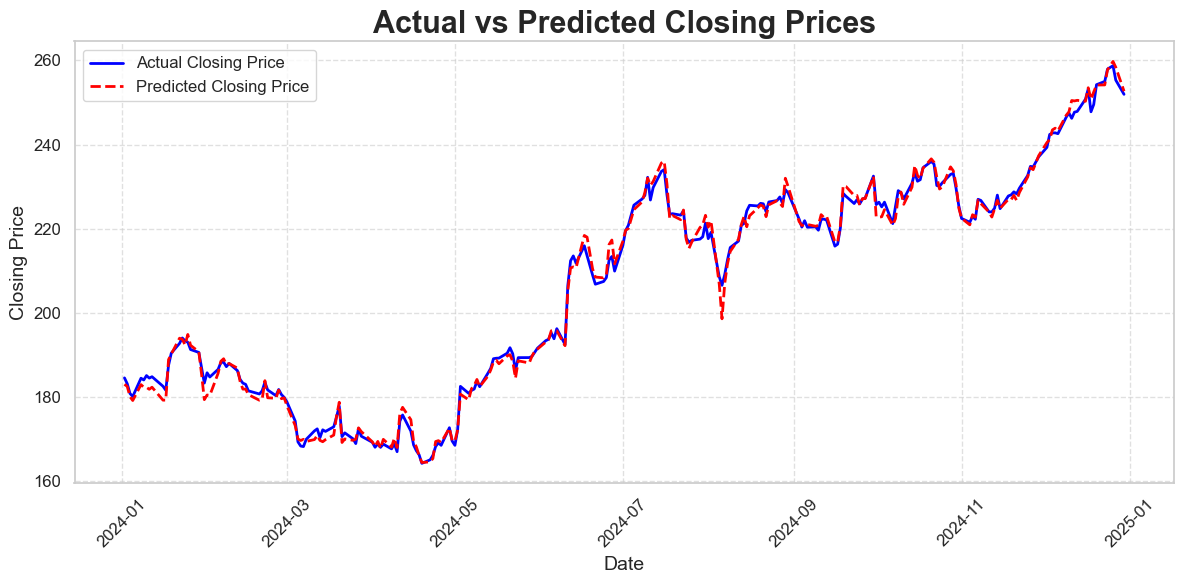

In [192]:
comparison_df = test_close.copy()
comparison_df['Predicted Close'] = test_prompts_predictions['close price prediction']
plt.figure(figsize=(12, 6))
plt.plot(comparison_df['Date'], comparison_df['Close'], label='Actual Closing Price', color='blue', linewidth=2)
plt.plot(comparison_df['Date'], comparison_df['Predicted Close'], label='Predicted Closing Price', color='red', linestyle='--', linewidth=2)
plt.title('Actual vs Predicted Closing Prices', fontsize=22, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Closing Price', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig('Actual_vs_Predicted_Closing_Prices_Google.png', format='png', bbox_inches='tight')
plt.show()

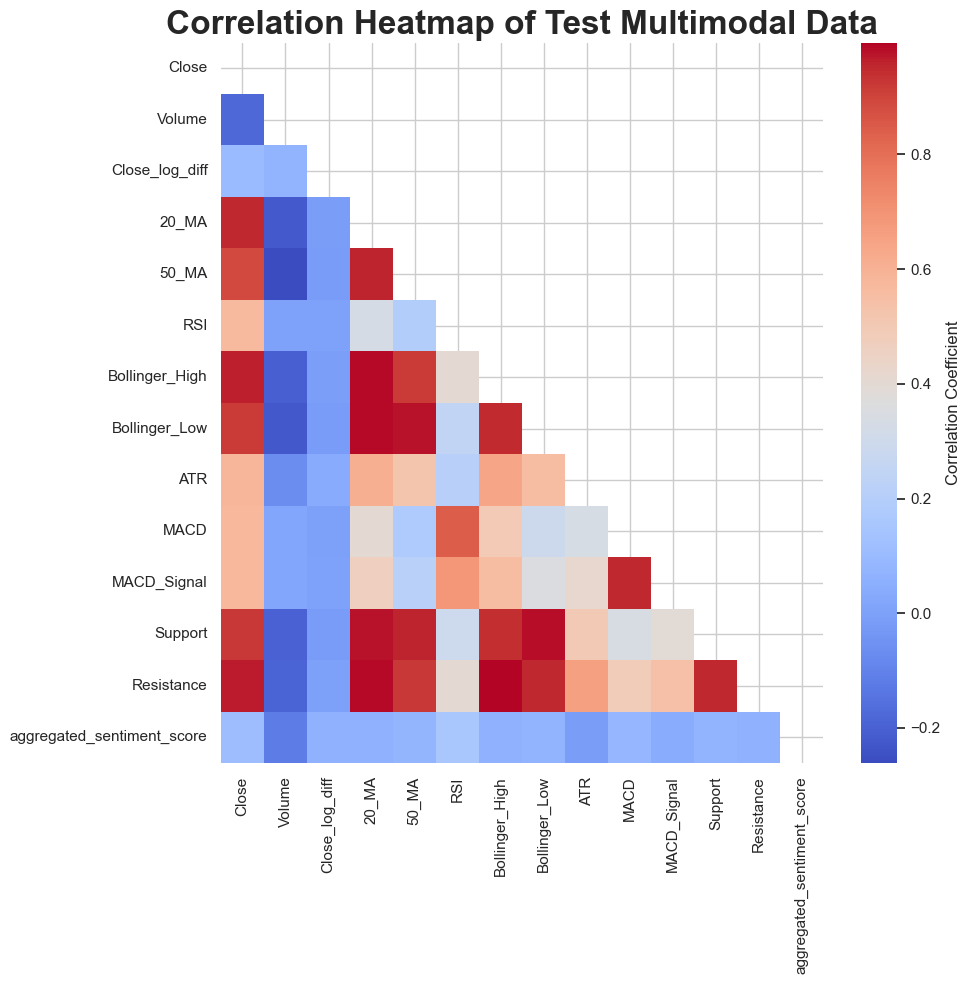

In [193]:
plt.figure(figsize=(10, 10)) 
correlation_matrix = test_multimodal_data.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, cmap='coolwarm', cbar_kws={'label': "Correlation Coefficient"})
plt.title("Correlation Heatmap of Test Multimodal Data", fontsize=24, fontweight='bold')
plt.tight_layout()
plt.savefig('Correlation_Heatmap_of_Test_Multimodal_Data.png', format='png', bbox_inches='tight')
plt.show()

In [194]:
total_end_time = time.time()
notebook_total_time = total_end_time - total_start_time
print(f"Notebook total runtime: {notebook_total_time:.4f} seconds")

Notebook total runtime: 7463.9071 seconds
